<div class="alert alert-block alert-warning">
<b>REQUIREMENT:</b> Before proceeding, install or update your
<b><a class="divlink" href="https://stenv.readthedocs.io/en/latest">stenv</a></b> distribution.  <b>stenv</b> is the replacement for AstroConda, which is unsupported as of February 2023.
</div>

<a id="titleFindsat"></a>
# Satellite trail detection in ACS/WFC data using acstools.findsat_mrt

This notebook provides examples of how to find and create masks for satellite trails in ACS/WFC imaging data using <a href= 'https://acstools.readthedocs.io/en/latest/findsat_mrt.html'>acstools.findsat_mrt</a>, which is based on the method described in <a href="https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/instrument-science-reports-isrs/_documents/isr2208.pdf">ACS ISR 2022-08</a>. Many of the tools presented here should be applicable to any imaging data. 

### Table of Contents:

[Introduction](#intro_ID) <br>
[Imports, Setup, and Data](#imports) <br>

[Example 1: Step-by-step guide to find trails in an FLC image](#example1) <br>
[Example 2: Quick run on an FLC image](#example2)<br>
[Example 3: Find trails in an FLC image using the WFC wrapper](#example3) <br>
[Example 4: Step-by-step guide to find trails in a DRC image](#example4) <br>
[Example 5: Find trails in a DRC image using the WFC wrapper](#example5)<br>
[Example 6: Create a new kernel for detection](#example6)<br>

### About this Notebook
**Author:** David V. Stark, ACS Instrument Team, Space Telescope Science Institute <br>
**First Published On:** 5/13/2023 <br>
**Updated On:** 5/15/2023

<a id="intro_ID"></a>
## Introduction

Despite being in orbit, HST imaging data still suffers from contamination by artificial satellites that can compromise science data unless they are identified and masked. This notebook presents examples of how to identify satellite trails in ACS/WFC data. The routine is also effective at identifying other linear features duch as <a href="https://hst-docs.stsci.edu/acsdhb/files/60243156/60243162/1/1567011208101/acs_Ch46.2.jpg">diffraction spikes</a> and <a href="https://hst-docs.stsci.edu/acsdhb/files/60243156/60243160/1/1567011424969/acs_Ch46.4.jpg">glint</a> (see <a href="https://hst-docs.stsci.edu/acsdhb/chapter-4-acs-data-processing-considerations/4-5-image-anomalies">Section 4.5 of the ACS DHB</a> for further discussion on these artifacts). 

A full description of the algorithm is provided in <a href="https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/instrument-science-reports-isrs/_documents/isr2208.pdf">ACS ISR 2022-08</a>. To briefly summarize, the Median Radon Transform (MRT) is calculated for an input image and used to identify linear signals in the data. The MRT is similar to the standard <a href="https://en.wikipedia.org/wiki/Radon_transform">Radon Transform</a> except that it calculates the median, rather than the sum, of data along all possible paths through an image. This modification makes the algorithm more robust against false signals from localized sources (e.g., stars, galaxies) but still very sensitive to persistent linear features, even well-below the background noise level. 

Additional post-processing is done to filter out spurious detections, primarily eliminating them based on trail S/N, width, and persistence across the image. These parameters, especially the maximum allowed trail width, are tuned for ACS/WFC data binned 2x2 and may be different for images from other instruments. Once the final set of trails is identified and characterized, a mask can be created. The routine provides numerous ways of visualizing the results, as will be demonstrated below.

The following examples illustrate how to use `acstools.findsat_mrt` to identify satellite trails and then create masks for them. Examples 1 and 4 go through the analysis step by step, including how to preprocess data and run individual routines inside `findsat_mrt`. Examples 2, 3, and 5 demonstrate how to automate many of these steps. Our demonstrations stop at the creation of the masks. We leave it to the user to decide the best way to apply the masks to their own analysis.

<a id="imports"></a>
## Imports, setup, and data

It is recommended that you use the latest <a href="https://github.com/spacetelescope/stenv">stenv</a> python environment when using this notebook. In particular, you <b>must</b> use acstools v3.6.0 or greater in order to run this notebook. You can check you version with

`conda list acstools`

and update if necessary with

`conda update acstools`

Set your working directory and import the needed packages with the following

In [1]:
# Import modules and setup
import matplotlib.pyplot as plt
import numpy as np
from astroquery.mast import Observations
from astropy.io import fits
from astropy.nddata import bitmask, block_reduce, block_replicate
from acstools.findsat_mrt import TrailFinder, WfcWrapper
import os 
from acstools.utils_findsat_mrt import create_mrt_line_kernel
import shutil

In [2]:
# Check your own working directory
print('Current working directory is {}'.format(os.getcwd()))
# Define working directory if needed
# os.chdir('Insert your working directory here')

Current working directory is /home/runner/work/hst_notebooks/hst_notebooks/notebooks/ACS/acs_findsat_mrt


In [3]:
# These are optional configurations
%matplotlib inline
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams['font.serif'] = "Georgia"
plt.rcParams['font.family'] = "serif"

Download the example data needed and place it in the working directory that you defined above. Examples 1-3 use  <a href="https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:HST/product/jc8m32j5q_flc.fits">jc8m32j5q_flc.fits</a>, while examples 4-5 use <a href="https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:HST/product/hst_13498_32_acs_wfc_f606w_jc8m32j5_drc.fits">hst_13498_32_acs_wfc_f606w_jc8m32j5_drc.fits</a>.

In [4]:
# Download data files
obs_table = Observations.query_criteria(proposal_id=13498, obs_id='JC8M32010')

dl_table = Observations.download_products(obs_table['obsid'], 
                                          dataURI=['mast:HST/product/hst_13498_32_acs_wfc_f606w_jc8m32j5_drc.fits',
                                                   'mast:HST/product/jc8m32j5q_flc.fits'])
for row in dl_table:
    oldfname = row['Local Path']
    newfname = os.path.basename(oldfname)
    os.rename(oldfname, newfname)
    
shutil.rmtree('mastDownload')

 [Done]


 [Done]


<a id="example1"></a>

## Example 1: Finding trails in an FLC image

FLC images are individual exposures processed by the CALACS pipeline. The data contain two chips, but we only analyze one here. 

We start by reading in an image and doing some pre-processing to remove bad pixels, subtract a median background, and make the image a bit smaller (to speed up the calculation of the MRT).

In [5]:
# Read in the image files and header information
image_file = 'jc8m32j5q_flc.fits'
ext = 4  # ACS image data are in extensions 1 or 4, we'll just use 4 for now (chip 1)
with fits.open(image_file) as h:
    image = h[ext].data  # image data
    dq = h[ext+2].data  # data quality bitmasks

    header = h[0].header  # primary header
    image_header = h[1].header  # image header

Below, we make a mask for bad pixels. We're ignoring cosmic rays here because routines to make them often partially (but not fully) mask trails. By default, any masked pixels are set to `NaN`. 

In [6]:
mask = bitmask.bitfield_to_boolean_mask(dq, ignore_flags=[4096, 8192, 16384])
image[mask] = np.nan

Below we subtract Subtract the background from the image. Here we just do a simple median.

In [7]:
image = image - np.nanmedian(image)

The MRT is computationally demanding and WFC images are big. To help things a bit, let's rebin the images.

In [8]:
binsize = 2  # adjust this as needed
image_rebin = block_reduce(image, binsize, func=np.nansum)

We now set up `TrailFinder`. Many of the parameters in the call below are optional (and set to their current values by default) but we show them to illustrate the setup. Of note is that I'm explicitly defining the image header keys to save. These can be useful later when analyzing trail population properties. The keywords being saved here were chosen to ensure we know the original exposure ippsoot and which chip was analyzed. Additional keywords are saved that store information about the orientation of the telescope when the image was taken. In principle, the user can save any header keywords they like. We have also set `plot=False` in this example, so we can demonstrate how to manually create plots. Setting `plot=True` will automatically generate plots after specific processes are finished. Be aware that not all possible keyword parameters are defined below. See the <a href="https://acstools.readthedocs.io/en/latest/api/acstools.findsat_mrt.TrailFinder.html#acstools.findsat_mrt.TrailFinder">documentation</a> for complete information.

In [9]:
# Now we can set up TrailFinder
s = TrailFinder(image=image_rebin,
                header=header,
                image_header=image_header,
                save_image_header_keys=['ROOTNAME', 'CCDCHIP', 'CRPIX1', 'CRPIX2', 'CRVAL1', 'CRVAL2',
                                        'ORIENTAT', 'RA_APER', 'DEC_APER', 'PA_APER'],
                processes=8,
                plot=False,
                threshold=5,
                max_width=75,  
                check_persistence=True,
                min_persistence=0.5,
                output_root='example1')

Before we actually run anything, let's plot the image we are analyzing. You should see two satellite trails in this example.

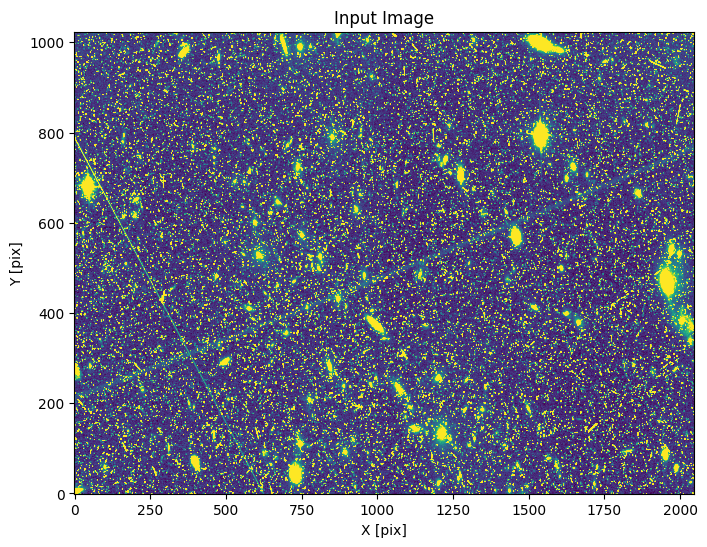

In [10]:
s.plot_image()

If you're having trouble seeing the trails, you can adjust the scale keyword (the min and max values to show given as multiples of the image standard deviation)

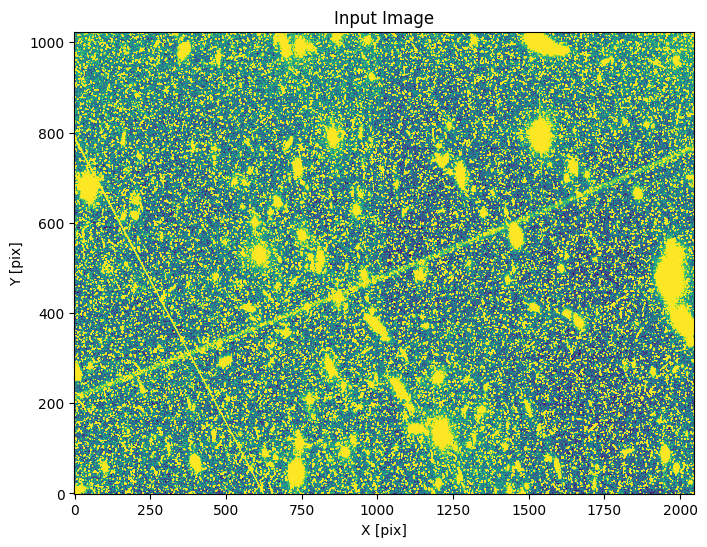

In [11]:
s.plot_image(scale=[-1, 1])

Next we run the Median Radon Transform. This step can take some time depending on the image size and number of processes being used. This tutorial assumes you can run 8 processes at the same time, but adjust as needed. If you're not sure how many processes you can run, you can see how many CPU cores are available and adjust based on that.

In [12]:
os.cpu_count()

4

In [13]:
s.processes = 8  # adjust this if necessary
s.run_mrt()

INFO:utils_findsat_mrt:Calculating median Radon Transform with 4 processes


Now we will plot the MRT. You may be able to spot the signals from the satellite trails as two somewhat wide point-like sources.

<Axes: title={'center': 'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

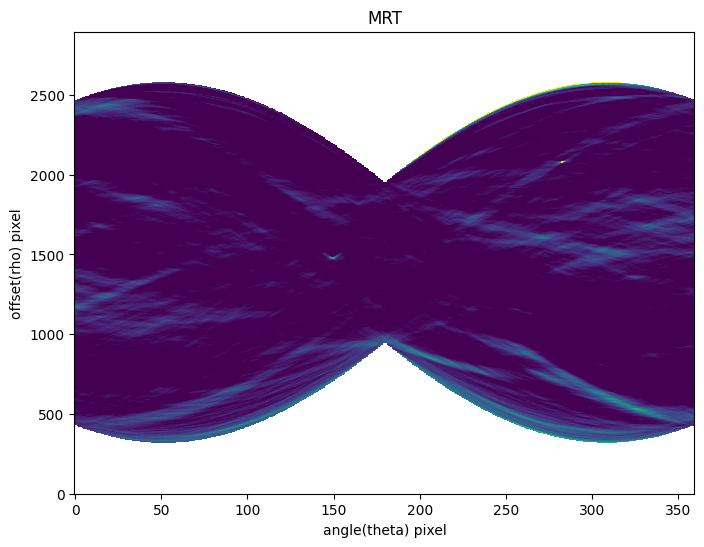

In [14]:
s.plot_mrt()

Note that the x axis in in pixels, not degrees or radians. The `theta` array ranges from 0 to 180 with a spacing of 0.5 degrees, hence 360 pixels.

We next run the source finder on the MRT. You can create your own detection kernels, or use the defaults provided (see [Example 6](#example6) for how to create detection kernels). Depending on the settings, this can pick up a lot more than the actual trails we're interested in. There are additional steps we'll take later to filter these false detections out. The ones we found and their location on the MRT are shown below.

The `threshold` in this case refers to the signal-to-noise ratio of a feature found in the MRT. The default is 5.

INFO:findsat_mrt:Detection threshold: 5


INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/data/rt_line_kernel_width15.fits


INFO:findsat_mrt:{no} sources found using kernel: 2


INFO:findsat_mrt:2 sources found using kernel


INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/data/rt_line_kernel_width7.fits


INFO:findsat_mrt:{no} sources found using kernel: 4


INFO:findsat_mrt:4 sources found using kernel


INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/data/rt_line_kernel_width3.fits


INFO:findsat_mrt:{no} sources found using kernel: 8


INFO:findsat_mrt:8 sources found using kernel


INFO:findsat_mrt:Removing duplicate sources


INFO:findsat_mrt:8 final sources found


<Axes: title={'center': 'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

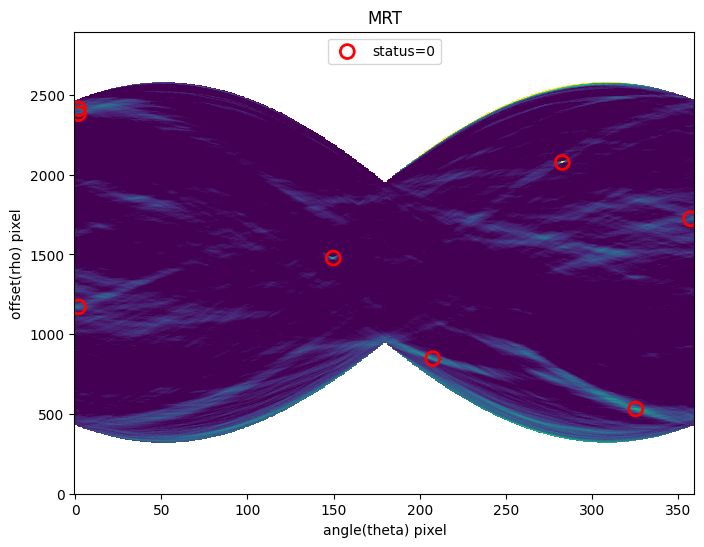

In [15]:
s.threshold = 5  # detection threshold
s.find_mrt_sources()  # finds the sources
s.plot_mrt(show_sources=True)  # overplots the sources on top of the MRT

We filter the sources further based on a reassessment of their S/N, width, and persistence. The default parameters (namely width) have been chosen for ACS data binned by 2 pixels in each direction. It's possible different defaults will be better for different imaging data.

In [16]:
# Parameters that affect how the filtering works
s.threshold = 5
s.max_width = 75
s.check_persistence = True
s.min_persistence = 0.5

# now filter
s.filter_sources()

# note: some extra columns have been added to the source list
s.source_list

INFO:findsat_mrt:Filtering sources...
Min SNR : 5
Max Width: 75
Min Length: 25
Check persistence: True


INFO:findsat_mrt:Min persistence: 0.5


INFO:utils_findsat_mrt:amplitude of feature: 24.781228782083772
baseline noise: 1.1392404204749706
snr of feature = 20.752413570220774


INFO:utils_findsat_mrt:width of feature = 27.93697135868217


INFO:utils_findsat_mrt:breaking into 21.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 21


INFO:utils_findsat_mrt:amplitude of feature: 26.777939266096766
baseline noise: 5.266821168373301
snr of feature = 4.08426969704144


INFO:utils_findsat_mrt:width of feature = 26.912252404115833


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.08426969704144, 26.912252404115833, 255.94771205201673


INFO:utils_findsat_mrt:Checking persistence, step 2 of 21


INFO:utils_findsat_mrt:amplitude of feature: 36.86109099480041
baseline noise: 4.031873465370958
snr of feature = 8.142422576351603


INFO:utils_findsat_mrt:width of feature = 26.299791363903836


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 8.142422576351603, 26.299791363903836, 255.3153709824764


INFO:utils_findsat_mrt:Checking persistence, step 3 of 21


INFO:utils_findsat_mrt:amplitude of feature: 29.884373215737874
baseline noise: 4.432935911817287
snr of feature = 5.7414403930524545


INFO:utils_findsat_mrt:width of feature = 24.522434144873472


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.7414403930524545, 24.522434144873472, 253.71933453180375


INFO:utils_findsat_mrt:Checking persistence, step 4 of 21


INFO:utils_findsat_mrt:amplitude of feature: 35.338171095058804
baseline noise: 5.139947037197364
snr of feature = 5.875201405640844


INFO:utils_findsat_mrt:width of feature = 24.328122083921244


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.875201405640844, 24.328122083921244, 252.1528345263356


INFO:utils_findsat_mrt:Checking persistence, step 5 of 21


INFO:utils_findsat_mrt:amplitude of feature: 35.827924719714396
baseline noise: 4.373673374850432
snr of feature = 7.191723900950792


INFO:utils_findsat_mrt:width of feature = 31.80533203666792


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.191723900950792, 31.80533203666792, 250.32894672821345


INFO:utils_findsat_mrt:Checking persistence, step 6 of 21


INFO:utils_findsat_mrt:amplitude of feature: 28.98748795205496
baseline noise: 4.047251630718669
snr of feature = 6.162264814977087


INFO:utils_findsat_mrt:width of feature = 22.328341449863046


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.162264814977087, 22.328341449863046, 250.78695422770954


INFO:utils_findsat_mrt:Checking persistence, step 7 of 21


INFO:utils_findsat_mrt:amplitude of feature: 26.176049037358098
baseline noise: 5.473593475770235
snr of feature = 3.7822420779385055


INFO:utils_findsat_mrt:width of feature = 18.610593335348995


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.7822420779385055, 18.610593335348995, 250.01554635050337


INFO:utils_findsat_mrt:Checking persistence, step 8 of 21


INFO:utils_findsat_mrt:amplitude of feature: 38.773673376342536
baseline noise: 4.532406342910618
snr of feature = 7.554765491622466


INFO:utils_findsat_mrt:width of feature = 24.568512312437377


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.554765491622466, 24.568512312437377, 249.70351180160577


INFO:utils_findsat_mrt:Checking persistence, step 9 of 21


INFO:utils_findsat_mrt:amplitude of feature: 29.60885136170824
baseline noise: 8.783011700036266
snr of feature = 2.3711501672696147


INFO:utils_findsat_mrt:width of feature = 20.19012908962668


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.3711501672696147, 20.19012908962668, 249.57377404180238


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 21


INFO:utils_findsat_mrt:amplitude of feature: 41.80623636545298
baseline noise: 4.939912133819193
snr of feature = 7.462951411472038


INFO:utils_findsat_mrt:width of feature = 42.53203134793276


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.462951411472038, 42.53203134793276, 249.78357415447687


INFO:utils_findsat_mrt:Checking persistence, step 11 of 21


INFO:utils_findsat_mrt:amplitude of feature: 27.730559231566154
baseline noise: 5.385939821448101
snr of feature = 4.148694592007217


INFO:utils_findsat_mrt:width of feature = 29.08177986641519


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.148694592007217, 29.08177986641519, 250.48055834836185


INFO:utils_findsat_mrt:Checking persistence, step 12 of 21


INFO:utils_findsat_mrt:amplitude of feature: 32.561900539500186
baseline noise: 4.5295217241865995
snr of feature = 6.188816506967426


INFO:utils_findsat_mrt:width of feature = 28.09886146195248


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.188816506967426, 28.09886146195248, 249.0269336127743


INFO:utils_findsat_mrt:Checking persistence, step 13 of 21


INFO:utils_findsat_mrt:amplitude of feature: 26.97240172562028
baseline noise: 3.8596124486331966
snr of feature = 5.988370486568414


INFO:utils_findsat_mrt:width of feature = 23.44420709235706


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.988370486568414, 23.44420709235706, 250.06034393794346


INFO:utils_findsat_mrt:Checking persistence, step 14 of 21


INFO:utils_findsat_mrt:amplitude of feature: 28.68602494941817
baseline noise: 5.694566385833712
snr of feature = 4.037437972587337


INFO:utils_findsat_mrt:width of feature = 21.804636480148332


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.037437972587337, 21.804636480148332, 251.089147339524


INFO:utils_findsat_mrt:Checking persistence, step 15 of 21


INFO:utils_findsat_mrt:amplitude of feature: 35.83959172421478
baseline noise: 4.547749129001824
snr of feature = 6.880731919810436


INFO:utils_findsat_mrt:width of feature = 27.597328312013047


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.880731919810436, 27.597328312013047, 251.16204416559495


INFO:utils_findsat_mrt:Checking persistence, step 16 of 21


INFO:utils_findsat_mrt:amplitude of feature: 29.653511720250755
baseline noise: 4.689231761741343
snr of feature = 5.323746239669532


INFO:utils_findsat_mrt:width of feature = 34.20544765839057


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.323746239669532, 34.20544765839057, 251.01088333237297


INFO:utils_findsat_mrt:Checking persistence, step 17 of 21


INFO:utils_findsat_mrt:amplitude of feature: 27.925070312484305
baseline noise: 6.539005857808222
snr of feature = 3.2705375893093898


INFO:utils_findsat_mrt:width of feature = 20.67192262702821


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.2705375893093898, 20.67192262702821, 252.99250047723368


INFO:utils_findsat_mrt:Checking persistence, step 18 of 21


INFO:utils_findsat_mrt:amplitude of feature: 33.60054527635417
baseline noise: 4.936877710060228
snr of feature = 5.8060315141863725


INFO:utils_findsat_mrt:width of feature = 25.624363360386155


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.8060315141863725, 25.624363360386155, 254.44205498923287


INFO:utils_findsat_mrt:Checking persistence, step 19 of 21


INFO:utils_findsat_mrt:amplitude of feature: 28.422250393722546
baseline noise: 3.9568555503182568
snr of feature = 6.183039671851679


INFO:utils_findsat_mrt:width of feature = 24.644950933499302


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.183039671851679, 24.644950933499302, 255.1339854488413


INFO:utils_findsat_mrt:Checking persistence, step 20 of 21


INFO:utils_findsat_mrt:amplitude of feature: 28.481791025926363
baseline noise: 6.130826230606326
snr of feature = 3.6456692710909824


INFO:utils_findsat_mrt:width of feature = 27.528715120165543


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.6456692710909824, 27.528715120165543, 256.08658854547815


INFO:utils_findsat_mrt:Checking persistence, step 21 of 21


INFO:utils_findsat_mrt:amplitude of feature: 31.705863786725068
baseline noise: 5.038364135503358
snr of feature = 5.29288851182994


INFO:utils_findsat_mrt:width of feature = 29.3261044453607


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.29288851182994, 29.3261044453607, 257.26469437207624


INFO:utils_findsat_mrt:Number of sections analyzed: 21
Number of sections that passed: 20
persistance score: 0.9523809523809523


INFO:utils_findsat_mrt:amplitude of feature: 140.6325310562624
baseline noise: 1.6349383069861778
snr of feature = 85.0170261197821


INFO:utils_findsat_mrt:width of feature = 5.852792378744823


INFO:utils_findsat_mrt:breaking into 10.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 10


INFO:utils_findsat_mrt:amplitude of feature: 433.35799221899043
baseline noise: 5.146599100327714
snr of feature = 83.20278785487605


INFO:utils_findsat_mrt:width of feature = 3.9196903857742313


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 83.20278785487605, 3.9196903857742313, 252.12346347777913


INFO:utils_findsat_mrt:Checking persistence, step 2 of 10


INFO:utils_findsat_mrt:amplitude of feature: 382.87756197996185
baseline noise: 6.7085814104331645
snr of feature = 56.07280549424531


INFO:utils_findsat_mrt:width of feature = 3.963505073451529


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 56.07280549424531, 3.963505073451529, 251.94556991306192


INFO:utils_findsat_mrt:Checking persistence, step 3 of 10


INFO:utils_findsat_mrt:amplitude of feature: 294.4385404166353
baseline noise: 5.670862529053957
snr of feature = 50.92129749365571


INFO:utils_findsat_mrt:width of feature = 3.9409384384177315


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 50.92129749365571, 3.9409384384177315, 251.76604610986263


INFO:utils_findsat_mrt:Checking persistence, step 4 of 10


INFO:utils_findsat_mrt:amplitude of feature: 209.99469753845483
baseline noise: 4.176245406945087
snr of feature = 49.28313163523247


INFO:utils_findsat_mrt:width of feature = 4.040644251356582


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 49.28313163523247, 4.040644251356582, 251.53667204446884


INFO:utils_findsat_mrt:Checking persistence, step 5 of 10


INFO:utils_findsat_mrt:amplitude of feature: 231.35124981013368
baseline noise: 4.221398902077043
snr of feature = 53.80440374784353


INFO:utils_findsat_mrt:width of feature = 4.0823911470658345


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 53.80440374784353, 4.0823911470658345, 251.24883549025523


INFO:utils_findsat_mrt:Checking persistence, step 6 of 10


INFO:utils_findsat_mrt:amplitude of feature: 209.89648284455865
baseline noise: 4.617413792211489
snr of feature = 44.45758562912545


INFO:utils_findsat_mrt:width of feature = 4.000327266785064


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 44.45758562912545, 4.000327266785064, 250.96659870829532


INFO:utils_findsat_mrt:Checking persistence, step 7 of 10


INFO:utils_findsat_mrt:amplitude of feature: 155.9266668195209
baseline noise: 5.862285931168757
snr of feature = 25.598270478498133


INFO:utils_findsat_mrt:width of feature = 4.121455894765404


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 25.598270478498133, 4.121455894765404, 250.65087811069012


INFO:utils_findsat_mrt:Checking persistence, step 8 of 10


INFO:utils_findsat_mrt:amplitude of feature: 157.05851550614148
baseline noise: 4.338156976834571
snr of feature = 35.20397241151531


INFO:utils_findsat_mrt:width of feature = 3.9598865146421076


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 35.20397241151531, 3.9598865146421076, 250.3121777727571


INFO:utils_findsat_mrt:Checking persistence, step 9 of 10


INFO:utils_findsat_mrt:amplitude of feature: 170.627447731048
baseline noise: 5.29262014663969
snr of feature = 31.238748106527197


INFO:utils_findsat_mrt:width of feature = 4.038551384055381


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 31.238748106527197, 4.038551384055381, 249.89181733506314


INFO:utils_findsat_mrt:Checking persistence, step 10 of 10


INFO:utils_findsat_mrt:amplitude of feature: 158.2991830792352
baseline noise: 7.87008105556901
snr of feature = 19.11404736006116


INFO:utils_findsat_mrt:width of feature = 3.7413829072455655


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 19.11404736006116, 3.7413829072455655, 249.45429170495117


INFO:utils_findsat_mrt:Number of sections analyzed: 10
Number of sections that passed: 10
persistance score: 1.0


INFO:utils_findsat_mrt:amplitude of feature: 9.516165693052654
baseline noise: 1.6769988058063947
snr of feature = 4.674521448735767


INFO:utils_findsat_mrt:width of feature = 77.80569657005722


INFO:utils_findsat_mrt:amplitude of feature: 8.662488481692705
baseline noise: 1.310166879396368
snr of feature = 5.6117443647207494


INFO:utils_findsat_mrt:width of feature = 153.5992941626944


INFO:utils_findsat_mrt:amplitude of feature: 23.16941167211695
baseline noise: 2.171206884893149
snr of feature = 9.671213247031123


INFO:utils_findsat_mrt:width of feature = 183.82199492799182


INFO:utils_findsat_mrt:amplitude of feature: 15.82572897769589
baseline noise: 1.6913642253460386
snr of feature = 8.356783560003512


INFO:utils_findsat_mrt:width of feature = 79.72093191943699


INFO:utils_findsat_mrt:amplitude of feature: 6.643006846505017
baseline noise: 1.6379596760811124
snr of feature = 3.0556595766744947


INFO:utils_findsat_mrt:width of feature = 127.90245994123578


INFO:utils_findsat_mrt:amplitude of feature: 7.968046280696431
baseline noise: 1.7889030634523286
snr of feature = 3.4541520686533085


INFO:utils_findsat_mrt:width of feature = 108.52591914378449


<QTable length=8>
  id      xcentroid      ...        snr            persistence    
int64      float64       ...      float64            float64      
----- ------------------ ... ------------------ ------------------
    1  149.8247532736418 ... 20.752413570220774 0.9523809523809523
    2  282.7960369376785 ...   85.0170261197821                1.0
    3  1.892655399843995 ...  4.674521448735767                0.0
    6 1.8901946935406222 ... 5.6117443647207494                0.0
    7 325.42673789644846 ...  9.671213247031123                0.0
    8 207.55564520164214 ...  8.356783560003512                0.0
   11 357.19878476679287 ... 3.0556595766744947                0.0
   13 1.9268017945417673 ... 3.4541520686533085                0.0

Several columns have been added to the source list that characterize the observed streak. Also, the `status` array has values of 0, 1, and 2 now (it just had 0 before). Those with `status=2` are sources that passed all filtering stages (checks for SNR and width, then persistence). Those with `status=1` are sources that passed the first filtering stage (checks for SNR and width), but not the second (persistence check). And `status=0` are sources that did not pass the filtering steps.

The `plot_mrt` command will overplot the different statuses

<Axes: title={'center': 'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

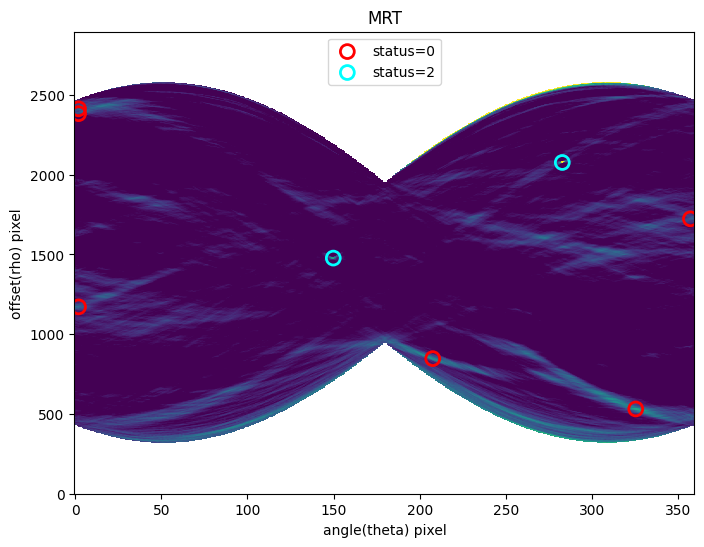

In [17]:
s.plot_mrt(show_sources=True)

Now we can make the mask itself. By default it only uses sources in the MRT with `status=2`. We make two types of masks, one a simple boolean mask, and one a segementation mask where pixels corresponding to each streak are assigned the ID number. We create these below.

In [18]:
# make the mask
s.mask_include_status = [2]
s.make_mask()

<Axes: title={'center': 'Segmentation Mask'}>

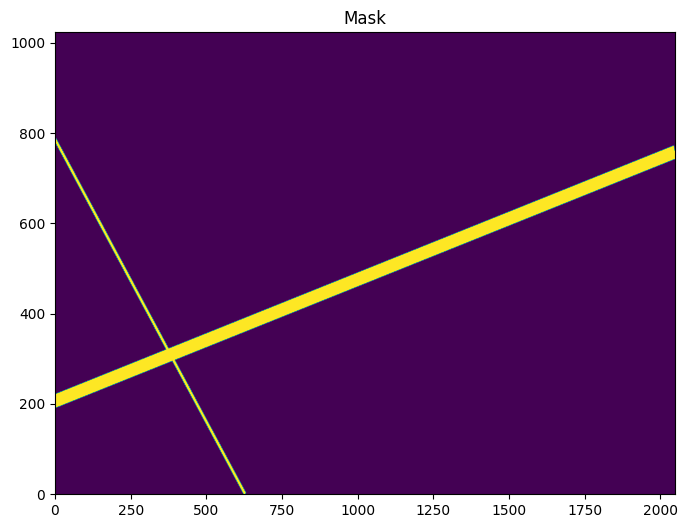

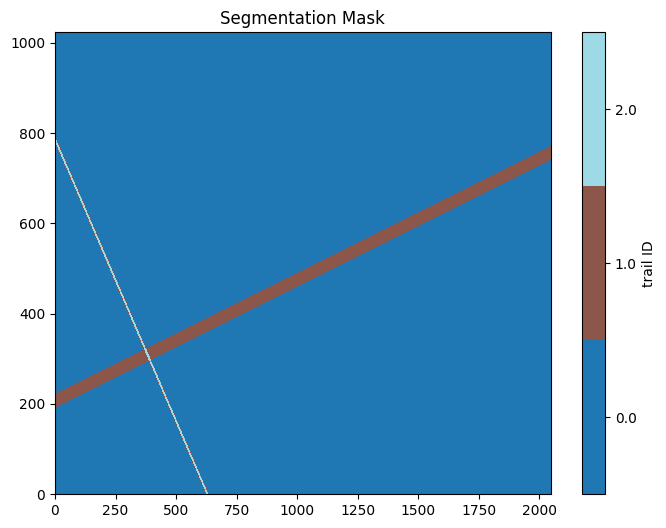

In [19]:
# plot the mask and segmentation map
s.plot_mask()
s.plot_segment()

We can also overlay the mask on top of the image to make sure it makes sense.

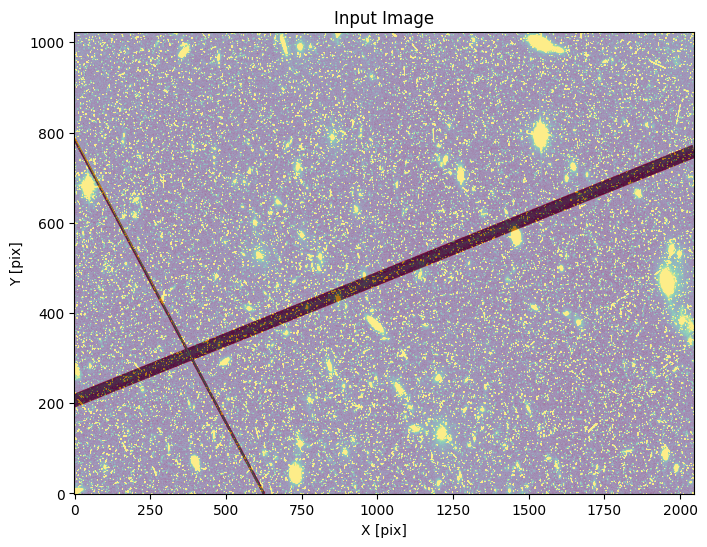

In [20]:
s.plot_image(overlay_mask=True)

We can save the results now. You have the optional of saving the catalog, mask, MRT, and a diagnostic image that shows the results. In this example we'll just save everything.

In [21]:
# define what to save
s.save_mask = True
s.save_mrt = True
s.save_catalog = True
s.save_diagnostic = True

s.save_output()

INFO:findsat_mrt:Wrote MRT to ./example1_mrt.fits


INFO:findsat_mrt:Wrote mask to ./example1_mask.fits


INFO:findsat_mrt:Wrote diagnostic plot to ./example1_diagnostic.png


INFO:findsat_mrt:wrote catalog ./example1_catalog.fits


Keep in mind that the mask we have created is applicable to the rebinned image. To convert it into a mask that can be applied to the original unbinned image, we need to resample it using the `block_replicate` function. The rescaled mask is plotted below. Note the difference in image size, but the mask pattern remains the same.

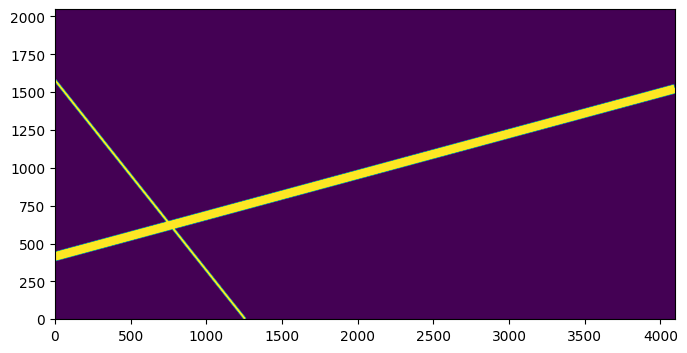

In [22]:
full_mask = block_replicate(s.mask, binsize, conserve_sum=False)
fig, ax = plt.subplots()
ax.imshow(full_mask, origin='lower')

## <a id="example2"></a>
## Example 2: Quick run of TrailFinder on an flc image

Example 1 thoroughly demonstrated the steps to read in an FLC file, pre-process it, and identify trails. This example demonstrates how one can run many of the steps simultaneously once a file is read in an all parameters set. 

First, we read in and preprocess the data file exactly as before.

In [23]:
# Read in the image files and header information
image_file = 'jc8m32j5q_flc.fits'
ext = 4  # ACS image data are in extensions 1 or 4, we'll just use 1 for now
with fits.open(image_file) as h:
    image = h[ext].data  # image data
    dq = h[ext+2].data  # data quality bitmasks
    
    header = h[0].header  # primary header
    image_header = h[1].header  # image header

# make a mask for bad pixels.
mask = bitmask.bitfield_to_boolean_mask(dq, ignore_flags=[4096, 8192, 16384])
image[mask] = np.nan

# Subtract the background from the image.
image = image - np.nanmedian(image)

# Rebin the image to speed up calculation
image_rebin = block_reduce(image, 2, func=np.nansum)
print(image)

[[ 5.3688492e+01  7.7842072e+01  8.2069962e+01 ... -3.5500183e+00
   6.0038452e+00  2.1702469e+01]
 [ 1.1057211e+02  1.1134854e+02  8.5704437e+01 ...  1.4351349e+01
  -6.9071655e+00  2.6282501e+00]
 [ 1.2605432e+02  8.3174591e+01  1.2411203e+02 ...  5.4317114e+02
   1.4528281e+03  1.2523743e+01]
 ...
 [-7.8663788e+00  1.1875504e+01 -1.3893051e+01 ...  3.0214722e+01
   9.3101196e+00 -1.3999176e+01]
 [-8.7981873e+00 -1.8275146e+00  2.6314880e+01 ...  1.9167786e+01
  -9.4055176e-02 -6.7887421e+00]
 [           nan            nan            nan ...            nan
             nan            nan]]


And initialize trail finder as before

In [24]:
s2 = TrailFinder(image=image_rebin,
                 header=header,
                 image_header=image_header,
                 save_image_header_keys=['ROOTNAME', 'CCDCHIP', 'CRPIX1', 'CRPIX2', 'CRVAL1', 'CRVAL2',
                                         'ORIENTAT', 'RA_APER', 'DEC_APER', 'PA_APER'],
                 processes=8,
                 plot=False,
                 threshold=5,
                 max_width=75,  
                 check_persistence=True,
                 min_persistence=0.5,
                 output_root='example2')

If you're feeling ok about the setup, run all the subsequent steps together with the `run_all` command (this calculates the MRT, finds MRT sources, filters the sources, and saves the output)

In [25]:
s2.run_all()

INFO:utils_findsat_mrt:Calculating median Radon Transform with 4 processes


INFO:findsat_mrt:Detection threshold: 5


INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/data/rt_line_kernel_width15.fits


INFO:findsat_mrt:{no} sources found using kernel: 2


INFO:findsat_mrt:2 sources found using kernel


INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/data/rt_line_kernel_width7.fits


INFO:findsat_mrt:{no} sources found using kernel: 4


INFO:findsat_mrt:4 sources found using kernel


INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/data/rt_line_kernel_width3.fits


INFO:findsat_mrt:{no} sources found using kernel: 8


INFO:findsat_mrt:8 sources found using kernel


INFO:findsat_mrt:Removing duplicate sources


INFO:findsat_mrt:8 final sources found


INFO:findsat_mrt:Filtering sources...
Min SNR : 5
Max Width: 75
Min Length: 25
Check persistence: True


INFO:findsat_mrt:Min persistence: 0.5


INFO:utils_findsat_mrt:amplitude of feature: 24.781228782083772
baseline noise: 1.1392404204749706
snr of feature = 20.752413570220774


INFO:utils_findsat_mrt:width of feature = 27.93697135868217


INFO:utils_findsat_mrt:breaking into 21.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 21


INFO:utils_findsat_mrt:amplitude of feature: 26.777939266096766
baseline noise: 5.266821168373301
snr of feature = 4.08426969704144


INFO:utils_findsat_mrt:width of feature = 26.912252404115833


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.08426969704144, 26.912252404115833, 255.94771205201673


INFO:utils_findsat_mrt:Checking persistence, step 2 of 21


INFO:utils_findsat_mrt:amplitude of feature: 36.86109099480041
baseline noise: 4.031873465370958
snr of feature = 8.142422576351603


INFO:utils_findsat_mrt:width of feature = 26.299791363903836


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 8.142422576351603, 26.299791363903836, 255.3153709824764


INFO:utils_findsat_mrt:Checking persistence, step 3 of 21


INFO:utils_findsat_mrt:amplitude of feature: 29.884373215737874
baseline noise: 4.432935911817287
snr of feature = 5.7414403930524545


INFO:utils_findsat_mrt:width of feature = 24.522434144873472


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.7414403930524545, 24.522434144873472, 253.71933453180375


INFO:utils_findsat_mrt:Checking persistence, step 4 of 21


INFO:utils_findsat_mrt:amplitude of feature: 35.338171095058804
baseline noise: 5.139947037197364
snr of feature = 5.875201405640844


INFO:utils_findsat_mrt:width of feature = 24.328122083921244


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.875201405640844, 24.328122083921244, 252.1528345263356


INFO:utils_findsat_mrt:Checking persistence, step 5 of 21


INFO:utils_findsat_mrt:amplitude of feature: 35.827924719714396
baseline noise: 4.373673374850432
snr of feature = 7.191723900950792


INFO:utils_findsat_mrt:width of feature = 31.80533203666792


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.191723900950792, 31.80533203666792, 250.32894672821345


INFO:utils_findsat_mrt:Checking persistence, step 6 of 21


INFO:utils_findsat_mrt:amplitude of feature: 28.98748795205496
baseline noise: 4.047251630718669
snr of feature = 6.162264814977087


INFO:utils_findsat_mrt:width of feature = 22.328341449863046


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.162264814977087, 22.328341449863046, 250.78695422770954


INFO:utils_findsat_mrt:Checking persistence, step 7 of 21


INFO:utils_findsat_mrt:amplitude of feature: 26.176049037358098
baseline noise: 5.473593475770235
snr of feature = 3.7822420779385055


INFO:utils_findsat_mrt:width of feature = 18.610593335348995


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.7822420779385055, 18.610593335348995, 250.01554635050337


INFO:utils_findsat_mrt:Checking persistence, step 8 of 21


INFO:utils_findsat_mrt:amplitude of feature: 38.773673376342536
baseline noise: 4.532406342910618
snr of feature = 7.554765491622466


INFO:utils_findsat_mrt:width of feature = 24.568512312437377


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.554765491622466, 24.568512312437377, 249.70351180160577


INFO:utils_findsat_mrt:Checking persistence, step 9 of 21


INFO:utils_findsat_mrt:amplitude of feature: 29.60885136170824
baseline noise: 8.783011700036266
snr of feature = 2.3711501672696147


INFO:utils_findsat_mrt:width of feature = 20.19012908962668


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.3711501672696147, 20.19012908962668, 249.57377404180238


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 21


INFO:utils_findsat_mrt:amplitude of feature: 41.80623636545298
baseline noise: 4.939912133819193
snr of feature = 7.462951411472038


INFO:utils_findsat_mrt:width of feature = 42.53203134793276


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.462951411472038, 42.53203134793276, 249.78357415447687


INFO:utils_findsat_mrt:Checking persistence, step 11 of 21


INFO:utils_findsat_mrt:amplitude of feature: 27.730559231566154
baseline noise: 5.385939821448101
snr of feature = 4.148694592007217


INFO:utils_findsat_mrt:width of feature = 29.08177986641519


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.148694592007217, 29.08177986641519, 250.48055834836185


INFO:utils_findsat_mrt:Checking persistence, step 12 of 21


INFO:utils_findsat_mrt:amplitude of feature: 32.561900539500186
baseline noise: 4.5295217241865995
snr of feature = 6.188816506967426


INFO:utils_findsat_mrt:width of feature = 28.09886146195248


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.188816506967426, 28.09886146195248, 249.0269336127743


INFO:utils_findsat_mrt:Checking persistence, step 13 of 21


INFO:utils_findsat_mrt:amplitude of feature: 26.97240172562028
baseline noise: 3.8596124486331966
snr of feature = 5.988370486568414


INFO:utils_findsat_mrt:width of feature = 23.44420709235706


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.988370486568414, 23.44420709235706, 250.06034393794346


INFO:utils_findsat_mrt:Checking persistence, step 14 of 21


INFO:utils_findsat_mrt:amplitude of feature: 28.68602494941817
baseline noise: 5.694566385833712
snr of feature = 4.037437972587337


INFO:utils_findsat_mrt:width of feature = 21.804636480148332


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.037437972587337, 21.804636480148332, 251.089147339524


INFO:utils_findsat_mrt:Checking persistence, step 15 of 21


INFO:utils_findsat_mrt:amplitude of feature: 35.83959172421478
baseline noise: 4.547749129001824
snr of feature = 6.880731919810436


INFO:utils_findsat_mrt:width of feature = 27.597328312013047


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.880731919810436, 27.597328312013047, 251.16204416559495


INFO:utils_findsat_mrt:Checking persistence, step 16 of 21


INFO:utils_findsat_mrt:amplitude of feature: 29.653511720250755
baseline noise: 4.689231761741343
snr of feature = 5.323746239669532


INFO:utils_findsat_mrt:width of feature = 34.20544765839057


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.323746239669532, 34.20544765839057, 251.01088333237297


INFO:utils_findsat_mrt:Checking persistence, step 17 of 21


INFO:utils_findsat_mrt:amplitude of feature: 27.925070312484305
baseline noise: 6.539005857808222
snr of feature = 3.2705375893093898


INFO:utils_findsat_mrt:width of feature = 20.67192262702821


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.2705375893093898, 20.67192262702821, 252.99250047723368


INFO:utils_findsat_mrt:Checking persistence, step 18 of 21


INFO:utils_findsat_mrt:amplitude of feature: 33.60054527635417
baseline noise: 4.936877710060228
snr of feature = 5.8060315141863725


INFO:utils_findsat_mrt:width of feature = 25.624363360386155


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.8060315141863725, 25.624363360386155, 254.44205498923287


INFO:utils_findsat_mrt:Checking persistence, step 19 of 21


INFO:utils_findsat_mrt:amplitude of feature: 28.422250393722546
baseline noise: 3.9568555503182568
snr of feature = 6.183039671851679


INFO:utils_findsat_mrt:width of feature = 24.644950933499302


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.183039671851679, 24.644950933499302, 255.1339854488413


INFO:utils_findsat_mrt:Checking persistence, step 20 of 21


INFO:utils_findsat_mrt:amplitude of feature: 28.481791025926363
baseline noise: 6.130826230606326
snr of feature = 3.6456692710909824


INFO:utils_findsat_mrt:width of feature = 27.528715120165543


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.6456692710909824, 27.528715120165543, 256.08658854547815


INFO:utils_findsat_mrt:Checking persistence, step 21 of 21


INFO:utils_findsat_mrt:amplitude of feature: 31.705863786725068
baseline noise: 5.038364135503358
snr of feature = 5.29288851182994


INFO:utils_findsat_mrt:width of feature = 29.3261044453607


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.29288851182994, 29.3261044453607, 257.26469437207624


INFO:utils_findsat_mrt:Number of sections analyzed: 21
Number of sections that passed: 20
persistance score: 0.9523809523809523


INFO:utils_findsat_mrt:amplitude of feature: 140.6325310562624
baseline noise: 1.6349383069861778
snr of feature = 85.0170261197821


INFO:utils_findsat_mrt:width of feature = 5.852792378744823


INFO:utils_findsat_mrt:breaking into 10.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 10


INFO:utils_findsat_mrt:amplitude of feature: 433.35799221899043
baseline noise: 5.146599100327714
snr of feature = 83.20278785487605


INFO:utils_findsat_mrt:width of feature = 3.9196903857742313


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 83.20278785487605, 3.9196903857742313, 252.12346347777913


INFO:utils_findsat_mrt:Checking persistence, step 2 of 10


INFO:utils_findsat_mrt:amplitude of feature: 382.87756197996185
baseline noise: 6.7085814104331645
snr of feature = 56.07280549424531


INFO:utils_findsat_mrt:width of feature = 3.963505073451529


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 56.07280549424531, 3.963505073451529, 251.94556991306192


INFO:utils_findsat_mrt:Checking persistence, step 3 of 10


INFO:utils_findsat_mrt:amplitude of feature: 294.4385404166353
baseline noise: 5.670862529053957
snr of feature = 50.92129749365571


INFO:utils_findsat_mrt:width of feature = 3.9409384384177315


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 50.92129749365571, 3.9409384384177315, 251.76604610986263


INFO:utils_findsat_mrt:Checking persistence, step 4 of 10


INFO:utils_findsat_mrt:amplitude of feature: 209.99469753845483
baseline noise: 4.176245406945087
snr of feature = 49.28313163523247


INFO:utils_findsat_mrt:width of feature = 4.040644251356582


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 49.28313163523247, 4.040644251356582, 251.53667204446884


INFO:utils_findsat_mrt:Checking persistence, step 5 of 10


INFO:utils_findsat_mrt:amplitude of feature: 231.35124981013368
baseline noise: 4.221398902077043
snr of feature = 53.80440374784353


INFO:utils_findsat_mrt:width of feature = 4.0823911470658345


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 53.80440374784353, 4.0823911470658345, 251.24883549025523


INFO:utils_findsat_mrt:Checking persistence, step 6 of 10


INFO:utils_findsat_mrt:amplitude of feature: 209.89648284455865
baseline noise: 4.617413792211489
snr of feature = 44.45758562912545


INFO:utils_findsat_mrt:width of feature = 4.000327266785064


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 44.45758562912545, 4.000327266785064, 250.96659870829532


INFO:utils_findsat_mrt:Checking persistence, step 7 of 10


INFO:utils_findsat_mrt:amplitude of feature: 155.9266668195209
baseline noise: 5.862285931168757
snr of feature = 25.598270478498133


INFO:utils_findsat_mrt:width of feature = 4.121455894765404


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 25.598270478498133, 4.121455894765404, 250.65087811069012


INFO:utils_findsat_mrt:Checking persistence, step 8 of 10


INFO:utils_findsat_mrt:amplitude of feature: 157.05851550614148
baseline noise: 4.338156976834571
snr of feature = 35.20397241151531


INFO:utils_findsat_mrt:width of feature = 3.9598865146421076


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 35.20397241151531, 3.9598865146421076, 250.3121777727571


INFO:utils_findsat_mrt:Checking persistence, step 9 of 10


INFO:utils_findsat_mrt:amplitude of feature: 170.627447731048
baseline noise: 5.29262014663969
snr of feature = 31.238748106527197


INFO:utils_findsat_mrt:width of feature = 4.038551384055381


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 31.238748106527197, 4.038551384055381, 249.89181733506314


INFO:utils_findsat_mrt:Checking persistence, step 10 of 10


INFO:utils_findsat_mrt:amplitude of feature: 158.2991830792352
baseline noise: 7.87008105556901
snr of feature = 19.11404736006116


INFO:utils_findsat_mrt:width of feature = 3.7413829072455655


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 19.11404736006116, 3.7413829072455655, 249.45429170495117


INFO:utils_findsat_mrt:Number of sections analyzed: 10
Number of sections that passed: 10
persistance score: 1.0


INFO:utils_findsat_mrt:amplitude of feature: 9.516165693052654
baseline noise: 1.6769988058063947
snr of feature = 4.674521448735767


INFO:utils_findsat_mrt:width of feature = 77.80569657005722


INFO:utils_findsat_mrt:amplitude of feature: 8.662488481692705
baseline noise: 1.310166879396368
snr of feature = 5.6117443647207494


INFO:utils_findsat_mrt:width of feature = 153.5992941626944


INFO:utils_findsat_mrt:amplitude of feature: 23.16941167211695
baseline noise: 2.171206884893149
snr of feature = 9.671213247031123


INFO:utils_findsat_mrt:width of feature = 183.82199492799182


INFO:utils_findsat_mrt:amplitude of feature: 15.82572897769589
baseline noise: 1.6913642253460386
snr of feature = 8.356783560003512


INFO:utils_findsat_mrt:width of feature = 79.72093191943699


INFO:utils_findsat_mrt:amplitude of feature: 6.643006846505017
baseline noise: 1.6379596760811124
snr of feature = 3.0556595766744947


INFO:utils_findsat_mrt:width of feature = 127.90245994123578


INFO:utils_findsat_mrt:amplitude of feature: 7.968046280696431
baseline noise: 1.7889030634523286
snr of feature = 3.4541520686533085


INFO:utils_findsat_mrt:width of feature = 108.52591914378449


INFO:findsat_mrt:Wrote diagnostic plot to ./example2_diagnostic.png


INFO:findsat_mrt:wrote catalog ./example2_catalog.fits


If we plot the mask, it should look identical to the one in the previous example.

<Axes: title={'center': 'Mask'}>

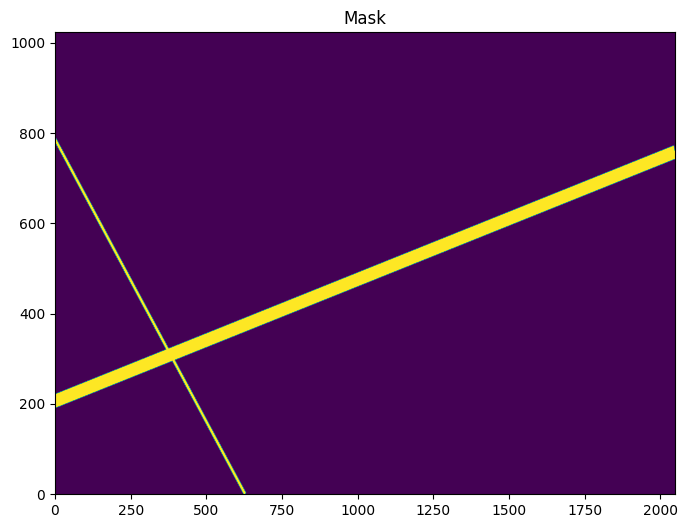

In [26]:
s2.plot_mask()

## <a id="example3"></a>
## Example 3: find trails in an FLC image using the WFC wrapper

The approaches shown in examples 1 and 2 can be useful for imaging data from any telescope, not just ACS/WFC data. However, for ACS/WFC data, we provide a convenience wrapper that performs even more of the steps all together, including reading the image and pre-processing it.

The `WfcWrapper` class has the same properties as the TrailFinder class, but with a few additional keywords. It also contains the additional routines that read the image, rebin, mask, and subtract the background. By default, these will be run automatically when WfcWrapper is initialized, although this can be turned off. In most cases, you probably will only need to adjust the `binsize` keyword. The specific value of `binsize` is up to the user. Larger values speed up the MRT calculation, but keep in mind that the parameters to filter out spurious trails (e.g., `max_width`) are tuned to WFC data binned 2x2. A user may want to start with a larger value for `binsize` and reduce it once they get a sense for the computation time.

In [27]:
w = WfcWrapper('jc8m32j5q_flc.fits', binsize=2, extension=4, processes=8, output_root='example3')

INFO:findsat_mrt:image type is flc


INFO:findsat_mrt:masking bad pixels


INFO:findsat_mrt:Subtracting median background


INFO:findsat_mrt:Rebinning the data by 2


We can plot the image to see that it looks like the one from the last example after preprocessing.

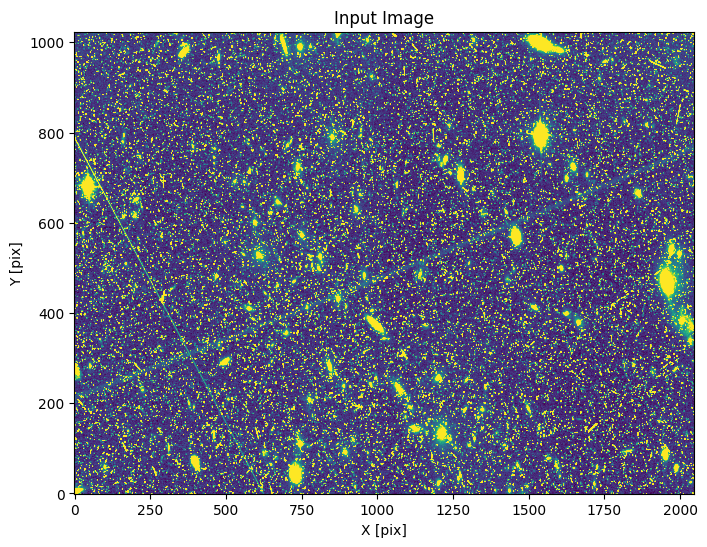

In [28]:
w.plot_image()

From here, everything is the same as the last example:

In [29]:
w.run_mrt()
w.find_mrt_sources()
w.filter_sources()

INFO:utils_findsat_mrt:Calculating median Radon Transform with 4 processes


INFO:findsat_mrt:Detection threshold: 5


INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/data/rt_line_kernel_width15.fits


INFO:findsat_mrt:{no} sources found using kernel: 2


INFO:findsat_mrt:2 sources found using kernel


INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/data/rt_line_kernel_width7.fits


INFO:findsat_mrt:{no} sources found using kernel: 4


INFO:findsat_mrt:4 sources found using kernel


INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/data/rt_line_kernel_width3.fits


INFO:findsat_mrt:{no} sources found using kernel: 8


INFO:findsat_mrt:8 sources found using kernel


INFO:findsat_mrt:Removing duplicate sources


INFO:findsat_mrt:8 final sources found


INFO:findsat_mrt:Filtering sources...
Min SNR : 5
Max Width: 75
Min Length: 25
Check persistence: True


INFO:findsat_mrt:Min persistence: 0.5


INFO:utils_findsat_mrt:amplitude of feature: 24.781228782083772
baseline noise: 1.1392404204749706
snr of feature = 20.752413570220774


INFO:utils_findsat_mrt:width of feature = 27.93697135868217


INFO:utils_findsat_mrt:breaking into 21.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 21


INFO:utils_findsat_mrt:amplitude of feature: 26.777939266096766
baseline noise: 5.266821168373301
snr of feature = 4.08426969704144


INFO:utils_findsat_mrt:width of feature = 26.912252404115833


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.08426969704144, 26.912252404115833, 255.94771205201673


INFO:utils_findsat_mrt:Checking persistence, step 2 of 21


INFO:utils_findsat_mrt:amplitude of feature: 36.86109099480041
baseline noise: 4.031873465370958
snr of feature = 8.142422576351603


INFO:utils_findsat_mrt:width of feature = 26.299791363903836


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 8.142422576351603, 26.299791363903836, 255.3153709824764


INFO:utils_findsat_mrt:Checking persistence, step 3 of 21


INFO:utils_findsat_mrt:amplitude of feature: 29.884373215737874
baseline noise: 4.432935911817287
snr of feature = 5.7414403930524545


INFO:utils_findsat_mrt:width of feature = 24.522434144873472


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.7414403930524545, 24.522434144873472, 253.71933453180375


INFO:utils_findsat_mrt:Checking persistence, step 4 of 21


INFO:utils_findsat_mrt:amplitude of feature: 35.338171095058804
baseline noise: 5.139947037197364
snr of feature = 5.875201405640844


INFO:utils_findsat_mrt:width of feature = 24.328122083921244


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.875201405640844, 24.328122083921244, 252.1528345263356


INFO:utils_findsat_mrt:Checking persistence, step 5 of 21


INFO:utils_findsat_mrt:amplitude of feature: 35.827924719714396
baseline noise: 4.373673374850432
snr of feature = 7.191723900950792


INFO:utils_findsat_mrt:width of feature = 31.80533203666792


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.191723900950792, 31.80533203666792, 250.32894672821345


INFO:utils_findsat_mrt:Checking persistence, step 6 of 21


INFO:utils_findsat_mrt:amplitude of feature: 28.98748795205496
baseline noise: 4.047251630718669
snr of feature = 6.162264814977087


INFO:utils_findsat_mrt:width of feature = 22.328341449863046


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.162264814977087, 22.328341449863046, 250.78695422770954


INFO:utils_findsat_mrt:Checking persistence, step 7 of 21


INFO:utils_findsat_mrt:amplitude of feature: 26.176049037358098
baseline noise: 5.473593475770235
snr of feature = 3.7822420779385055


INFO:utils_findsat_mrt:width of feature = 18.610593335348995


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.7822420779385055, 18.610593335348995, 250.01554635050337


INFO:utils_findsat_mrt:Checking persistence, step 8 of 21


INFO:utils_findsat_mrt:amplitude of feature: 38.773673376342536
baseline noise: 4.532406342910618
snr of feature = 7.554765491622466


INFO:utils_findsat_mrt:width of feature = 24.568512312437377


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.554765491622466, 24.568512312437377, 249.70351180160577


INFO:utils_findsat_mrt:Checking persistence, step 9 of 21


INFO:utils_findsat_mrt:amplitude of feature: 29.60885136170824
baseline noise: 8.783011700036266
snr of feature = 2.3711501672696147


INFO:utils_findsat_mrt:width of feature = 20.19012908962668


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.3711501672696147, 20.19012908962668, 249.57377404180238


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 21


INFO:utils_findsat_mrt:amplitude of feature: 41.80623636545298
baseline noise: 4.939912133819193
snr of feature = 7.462951411472038


INFO:utils_findsat_mrt:width of feature = 42.53203134793276


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.462951411472038, 42.53203134793276, 249.78357415447687


INFO:utils_findsat_mrt:Checking persistence, step 11 of 21


INFO:utils_findsat_mrt:amplitude of feature: 27.730559231566154
baseline noise: 5.385939821448101
snr of feature = 4.148694592007217


INFO:utils_findsat_mrt:width of feature = 29.08177986641519


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.148694592007217, 29.08177986641519, 250.48055834836185


INFO:utils_findsat_mrt:Checking persistence, step 12 of 21


INFO:utils_findsat_mrt:amplitude of feature: 32.561900539500186
baseline noise: 4.5295217241865995
snr of feature = 6.188816506967426


INFO:utils_findsat_mrt:width of feature = 28.09886146195248


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.188816506967426, 28.09886146195248, 249.0269336127743


INFO:utils_findsat_mrt:Checking persistence, step 13 of 21


INFO:utils_findsat_mrt:amplitude of feature: 26.97240172562028
baseline noise: 3.8596124486331966
snr of feature = 5.988370486568414


INFO:utils_findsat_mrt:width of feature = 23.44420709235706


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.988370486568414, 23.44420709235706, 250.06034393794346


INFO:utils_findsat_mrt:Checking persistence, step 14 of 21


INFO:utils_findsat_mrt:amplitude of feature: 28.68602494941817
baseline noise: 5.694566385833712
snr of feature = 4.037437972587337


INFO:utils_findsat_mrt:width of feature = 21.804636480148332


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.037437972587337, 21.804636480148332, 251.089147339524


INFO:utils_findsat_mrt:Checking persistence, step 15 of 21


INFO:utils_findsat_mrt:amplitude of feature: 35.83959172421478
baseline noise: 4.547749129001824
snr of feature = 6.880731919810436


INFO:utils_findsat_mrt:width of feature = 27.597328312013047


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.880731919810436, 27.597328312013047, 251.16204416559495


INFO:utils_findsat_mrt:Checking persistence, step 16 of 21


INFO:utils_findsat_mrt:amplitude of feature: 29.653511720250755
baseline noise: 4.689231761741343
snr of feature = 5.323746239669532


INFO:utils_findsat_mrt:width of feature = 34.20544765839057


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.323746239669532, 34.20544765839057, 251.01088333237297


INFO:utils_findsat_mrt:Checking persistence, step 17 of 21


INFO:utils_findsat_mrt:amplitude of feature: 27.925070312484305
baseline noise: 6.539005857808222
snr of feature = 3.2705375893093898


INFO:utils_findsat_mrt:width of feature = 20.67192262702821


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.2705375893093898, 20.67192262702821, 252.99250047723368


INFO:utils_findsat_mrt:Checking persistence, step 18 of 21


INFO:utils_findsat_mrt:amplitude of feature: 33.60054527635417
baseline noise: 4.936877710060228
snr of feature = 5.8060315141863725


INFO:utils_findsat_mrt:width of feature = 25.624363360386155


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.8060315141863725, 25.624363360386155, 254.44205498923287


INFO:utils_findsat_mrt:Checking persistence, step 19 of 21


INFO:utils_findsat_mrt:amplitude of feature: 28.422250393722546
baseline noise: 3.9568555503182568
snr of feature = 6.183039671851679


INFO:utils_findsat_mrt:width of feature = 24.644950933499302


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.183039671851679, 24.644950933499302, 255.1339854488413


INFO:utils_findsat_mrt:Checking persistence, step 20 of 21


INFO:utils_findsat_mrt:amplitude of feature: 28.481791025926363
baseline noise: 6.130826230606326
snr of feature = 3.6456692710909824


INFO:utils_findsat_mrt:width of feature = 27.528715120165543


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.6456692710909824, 27.528715120165543, 256.08658854547815


INFO:utils_findsat_mrt:Checking persistence, step 21 of 21


INFO:utils_findsat_mrt:amplitude of feature: 31.705863786725068
baseline noise: 5.038364135503358
snr of feature = 5.29288851182994


INFO:utils_findsat_mrt:width of feature = 29.3261044453607


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.29288851182994, 29.3261044453607, 257.26469437207624


INFO:utils_findsat_mrt:Number of sections analyzed: 21
Number of sections that passed: 20
persistance score: 0.9523809523809523


INFO:utils_findsat_mrt:amplitude of feature: 140.6325310562624
baseline noise: 1.6349383069861778
snr of feature = 85.0170261197821


INFO:utils_findsat_mrt:width of feature = 5.852792378744823


INFO:utils_findsat_mrt:breaking into 10.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 10


INFO:utils_findsat_mrt:amplitude of feature: 433.35799221899043
baseline noise: 5.146599100327714
snr of feature = 83.20278785487605


INFO:utils_findsat_mrt:width of feature = 3.9196903857742313


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 83.20278785487605, 3.9196903857742313, 252.12346347777913


INFO:utils_findsat_mrt:Checking persistence, step 2 of 10


INFO:utils_findsat_mrt:amplitude of feature: 382.87756197996185
baseline noise: 6.7085814104331645
snr of feature = 56.07280549424531


INFO:utils_findsat_mrt:width of feature = 3.963505073451529


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 56.07280549424531, 3.963505073451529, 251.94556991306192


INFO:utils_findsat_mrt:Checking persistence, step 3 of 10


INFO:utils_findsat_mrt:amplitude of feature: 294.4385404166353
baseline noise: 5.670862529053957
snr of feature = 50.92129749365571


INFO:utils_findsat_mrt:width of feature = 3.9409384384177315


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 50.92129749365571, 3.9409384384177315, 251.76604610986263


INFO:utils_findsat_mrt:Checking persistence, step 4 of 10


INFO:utils_findsat_mrt:amplitude of feature: 209.99469753845483
baseline noise: 4.176245406945087
snr of feature = 49.28313163523247


INFO:utils_findsat_mrt:width of feature = 4.040644251356582


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 49.28313163523247, 4.040644251356582, 251.53667204446884


INFO:utils_findsat_mrt:Checking persistence, step 5 of 10


INFO:utils_findsat_mrt:amplitude of feature: 231.35124981013368
baseline noise: 4.221398902077043
snr of feature = 53.80440374784353


INFO:utils_findsat_mrt:width of feature = 4.0823911470658345


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 53.80440374784353, 4.0823911470658345, 251.24883549025523


INFO:utils_findsat_mrt:Checking persistence, step 6 of 10


INFO:utils_findsat_mrt:amplitude of feature: 209.89648284455865
baseline noise: 4.617413792211489
snr of feature = 44.45758562912545


INFO:utils_findsat_mrt:width of feature = 4.000327266785064


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 44.45758562912545, 4.000327266785064, 250.96659870829532


INFO:utils_findsat_mrt:Checking persistence, step 7 of 10


INFO:utils_findsat_mrt:amplitude of feature: 155.9266668195209
baseline noise: 5.862285931168757
snr of feature = 25.598270478498133


INFO:utils_findsat_mrt:width of feature = 4.121455894765404


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 25.598270478498133, 4.121455894765404, 250.65087811069012


INFO:utils_findsat_mrt:Checking persistence, step 8 of 10


INFO:utils_findsat_mrt:amplitude of feature: 157.05851550614148
baseline noise: 4.338156976834571
snr of feature = 35.20397241151531


INFO:utils_findsat_mrt:width of feature = 3.9598865146421076


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 35.20397241151531, 3.9598865146421076, 250.3121777727571


INFO:utils_findsat_mrt:Checking persistence, step 9 of 10


INFO:utils_findsat_mrt:amplitude of feature: 170.627447731048
baseline noise: 5.29262014663969
snr of feature = 31.238748106527197


INFO:utils_findsat_mrt:width of feature = 4.038551384055381


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 31.238748106527197, 4.038551384055381, 249.89181733506314


INFO:utils_findsat_mrt:Checking persistence, step 10 of 10


INFO:utils_findsat_mrt:amplitude of feature: 158.2991830792352
baseline noise: 7.87008105556901
snr of feature = 19.11404736006116


INFO:utils_findsat_mrt:width of feature = 3.7413829072455655


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 19.11404736006116, 3.7413829072455655, 249.45429170495117


INFO:utils_findsat_mrt:Number of sections analyzed: 10
Number of sections that passed: 10
persistance score: 1.0


INFO:utils_findsat_mrt:amplitude of feature: 9.516165693052654
baseline noise: 1.6769988058063947
snr of feature = 4.674521448735767


INFO:utils_findsat_mrt:width of feature = 77.80569657005722


INFO:utils_findsat_mrt:amplitude of feature: 8.662488481692705
baseline noise: 1.310166879396368
snr of feature = 5.6117443647207494


INFO:utils_findsat_mrt:width of feature = 153.5992941626944


INFO:utils_findsat_mrt:amplitude of feature: 23.16941167211695
baseline noise: 2.171206884893149
snr of feature = 9.671213247031123


INFO:utils_findsat_mrt:width of feature = 183.82199492799182


INFO:utils_findsat_mrt:amplitude of feature: 15.82572897769589
baseline noise: 1.6913642253460386
snr of feature = 8.356783560003512


INFO:utils_findsat_mrt:width of feature = 79.72093191943699


INFO:utils_findsat_mrt:amplitude of feature: 6.643006846505017
baseline noise: 1.6379596760811124
snr of feature = 3.0556595766744947


INFO:utils_findsat_mrt:width of feature = 127.90245994123578


INFO:utils_findsat_mrt:amplitude of feature: 7.968046280696431
baseline noise: 1.7889030634523286
snr of feature = 3.4541520686533085


INFO:utils_findsat_mrt:width of feature = 108.52591914378449


<QTable length=8>
  id      xcentroid      ...        snr            persistence    
int64      float64       ...      float64            float64      
----- ------------------ ... ------------------ ------------------
    1  149.8247532736418 ... 20.752413570220774 0.9523809523809523
    2  282.7960369376785 ...   85.0170261197821                1.0
    3  1.892655399843995 ...  4.674521448735767                0.0
    6 1.8901946935406222 ... 5.6117443647207494                0.0
    7 325.42673789644846 ...  9.671213247031123                0.0
    8 207.55564520164214 ...  8.356783560003512                0.0
   11 357.19878476679287 ... 3.0556595766744947                0.0
   13 1.9268017945417673 ... 3.4541520686533085                0.0

Below is the resulting MRT and sources

<Axes: title={'center': 'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

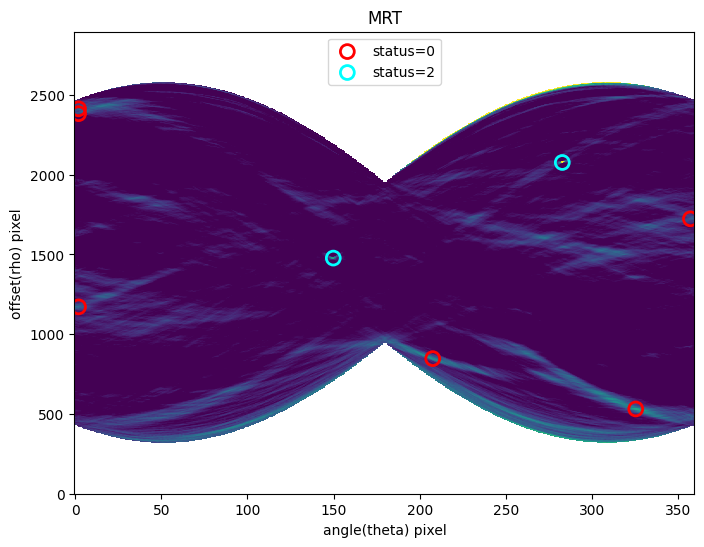

In [30]:
w.plot_mrt(show_sources=True)

Lastly, we generate the mask

<Axes: title={'center': 'Mask'}>

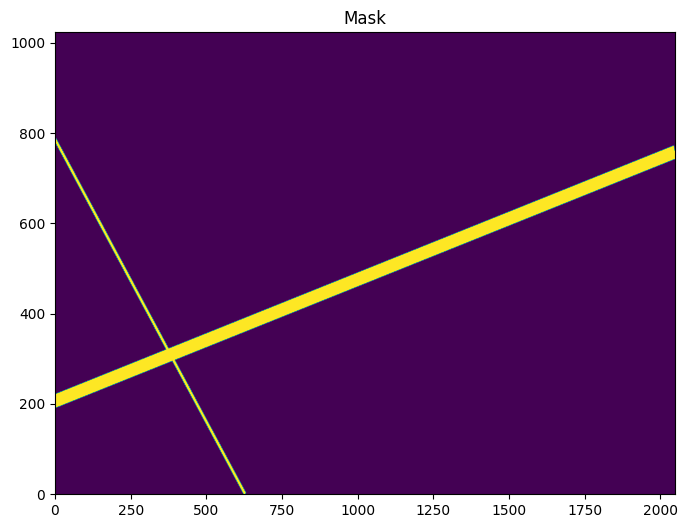

In [31]:
w.make_mask()
w.plot_mask()

If you're really feeling very confident, you can run everything in a single line by setting `execute=True`.

In [32]:
w = WfcWrapper('jc8m32j5q_flc.fits', binsize=2, extension=4, output_root='example3', processes=8,
               execute=True)

INFO:findsat_mrt:image type is flc


INFO:findsat_mrt:masking bad pixels


INFO:findsat_mrt:Subtracting median background


INFO:findsat_mrt:Rebinning the data by 2


INFO:findsat_mrt:Running the trailfinding pipeline


INFO:utils_findsat_mrt:Calculating median Radon Transform with 4 processes


INFO:findsat_mrt:Detection threshold: 5


INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/data/rt_line_kernel_width15.fits


INFO:findsat_mrt:{no} sources found using kernel: 2


INFO:findsat_mrt:2 sources found using kernel


INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/data/rt_line_kernel_width7.fits


INFO:findsat_mrt:{no} sources found using kernel: 4


INFO:findsat_mrt:4 sources found using kernel


INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/data/rt_line_kernel_width3.fits


INFO:findsat_mrt:{no} sources found using kernel: 8


INFO:findsat_mrt:8 sources found using kernel


INFO:findsat_mrt:Removing duplicate sources


INFO:findsat_mrt:8 final sources found


INFO:findsat_mrt:Filtering sources...
Min SNR : 5
Max Width: 75
Min Length: 25
Check persistence: True


INFO:findsat_mrt:Min persistence: 0.5


INFO:utils_findsat_mrt:amplitude of feature: 24.781228782083772
baseline noise: 1.1392404204749706
snr of feature = 20.752413570220774


INFO:utils_findsat_mrt:width of feature = 27.93697135868217


INFO:utils_findsat_mrt:breaking into 21.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 21


INFO:utils_findsat_mrt:amplitude of feature: 26.777939266096766
baseline noise: 5.266821168373301
snr of feature = 4.08426969704144


INFO:utils_findsat_mrt:width of feature = 26.912252404115833


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.08426969704144, 26.912252404115833, 255.94771205201673


INFO:utils_findsat_mrt:Checking persistence, step 2 of 21


INFO:utils_findsat_mrt:amplitude of feature: 36.86109099480041
baseline noise: 4.031873465370958
snr of feature = 8.142422576351603


INFO:utils_findsat_mrt:width of feature = 26.299791363903836


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 8.142422576351603, 26.299791363903836, 255.3153709824764


INFO:utils_findsat_mrt:Checking persistence, step 3 of 21


INFO:utils_findsat_mrt:amplitude of feature: 29.884373215737874
baseline noise: 4.432935911817287
snr of feature = 5.7414403930524545


INFO:utils_findsat_mrt:width of feature = 24.522434144873472


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.7414403930524545, 24.522434144873472, 253.71933453180375


INFO:utils_findsat_mrt:Checking persistence, step 4 of 21


INFO:utils_findsat_mrt:amplitude of feature: 35.338171095058804
baseline noise: 5.139947037197364
snr of feature = 5.875201405640844


INFO:utils_findsat_mrt:width of feature = 24.328122083921244


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.875201405640844, 24.328122083921244, 252.1528345263356


INFO:utils_findsat_mrt:Checking persistence, step 5 of 21


INFO:utils_findsat_mrt:amplitude of feature: 35.827924719714396
baseline noise: 4.373673374850432
snr of feature = 7.191723900950792


INFO:utils_findsat_mrt:width of feature = 31.80533203666792


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.191723900950792, 31.80533203666792, 250.32894672821345


INFO:utils_findsat_mrt:Checking persistence, step 6 of 21


INFO:utils_findsat_mrt:amplitude of feature: 28.98748795205496
baseline noise: 4.047251630718669
snr of feature = 6.162264814977087


INFO:utils_findsat_mrt:width of feature = 22.328341449863046


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.162264814977087, 22.328341449863046, 250.78695422770954


INFO:utils_findsat_mrt:Checking persistence, step 7 of 21


INFO:utils_findsat_mrt:amplitude of feature: 26.176049037358098
baseline noise: 5.473593475770235
snr of feature = 3.7822420779385055


INFO:utils_findsat_mrt:width of feature = 18.610593335348995


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.7822420779385055, 18.610593335348995, 250.01554635050337


INFO:utils_findsat_mrt:Checking persistence, step 8 of 21


INFO:utils_findsat_mrt:amplitude of feature: 38.773673376342536
baseline noise: 4.532406342910618
snr of feature = 7.554765491622466


INFO:utils_findsat_mrt:width of feature = 24.568512312437377


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.554765491622466, 24.568512312437377, 249.70351180160577


INFO:utils_findsat_mrt:Checking persistence, step 9 of 21


INFO:utils_findsat_mrt:amplitude of feature: 29.60885136170824
baseline noise: 8.783011700036266
snr of feature = 2.3711501672696147


INFO:utils_findsat_mrt:width of feature = 20.19012908962668


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.3711501672696147, 20.19012908962668, 249.57377404180238


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 21


INFO:utils_findsat_mrt:amplitude of feature: 41.80623636545298
baseline noise: 4.939912133819193
snr of feature = 7.462951411472038


INFO:utils_findsat_mrt:width of feature = 42.53203134793276


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.462951411472038, 42.53203134793276, 249.78357415447687


INFO:utils_findsat_mrt:Checking persistence, step 11 of 21


INFO:utils_findsat_mrt:amplitude of feature: 27.730559231566154
baseline noise: 5.385939821448101
snr of feature = 4.148694592007217


INFO:utils_findsat_mrt:width of feature = 29.08177986641519


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.148694592007217, 29.08177986641519, 250.48055834836185


INFO:utils_findsat_mrt:Checking persistence, step 12 of 21


INFO:utils_findsat_mrt:amplitude of feature: 32.561900539500186
baseline noise: 4.5295217241865995
snr of feature = 6.188816506967426


INFO:utils_findsat_mrt:width of feature = 28.09886146195248


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.188816506967426, 28.09886146195248, 249.0269336127743


INFO:utils_findsat_mrt:Checking persistence, step 13 of 21


INFO:utils_findsat_mrt:amplitude of feature: 26.97240172562028
baseline noise: 3.8596124486331966
snr of feature = 5.988370486568414


INFO:utils_findsat_mrt:width of feature = 23.44420709235706


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.988370486568414, 23.44420709235706, 250.06034393794346


INFO:utils_findsat_mrt:Checking persistence, step 14 of 21


INFO:utils_findsat_mrt:amplitude of feature: 28.68602494941817
baseline noise: 5.694566385833712
snr of feature = 4.037437972587337


INFO:utils_findsat_mrt:width of feature = 21.804636480148332


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.037437972587337, 21.804636480148332, 251.089147339524


INFO:utils_findsat_mrt:Checking persistence, step 15 of 21


INFO:utils_findsat_mrt:amplitude of feature: 35.83959172421478
baseline noise: 4.547749129001824
snr of feature = 6.880731919810436


INFO:utils_findsat_mrt:width of feature = 27.597328312013047


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.880731919810436, 27.597328312013047, 251.16204416559495


INFO:utils_findsat_mrt:Checking persistence, step 16 of 21


INFO:utils_findsat_mrt:amplitude of feature: 29.653511720250755
baseline noise: 4.689231761741343
snr of feature = 5.323746239669532


INFO:utils_findsat_mrt:width of feature = 34.20544765839057


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.323746239669532, 34.20544765839057, 251.01088333237297


INFO:utils_findsat_mrt:Checking persistence, step 17 of 21


INFO:utils_findsat_mrt:amplitude of feature: 27.925070312484305
baseline noise: 6.539005857808222
snr of feature = 3.2705375893093898


INFO:utils_findsat_mrt:width of feature = 20.67192262702821


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.2705375893093898, 20.67192262702821, 252.99250047723368


INFO:utils_findsat_mrt:Checking persistence, step 18 of 21


INFO:utils_findsat_mrt:amplitude of feature: 33.60054527635417
baseline noise: 4.936877710060228
snr of feature = 5.8060315141863725


INFO:utils_findsat_mrt:width of feature = 25.624363360386155


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.8060315141863725, 25.624363360386155, 254.44205498923287


INFO:utils_findsat_mrt:Checking persistence, step 19 of 21


INFO:utils_findsat_mrt:amplitude of feature: 28.422250393722546
baseline noise: 3.9568555503182568
snr of feature = 6.183039671851679


INFO:utils_findsat_mrt:width of feature = 24.644950933499302


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.183039671851679, 24.644950933499302, 255.1339854488413


INFO:utils_findsat_mrt:Checking persistence, step 20 of 21


INFO:utils_findsat_mrt:amplitude of feature: 28.481791025926363
baseline noise: 6.130826230606326
snr of feature = 3.6456692710909824


INFO:utils_findsat_mrt:width of feature = 27.528715120165543


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.6456692710909824, 27.528715120165543, 256.08658854547815


INFO:utils_findsat_mrt:Checking persistence, step 21 of 21


INFO:utils_findsat_mrt:amplitude of feature: 31.705863786725068
baseline noise: 5.038364135503358
snr of feature = 5.29288851182994


INFO:utils_findsat_mrt:width of feature = 29.3261044453607


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.29288851182994, 29.3261044453607, 257.26469437207624


INFO:utils_findsat_mrt:Number of sections analyzed: 21
Number of sections that passed: 20
persistance score: 0.9523809523809523


INFO:utils_findsat_mrt:amplitude of feature: 140.6325310562624
baseline noise: 1.6349383069861778
snr of feature = 85.0170261197821


INFO:utils_findsat_mrt:width of feature = 5.852792378744823


INFO:utils_findsat_mrt:breaking into 10.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 10


INFO:utils_findsat_mrt:amplitude of feature: 433.35799221899043
baseline noise: 5.146599100327714
snr of feature = 83.20278785487605


INFO:utils_findsat_mrt:width of feature = 3.9196903857742313


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 83.20278785487605, 3.9196903857742313, 252.12346347777913


INFO:utils_findsat_mrt:Checking persistence, step 2 of 10


INFO:utils_findsat_mrt:amplitude of feature: 382.87756197996185
baseline noise: 6.7085814104331645
snr of feature = 56.07280549424531


INFO:utils_findsat_mrt:width of feature = 3.963505073451529


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 56.07280549424531, 3.963505073451529, 251.94556991306192


INFO:utils_findsat_mrt:Checking persistence, step 3 of 10


INFO:utils_findsat_mrt:amplitude of feature: 294.4385404166353
baseline noise: 5.670862529053957
snr of feature = 50.92129749365571


INFO:utils_findsat_mrt:width of feature = 3.9409384384177315


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 50.92129749365571, 3.9409384384177315, 251.76604610986263


INFO:utils_findsat_mrt:Checking persistence, step 4 of 10


INFO:utils_findsat_mrt:amplitude of feature: 209.99469753845483
baseline noise: 4.176245406945087
snr of feature = 49.28313163523247


INFO:utils_findsat_mrt:width of feature = 4.040644251356582


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 49.28313163523247, 4.040644251356582, 251.53667204446884


INFO:utils_findsat_mrt:Checking persistence, step 5 of 10


INFO:utils_findsat_mrt:amplitude of feature: 231.35124981013368
baseline noise: 4.221398902077043
snr of feature = 53.80440374784353


INFO:utils_findsat_mrt:width of feature = 4.0823911470658345


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 53.80440374784353, 4.0823911470658345, 251.24883549025523


INFO:utils_findsat_mrt:Checking persistence, step 6 of 10


INFO:utils_findsat_mrt:amplitude of feature: 209.89648284455865
baseline noise: 4.617413792211489
snr of feature = 44.45758562912545


INFO:utils_findsat_mrt:width of feature = 4.000327266785064


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 44.45758562912545, 4.000327266785064, 250.96659870829532


INFO:utils_findsat_mrt:Checking persistence, step 7 of 10


INFO:utils_findsat_mrt:amplitude of feature: 155.9266668195209
baseline noise: 5.862285931168757
snr of feature = 25.598270478498133


INFO:utils_findsat_mrt:width of feature = 4.121455894765404


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 25.598270478498133, 4.121455894765404, 250.65087811069012


INFO:utils_findsat_mrt:Checking persistence, step 8 of 10


INFO:utils_findsat_mrt:amplitude of feature: 157.05851550614148
baseline noise: 4.338156976834571
snr of feature = 35.20397241151531


INFO:utils_findsat_mrt:width of feature = 3.9598865146421076


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 35.20397241151531, 3.9598865146421076, 250.3121777727571


INFO:utils_findsat_mrt:Checking persistence, step 9 of 10


INFO:utils_findsat_mrt:amplitude of feature: 170.627447731048
baseline noise: 5.29262014663969
snr of feature = 31.238748106527197


INFO:utils_findsat_mrt:width of feature = 4.038551384055381


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 31.238748106527197, 4.038551384055381, 249.89181733506314


INFO:utils_findsat_mrt:Checking persistence, step 10 of 10


INFO:utils_findsat_mrt:amplitude of feature: 158.2991830792352
baseline noise: 7.87008105556901
snr of feature = 19.11404736006116


INFO:utils_findsat_mrt:width of feature = 3.7413829072455655


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 19.11404736006116, 3.7413829072455655, 249.45429170495117


INFO:utils_findsat_mrt:Number of sections analyzed: 10
Number of sections that passed: 10
persistance score: 1.0


INFO:utils_findsat_mrt:amplitude of feature: 9.516165693052654
baseline noise: 1.6769988058063947
snr of feature = 4.674521448735767


INFO:utils_findsat_mrt:width of feature = 77.80569657005722


INFO:utils_findsat_mrt:amplitude of feature: 8.662488481692705
baseline noise: 1.310166879396368
snr of feature = 5.6117443647207494


INFO:utils_findsat_mrt:width of feature = 153.5992941626944


INFO:utils_findsat_mrt:amplitude of feature: 23.16941167211695
baseline noise: 2.171206884893149
snr of feature = 9.671213247031123


INFO:utils_findsat_mrt:width of feature = 183.82199492799182


INFO:utils_findsat_mrt:amplitude of feature: 15.82572897769589
baseline noise: 1.6913642253460386
snr of feature = 8.356783560003512


INFO:utils_findsat_mrt:width of feature = 79.72093191943699


INFO:utils_findsat_mrt:amplitude of feature: 6.643006846505017
baseline noise: 1.6379596760811124
snr of feature = 3.0556595766744947


INFO:utils_findsat_mrt:width of feature = 127.90245994123578


INFO:utils_findsat_mrt:amplitude of feature: 7.968046280696431
baseline noise: 1.7889030634523286
snr of feature = 3.4541520686533085


INFO:utils_findsat_mrt:width of feature = 108.52591914378449


INFO:findsat_mrt:Wrote diagnostic plot to ./example3_diagnostic.png


INFO:findsat_mrt:wrote catalog ./example3_catalog.fits


We'll plot the image and mask together to check that everything looks ok

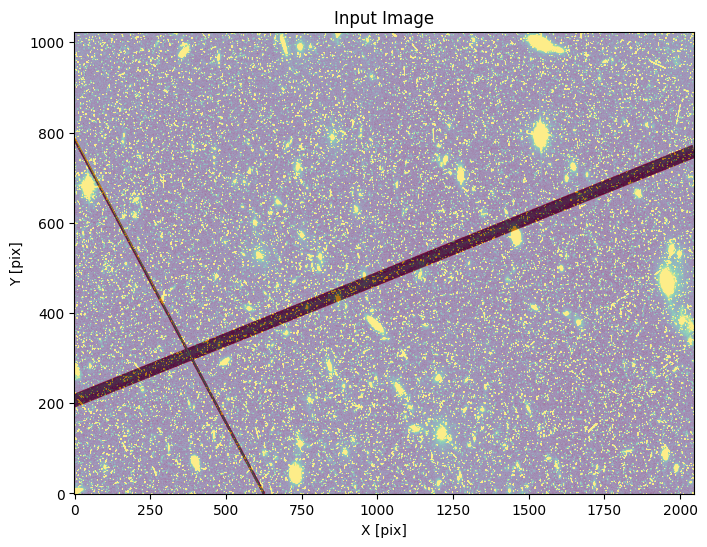

In [33]:
w.plot_image(overlay_mask=True)

<a id="example4"></a>
## Example 4: Finding trails in a DRC image

Applying `TrailFinder` to a DRC image (that shows both chips together) can boost sensitivity by increasing the number of pixels over which we search for trails. The DRC files also remove the distortion in the original FLC files (though this does not appear to create signficant curvature to most trails). 

Here, we demonstrate the steps that go into preparing a DRC image to be analyzed. The subsequent example will illustrate how to do all of this in a single line.

There are no DQ arrays for the DRC files, so we ignore the pre-processing steps that incorporated those.

In [34]:
# Read in the image files and header information
image_file = 'hst_13498_32_acs_wfc_f606w_jc8m32j5_drc.fits'
ext = 1
with fits.open(image_file) as h:
    image = h[ext].data  # image data
    wht = h[ext+1].data
    image = image*wht  # wht is effective exposure time, so this turns it into counts
    
    header = h[0].header  # primary header
    image_header = h[1].header  # image header

In [35]:
# Flag anything with wht == 0 as bad
image[wht == 0] = np.nan

# Subtract the background from the image. 
median = np.nanmedian(image)
image = image - np.nanmedian(image)

In [36]:
# Let's rebin the images
binsize = 2
image_rebin = block_reduce(image, binsize, func=np.nansum)

Setting up `TrailFinder` is essentially the same as earlier examples at this point. We'll use the default settings. In fact, about all the steps from here on out are the same.

In [37]:
s4 = TrailFinder(image=image_rebin, processes=8, output_root='example4')

We can do a quick plot of our image to make sure things look ok

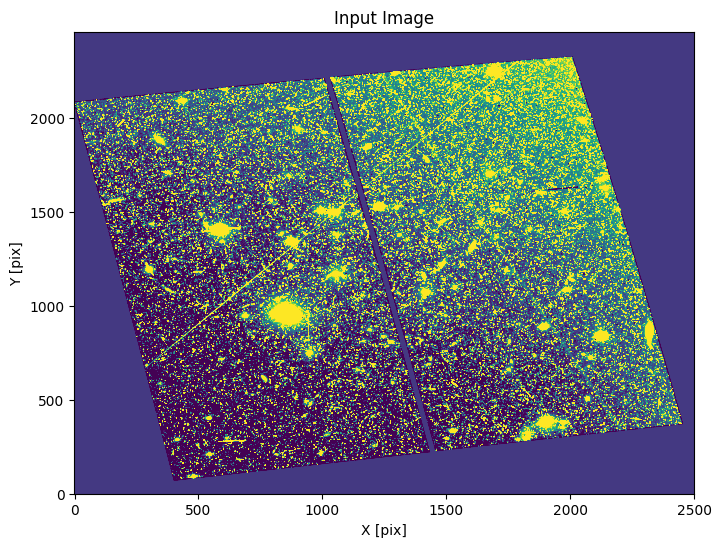

In [38]:
s4.plot_image()

Now run the MRT calculation and plot the results

INFO:utils_findsat_mrt:Calculating median Radon Transform with 4 processes


<Axes: title={'center': 'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

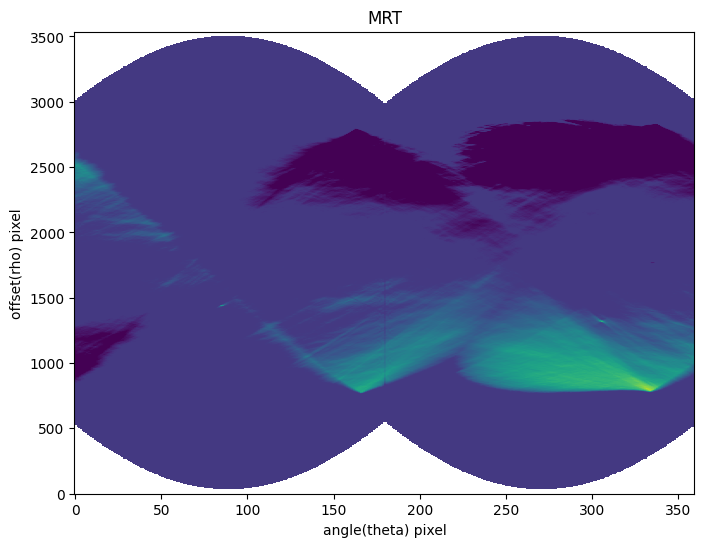

In [39]:
s4.run_mrt()
s4.plot_mrt(scale=[-1, 5])  # adjusted scale manually due to varying background in image

This example has a clear gradient in the background due to the cluster. This causes some large scale variation in the RT, but you can see the "point source" signals from the satellite trails around `x,y = (90,700)` and `x,y = (300,700)`. This is a case where we may have wanted to explore some different background subtraction methods, but we'll proceed with the simpler approach here. Now we'll try to pull the sources out.

In [40]:
s4.find_mrt_sources()

INFO:findsat_mrt:Detection threshold: 5


INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/data/rt_line_kernel_width15.fits


INFO:findsat_mrt:{no} sources found using kernel: 55


INFO:findsat_mrt:55 sources found using kernel


INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/data/rt_line_kernel_width7.fits


INFO:findsat_mrt:{no} sources found using kernel: 71


INFO:findsat_mrt:71 sources found using kernel


INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/data/rt_line_kernel_width3.fits


INFO:findsat_mrt:{no} sources found using kernel: 115


INFO:findsat_mrt:115 sources found using kernel


INFO:findsat_mrt:Removing duplicate sources


INFO:findsat_mrt:132 final sources found


<QTable length=132>
  id      xcentroid      ...                endpoints                 status
int64      float64       ...               float64[2,2]               int64 
----- ------------------ ... ---------------------------------------- ------
    1 166.32721664352064 ...                 0.0 .. 2368.735307497048      0
    2  333.6432083897028 ...  1963.5706136247031 .. 165.0363681938561      0
    3 175.61780594508227 ...                 0.0 .. 2176.756667052565      0
    4  154.4295030351749 ...                0.0 .. 2423.1683636377707      0
    5 346.41221469032826 ...                1990.8877699962811 .. 0.0      0
    6 351.51267050606936 ...                1995.3460964660758 .. 0.0      0
    7 147.42261939121974 ...                            0.0 .. 2456.0      0
    8 226.48971570716517 ... 496.09359477085275 .. 1595.2668978852591      0
    9 144.34893766213352 ...                            0.0 .. 2456.0      0
  ...                ... ...                                      ...    ...
  212  74.47261186395733 ...              145.4783116145602 .. 2456.0      0
  213  58.14747054402052 ...              422.2405064760989 .. 2456.0      0
  215  60.96466060690007 ...              417.8687561098286 .. 2456.0      0
  216 244.18585438830888 ...                -0.0 .. 540.0506679898153      0
  218   66.9021755856019 ...             406.31078430335106 .. 2456.0      0
  223 13.377747524368615 ...             1349.3182311977105 .. 2456.0      0
  225 7.6336927636439675 ...              1485.458787994728 .. 2456.0      0
  227 12.478478699525901 ...             1472.3774417774928 .. 2456.0      0
  228  4.156294160223314 ...             1592.7662772328247 .. 2456.0      0
  239  2.671522424698597 ...             1914.2325596773271 .. 2456.0      0

And below we plot the MRT with the sources overlaid

<Axes: title={'center': 'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

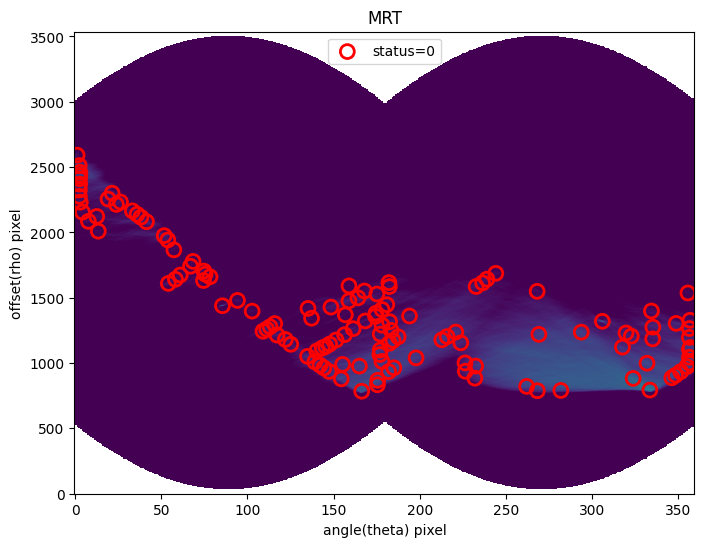

In [41]:
s4.plot_mrt(show_sources=True)

It's clearly shredding those large-scale features quite a bit, but we'll try to filter these out.

In [42]:
s4.filter_sources()

INFO:findsat_mrt:Filtering sources...
Min SNR : 5
Max Width: 75
Min Length: 25
Check persistence: True


INFO:findsat_mrt:Min persistence: 0.5


INFO:utils_findsat_mrt:amplitude of feature: 16.208835198871853
baseline noise: 1.6171182976367977
snr of feature = 9.023283530066353


INFO:utils_findsat_mrt:width of feature = 144.7908838325057


INFO:utils_findsat_mrt:amplitude of feature: 25.227178394960067
baseline noise: 2.2101418855350974
snr of feature = 10.414280033361893


INFO:utils_findsat_mrt:width of feature = 141.51878387086435


INFO:utils_findsat_mrt:amplitude of feature: 12.313618016377385
baseline noise: 1.2333628246766977
snr of feature = 8.983775876822914


INFO:utils_findsat_mrt:width of feature = 186.60217277783065


INFO:utils_findsat_mrt:amplitude of feature: 12.244242075355178
baseline noise: 1.2254661877146675
snr of feature = 8.991497275162745


INFO:utils_findsat_mrt:width of feature = 128.71095985194881


INFO:utils_findsat_mrt:amplitude of feature: 9.549145763088873
baseline noise: 1.9098647898918828
snr of feature = 3.999906702101906


INFO:utils_findsat_mrt:width of feature = 176.87815231464845


INFO:utils_findsat_mrt:amplitude of feature: 11.743986322461815
baseline noise: 1.20902614269512
snr of feature = 8.713591714636145


INFO:utils_findsat_mrt:width of feature = 183.09024482896018


INFO:utils_findsat_mrt:amplitude of feature: 7.126072262289259
baseline noise: 0.5795737566565923
snr of feature = 11.295367380672454


INFO:utils_findsat_mrt:width of feature = 201.5858778057126


INFO:utils_findsat_mrt:amplitude of feature: -2.628710199221418
baseline noise: 1.186183219698367
snr of feature = -3.2161080645617877


INFO:utils_findsat_mrt:width of feature = 21.880281771971255


INFO:utils_findsat_mrt:amplitude of feature: 6.129748340828595
baseline noise: 0.44126069078532787
snr of feature = 12.89144437479635


INFO:utils_findsat_mrt:width of feature = 202.45860248379833


INFO:utils_findsat_mrt:amplitude of feature: 6.019521662884993
baseline noise: 0.5681637794092109
snr of feature = 9.594694489578732


INFO:utils_findsat_mrt:width of feature = 195.43977360487457


INFO:utils_findsat_mrt:amplitude of feature: 8.85014297679589
baseline noise: 1.0216787372880454
snr of feature = 7.662354078433502


INFO:utils_findsat_mrt:width of feature = 180.09990886640855


INFO:utils_findsat_mrt:amplitude of feature: 7.687096819311278
baseline noise: 0.3271071515015278
snr of feature = 22.50024077439155


INFO:utils_findsat_mrt:width of feature = 228.92702169840746


INFO:utils_findsat_mrt:amplitude of feature: 5.635154628727749
baseline noise: 2.5606353285910846
snr of feature = 1.200686121060561


INFO:utils_findsat_mrt:width of feature = 150.4592740474087


INFO:utils_findsat_mrt:amplitude of feature: 9.48580227815917
baseline noise: 0.411539099254521
snr of feature = 22.049577294945113


INFO:utils_findsat_mrt:width of feature = 157.9850820685816


INFO:utils_findsat_mrt:amplitude of feature: 2.6022727856369716
baseline noise: 0.9864262893865097
snr of feature = 1.6380813382978763


INFO:utils_findsat_mrt:width of feature = 17.883528702264783


INFO:utils_findsat_mrt:amplitude of feature: 5.426860220375108
baseline noise: 1.3846764753528684
snr of feature = 2.919226127527108


INFO:utils_findsat_mrt:width of feature = 163.92419200071197


INFO:utils_findsat_mrt:amplitude of feature: 2.598950011844938
baseline noise: 1.8113597356891298
snr of feature = 0.4348061076096351


INFO:utils_findsat_mrt:width of feature = 1.6882192999352696


INFO:utils_findsat_mrt:amplitude of feature: 2.0257336489247724
baseline noise: 1.2558614911870958
snr of feature = 0.6130231423928442


INFO:utils_findsat_mrt:width of feature = 17.13096701145338


INFO:utils_findsat_mrt:amplitude of feature: 4.632990731521555
baseline noise: 0.9209726625677349
snr of feature = 4.030540991960021


INFO:utils_findsat_mrt:width of feature = 125.57862481994812


INFO:utils_findsat_mrt:amplitude of feature: 3.0884021125453853
baseline noise: 0.6870985810414099
snr of feature = 3.4948457146635477


INFO:utils_findsat_mrt:width of feature = 35.45586915857095


INFO:utils_findsat_mrt:amplitude of feature: 6.608151788144106
baseline noise: 0.49576046901678417
snr of feature = 12.329323738235338


INFO:utils_findsat_mrt:width of feature = 77.42557447870496


INFO:utils_findsat_mrt:amplitude of feature: 0.32277991748839785
baseline noise: 1.0126869718035238
snr of feature = -0.6812638786953586


INFO:utils_findsat_mrt:width of feature = 15.361548571338346


INFO:utils_findsat_mrt:amplitude of feature: 4.516873138451977
baseline noise: 0.954072622645131
snr of feature = 3.734307463858583


INFO:utils_findsat_mrt:width of feature = 24.284607414255362


INFO:utils_findsat_mrt:amplitude of feature: 6.204105269783913
baseline noise: 0.18301296164047778
snr of feature = 32.89981351141483


INFO:utils_findsat_mrt:width of feature = 243.3557537253561


INFO:utils_findsat_mrt:amplitude of feature: 4.385891063569865
baseline noise: 0.7787096913581202
snr of feature = 4.632254371870712


INFO:utils_findsat_mrt:width of feature = 28.817814510626107


INFO:utils_findsat_mrt:amplitude of feature: 4.270886737274579
baseline noise: 0.5159286252435286
snr of feature = 7.278057328683082


INFO:utils_findsat_mrt:width of feature = 45.45061601738706


INFO:utils_findsat_mrt:breaking into 5.0 sections for persistence check
Section size for persistence check: 508.0


INFO:utils_findsat_mrt:Checking persistence, step 1 of 5


INFO:utils_findsat_mrt:amplitude of feature: 8.949238944363803
baseline noise: 0.8849399845233371
snr of feature = 9.11282019218988


INFO:utils_findsat_mrt:width of feature = 264.49364784686134


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 9.11282019218988, 264.49364784686134, 238.84726281154113


INFO:utils_findsat_mrt:Checking persistence, step 2 of 5


INFO:utils_findsat_mrt:amplitude of feature: 11.088655564176268
baseline noise: 1.9792430946295323
snr of feature = 4.602472780763599


INFO:utils_findsat_mrt:width of feature = 206.70270857244967


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.602472780763599, 206.70270857244967, 246.38823435016818


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 5


INFO:utils_findsat_mrt:amplitude of feature: 6.849422467929518
baseline noise: 2.9885461442153876
snr of feature = 1.2918911528895813


INFO:utils_findsat_mrt:width of feature = 264.2224612017005


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.2918911528895813, 264.2224612017005, 238.89046216809544


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 5


INFO:utils_findsat_mrt:amplitude of feature: 4.693806168076719
baseline noise: 2.562756592609259
snr of feature = 0.8315458368591072


INFO:utils_findsat_mrt:width of feature = 264.0443695367405


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.8315458368591072, 264.0443695367405, 238.7979417883919


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 5


INFO:utils_findsat_mrt:amplitude of feature: 13.69451063432102
baseline noise: 5.846673031878386
snr of feature = 1.3422740693131123


INFO:utils_findsat_mrt:width of feature = 264.3175853948122


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.3422740693131123, 264.3175853948122, 238.7461279952012


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 5
Number of sections that passed: 1
persistance score: 0.2


INFO:utils_findsat_mrt:amplitude of feature: 4.854115647071067
baseline noise: 0.8107677786002321
snr of feature = 4.987060383000867


INFO:utils_findsat_mrt:width of feature = 27.15865947816468


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 6.723873615264893
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 112.19680468879801


INFO:utils_findsat_mrt:amplitude of feature: 6.647937509119317
baseline noise: 0.7643681549116709
snr of feature = 7.697297848426903


INFO:utils_findsat_mrt:width of feature = 64.24026054637008


INFO:utils_findsat_mrt:breaking into 6.0 sections for persistence check
Section size for persistence check: 411.0


INFO:utils_findsat_mrt:Checking persistence, step 1 of 6


INFO:utils_findsat_mrt:amplitude of feature: 1.8633409111612558
baseline noise: 3.2746762295236453
snr of feature = -0.43098468961241126


INFO:utils_findsat_mrt:width of feature = 36.90825927367038


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.43098468961241126, 36.90825927367038, 256.5216460853902


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 6


INFO:utils_findsat_mrt:amplitude of feature: 12.359043851023547
baseline noise: 2.0801798996216574
snr of feature = 4.94133413810575


INFO:utils_findsat_mrt:width of feature = 74.96152830281096


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.94133413810575, 74.96152830281096, 256.19397752752553


INFO:utils_findsat_mrt:Checking persistence, step 3 of 6


INFO:utils_findsat_mrt:amplitude of feature: 13.271287761344476
baseline noise: 3.3681882870487936
snr of feature = 2.9401858299830317


INFO:utils_findsat_mrt:width of feature = 93.64149359990813


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.9401858299830317, 93.64149359990813, 256.75266363100883


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 6


INFO:utils_findsat_mrt:amplitude of feature: 5.803428742286107
baseline noise: 2.327070736087684
snr of feature = 1.49387723900604


INFO:utils_findsat_mrt:width of feature = 40.20771850651022


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.49387723900604, 40.20771850651022, 292.1497601583514


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 6


INFO:utils_findsat_mrt:amplitude of feature: 15.878314422301312
baseline noise: 1.8188329684157685
snr of feature = 7.729946453594124


INFO:utils_findsat_mrt:width of feature = 70.49780303640054


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.729946453594124, 70.49780303640054, 243.5167459869277


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 6


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 74.96152830281096


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 74.96152830281096, 256.19397752752553


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 6
Number of sections that passed: 1
persistance score: 0.16666666666666666


INFO:utils_findsat_mrt:amplitude of feature: 27.457955719865488
baseline noise: 0.6745885402617887
snr of feature = 39.703264406492636


INFO:utils_findsat_mrt:width of feature = 21.31708124452439


INFO:utils_findsat_mrt:breaking into 27.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 21.31708124452439


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 21.31708124452439, 250.63512944217945


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 21.31708124452439


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 21.31708124452439, 250.63512944217945


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 7.062621884775279
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 250.63512944217945


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 27


INFO:utils_findsat_mrt:amplitude of feature: 29.68065576651282
baseline noise: 5.287240961994009
snr of feature = 4.61363780842687


INFO:utils_findsat_mrt:width of feature = 18.111655242698703


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.61363780842687, 18.111655242698703, 250.63512944217945


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 27


INFO:utils_findsat_mrt:amplitude of feature: 37.359898791411915
baseline noise: 4.516387288806887
snr of feature = 7.272075976301278


INFO:utils_findsat_mrt:width of feature = 24.358749201533556


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.272075976301278, 24.358749201533556, 250.63512944217945


INFO:utils_findsat_mrt:Checking persistence, step 6 of 27


INFO:utils_findsat_mrt:amplitude of feature: 35.707057554055076
baseline noise: 4.853095166495136
snr of feature = 6.357584454673368


INFO:utils_findsat_mrt:width of feature = 27.22825798960983


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.357584454673368, 27.22825798960983, 249.1545594578342


INFO:utils_findsat_mrt:Checking persistence, step 7 of 27


INFO:utils_findsat_mrt:amplitude of feature: 40.04910646213475
baseline noise: 4.115851641882331
snr of feature = 8.730454337712429


INFO:utils_findsat_mrt:width of feature = 25.28725409956658


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 8.730454337712429, 25.28725409956658, 249.12102942603806


INFO:utils_findsat_mrt:Checking persistence, step 8 of 27


INFO:utils_findsat_mrt:amplitude of feature: 38.61225526669003
baseline noise: 4.693597332982592
snr of feature = 7.226580281047138


INFO:utils_findsat_mrt:width of feature = 28.65072173111662


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.226580281047138, 28.65072173111662, 248.48127156429837


INFO:utils_findsat_mrt:Checking persistence, step 9 of 27


INFO:utils_findsat_mrt:amplitude of feature: 30.6953289424385
baseline noise: 4.746493859135491
snr of feature = 5.466947994330543


INFO:utils_findsat_mrt:width of feature = 17.85819750635352


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.466947994330543, 17.85819750635352, 250.12278763367132


INFO:utils_findsat_mrt:Checking persistence, step 10 of 27


INFO:utils_findsat_mrt:amplitude of feature: 30.6845527392812
baseline noise: 7.673135196355944
snr of feature = 2.998958959286112


INFO:utils_findsat_mrt:width of feature = 17.414974013626818


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.998958959286112, 17.414974013626818, 248.93135617336858


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 27


INFO:utils_findsat_mrt:amplitude of feature: 40.07788916155248
baseline noise: 8.056422577010501
snr of feature = 3.974650817835351


INFO:utils_findsat_mrt:width of feature = 18.31473945626223


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.974650817835351, 18.31473945626223, 250.5160346827516


INFO:utils_findsat_mrt:Checking persistence, step 12 of 27


INFO:utils_findsat_mrt:amplitude of feature: 56.57464620635993
baseline noise: 5.756235730594666
snr of feature = 8.828410241377538


INFO:utils_findsat_mrt:width of feature = 34.2877460658479


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 8.828410241377538, 34.2877460658479, 248.8809202644687


INFO:utils_findsat_mrt:Checking persistence, step 13 of 27


INFO:utils_findsat_mrt:amplitude of feature: 40.85852052084063
baseline noise: 7.540522037402295
snr of feature = 4.418526770185842


INFO:utils_findsat_mrt:width of feature = 34.73229465247604


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.418526770185842, 34.73229465247604, 252.40433575899834


INFO:utils_findsat_mrt:Checking persistence, step 14 of 27


INFO:utils_findsat_mrt:amplitude of feature: 34.24356070448815
baseline noise: 4.3607603621397875
snr of feature = 6.852658220293749


INFO:utils_findsat_mrt:width of feature = 22.898386426714552


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.852658220293749, 22.898386426714552, 250.13960327625998


INFO:utils_findsat_mrt:Checking persistence, step 15 of 27


INFO:utils_findsat_mrt:amplitude of feature: 34.968404716732046
baseline noise: 4.5813098299157
snr of feature = 6.632839955156557


INFO:utils_findsat_mrt:width of feature = 27.18971904468947


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.632839955156557, 27.18971904468947, 249.2008630759753


INFO:utils_findsat_mrt:Checking persistence, step 16 of 27


INFO:utils_findsat_mrt:amplitude of feature: 30.304462557378173
baseline noise: 4.002322901849715
snr of feature = 6.571718549588453


INFO:utils_findsat_mrt:width of feature = 22.280394770290087


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.571718549588453, 22.280394770290087, 251.45444314230696


INFO:utils_findsat_mrt:Checking persistence, step 17 of 27


INFO:utils_findsat_mrt:amplitude of feature: 35.816841375254484
baseline noise: 4.542149778032527
snr of feature = 6.885438201196631


INFO:utils_findsat_mrt:width of feature = 21.284819807743958


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.885438201196631, 21.284819807743958, 251.06681439838533


INFO:utils_findsat_mrt:Checking persistence, step 18 of 27


INFO:utils_findsat_mrt:amplitude of feature: 55.106147385296346
baseline noise: 4.4913790838214
snr of feature = 11.269315583669323


INFO:utils_findsat_mrt:width of feature = 118.86560415485607


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 11.269315583669323, 118.86560415485607, 229.78199459064137


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 27


INFO:utils_findsat_mrt:amplitude of feature: 27.901806064195288
baseline noise: 6.971862629192374
snr of feature = 3.002059069174094


INFO:utils_findsat_mrt:width of feature = 18.959107895291424


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.002059069174094, 18.959107895291424, 251.25362606315488


INFO:utils_findsat_mrt:Checking persistence, step 20 of 27


INFO:utils_findsat_mrt:amplitude of feature: 28.224503869378562
baseline noise: 6.015738899215303
snr of feature = 3.6917767446755683


INFO:utils_findsat_mrt:width of feature = 18.730897771147852


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.6917767446755683, 18.730897771147852, 251.62765947582415


INFO:utils_findsat_mrt:Checking persistence, step 21 of 27


INFO:utils_findsat_mrt:amplitude of feature: 33.598604194983864
baseline noise: 4.186340411742233
snr of feature = 7.025769739303428


INFO:utils_findsat_mrt:width of feature = 27.156544987826607


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.025769739303428, 27.156544987826607, 251.7066019885634


INFO:utils_findsat_mrt:Checking persistence, step 22 of 27


INFO:utils_findsat_mrt:amplitude of feature: 32.14689943441085
baseline noise: 5.6041582235169605
snr of feature = 4.736258355360397


INFO:utils_findsat_mrt:width of feature = 23.278329168406003


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.736258355360397, 23.278329168406003, 251.8017195436081


INFO:utils_findsat_mrt:Checking persistence, step 23 of 27


INFO:utils_findsat_mrt:amplitude of feature: 32.1416552611957
baseline noise: 6.73897901423844
snr of feature = 3.7695140752457106


INFO:utils_findsat_mrt:width of feature = 31.282569108262976


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.7695140752457106, 31.282569108262976, 250.90445985407385


INFO:utils_findsat_mrt:Checking persistence, step 24 of 27


INFO:utils_findsat_mrt:amplitude of feature: 16.194217798888406
baseline noise: 1.32901768168403
snr of feature = 11.185103345177716


INFO:utils_findsat_mrt:width of feature = 18.27211775322496


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 11.185103345177716, 18.27211775322496, 252.21516101635927


INFO:utils_findsat_mrt:Checking persistence, step 25 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 18.27211775322496


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 18.27211775322496, 252.21516101635927


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 18.27211775322496


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 18.27211775322496, 252.21516101635927


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 27 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 18.27211775322496


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 18.27211775322496, 252.21516101635927


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 27
Number of sections that passed: 18
persistance score: 0.6666666666666666


INFO:utils_findsat_mrt:amplitude of feature: 3.5887250299117177
baseline noise: 0.5414887506549044
snr of feature = 5.627515392649115


INFO:utils_findsat_mrt:width of feature = 22.718385561727757


INFO:utils_findsat_mrt:breaking into 3.0 sections for persistence check
Section size for persistence check: 837.0


INFO:utils_findsat_mrt:Checking persistence, step 1 of 3


INFO:utils_findsat_mrt:amplitude of feature: 7.307823061420181
baseline noise: 2.006444205518268
snr of feature = 2.6421760651612827


INFO:utils_findsat_mrt:width of feature = 45.20699498604239


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.6421760651612827, 45.20699498604239, 246.9678358746854


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 3


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 2.1789027203540345
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 247.01833386915197


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 3


INFO:utils_findsat_mrt:amplitude of feature: 6.492774856405883
baseline noise: 2.3372895895233374
snr of feature = 1.777907746438047


INFO:utils_findsat_mrt:width of feature = 47.03378435728678


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.777907746438047, 47.03378435728678, 247.30469593037395


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 3
Number of sections that passed: 0
persistance score: 0.0


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.5872572501359514
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:amplitude of feature: 193.83099838779967
baseline noise: 0.30657938353310943
snr of feature = 631.2375502032629


INFO:utils_findsat_mrt:width of feature = 4.312032902235842


INFO:utils_findsat_mrt:breaking into 28.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 28


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 4.312032902235842


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 4.312032902235842, 250.5595950212118


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 28


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 4.312032902235842


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 4.312032902235842, 250.5595950212118


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 28


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 4.312032902235842


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 4.312032902235842, 250.5595950212118


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 28


INFO:utils_findsat_mrt:amplitude of feature: 17.65091290014282
baseline noise: 1.6039313301056832
snr of feature = 10.004780921001025


INFO:utils_findsat_mrt:width of feature = 382.2898825606669


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 10.004780921001025, 382.2898825606669, 250.5595950212118


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 28


INFO:utils_findsat_mrt:amplitude of feature: 221.904907434985
baseline noise: 5.455747950805355
snr of feature = 39.673599557000855


INFO:utils_findsat_mrt:width of feature = 5.775791080855129


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 39.673599557000855, 5.775791080855129, 250.5595950212118


INFO:utils_findsat_mrt:Checking persistence, step 6 of 28


INFO:utils_findsat_mrt:amplitude of feature: 298.9851807841877
baseline noise: 5.071652791635539
snr of feature = 57.95221795886565


INFO:utils_findsat_mrt:width of feature = 4.135294460323905


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 57.95221795886565, 4.135294460323905, 249.96436283139508


INFO:utils_findsat_mrt:Checking persistence, step 7 of 28


INFO:utils_findsat_mrt:amplitude of feature: 380.2738881811077
baseline noise: 4.010201480480363
snr of feature = 93.82662904397424


INFO:utils_findsat_mrt:width of feature = 4.05520566828352


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 93.82662904397424, 4.05520566828352, 250.06035430052142


INFO:utils_findsat_mrt:Checking persistence, step 8 of 28


INFO:utils_findsat_mrt:amplitude of feature: 484.8423997007795
baseline noise: 3.498179823402426
snr of feature = 137.59847811631604


INFO:utils_findsat_mrt:width of feature = 4.0794484054179065


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 137.59847811631604, 4.0794484054179065, 250.10632100591553


INFO:utils_findsat_mrt:Checking persistence, step 9 of 28


INFO:utils_findsat_mrt:amplitude of feature: 551.3565504509718
baseline noise: 4.177309180025891
snr of feature = 130.98844679424818


INFO:utils_findsat_mrt:width of feature = 4.089617246308421


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 130.98844679424818, 4.089617246308421, 250.15913987479405


INFO:utils_findsat_mrt:Checking persistence, step 10 of 28


INFO:utils_findsat_mrt:amplitude of feature: 543.4618485727668
baseline noise: 6.175156292690906
snr of feature = 87.00778843703505


INFO:utils_findsat_mrt:width of feature = 4.250366228446296


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 87.00778843703505, 4.250366228446296, 250.21382458254672


INFO:utils_findsat_mrt:Checking persistence, step 11 of 28


INFO:utils_findsat_mrt:amplitude of feature: 479.53845312371726
baseline noise: 22.678554866332345
snr of feature = 20.14501809970354


INFO:utils_findsat_mrt:width of feature = 4.817003755844837


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 20.14501809970354, 4.817003755844837, 250.26160908599968


INFO:utils_findsat_mrt:Checking persistence, step 12 of 28


INFO:utils_findsat_mrt:amplitude of feature: 331.6946686457172
baseline noise: 5.261175655325375
snr of feature = 62.04573167215488


INFO:utils_findsat_mrt:width of feature = 4.290761604727663


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 62.04573167215488, 4.290761604727663, 250.31666685548052


INFO:utils_findsat_mrt:Checking persistence, step 13 of 28


INFO:utils_findsat_mrt:amplitude of feature: 258.19226821385064
baseline noise: 7.152433067247031
snr of feature = 35.09852280843905


INFO:utils_findsat_mrt:width of feature = 4.323289391886249


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 35.09852280843905, 4.323289391886249, 250.36279567648126


INFO:utils_findsat_mrt:Checking persistence, step 14 of 28


INFO:utils_findsat_mrt:amplitude of feature: 240.20403339375832
baseline noise: 7.875230671770966
snr of feature = 29.501206047814943


INFO:utils_findsat_mrt:width of feature = 111.96104625166845


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 29.501206047814943, 111.96104625166845, 254.6860850683675


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 28


INFO:utils_findsat_mrt:amplitude of feature: 163.3142047609277
baseline noise: 5.932929143417804
snr of feature = 26.52674114473693


INFO:utils_findsat_mrt:width of feature = 4.124666576229913


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 26.52674114473693, 4.124666576229913, 250.48619361303315


INFO:utils_findsat_mrt:Checking persistence, step 16 of 28


INFO:utils_findsat_mrt:amplitude of feature: 297.33388699709286
baseline noise: 4.8747711308205846
snr of feature = 59.9944301009762


INFO:utils_findsat_mrt:width of feature = 161.87939827389997


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 59.9944301009762, 161.87939827389997, 254.61086018926306


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 28


INFO:utils_findsat_mrt:amplitude of feature: 198.1656456873186
baseline noise: 6.31578366795601
snr of feature = 30.376256076144443


INFO:utils_findsat_mrt:width of feature = 4.2287105066045


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 30.376256076144443, 4.2287105066045, 250.60527709125307


INFO:utils_findsat_mrt:Checking persistence, step 18 of 28


INFO:utils_findsat_mrt:amplitude of feature: 185.9307558170077
baseline noise: 5.743850498801111
snr of feature = 31.370403069476865


INFO:utils_findsat_mrt:width of feature = 3.9914326082343337


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 31.370403069476865, 3.9914326082343337, 250.65624997780057


INFO:utils_findsat_mrt:Checking persistence, step 19 of 28


INFO:utils_findsat_mrt:amplitude of feature: 185.05671383041994
baseline noise: 4.493177223081445
snr of feature = 40.18615951309106


INFO:utils_findsat_mrt:width of feature = 4.194118722281644


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 40.18615951309106, 4.194118722281644, 250.7273522494833


INFO:utils_findsat_mrt:Checking persistence, step 20 of 28


INFO:utils_findsat_mrt:amplitude of feature: 171.9748177962788
baseline noise: 4.5497232900852005
snr of feature = 36.79896200963429


INFO:utils_findsat_mrt:width of feature = 4.177139815509349


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 36.79896200963429, 4.177139815509349, 250.74549468506154


INFO:utils_findsat_mrt:Checking persistence, step 21 of 28


INFO:utils_findsat_mrt:amplitude of feature: 184.9893269351905
baseline noise: 5.578110126704582
snr of feature = 32.16344115358617


INFO:utils_findsat_mrt:width of feature = 4.317624910486927


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 32.16344115358617, 4.317624910486927, 250.81618869225983


INFO:utils_findsat_mrt:Checking persistence, step 22 of 28


INFO:utils_findsat_mrt:amplitude of feature: 224.25115425688423
baseline noise: 4.85924145574895
snr of feature = 45.14941576767575


INFO:utils_findsat_mrt:width of feature = 4.097894629571897


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 45.14941576767575, 4.097894629571897, 250.90597867922799


INFO:utils_findsat_mrt:Checking persistence, step 23 of 28


INFO:utils_findsat_mrt:amplitude of feature: 271.3856267781482
baseline noise: 4.1780712931431285
snr of feature = 63.95476207491592


INFO:utils_findsat_mrt:width of feature = 4.237051374277428


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 63.95476207491592, 4.237051374277428, 250.95307796993004


INFO:utils_findsat_mrt:Checking persistence, step 24 of 28


INFO:utils_findsat_mrt:amplitude of feature: 308.96849334656
baseline noise: 4.673267081420448
snr of feature = 65.11402429254022


INFO:utils_findsat_mrt:width of feature = 4.047572065886186


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 65.11402429254022, 4.047572065886186, 251.0022462220313


INFO:utils_findsat_mrt:Checking persistence, step 25 of 28


INFO:utils_findsat_mrt:amplitude of feature: 357.83703581700246
baseline noise: 7.619933478076398
snr of feature = 45.96065088318016


INFO:utils_findsat_mrt:width of feature = 3.9943425978005394


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 45.96065088318016, 3.9943425978005394, 251.11322587012162


INFO:utils_findsat_mrt:Checking persistence, step 26 of 28


INFO:utils_findsat_mrt:amplitude of feature: 470.24590048682256
baseline noise: 7.9472098542238365
snr of feature = 58.17119455916885


INFO:utils_findsat_mrt:width of feature = 4.713140388263525


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 58.17119455916885, 4.713140388263525, 251.189963912302


INFO:utils_findsat_mrt:Checking persistence, step 27 of 28


INFO:utils_findsat_mrt:amplitude of feature: -29.276462652260598
baseline noise: 8.373441744479981
snr of feature = -4.496347564794429


INFO:utils_findsat_mrt:width of feature = 4.17492336141521


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -4.496347564794429, 4.17492336141521, 251.19703727445378


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 28 of 28


INFO:utils_findsat_mrt:amplitude of feature: -0.10159524289963784
baseline noise: 16.075753200108387
snr of feature = -1.0063197812030948


INFO:utils_findsat_mrt:width of feature = 4.699349659435484


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0063197812030948, 4.699349659435484, 251.1914511941041


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 28
Number of sections that passed: 20
persistance score: 0.7142857142857143


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 1.7180476188659668
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 1.9855501262092048


INFO:utils_findsat_mrt:breaking into 29.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 29


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.9855501262092048


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.9855501262092048, 241.40772958994867


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 29


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.9855501262092048


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.9855501262092048, 241.40772958994867


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 29


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 1.1397313440766417
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 241.54575742332824


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 29


INFO:utils_findsat_mrt:amplitude of feature: 26.020181403760898
baseline noise: 3.593294737444401
snr of feature = 6.241315646226894


INFO:utils_findsat_mrt:width of feature = 209.72980244438924


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.241315646226894, 209.72980244438924, 241.40772958994867


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 29


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 7.684388668232086
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 241.52896968363936


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 29


INFO:utils_findsat_mrt:amplitude of feature: 5.602682179250607
baseline noise: 4.461009856369363
snr of feature = 0.2559223941752071


INFO:utils_findsat_mrt:width of feature = 1.9786325795431026


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.2559223941752071, 1.9786325795431026, 241.41972893828807


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 29


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 3.747395180616644
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 241.5657529807199


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 29


INFO:utils_findsat_mrt:amplitude of feature: 68.32520261895704
baseline noise: 4.057750177424913
snr of feature = 15.838198418197559


INFO:utils_findsat_mrt:width of feature = 21.598014039003886


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 15.838198418197559, 21.598014039003886, 241.40772958994867


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 29


INFO:utils_findsat_mrt:amplitude of feature: 122.99740753187854
baseline noise: 5.58176307883671
snr of feature = 21.035583702616112


INFO:utils_findsat_mrt:width of feature = 19.616376141960558


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 21.035583702616112, 19.616376141960558, 247.28201815940545


INFO:utils_findsat_mrt:Checking persistence, step 10 of 29


INFO:utils_findsat_mrt:amplitude of feature: 99.42506891543513
baseline noise: 16.528994043583417
snr of feature = 5.01519176867464


INFO:utils_findsat_mrt:width of feature = 212.64913308796878


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.01519176867464, 212.64913308796878, 244.65729866183656


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 29


INFO:utils_findsat_mrt:amplitude of feature: 77.11802945577689
baseline noise: 5.87231606843715
snr of feature = 12.1324725299231


INFO:utils_findsat_mrt:width of feature = 19.623827753671208


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 12.1324725299231, 19.623827753671208, 260.90794094015604


INFO:utils_findsat_mrt:Checking persistence, step 12 of 29


INFO:utils_findsat_mrt:amplitude of feature: 28.73115540509265
baseline noise: 4.901518238262898
snr of feature = 4.861684892000931


INFO:utils_findsat_mrt:width of feature = 16.068238084538507


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.861684892000931, 16.068238084538507, 268.8902355703124


INFO:utils_findsat_mrt:Checking persistence, step 13 of 29


INFO:utils_findsat_mrt:amplitude of feature: 178.18407322679235
baseline noise: 9.224313967734876
snr of feature = 18.316783215537846


INFO:utils_findsat_mrt:width of feature = 119.1183617798732


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 18.316783215537846, 119.1183617798732, 284.95847365485093


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 29


INFO:utils_findsat_mrt:amplitude of feature: 44.14279934870657
baseline noise: 5.193064898714143
snr of feature = 7.500336546850549


INFO:utils_findsat_mrt:width of feature = 19.04134050713958


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.500336546850549, 19.04134050713958, 284.9028734031539


INFO:utils_findsat_mrt:Checking persistence, step 15 of 29


INFO:utils_findsat_mrt:amplitude of feature: 222.63955453245882
baseline noise: 5.454342856679604
snr of feature = 39.818767793411745


INFO:utils_findsat_mrt:width of feature = 160.44996688380454


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 39.818767793411745, 160.44996688380454, 301.6799709835137


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 29


INFO:utils_findsat_mrt:amplitude of feature: 56.47262960896627
baseline noise: 3.4042524356407102
snr of feature = 15.588848998895593


INFO:utils_findsat_mrt:width of feature = 22.85451504491732


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 15.588848998895593, 22.85451504491732, 299.037701730142


INFO:utils_findsat_mrt:Checking persistence, step 17 of 29


INFO:utils_findsat_mrt:amplitude of feature: -0.10195337103780133
baseline noise: 8.095759721638098
snr of feature = -1.0125934284790226


INFO:utils_findsat_mrt:width of feature = 15.597108702265928


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0125934284790226, 15.597108702265928, 299.3468457354301


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 29


INFO:utils_findsat_mrt:amplitude of feature: 36.38116879068215
baseline noise: 4.588668269932069
snr of feature = 6.928480912223525


INFO:utils_findsat_mrt:width of feature = 16.365828787259147


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.928480912223525, 16.365828787259147, 314.6644824446422


INFO:utils_findsat_mrt:Checking persistence, step 19 of 29


INFO:utils_findsat_mrt:amplitude of feature: 33.950982306730396
baseline noise: 5.520929542321476
snr of feature = 5.149504724969641


INFO:utils_findsat_mrt:width of feature = 14.034937480916597


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.149504724969641, 14.034937480916597, 322.87486962161336


INFO:utils_findsat_mrt:Checking persistence, step 20 of 29


INFO:utils_findsat_mrt:amplitude of feature: 22.71226606629217
baseline noise: 5.449018562758263
snr of feature = 3.16813886844154


INFO:utils_findsat_mrt:width of feature = 15.181136919586834


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.16813886844154, 15.181136919586834, 323.54607152871046


INFO:utils_findsat_mrt:Checking persistence, step 21 of 29


INFO:utils_findsat_mrt:amplitude of feature: 4.132892245574009
baseline noise: 5.744226544874436
snr of feature = -0.2805137100204061


INFO:utils_findsat_mrt:width of feature = 15.181136919586834


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.2805137100204061, 15.181136919586834, 323.54607152871046


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 29


INFO:utils_findsat_mrt:amplitude of feature: 30.8246468135508
baseline noise: 4.645166582475513
snr of feature = 5.6358539066910405


INFO:utils_findsat_mrt:width of feature = 100.34620716726374


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.6358539066910405, 100.34620716726374, 338.7272084482973


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 29


INFO:utils_findsat_mrt:amplitude of feature: 1.4900014807284592
baseline noise: 4.185725319038907
snr of feature = -0.6440278883205405


INFO:utils_findsat_mrt:width of feature = 15.181136919586834


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.6440278883205405, 15.181136919586834, 323.54607152871046


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 29


INFO:utils_findsat_mrt:amplitude of feature: 38.60588821337316
baseline noise: 4.171417390719236
snr of feature = 8.254861021403745


INFO:utils_findsat_mrt:width of feature = 217.5231094864048


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 8.254861021403745, 217.5231094864048, 311.5295944098062


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 29


INFO:utils_findsat_mrt:amplitude of feature: -13.421684988714787
baseline noise: 11.357054281872669
snr of feature = -2.1817928008090566


INFO:utils_findsat_mrt:width of feature = 15.181136919586834


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.1817928008090566, 15.181136919586834, 323.54607152871046


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 29


INFO:utils_findsat_mrt:amplitude of feature: 65.34328746728053
baseline noise: 5.771296005123321
snr of feature = 10.322116801715541


INFO:utils_findsat_mrt:width of feature = 211.97695141261718


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 10.322116801715541, 211.97695141261718, 331.2870322244619


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 27 of 29


INFO:utils_findsat_mrt:amplitude of feature: -34.80422672696763
baseline noise: 13.60094924495564
snr of feature = -3.558955709644746


INFO:utils_findsat_mrt:width of feature = 15.181136919586834


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -3.558955709644746, 15.181136919586834, 323.54607152871046


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 28 of 29


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise


INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 15.181136919586834


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 15.181136919586834, 323.54607152871046


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 29 of 29


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 15.181136919586834


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 15.181136919586834, 323.54607152871046


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 29
Number of sections that passed: 8
persistance score: 0.27586206896551724


INFO:utils_findsat_mrt:amplitude of feature: 7.487663013637275
baseline noise: 0.03359208084920904
snr of feature = 221.89964849895804


INFO:utils_findsat_mrt:width of feature = 110.67347598727008


INFO:utils_findsat_mrt:amplitude of feature: 2.6768425413722285
baseline noise: 1.732652686405193e-05
snr of feature = 154492.89034371256


INFO:utils_findsat_mrt:width of feature = 35.46114108454151


INFO:utils_findsat_mrt:breaking into 25.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 35.46114108454151


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 35.46114108454151, 254.25821967272282


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 25


INFO:utils_findsat_mrt:amplitude of feature: 4.663204119896746
baseline noise: 2.0732424050283003
snr of feature = 1.249232462439959


INFO:utils_findsat_mrt:width of feature = 33.530330213658544


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.249232462439959, 33.530330213658544, 254.25821967272282


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 25


INFO:utils_findsat_mrt:amplitude of feature: 10.323771531872552
baseline noise: 3.633078357879145
snr of feature = 1.8416044232800923


INFO:utils_findsat_mrt:width of feature = 28.16995579928019


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.8416044232800923, 28.16995579928019, 254.25821967272282


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 25


INFO:utils_findsat_mrt:amplitude of feature: 30.49454037243998
baseline noise: 3.6379428960002387
snr of feature = 7.382358174441774


INFO:utils_findsat_mrt:width of feature = 56.05792064347759


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.382358174441774, 56.05792064347759, 254.25821967272282


INFO:utils_findsat_mrt:Checking persistence, step 5 of 25


INFO:utils_findsat_mrt:amplitude of feature: 10.929307003650987
baseline noise: 4.166590755712788
snr of feature = 1.623081469824191


INFO:utils_findsat_mrt:width of feature = 24.4122265677361


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.623081469824191, 24.4122265677361, 259.418990969253


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 25


INFO:utils_findsat_mrt:amplitude of feature: 1112.4965592788988
baseline noise: 5.848707299900801
snr of feature = 189.21238407635266


INFO:utils_findsat_mrt:width of feature = 95.43061946874386


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 189.21238407635266, 95.43061946874386, 227.37340160089713


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 25


INFO:utils_findsat_mrt:amplitude of feature: 198.20264422537247
baseline noise: 4.66562221109526
snr of feature = 41.48150305741196


INFO:utils_findsat_mrt:width of feature = 153.02740434017792


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 41.48150305741196, 153.02740434017792, 227.40412072526934


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 25


INFO:utils_findsat_mrt:amplitude of feature: 22.95378377307253
baseline noise: 4.477677099193103
snr of feature = 4.126270444380391


INFO:utils_findsat_mrt:width of feature = 41.486009290087594


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.126270444380391, 41.486009290087594, 253.95450982228138


INFO:utils_findsat_mrt:Checking persistence, step 9 of 25


INFO:utils_findsat_mrt:amplitude of feature: -1.3132735714479988
baseline noise: 9.551214258203734
snr of feature = -1.1374980746892995


INFO:utils_findsat_mrt:width of feature = 8.359585361006339


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.1374980746892995, 8.359585361006339, 252.11798145681


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 25


INFO:utils_findsat_mrt:amplitude of feature: 1.8614053346736732
baseline noise: 6.26027894554707
snr of feature = -0.7026641542869765


INFO:utils_findsat_mrt:width of feature = 8.656983318949074


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.7026641542869765, 8.656983318949074, 254.6724695747132


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 25


INFO:utils_findsat_mrt:amplitude of feature: 8.467417019830215
baseline noise: 16.662968357651824
snr of feature = -0.49184221934011646


INFO:utils_findsat_mrt:width of feature = 17.61314494355247


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.49184221934011646, 17.61314494355247, 252.32913345362755


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 25


INFO:utils_findsat_mrt:amplitude of feature: 26.276008401924543
baseline noise: 2.870890376459848
snr of feature = 8.152564172208487


INFO:utils_findsat_mrt:width of feature = 313.45214838023867


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 8.152564172208487, 313.45214838023867, 271.2185356240902


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 3.218973623309973
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 254.58158090549955


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 25


INFO:utils_findsat_mrt:amplitude of feature: 2.0187870399513113
baseline noise: 5.000287026174481
snr of feature = -0.5962657684681345


INFO:utils_findsat_mrt:width of feature = 17.690502018953055


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.5962657684681345, 17.690502018953055, 252.75201404855508


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 25


INFO:utils_findsat_mrt:amplitude of feature: 28.693071498588058
baseline noise: 6.609998408056597
snr of feature = 3.3408590633872928


INFO:utils_findsat_mrt:width of feature = 88.53455806187307


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.3408590633872928, 88.53455806187307, 286.61919827863716


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 25


INFO:utils_findsat_mrt:amplitude of feature: 2.4177557144765753
baseline noise: 5.09303578889608
snr of feature = -0.5252820096517277


INFO:utils_findsat_mrt:width of feature = 21.793631005535246


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.5252820096517277, 21.793631005535246, 255.7183558608003


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 25


INFO:utils_findsat_mrt:amplitude of feature: 19.706101749230896
baseline noise: 7.5464837561830285
snr of feature = 1.6112958545872678


INFO:utils_findsat_mrt:width of feature = 4.842837186040242


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.6112958545872678, 4.842837186040242, 258.5152072973286


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 25


INFO:utils_findsat_mrt:amplitude of feature: 3.0864496668947243
baseline noise: 7.2892733607758915
snr of feature = -0.5765764961562377


INFO:utils_findsat_mrt:width of feature = 25.48090852810418


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.5765764961562377, 25.48090852810418, 252.14537732336376


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 25


INFO:utils_findsat_mrt:amplitude of feature: 37.486949021120566
baseline noise: 4.679537952136855
snr of feature = 7.010822736035851


INFO:utils_findsat_mrt:width of feature = 81.4772599525927


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.010822736035851, 81.4772599525927, 254.75184820426017


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 25


INFO:utils_findsat_mrt:amplitude of feature: 9.295919351834218
baseline noise: 6.046934656984113
snr of feature = 0.5372944936816177


INFO:utils_findsat_mrt:width of feature = 20.152530447135575


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.5372944936816177, 20.152530447135575, 251.52489790955852


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 25


INFO:utils_findsat_mrt:amplitude of feature: 22.43042322865962
baseline noise: 3.9350472524725704
snr of feature = 4.700166170702412


INFO:utils_findsat_mrt:width of feature = 135.61442369109193


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.700166170702412, 135.61442369109193, 261.7737748262078


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 25


INFO:utils_findsat_mrt:amplitude of feature: 18.828337198878167
baseline noise: 4.619536821984704
snr of feature = 3.075806281978914


INFO:utils_findsat_mrt:width of feature = 138.1550968261099


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.075806281978914, 138.1550968261099, 259.25975998357137


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.9706750645364899
baseline noise: 2.2654625141479525
snr of feature = -0.5715333807226717


INFO:utils_findsat_mrt:width of feature = 222.73587473583336


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.5715333807226717, 222.73587473583336, 282.5077422018114


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 41.486009290087594


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 41.486009290087594, 253.95450982228138


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 41.486009290087594


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 41.486009290087594, 253.95450982228138


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 25
Number of sections that passed: 2
persistance score: 0.08


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 3.938347816467285
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 26.787279729985585


INFO:utils_findsat_mrt:breaking into 27.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 26.787279729985585


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 26.787279729985585, 250.1958501534885


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 27


INFO:utils_findsat_mrt:amplitude of feature: -2.2766187021100563
baseline noise: 12.630680186470657
snr of feature = -1.1802451387019248


INFO:utils_findsat_mrt:width of feature = 12.383063638202884


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.1802451387019248, 12.383063638202884, 250.62130169138027


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 27


INFO:utils_findsat_mrt:amplitude of feature: 34.36643460701184
baseline noise: 9.26403053333036
snr of feature = 2.7096633569338344


INFO:utils_findsat_mrt:width of feature = 154.02160856242358


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.7096633569338344, 154.02160856242358, 257.50174071676093


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 27


INFO:utils_findsat_mrt:amplitude of feature: 23.385447436563027
baseline noise: 4.425778692067986
snr of feature = 4.283917037802891


INFO:utils_findsat_mrt:width of feature = 36.87214059697067


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.283917037802891, 36.87214059697067, 250.1958501534885


INFO:utils_findsat_mrt:Checking persistence, step 5 of 27


INFO:utils_findsat_mrt:amplitude of feature: 7.396125833852132
baseline noise: 4.047652287228074
snr of feature = 0.8272631414486373


INFO:utils_findsat_mrt:width of feature = 36.08083206614174


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.8272631414486373, 36.08083206614174, 249.1421365123686


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 27


INFO:utils_findsat_mrt:amplitude of feature: 18.930722950380165
baseline noise: 4.000157955733811
snr of feature = 3.732493856460078


INFO:utils_findsat_mrt:width of feature = 100.4347146882817


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.732493856460078, 100.4347146882817, 256.23549593405755


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 27


INFO:utils_findsat_mrt:amplitude of feature: 28.394988228104147
baseline noise: 4.622528427536931
snr of feature = 5.14273955763083


INFO:utils_findsat_mrt:width of feature = 84.99534612897074


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.14273955763083, 84.99534612897074, 238.62979887869247


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 27


INFO:utils_findsat_mrt:amplitude of feature: 17.606818369023095
baseline noise: 4.318020870212711
snr of feature = 3.0775204424048463


INFO:utils_findsat_mrt:width of feature = 56.67432703556477


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.0775204424048463, 56.67432703556477, 254.99452425676017


INFO:utils_findsat_mrt:Checking persistence, step 9 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 5.405890276632968
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 253.01327053022337


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 27


INFO:utils_findsat_mrt:amplitude of feature: 1.4635453657464907
baseline noise: 9.750812986277825
snr of feature = -0.8499052983780823


INFO:utils_findsat_mrt:width of feature = 6.411180982345087


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.8499052983780823, 6.411180982345087, 257.8662721418122


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 27


INFO:utils_findsat_mrt:amplitude of feature: 544.4583651973948
baseline noise: 11.330405702157707
snr of feature = 47.052857021148924


INFO:utils_findsat_mrt:width of feature = 146.67405401007704


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 47.052857021148924, 146.67405401007704, 311.6688512923249


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 27


INFO:utils_findsat_mrt:amplitude of feature: 3.88188358811397
baseline noise: 5.31518856220825
snr of feature = -0.2696621121375228


INFO:utils_findsat_mrt:width of feature = 27.203681537600318


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.2696621121375228, 27.203681537600318, 255.17476662900384


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 27


INFO:utils_findsat_mrt:amplitude of feature: 24.869790303189205
baseline noise: 6.368827253234488
snr of feature = 2.9049246139560108


INFO:utils_findsat_mrt:width of feature = 165.45894209746024


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.9049246139560108, 165.45894209746024, 248.15420474029466


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 27


INFO:utils_findsat_mrt:amplitude of feature: 103.81222193526506
baseline noise: 6.69640063817748
snr of feature = 14.502689809718287


INFO:utils_findsat_mrt:width of feature = 152.3343622724912


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 14.502689809718287, 152.3343622724912, 229.6370099336244


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 27


INFO:utils_findsat_mrt:amplitude of feature: 2.983993767450716
baseline noise: 5.918703105144624
snr of feature = -0.49583655161601453


INFO:utils_findsat_mrt:width of feature = 29.227748784241186


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.49583655161601453, 29.227748784241186, 255.64220940836339


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 6.902432054487529
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 253.63232900470027


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 10.559849208801566
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 254.68845653664008


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 27


INFO:utils_findsat_mrt:amplitude of feature: 261.1534784160657
baseline noise: 6.746873086216899
snr of feature = 37.70733524683794


INFO:utils_findsat_mrt:width of feature = 73.09706624052257


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 37.70733524683794, 73.09706624052257, 244.92778157965049


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 27


INFO:utils_findsat_mrt:amplitude of feature: 30.82404241959049
baseline noise: 4.458694452977801
snr of feature = 5.913243942742976


INFO:utils_findsat_mrt:width of feature = 46.81181365239175


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.913243942742976, 46.81181365239175, 271.1948608579495


INFO:utils_findsat_mrt:Checking persistence, step 20 of 27


INFO:utils_findsat_mrt:amplitude of feature: 11.594867765222403
baseline noise: 5.633088539132333
snr of feature = 1.0583499947984778


INFO:utils_findsat_mrt:width of feature = 44.40728005978417


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.0583499947984778, 44.40728005978417, 272.7549980676665


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 27


INFO:utils_findsat_mrt:amplitude of feature: 13.549721406287318
baseline noise: 5.366081047360419
snr of feature = 1.5250683481481222


INFO:utils_findsat_mrt:width of feature = 28.360939409012985


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.5250683481481222, 28.360939409012985, 262.01014200961924


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 27


INFO:utils_findsat_mrt:amplitude of feature: 15.751672140815728
baseline noise: 4.531764037295202
snr of feature = 2.4758367847892546


INFO:utils_findsat_mrt:width of feature = 243.2922489572918


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.4758367847892546, 243.2922489572918, 273.5142301319308


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.7764884776649978
baseline noise: 4.907675529391075
snr of feature = -0.8417808037604023


INFO:utils_findsat_mrt:width of feature = 22.785863956891717


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.8417808037604023, 22.785863956891717, 272.4104485714398


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 27


INFO:utils_findsat_mrt:amplitude of feature: 9.655553054503315
baseline noise: 4.299955035343606
snr of feature = 1.245500935507282


INFO:utils_findsat_mrt:width of feature = 43.11175411980477


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.245500935507282, 43.11175411980477, 270.8652674829626


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 27


INFO:utils_findsat_mrt:amplitude of feature: 23.756168173080255
baseline noise: 7.535745466443528
snr of feature = 2.1524642490734105


INFO:utils_findsat_mrt:width of feature = 185.3701300191369


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.1524642490734105, 185.3701300191369, 318.0066745103412


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 9.369063124767468
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 271.3271940676131


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 27 of 27


INFO:utils_findsat_mrt:amplitude of feature: 4.254932857425047
baseline noise: 8.976392292838398
snr of feature = -0.5259863073475806


INFO:utils_findsat_mrt:width of feature = 243.75004559519186


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.5259863073475806, 243.75004559519186, 278.0201179185014


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 27
Number of sections that passed: 3
persistance score: 0.1111111111111111


INFO:utils_findsat_mrt:amplitude of feature: 4.380757458552296
baseline noise: 0.790838485417517
snr of feature = 4.539383248704075


INFO:utils_findsat_mrt:width of feature = 78.32988191088589


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.7108597755432129
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 1.219499829793449


INFO:utils_findsat_mrt:breaking into 31.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 31


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.219499829793449


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.219499829793449, 256.99914750356805


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 31


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.219499829793449


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.219499829793449, 256.99914750356805


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 31


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.219499829793449


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.219499829793449, 256.99914750356805


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 31


INFO:utils_findsat_mrt:amplitude of feature: 39.28747278833418
baseline noise: 5.5805885384443465
snr of feature = 6.040023201439254


INFO:utils_findsat_mrt:width of feature = 268.03173079785654


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.040023201439254, 268.03173079785654, 256.99914750356805


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 31


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 9.177071411443015
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 256.99914750356805


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 31


INFO:utils_findsat_mrt:amplitude of feature: -0.7038327653057053
baseline noise: 7.332846611845648
snr of feature = -1.095983565804952


INFO:utils_findsat_mrt:width of feature = 1.573896002549077


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.095983565804952, 1.573896002549077, 256.99914750356805


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 31


INFO:utils_findsat_mrt:amplitude of feature: 5.170042973666199
baseline noise: 3.5586651846599744
snr of feature = 0.45280398840336233


INFO:utils_findsat_mrt:width of feature = 3.688243454258753


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.45280398840336233, 3.688243454258753, 256.99914750356805


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 31


INFO:utils_findsat_mrt:amplitude of feature: 10.128551848220873
baseline noise: 4.103652089147707
snr of feature = 1.4681799597500687


INFO:utils_findsat_mrt:width of feature = 3.584457759074894


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.4681799597500687, 3.584457759074894, 256.99914750356805


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 31


INFO:utils_findsat_mrt:amplitude of feature: 14.719242937413277
baseline noise: 4.795268166878776
snr of feature = 2.0695348883885223


INFO:utils_findsat_mrt:width of feature = 37.740670679432924


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.0695348883885223, 37.740670679432924, 265.6193811499164


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 31


INFO:utils_findsat_mrt:amplitude of feature: 7.14945876630118
baseline noise: 3.6795951810862593
snr of feature = 0.943001448379595


INFO:utils_findsat_mrt:width of feature = 36.66832513867712


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.943001448379595, 36.66832513867712, 256.99914750356805


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 31


INFO:utils_findsat_mrt:amplitude of feature: 9.882326989120603
baseline noise: 6.048864690888697
snr of feature = 0.6337490577374272


INFO:utils_findsat_mrt:width of feature = 28.772450506735368


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.6337490577374272, 28.772450506735368, 258.84813589760984


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 31


INFO:utils_findsat_mrt:amplitude of feature: 82.68614411007088
baseline noise: 9.383969334619703
snr of feature = 7.811425225466366


INFO:utils_findsat_mrt:width of feature = 218.28782391882194


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.811425225466366, 218.28782391882194, 280.3490316062622


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 31


INFO:utils_findsat_mrt:amplitude of feature: 334.32831714693515
baseline noise: 12.019234027858765
snr of feature = 26.81610844518151


INFO:utils_findsat_mrt:width of feature = 180.16003129407576


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 26.81610844518151, 180.16003129407576, 273.9026674532665


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 31


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 4.868025020640913
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 256.99914750356805


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 31


INFO:utils_findsat_mrt:amplitude of feature: 74.89137420299078
baseline noise: 6.665682273477393
snr of feature = 10.235365132986004


INFO:utils_findsat_mrt:width of feature = 152.37136855473378


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 10.235365132986004, 152.37136855473378, 259.81706343098534


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 31


INFO:utils_findsat_mrt:amplitude of feature: 95.06491366905723
baseline noise: 7.625081906535997
snr of feature = 11.467395738735656


INFO:utils_findsat_mrt:width of feature = 159.4724682665227


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 11.467395738735656, 159.4724682665227, 256.99914750356805


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 31


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 5.940684807225725
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 256.99914750356805


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 31


INFO:utils_findsat_mrt:amplitude of feature: 18.146879715208968
baseline noise: 6.601441137861301
snr of feature = 1.7489269897645554


INFO:utils_findsat_mrt:width of feature = 296.18764693726155


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.7489269897645554, 296.18764693726155, 265.1447117449669


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 31


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 6.795093345721221
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 256.99914750356805


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 31


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 6.686993963688411
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 256.99914750356805


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 31


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 4.28180244019427
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 256.99914750356805


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 31


INFO:utils_findsat_mrt:amplitude of feature: -5.168020625784802
baseline noise: 5.144884128954164
snr of feature = -2.004496990845806


INFO:utils_findsat_mrt:width of feature = 1.0469877181539005


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.004496990845806, 1.0469877181539005, 256.99914750356805


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 31


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 7.115963286463437
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 256.99914750356805


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 31


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 58.508119661202905
baseline noise: 0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 918.6763172428847


INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 918.6763172428847, 257.00516910223706


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 31


INFO:utils_findsat_mrt:amplitude of feature: 62.89079184704092
baseline noise: 5.413225800176472
snr of feature = 10.617987900115061


INFO:utils_findsat_mrt:width of feature = 362.11887479781535


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 10.617987900115061, 362.11887479781535, 256.99914750356805


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 31


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 4.792421980936726
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 256.99914750356805


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 27 of 31


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 5.0418728945466125
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 256.99914750356805


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 28 of 31


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 6.501779831748258
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 256.99914750356805


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 29 of 31


INFO:utils_findsat_mrt:amplitude of feature: -3.264943184599346
baseline noise: 11.54195031550227
snr of feature = -1.2828762120223411


INFO:utils_findsat_mrt:width of feature = 0.732776499590841


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.2828762120223411, 0.732776499590841, 256.99914750356805


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 30 of 31


INFO:utils_findsat_mrt:amplitude of feature: 80.91018423796604
baseline noise: 2.944911605096537e-05
snr of feature = 2747456.1426164666


INFO:utils_findsat_mrt:width of feature = 227.17138325607993


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2747456.1426164666, 227.17138325607993, 256.99914750356805


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 31 of 31


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.219499829793449


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.219499829793449, 256.99914750356805


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 31
Number of sections that passed: 0
persistance score: 0.0


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 2.112293243408203
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 3.6236037896216544


INFO:utils_findsat_mrt:breaking into 30.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 30


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 3.6236037896216544


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 3.6236037896216544, 249.98781102337855


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 30


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 3.6236037896216544


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 3.6236037896216544, 249.98781102337855


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 30


INFO:utils_findsat_mrt:amplitude of feature: 31.148932334536397
baseline noise: 10.350389829159198
snr of feature = 2.009445329951089


INFO:utils_findsat_mrt:width of feature = 116.0923076263609


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.009445329951089, 116.0923076263609, 274.9878110233785


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 30


INFO:utils_findsat_mrt:amplitude of feature: -6.24079965414235
baseline noise: 10.987815267099057
snr of feature = -1.5679745702341075


INFO:utils_findsat_mrt:width of feature = 2.217025275447611


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.5679745702341075, 2.217025275447611, 249.98781102337855


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 30


INFO:utils_findsat_mrt:amplitude of feature: 17.980865608223922
baseline noise: 6.473093872116661
snr of feature = 1.7777853934233605


INFO:utils_findsat_mrt:width of feature = 238.37273982293527


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.7777853934233605, 238.37273982293527, 274.9878110233785


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 30


INFO:utils_findsat_mrt:amplitude of feature: 25.218599705826257
baseline noise: 3.532365284344985
snr of feature = 6.1392955359379275


INFO:utils_findsat_mrt:width of feature = 85.85250862968417


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.1392955359379275, 85.85250862968417, 251.26266477168116


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 30


INFO:utils_findsat_mrt:amplitude of feature: 0.25478521338742155
baseline noise: 3.805168546310445
snr of feature = -0.9330423316900205


INFO:utils_findsat_mrt:width of feature = 3.4062660159543157


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.9330423316900205, 3.4062660159543157, 250.06392175118145


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 30


INFO:utils_findsat_mrt:amplitude of feature: 3.366396346170326
baseline noise: 4.492426200869544
snr of feature = -0.25065071842054215


INFO:utils_findsat_mrt:width of feature = 0.447189798622162


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.25065071842054215, 0.447189798622162, 249.98878901946063


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 30


INFO:utils_findsat_mrt:amplitude of feature: -0.6237615714970026
baseline noise: 4.656883931233311
snr of feature = -1.1339439807192722


INFO:utils_findsat_mrt:width of feature = 2.8684302469897034


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.1339439807192722, 2.8684302469897034, 249.98781102337855


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 30


INFO:utils_findsat_mrt:amplitude of feature: -0.8239164420650802
baseline noise: 4.493919648457246
snr of feature = -1.183340270079802


INFO:utils_findsat_mrt:width of feature = 1.9443690541573915


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.183340270079802, 1.9443690541573915, 249.98781102337855


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 30


INFO:utils_findsat_mrt:amplitude of feature: -11.913912094341843
baseline noise: 11.327004197247167
snr of feature = -2.0518149271311574


INFO:utils_findsat_mrt:width of feature = 2.0438377621760537


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.0518149271311574, 2.0438377621760537, 249.98781102337855


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 30


INFO:utils_findsat_mrt:amplitude of feature: -39.93033933742464
baseline noise: 43.66997897386069
snr of feature = -1.9143658933594982


INFO:utils_findsat_mrt:width of feature = 3.0711597418332985


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.9143658933594982, 3.0711597418332985, 249.98781102337855


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 30


INFO:utils_findsat_mrt:amplitude of feature: 19.802075953371396
baseline noise: 5.512472453496168
snr of feature = 2.5922312756070736


INFO:utils_findsat_mrt:width of feature = 17.832160634126097


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.5922312756070736, 17.832160634126097, 249.98781102337855


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 30


INFO:utils_findsat_mrt:amplitude of feature: 5.704301120732175
baseline noise: 6.822631558372988
snr of feature = -0.1639148220261661


INFO:utils_findsat_mrt:width of feature = 6.437192887548349


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.1639148220261661, 6.437192887548349, 249.98781102337855


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 30


INFO:utils_findsat_mrt:amplitude of feature: 115.6254437560464
baseline noise: 5.27903219664631
snr of feature = 20.902772979771086


INFO:utils_findsat_mrt:width of feature = 232.78980222844913


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 20.902772979771086, 232.78980222844913, 274.9878110233785


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 30


INFO:utils_findsat_mrt:amplitude of feature: 4.540070340051479
baseline noise: 4.100228522023344
snr of feature = 0.10727251314545885


INFO:utils_findsat_mrt:width of feature = 5.082118420492463


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.10727251314545885, 5.082118420492463, 251.6144962695523


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 30


INFO:utils_findsat_mrt:amplitude of feature: 11.67195410008826
baseline noise: 6.186763756188978
snr of feature = 0.886600904780327


INFO:utils_findsat_mrt:width of feature = 266.14034820054053


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.886600904780327, 266.14034820054053, 249.98781102337855


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 30


INFO:utils_findsat_mrt:amplitude of feature: 29.19679088328748
baseline noise: 4.0113182942849015
snr of feature = 6.278602379892269


INFO:utils_findsat_mrt:width of feature = 225.5650522983071


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.278602379892269, 225.5650522983071, 249.98781102337855


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 30


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 9.284766314016741
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 249.98781102337855


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 30


INFO:utils_findsat_mrt:amplitude of feature: 14.403817411462338
baseline noise: 5.942582004993602
snr of feature = 1.4238314926674447


INFO:utils_findsat_mrt:width of feature = 154.36953933363853


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.4238314926674447, 154.36953933363853, 249.98781102337855


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 30


INFO:utils_findsat_mrt:amplitude of feature: 28.09469502633607
baseline noise: 6.8490597641659186
snr of feature = 3.1019783727580674


INFO:utils_findsat_mrt:width of feature = 344.1880451103593


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.1019783727580674, 344.1880451103593, 249.98781102337855


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 30


INFO:utils_findsat_mrt:amplitude of feature: 30.557131925611035
baseline noise: 6.882593428972355
snr of feature = 3.4397700141607146


INFO:utils_findsat_mrt:width of feature = 64.92304313030576


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.4397700141607146, 64.92304313030576, 249.98781102337855


INFO:utils_findsat_mrt:Checking persistence, step 23 of 30


INFO:utils_findsat_mrt:amplitude of feature: 0.06543493379253107
baseline noise: 7.063672611985879
snr of feature = -0.9907364146971508


INFO:utils_findsat_mrt:width of feature = 15.131572884156014


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.9907364146971508, 15.131572884156014, 251.49919199964543


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 30


INFO:utils_findsat_mrt:amplitude of feature: 7.437496250136633
baseline noise: 5.066914236905953
snr of feature = 0.4678551683318495


INFO:utils_findsat_mrt:width of feature = 48.05921098140513


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.4678551683318495, 48.05921098140513, 250.20905180052475


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 30


INFO:utils_findsat_mrt:amplitude of feature: 9.350226084491624
baseline noise: 4.33240482381145
snr of feature = 1.1582069231161383


INFO:utils_findsat_mrt:width of feature = 50.18179620865013


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.1582069231161383, 50.18179620865013, 267.2561509847749


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 30


INFO:utils_findsat_mrt:amplitude of feature: 7.505720298105032
baseline noise: 5.004037978614965
snr of feature = 0.4999327203712573


INFO:utils_findsat_mrt:width of feature = 31.908115082235554


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.4999327203712573, 31.908115082235554, 249.3223229157697


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 27 of 30


INFO:utils_findsat_mrt:amplitude of feature: 22.290882665369878
baseline noise: 6.8128491910249425
snr of feature = 2.271888462573818


INFO:utils_findsat_mrt:width of feature = 69.21889112105339


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.271888462573818, 69.21889112105339, 283.9564561976195


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 28 of 30


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 13.566074264328591
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 250.83908189100012


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 29 of 30


INFO:utils_findsat_mrt:amplitude of feature: 51.338205281866664
baseline noise: 11.951520102733163
snr of feature = 3.2955377090589724


INFO:utils_findsat_mrt:width of feature = 237.9051169882225


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.2955377090589724, 237.9051169882225, 243.18468348112052


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 30 of 30


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 64.92304313030576


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 64.92304313030576, 249.98781102337855


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 30
Number of sections that passed: 1
persistance score: 0.03333333333333333


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.6625971794128418
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 1.7775038885448566


INFO:utils_findsat_mrt:breaking into 29.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 29


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.7775038885448566


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.7775038885448566, 261.4216990409191


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 29


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 10.419905375603461
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 261.5184550611712


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 29


INFO:utils_findsat_mrt:amplitude of feature: 30.649088887848492
baseline noise: 8.85676773601302
snr of feature = 2.4605275650646727


INFO:utils_findsat_mrt:width of feature = 98.48056199729459


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.4605275650646727, 98.48056199729459, 273.766135660217


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 29


INFO:utils_findsat_mrt:amplitude of feature: 31.01278472681078
baseline noise: 4.2293525619696615
snr of feature = 6.332749935694116


INFO:utils_findsat_mrt:width of feature = 56.737703373730625


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.332749935694116, 56.737703373730625, 261.79559808567234


INFO:utils_findsat_mrt:Checking persistence, step 5 of 29


INFO:utils_findsat_mrt:amplitude of feature: 7.214042170475302
baseline noise: 3.9163977384926723
snr of feature = 0.8420095843615246


INFO:utils_findsat_mrt:width of feature = 33.80254051682573


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.8420095843615246, 33.80254051682573, 259.9602202925815


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 29


INFO:utils_findsat_mrt:amplitude of feature: 3.0609353623106443
baseline noise: 3.601077361537199
snr of feature = -0.14999455579482002


INFO:utils_findsat_mrt:width of feature = 37.69074896110385


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.14999455579482002, 37.69074896110385, 262.611611489336


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 29


INFO:utils_findsat_mrt:amplitude of feature: 9.430715348023071
baseline noise: 5.6772599530448495
snr of feature = 0.6611385467676452


INFO:utils_findsat_mrt:width of feature = 63.2780650231316


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.6611385467676452, 63.2780650231316, 260.9258480174418


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 29


INFO:utils_findsat_mrt:amplitude of feature: 7.687237344115811
baseline noise: 4.675744706263349
snr of feature = 0.6440669512641368


INFO:utils_findsat_mrt:width of feature = 49.012068832245205


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.6440669512641368, 49.012068832245205, 262.5895245661445


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 29


INFO:utils_findsat_mrt:amplitude of feature: 18.88891682211454
baseline noise: 4.7509928667390815
snr of feature = 2.975783031448591


INFO:utils_findsat_mrt:width of feature = 201.13721458409637


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.975783031448591, 201.13721458409637, 250.99349314243779


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 29


INFO:utils_findsat_mrt:amplitude of feature: 55.289311796063046
baseline noise: 7.281512040656659
snr of feature = 6.593108613616598


INFO:utils_findsat_mrt:width of feature = 125.78860489137543


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.593108613616598, 125.78860489137543, 239.09398060384544


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 29


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 19.040228553061542
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 260.1315035387075


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 29


INFO:utils_findsat_mrt:amplitude of feature: 4.518869179993981
baseline noise: 5.506030296267578
snr of feature = -0.17928726562633923


INFO:utils_findsat_mrt:width of feature = 35.174754275994104


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.17928726562633923, 35.174754275994104, 261.81774949204043


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 29


INFO:utils_findsat_mrt:amplitude of feature: 3.3283735431064176
baseline noise: 6.838359538178496
snr of feature = -0.5132789487706606


INFO:utils_findsat_mrt:width of feature = 24.303557893464102


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.5132789487706606, 24.303557893464102, 259.79845888358875


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 29


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 9.671753209769784
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 262.5995049225816


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 29


INFO:utils_findsat_mrt:amplitude of feature: 12.17377152168278
baseline noise: 8.64202617033486
snr of feature = 0.4086709854537588


INFO:utils_findsat_mrt:width of feature = 225.09568294810657


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.4086709854537588, 225.09568294810657, 249.6148660820817


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 29


INFO:utils_findsat_mrt:amplitude of feature: 11.11042936862542
baseline noise: 3.7258325462574846
snr of feature = 1.9819991185018764


INFO:utils_findsat_mrt:width of feature = 27.336030404632453


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.9819991185018764, 27.336030404632453, 243.10125127294853


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 29


INFO:utils_findsat_mrt:amplitude of feature: 28.77632773103363
baseline noise: 4.0307607657935
snr of feature = 6.139180269699954


INFO:utils_findsat_mrt:width of feature = 75.39450277431354


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.139180269699954, 75.39450277431354, 294.4292995784591


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 29


INFO:utils_findsat_mrt:amplitude of feature: 3.3844093745818924
baseline noise: 10.112165070809636
snr of feature = -0.6653130807415788


INFO:utils_findsat_mrt:width of feature = 31.392357114045353


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.6653130807415788, 31.392357114045353, 263.1077166463789


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 29


INFO:utils_findsat_mrt:amplitude of feature: 14.431740788097585
baseline noise: 5.21695482645861
snr of feature = 1.766315076163729


INFO:utils_findsat_mrt:width of feature = 129.21160034601138


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.766315076163729, 129.21160034601138, 205.0578947119417


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 29


INFO:utils_findsat_mrt:amplitude of feature: 22.767853599111465
baseline noise: 5.5433970126424255
snr of feature = 3.107202415267473


INFO:utils_findsat_mrt:width of feature = 55.0640843907581


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.107202415267473, 55.0640843907581, 235.03230786710574


INFO:utils_findsat_mrt:Checking persistence, step 21 of 29


INFO:utils_findsat_mrt:amplitude of feature: 1.3740915383048424
baseline noise: 8.295245758758607
snr of feature = -0.8343519193685135


INFO:utils_findsat_mrt:width of feature = 19.391625093419293


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.8343519193685135, 19.391625093419293, 231.9568338548152


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 29


INFO:utils_findsat_mrt:amplitude of feature: 1.0654543744621492
baseline noise: 5.838142719165187
snr of feature = -0.817501142792463


INFO:utils_findsat_mrt:width of feature = 16.22356033120741


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.817501142792463, 16.22356033120741, 231.9136177773767


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 29


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 4.311081077891251
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 232.14521782002672


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 29


INFO:utils_findsat_mrt:amplitude of feature: 6.9238834749805775
baseline noise: 4.70182201951721
snr of feature = 0.4725958248184673


INFO:utils_findsat_mrt:width of feature = 41.277613499695974


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.4725958248184673, 41.277613499695974, 235.60546599650118


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 29


INFO:utils_findsat_mrt:amplitude of feature: 7.518434650574541
baseline noise: 4.881366751113335
snr of feature = 0.5402314626041461


INFO:utils_findsat_mrt:width of feature = 37.11752092257467


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.5402314626041461, 37.11752092257467, 233.14601005175328


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 29


INFO:utils_findsat_mrt:amplitude of feature: 22.043622057251945
baseline noise: 12.43335059096262
snr of feature = 0.7729430129055239


INFO:utils_findsat_mrt:width of feature = 274.86833939460985


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.7729430129055239, 274.86833939460985, 264.7921902041837


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 27 of 29


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 12.589077675225743
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 235.16793283348042


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 28 of 29


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 79.51078796386719
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 243.45372477271033


INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 243.45372477271033, 248.4589228871765


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 29 of 29


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise


INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 55.0640843907581


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 55.0640843907581, 235.03230786710574


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 29
Number of sections that passed: 2
persistance score: 0.06896551724137931


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 6.747562408447266
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 70.15192279529089


INFO:utils_findsat_mrt:breaking into 27.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.9736060771785553
baseline noise: 4.9463542243385765
snr of feature = -0.8031669320430149


INFO:utils_findsat_mrt:width of feature = 63.1550280442641


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.8031669320430149, 63.1550280442641, 213.49276564070254


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 27


INFO:utils_findsat_mrt:amplitude of feature: 32.225404569537744
baseline noise: 2.867753071690699
snr of feature = 10.237161556081634


INFO:utils_findsat_mrt:width of feature = 207.41029229459048


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 10.237161556081634, 207.41029229459048, 238.49276564070254


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 27


INFO:utils_findsat_mrt:amplitude of feature: -9.79287668573739
baseline noise: 8.153603271542218
snr of feature = -2.2010489546280203


INFO:utils_findsat_mrt:width of feature = 13.00772679586629


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.2010489546280203, 13.00772679586629, 213.49276564070254


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 27


INFO:utils_findsat_mrt:amplitude of feature: 26.64761580168377
baseline noise: 4.287543554402611
snr of feature = 5.215124222894715


INFO:utils_findsat_mrt:width of feature = 100.44670702763969


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.215124222894715, 100.44670702763969, 216.41036227300373


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 4.617083346824302
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 217.9317532934293


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 27


INFO:utils_findsat_mrt:amplitude of feature: 4.535280711639135
baseline noise: 4.80709443537347
snr of feature = -0.05654428623955605


INFO:utils_findsat_mrt:width of feature = 51.340135997031325


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.05654428623955605, 51.340135997031325, 214.59387853312953


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 27


INFO:utils_findsat_mrt:amplitude of feature: 16.819863683848194
baseline noise: 4.000025632444633
snr of feature = 3.204938975245682


INFO:utils_findsat_mrt:width of feature = 47.501117582951224


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.204938975245682, 47.501117582951224, 213.49276564070254


INFO:utils_findsat_mrt:Checking persistence, step 8 of 27


INFO:utils_findsat_mrt:amplitude of feature: 34.66015107466389
baseline noise: 8.681484560690278
snr of feature = 2.992422129229474


INFO:utils_findsat_mrt:width of feature = 143.961689252565


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.992422129229474, 143.961689252565, 254.0242904305559


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 27


INFO:utils_findsat_mrt:amplitude of feature: -4.841637265750304
baseline noise: 7.316750600671988
snr of feature = -1.6617195979463393


INFO:utils_findsat_mrt:width of feature = 0.3057445496759783


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.6617195979463393, 0.3057445496759783, 213.93610914902672


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 27


INFO:utils_findsat_mrt:amplitude of feature: 17.388148520474317
baseline noise: 6.786544602507614
snr of feature = 1.5621504814172196


INFO:utils_findsat_mrt:width of feature = 202.78329216983857


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.5621504814172196, 202.78329216983857, 184.61757025930496


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 27


INFO:utils_findsat_mrt:amplitude of feature: 10.671730684726246
baseline noise: 4.529208033868295
snr of feature = 1.3562023658276874


INFO:utils_findsat_mrt:width of feature = 162.4066326847908


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.3562023658276874, 162.4066326847908, 249.04024173021514


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 27


INFO:utils_findsat_mrt:amplitude of feature: 29.983678551796984
baseline noise: 5.360300094674858
snr of feature = 4.593656702464103


INFO:utils_findsat_mrt:width of feature = 19.528778085448266


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.593656702464103, 19.528778085448266, 200.50184377973966


INFO:utils_findsat_mrt:Checking persistence, step 13 of 27


INFO:utils_findsat_mrt:amplitude of feature: 93.45214864730252
baseline noise: 5.33943804461697
snr of feature = 16.50224421866223


INFO:utils_findsat_mrt:width of feature = 119.85140556173357


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 16.50224421866223, 119.85140556173357, 208.2245770148301


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 27


INFO:utils_findsat_mrt:amplitude of feature: 63.536456237833285
baseline noise: 4.056261481786339
snr of feature = 14.663796952718254


INFO:utils_findsat_mrt:width of feature = 51.327874250257366


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 14.663796952718254, 51.327874250257366, 215.1644984714105


INFO:utils_findsat_mrt:Checking persistence, step 15 of 27


INFO:utils_findsat_mrt:amplitude of feature: 43.74124185824091
baseline noise: 5.120555353451641
snr of feature = 7.542284740415122


INFO:utils_findsat_mrt:width of feature = 296.2489356627337


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.542284740415122, 296.2489356627337, 171.03600407442914


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 5.585830145335944
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 215.3838913087773


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 27


INFO:utils_findsat_mrt:amplitude of feature: 13.177935784626627
baseline noise: 5.826587519059471
snr of feature = 1.2616901816921153


INFO:utils_findsat_mrt:width of feature = 45.85760163585371


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.2616901816921153, 45.85760163585371, 214.73395731165402


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 27


INFO:utils_findsat_mrt:amplitude of feature: -1.7246344571415264
baseline noise: 7.34290205387508
snr of feature = -1.2348709603488965


INFO:utils_findsat_mrt:width of feature = 33.22026229304839


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.2348709603488965, 33.22026229304839, 215.80502229766915


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 27


INFO:utils_findsat_mrt:amplitude of feature: 11.276445258530995
baseline noise: 8.50770247310046
snr of feature = 0.3254395407202718


INFO:utils_findsat_mrt:width of feature = 47.32625571613721


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.3254395407202718, 47.32625571613721, 216.77047088572579


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 27


INFO:utils_findsat_mrt:amplitude of feature: 27.012016466756855
baseline noise: 6.755285390004483
snr of feature = 2.998649192042341


INFO:utils_findsat_mrt:width of feature = 198.84853882038965


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.998649192042341, 198.84853882038965, 246.41157758231128


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 27


INFO:utils_findsat_mrt:amplitude of feature: 7.514875499144495
baseline noise: 4.102133670144436
snr of feature = 0.8319431065443306


INFO:utils_findsat_mrt:width of feature = 46.57668479670207


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.8319431065443306, 46.57668479670207, 214.60151896189834


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 27


INFO:utils_findsat_mrt:amplitude of feature: 15.131344181872976
baseline noise: 4.1205679143585545
snr of feature = 2.672150173558894


INFO:utils_findsat_mrt:width of feature = 126.12303202045034


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.672150173558894, 126.12303202045034, 184.67422897983542


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 27


INFO:utils_findsat_mrt:amplitude of feature: 7.277193569807466
baseline noise: 4.156817018861452
snr of feature = 0.75066488055341


INFO:utils_findsat_mrt:width of feature = 6.775252104149104


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.75066488055341, 6.775252104149104, 224.46373573371503


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 27


INFO:utils_findsat_mrt:amplitude of feature: -0.3214413056702554
baseline noise: 9.392581791035578
snr of feature = -1.0342228913009885


INFO:utils_findsat_mrt:width of feature = 36.4585741376971


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0342228913009885, 36.4585741376971, 215.90397068466982


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 27


INFO:utils_findsat_mrt:amplitude of feature: 32.26100462802808
baseline noise: 8.371505092220946
snr of feature = 2.853668399247105


INFO:utils_findsat_mrt:width of feature = 145.40041125344214


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.853668399247105, 145.40041125344214, 163.83662422115313


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 27


INFO:utils_findsat_mrt:amplitude of feature: 75.51887338527581
baseline noise: 1.62528492814474
snr of feature = 45.46500565994941


INFO:utils_findsat_mrt:width of feature = 233.1938740173486


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 45.46500565994941, 233.1938740173486, 254.0461184169193


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 27 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 51.32787425025731


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 51.32787425025731, 215.1644984714105


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 27
Number of sections that passed: 3
persistance score: 0.1111111111111111


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 8.171841621398926
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 77.78779336547163


INFO:utils_findsat_mrt:amplitude of feature: 6.397336988630715
baseline noise: 0.002346790558357059
snr of feature = 2724.9940031075303


INFO:utils_findsat_mrt:width of feature = 80.6363630754812


INFO:utils_findsat_mrt:amplitude of feature: 5.675368891670254
baseline noise: 0.006050410255081365
snr of feature = 937.0138953228605


INFO:utils_findsat_mrt:width of feature = 142.28649515274628


INFO:utils_findsat_mrt:amplitude of feature: 6.522534278352744
baseline noise: 0.03342848884401736
snr of feature = 194.1190288256201


INFO:utils_findsat_mrt:width of feature = 387.35390091349257


INFO:utils_findsat_mrt:amplitude of feature: 3.9033575794927575
baseline noise: 0.2989110965730281
snr of feature = 12.05859041114291


INFO:utils_findsat_mrt:width of feature = 12.717435950909305


INFO:utils_findsat_mrt:breaking into 16.0 sections for persistence check
Section size for persistence check: 160.0


INFO:utils_findsat_mrt:Checking persistence, step 1 of 16


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 12.717435950909305


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 12.717435950909305, 252.9553297631273


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 16


INFO:utils_findsat_mrt:amplitude of feature: 16.84922400546178
baseline noise: 2.9670172028764163
snr of feature = 4.678842707459554


INFO:utils_findsat_mrt:width of feature = 178.47831707028985


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.678842707459554, 178.47831707028985, 252.9553297631273


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 16


INFO:utils_findsat_mrt:amplitude of feature: 29.708701957377514
baseline noise: 4.629099000995452
snr of feature = 5.417815205721219


INFO:utils_findsat_mrt:width of feature = 23.430619986645098


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.417815205721219, 23.430619986645098, 252.9553297631273


INFO:utils_findsat_mrt:Checking persistence, step 4 of 16


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 5.213850623089914
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 252.96658384161574


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 16


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 5.47275022168721
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.14458784652953227


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.14458784652953227, 253.80371373712336


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 16


INFO:utils_findsat_mrt:amplitude of feature: 11.686529372690519
baseline noise: 3.3603539451902216
snr of feature = 2.4777673909671956


INFO:utils_findsat_mrt:width of feature = 52.89557973367306


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.4777673909671956, 52.89557973367306, 250.627875841453


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 16


INFO:utils_findsat_mrt:amplitude of feature: -2.8678005270095586
baseline noise: 4.7137269983564
snr of feature = -1.608393427962526


INFO:utils_findsat_mrt:width of feature = 2.9224493603393285


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.608393427962526, 2.9224493603393285, 252.24356775702935


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 16


INFO:utils_findsat_mrt:amplitude of feature: 7.364651284046699
baseline noise: 4.536289345953733
snr of feature = 0.623496810364577


INFO:utils_findsat_mrt:width of feature = 3.8569903736470224


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.623496810364577, 3.8569903736470224, 253.55081261409654


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 16


INFO:utils_findsat_mrt:amplitude of feature: 11.92791352998319
baseline noise: 4.351806241537678
snr of feature = 1.7409109845314603


INFO:utils_findsat_mrt:width of feature = 66.68868240166591


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.7409109845314603, 66.68868240166591, 243.90544861398246


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 16


INFO:utils_findsat_mrt:amplitude of feature: 1.0240161244809265
baseline noise: 6.321478134596881
snr of feature = -0.8380100187523265


INFO:utils_findsat_mrt:width of feature = 3.4070359692992156


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.8380100187523265, 3.4070359692992156, 254.92209494458618


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 16


INFO:utils_findsat_mrt:amplitude of feature: 15.938204688388332
baseline noise: 5.815926879980291
snr of feature = 1.740441036707522


INFO:utils_findsat_mrt:width of feature = 94.8672120547559


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.740441036707522, 94.8672120547559, 261.5428183306233


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 16


INFO:utils_findsat_mrt:amplitude of feature: 10.377080791331124
baseline noise: 3.5244287337630595
snr of feature = 1.9443298688157715


INFO:utils_findsat_mrt:width of feature = 28.765754677420517


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.9443298688157715, 28.765754677420517, 257.62873568776956


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 16


INFO:utils_findsat_mrt:amplitude of feature: 13.321240711474807
baseline noise: 3.2780371014150704
snr of feature = 3.063785826500946


INFO:utils_findsat_mrt:width of feature = 94.35327945642572


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.063785826500946, 94.35327945642572, 262.7058157082413


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 16


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 6.537784499986902
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 253.096003356305


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 16


INFO:utils_findsat_mrt:amplitude of feature: 46.705063714301104
baseline noise: 4.788232734986159
snr of feature = 8.75413399875938


INFO:utils_findsat_mrt:width of feature = 221.85768177890372


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 8.75413399875938, 221.85768177890372, 229.5247097764822


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 16


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 23.430619986645098


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 23.430619986645098, 252.9553297631273


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 16
Number of sections that passed: 1
persistance score: 0.0625


INFO:utils_findsat_mrt:amplitude of feature: 3.638710232932617
baseline noise: 0.39998210884318386
snr of feature = 8.097182480127385


INFO:utils_findsat_mrt:width of feature = 9.690431393598999


INFO:utils_findsat_mrt:breaking into 7.0 sections for persistence check
Section size for persistence check: 351.0


INFO:utils_findsat_mrt:Checking persistence, step 1 of 7


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 9.690431393598999


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 9.690431393598999, 248.76076048963742


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 7


INFO:utils_findsat_mrt:amplitude of feature: 10.090081872987767
baseline noise: 2.348231214598708
snr of feature = 3.2968860179776094


INFO:utils_findsat_mrt:width of feature = 34.796739188230674


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.2968860179776094, 34.796739188230674, 248.76076048963742


INFO:utils_findsat_mrt:Checking persistence, step 3 of 7


INFO:utils_findsat_mrt:amplitude of feature: 3.2236937375069488
baseline noise: 3.0316932734208155
snr of feature = 0.06333109809274645


INFO:utils_findsat_mrt:width of feature = 1.7381878119769567


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.06333109809274645, 1.7381878119769567, 252.6462522602945


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 7


INFO:utils_findsat_mrt:amplitude of feature: 8.362263875002885
baseline noise: 2.233068682506845
snr of feature = 2.7447410106595553


INFO:utils_findsat_mrt:width of feature = 99.39638860694467


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.7447410106595553, 99.39638860694467, 217.07826949553606


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 7


INFO:utils_findsat_mrt:amplitude of feature: 18.03016789377486
baseline noise: 3.360183349900217
snr of feature = 4.365828592154139


INFO:utils_findsat_mrt:width of feature = 205.21568565414216


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.365828592154139, 205.21568565414216, 283.5574996778681


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 7


INFO:utils_findsat_mrt:amplitude of feature: 2.37180815986639
baseline noise: 2.148463054113412
snr of feature = 0.10395575819903684


INFO:utils_findsat_mrt:width of feature = 18.236215884287304


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.10395575819903684, 18.236215884287304, 249.193143785388


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 7


INFO:utils_findsat_mrt:amplitude of feature: 8.526900431678541
baseline noise: 2.556884881455745
snr of feature = 2.3348785052942267


INFO:utils_findsat_mrt:width of feature = 15.191503408721132


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.3348785052942267, 15.191503408721132, 250.78683467924998


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 7
Number of sections that passed: 1
persistance score: 0.14285714285714285


INFO:utils_findsat_mrt:amplitude of feature: 5.1471175001406255
baseline noise: 0.017896597803015717
snr of feature = 286.6031275214385


INFO:utils_findsat_mrt:width of feature = 139.4716436044913


INFO:utils_findsat_mrt:amplitude of feature: 1.9082002395118263
baseline noise: 0.7865120558054469
snr of feature = 1.426155105223005


INFO:utils_findsat_mrt:width of feature = 29.52236149748711


INFO:utils_findsat_mrt:amplitude of feature: 4.392497540910032
baseline noise: 0.36180393468636957
snr of feature = 11.140546632577882


INFO:utils_findsat_mrt:width of feature = 54.886552162209455


INFO:utils_findsat_mrt:breaking into 13.0 sections for persistence check
Section size for persistence check: 192.0


INFO:utils_findsat_mrt:Checking persistence, step 1 of 13


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 54.886552162209455


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 54.886552162209455, 247.75116392331773


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 13


INFO:utils_findsat_mrt:amplitude of feature: 2.766583203530452
baseline noise: 3.834972955347852
snr of feature = -0.2785912089230083


INFO:utils_findsat_mrt:width of feature = 24.017870019345168


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.2785912089230083, 24.017870019345168, 247.75116392331773


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 13


INFO:utils_findsat_mrt:amplitude of feature: 14.129550912462722
baseline noise: 4.386702406466058
snr of feature = 2.220996001833992


INFO:utils_findsat_mrt:width of feature = 310.15100207841965


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.220996001833992, 310.15100207841965, 247.75116392331773


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 13


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 3.2110121010055503
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 247.75116392331773


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 13


INFO:utils_findsat_mrt:amplitude of feature: 5.489453474845776
baseline noise: 3.5056063146963465
snr of feature = 0.5659070021162


INFO:utils_findsat_mrt:width of feature = 53.93173230436895


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.5659070021162, 53.93173230436895, 249.11910254142109


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 13


INFO:utils_findsat_mrt:amplitude of feature: 8.13386011732713
baseline noise: 3.284063087474649
snr of feature = 1.476767315570005


INFO:utils_findsat_mrt:width of feature = 3.841057980775588


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.476767315570005, 3.841057980775588, 254.07483045169968


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 13


INFO:utils_findsat_mrt:amplitude of feature: 11.356972040472318
baseline noise: 4.2082504674830545
snr of feature = 1.6987395660565086


INFO:utils_findsat_mrt:width of feature = 105.13995914468717


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.6987395660565086, 105.13995914468717, 272.75116392331773


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 13


INFO:utils_findsat_mrt:amplitude of feature: 7.145774900580424
baseline noise: 4.726317962569405
snr of feature = 0.5119115889307858


INFO:utils_findsat_mrt:width of feature = 25.85337306066515


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.5119115889307858, 25.85337306066515, 247.75116392331773


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 13


INFO:utils_findsat_mrt:amplitude of feature: 7.734158220165881
baseline noise: 5.352532545716667
snr of feature = 0.4449530486937621


INFO:utils_findsat_mrt:width of feature = 37.993347306328616


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.4449530486937621, 37.993347306328616, 247.7584251261159


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 13


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 3.8539507660849512
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 247.75116392331773


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 13


INFO:utils_findsat_mrt:amplitude of feature: 2.924679999954037
baseline noise: 5.961243409596604
snr of feature = -0.5093842342948467


INFO:utils_findsat_mrt:width of feature = 32.894447632936334


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.5093842342948467, 32.894447632936334, 247.75116392331773


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 13


INFO:utils_findsat_mrt:amplitude of feature: 46.538442168094235
baseline noise: 3.360302174547046
snr of feature = 12.84948131171192


INFO:utils_findsat_mrt:width of feature = 272.92454489945715


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 12.84948131171192, 272.92454489945715, 247.75116392331773


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 13


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 54.886552162209455


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 54.886552162209455, 247.75116392331773


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 13
Number of sections that passed: 0
persistance score: 0.0


INFO:utils_findsat_mrt:amplitude of feature: 1.3654220965721588
baseline noise: 1.7990100754009448
snr of feature = -0.2410147584816346


INFO:utils_findsat_mrt:width of feature = 11.418170767998163


INFO:utils_findsat_mrt:amplitude of feature: 7.166094057890724
baseline noise: 1.5770386546258623
snr of feature = 3.5440192837827507


INFO:utils_findsat_mrt:width of feature = 207.97949150813315


INFO:utils_findsat_mrt:amplitude of feature: 9.607427354789824
baseline noise: 1.5664451917773152
snr of feature = 5.133267480548792


INFO:utils_findsat_mrt:width of feature = 173.61326942504658


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 2.1969235946138475
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 2.8092085697837326
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:amplitude of feature: 13.854329548332153
baseline noise: 2.287808023474984
snr of feature = 5.0557220737816175


INFO:utils_findsat_mrt:width of feature = 186.5753204018304


INFO:utils_findsat_mrt:amplitude of feature: 10.504083451355259
baseline noise: 0.9735245378418548
snr of feature = 9.78974698947096


INFO:utils_findsat_mrt:width of feature = 173.39831382279215


INFO:utils_findsat_mrt:amplitude of feature: 2.1492435108846983
baseline noise: 2.3586352112159052
snr of feature = -0.08877663630878424


INFO:utils_findsat_mrt:width of feature = 16.51059950094708


INFO:utils_findsat_mrt:amplitude of feature: 4.317796276645361
baseline noise: 1.078902487757553
snr of feature = 3.0020264348631667


INFO:utils_findsat_mrt:width of feature = 4.4411694212694215


INFO:utils_findsat_mrt:amplitude of feature: 3.7926759485194346
baseline noise: 1.3907766855281933
snr of feature = 1.7270200802072269


INFO:utils_findsat_mrt:width of feature = 61.662373049501156


INFO:utils_findsat_mrt:amplitude of feature: 5.572833595071902
baseline noise: 0.37073925984166306
snr of feature = 14.031679130642846


INFO:utils_findsat_mrt:width of feature = 123.52599138695103


INFO:utils_findsat_mrt:amplitude of feature: 2.842624640323031
baseline noise: 0.688475511793109
snr of feature = 3.1288681901256306


INFO:utils_findsat_mrt:width of feature = 26.97281774982571


INFO:utils_findsat_mrt:amplitude of feature: 5.698498840236546
baseline noise: 1.0211879212354669
snr of feature = 4.580264632725301


INFO:utils_findsat_mrt:width of feature = 111.15761867796084


INFO:utils_findsat_mrt:amplitude of feature: 0.5883819594350688
baseline noise: 1.1900786326188613
snr of feature = -0.505594047898929


INFO:utils_findsat_mrt:width of feature = 16.559707473149757


INFO:utils_findsat_mrt:amplitude of feature: 6.916426674922394
baseline noise: 0.025759832632594754
snr of feature = 267.49656880809135


INFO:utils_findsat_mrt:width of feature = 142.11973168536548


INFO:utils_findsat_mrt:amplitude of feature: 4.192493296837451
baseline noise: 0.856910061582585
snr of feature = 3.892570976578968


INFO:utils_findsat_mrt:width of feature = 53.18045057733312


INFO:utils_findsat_mrt:amplitude of feature: 5.3906757845163575
baseline noise: 0.006828998263275962
snr of feature = 788.3801662691269


INFO:utils_findsat_mrt:width of feature = 244.72920662375554


INFO:utils_findsat_mrt:amplitude of feature: 3.7685951155655157
baseline noise: 0.6914894113256004
snr of feature = 4.449967929864662


INFO:utils_findsat_mrt:width of feature = 72.27397869676054


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.8415865898132324
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 39.97977663866803


INFO:utils_findsat_mrt:breaking into 28.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 28


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 39.97977663866803


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 39.97977663866803, 248.18104602940502


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 28


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 39.97977663866803


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 39.97977663866803, 248.18104602940502


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 28


INFO:utils_findsat_mrt:amplitude of feature: -0.6862826552041668
baseline noise: 2.5079175461121337
snr of feature = -1.2736464188258771


INFO:utils_findsat_mrt:width of feature = 36.65182795577891


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.2736464188258771, 36.65182795577891, 248.18104602940502


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.2273498039685009
baseline noise: 4.879615736318549
snr of feature = -0.9534082566632539


INFO:utils_findsat_mrt:width of feature = 17.664294419884413


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.9534082566632539, 17.664294419884413, 248.18104602940502


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 28


INFO:utils_findsat_mrt:amplitude of feature: 12.401719336489442
baseline noise: 4.305519287695461
snr of feature = 1.8804235930220374


INFO:utils_findsat_mrt:width of feature = 213.76929861519045


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.8804235930220374, 213.76929861519045, 259.6301783891935


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 28


INFO:utils_findsat_mrt:amplitude of feature: 3.65329357759979
baseline noise: 5.650187929017398
snr of feature = -0.3534208731646347


INFO:utils_findsat_mrt:width of feature = 37.68259484335769


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.3534208731646347, 37.68259484335769, 248.28534313039918


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 5.147692030403821
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 248.18104602940502


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 28


INFO:utils_findsat_mrt:amplitude of feature: 13.634264389242993
baseline noise: 5.106443084288681
snr of feature = 1.6700120150545499


INFO:utils_findsat_mrt:width of feature = 47.768708302794806


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.6700120150545499, 47.768708302794806, 257.3630401961854


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 9.80821458518204
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 248.18104602940502


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 28


INFO:utils_findsat_mrt:amplitude of feature: 2.3653959361366663
baseline noise: 9.611707827445757
snr of feature = -0.753904719265145


INFO:utils_findsat_mrt:width of feature = 36.484114299934504


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.753904719265145, 36.484114299934504, 248.18104602940502


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 28


INFO:utils_findsat_mrt:amplitude of feature: 87.76070241079192
baseline noise: 6.593933196952497
snr of feature = 12.309310208261147


INFO:utils_findsat_mrt:width of feature = 378.3769191369315


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 12.309310208261147, 378.3769191369315, 248.18104602940502


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 6.338443023186282
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 248.74832404619414


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 28


INFO:utils_findsat_mrt:amplitude of feature: 71.57320893056655
baseline noise: 6.135225599121206
snr of feature = 10.665945738135287


INFO:utils_findsat_mrt:width of feature = 110.18970534783978


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 10.665945738135287, 110.18970534783978, 256.0149454996116


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 28


INFO:utils_findsat_mrt:amplitude of feature: 243.7223499842848
baseline noise: 5.355082304639114
snr of feature = 44.51234437109357


INFO:utils_findsat_mrt:width of feature = 308.92416779595135


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 44.51234437109357, 308.92416779595135, 248.18104602940502


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 28


INFO:utils_findsat_mrt:amplitude of feature: 4.299707747309365
baseline noise: 4.2439652375042005
snr of feature = 0.013134534965688333


INFO:utils_findsat_mrt:width of feature = 38.33569241771511


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.013134534965688333, 38.33569241771511, 248.18104602940502


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 28


INFO:utils_findsat_mrt:amplitude of feature: 23.660792494969694
baseline noise: 3.713823805906151
snr of feature = 5.371005661965324


INFO:utils_findsat_mrt:width of feature = 26.8053759483534


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.371005661965324, 26.8053759483534, 248.36311006935946


INFO:utils_findsat_mrt:Checking persistence, step 17 of 28


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 62.88578155263815
baseline noise: 0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 1059.4060258769614


INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 1059.4060258769614, 275.1684860177129


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 28


INFO:utils_findsat_mrt:amplitude of feature: 22.50593804127111
baseline noise: 5.019960699787779
snr of feature = 3.48328968834807


INFO:utils_findsat_mrt:width of feature = 174.62422552972552


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.48328968834807, 174.62422552972552, 221.55773412100606


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 28


INFO:utils_findsat_mrt:amplitude of feature: 8.249783650678577
baseline noise: 4.948440731411994
snr of feature = 0.6671481176505015


INFO:utils_findsat_mrt:width of feature = 12.570174176994556


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.6671481176505015, 12.570174176994556, 241.40108361784553


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 28


INFO:utils_findsat_mrt:amplitude of feature: 5.256982994034338
baseline noise: 4.015734792517559
snr of feature = 0.3090961593951803


INFO:utils_findsat_mrt:width of feature = 24.27936672590866


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.3090961593951803, 24.27936672590866, 247.73719045424752


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 28


INFO:utils_findsat_mrt:amplitude of feature: 7.494870676107297
baseline noise: 4.152785055821721
snr of feature = 0.8047817489615459


INFO:utils_findsat_mrt:width of feature = 24.377668137489906


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.8047817489615459, 24.377668137489906, 247.70129241657955


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 28


INFO:utils_findsat_mrt:amplitude of feature: 6.4733521480443414
baseline noise: 5.079353540801327
snr of feature = 0.2744440992432071


INFO:utils_findsat_mrt:width of feature = 21.675358832283735


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.2744440992432071, 21.675358832283735, 247.0930007954902


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 28


INFO:utils_findsat_mrt:amplitude of feature: -7.525536146728271
baseline noise: 11.449772247046708
snr of feature = -1.6572651389349136


INFO:utils_findsat_mrt:width of feature = 3.4946501863955177


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.6572651389349136, 3.4946501863955177, 249.36120488694385


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 28


INFO:utils_findsat_mrt:amplitude of feature: 11.80833289128563
baseline noise: 6.6453549366284825
snr of feature = 0.7769303526888185


INFO:utils_findsat_mrt:width of feature = 17.13055915460751


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.7769303526888185, 17.13055915460751, 244.6549840555748


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 28


INFO:utils_findsat_mrt:amplitude of feature: 36.61879515555833
baseline noise: 6.527422258978661
snr of feature = 4.609993302515109


INFO:utils_findsat_mrt:width of feature = 197.92392292837644


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.609993302515109, 197.92392292837644, 275.1684860177129


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 28


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise


INFO:utils_findsat_mrt:amplitude of feature: 70.66267395019531
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 158.36215626555452


INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 158.36215626555452, 242.17911745674303


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 27 of 28


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 26.8053759483534


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 26.8053759483534, 248.36311006935946


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 28 of 28


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 26.8053759483534


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 26.8053759483534, 248.36311006935946


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 28
Number of sections that passed: 1
persistance score: 0.03571428571428571


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 4.491840839385986
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 34.29766147848858


INFO:utils_findsat_mrt:breaking into 25.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 34.29766147848858


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 34.29766147848858, 246.4058054194064


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 34.29766147848858


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 34.29766147848858, 246.4058054194064


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 4.370682943903939
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 247.15885270861526


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 25


INFO:utils_findsat_mrt:amplitude of feature: 17.442875866402282
baseline noise: 4.859424378521571
snr of feature = 2.589494250285894


INFO:utils_findsat_mrt:width of feature = 31.016913548799153


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.589494250285894, 31.016913548799153, 246.46771441383913


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 25


INFO:utils_findsat_mrt:amplitude of feature: 15.986465462031816
baseline noise: 4.599634114402624
snr of feature = 2.4755950287380744


INFO:utils_findsat_mrt:width of feature = 18.721303798767565


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.4755950287380744, 18.721303798767565, 254.92567175763295


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 25


INFO:utils_findsat_mrt:amplitude of feature: 98.39412788317418
baseline noise: 5.903614352147549
snr of feature = 15.66676073571464


INFO:utils_findsat_mrt:width of feature = 150.4518201837484


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 15.66676073571464, 150.4518201837484, 271.4058054194064


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 25


INFO:utils_findsat_mrt:amplitude of feature: 3434.8609164992426
baseline noise: 6.092410814447126
snr of feature = 562.7933851003693


INFO:utils_findsat_mrt:width of feature = 13.912092927803855


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 562.7933851003693, 13.912092927803855, 251.92790067362515


INFO:utils_findsat_mrt:Checking persistence, step 8 of 25


INFO:utils_findsat_mrt:amplitude of feature: 16.204567877805438
baseline noise: 4.141430971342027
snr of feature = 2.9127943915854675


INFO:utils_findsat_mrt:width of feature = 27.74296113951462


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.9127943915854675, 27.74296113951462, 243.19890513388503


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 25


INFO:utils_findsat_mrt:amplitude of feature: -2.842293585708472
baseline noise: 7.634231388486027
snr of feature = -1.3723090696458622


INFO:utils_findsat_mrt:width of feature = 13.842192761531209


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.3723090696458622, 13.842192761531209, 251.92813316835117


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 25


INFO:utils_findsat_mrt:amplitude of feature: 5.3176357823235225
baseline noise: 5.889224918275418
snr of feature = -0.09705676789116041


INFO:utils_findsat_mrt:width of feature = 26.97319512812794


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.09705676789116041, 26.97319512812794, 251.99436724601003


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 25


INFO:utils_findsat_mrt:amplitude of feature: 132.06988586163897
baseline noise: 6.312290382978991
snr of feature = 19.922656888181777


INFO:utils_findsat_mrt:width of feature = 104.15391282830387


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 19.922656888181777, 104.15391282830387, 238.0158077458213


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 25


INFO:utils_findsat_mrt:amplitude of feature: 42.49481783594423
baseline noise: 3.8271574073883046
snr of feature = 10.103493614845378


INFO:utils_findsat_mrt:width of feature = 271.5137840863664


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 10.103493614845378, 271.5137840863664, 238.0158077458213


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 25


INFO:utils_findsat_mrt:amplitude of feature: 178.21607673781998
baseline noise: 0.21779312947798676
snr of feature = 817.2814451721857


INFO:utils_findsat_mrt:width of feature = 328.5562283922129


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 817.2814451721857, 328.5562283922129, 238.0158077458213


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 25


INFO:utils_findsat_mrt:amplitude of feature: 8.030603564140161
baseline noise: 5.540326538868312
snr of feature = 0.44948199493319446


INFO:utils_findsat_mrt:width of feature = 13.918437197340268


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.44948199493319446, 13.918437197340268, 251.93554876538423


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 25


INFO:utils_findsat_mrt:amplitude of feature: 7.555570359620312
baseline noise: 5.154020459769405
snr of feature = 0.4659566097179122


INFO:utils_findsat_mrt:width of feature = 13.904527278489354


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.4659566097179122, 13.904527278489354, 251.9280188839116


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 25


INFO:utils_findsat_mrt:amplitude of feature: 18.518091077885014
baseline noise: 5.232316213025275
snr of feature = 2.539176594829316


INFO:utils_findsat_mrt:width of feature = 43.195471921308666


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.539176594829316, 43.195471921308666, 242.2072377325557


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 25


INFO:utils_findsat_mrt:amplitude of feature: 4.6203612917389165
baseline noise: 4.496875762731171
snr of feature = 0.02746029366235969


INFO:utils_findsat_mrt:width of feature = 13.888180876608857


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.02746029366235969, 13.888180876608857, 251.92482345424347


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 25


INFO:utils_findsat_mrt:amplitude of feature: 46.90570357088704
baseline noise: 6.436605351244935
snr of feature = 6.287335639090376


INFO:utils_findsat_mrt:width of feature = 96.72808695724726


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.287335639090376, 96.72808695724726, 247.41081856418162


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 25


INFO:utils_findsat_mrt:amplitude of feature: 21.96116459118037
baseline noise: 4.904575510262841
snr of feature = 3.4776891588734964


INFO:utils_findsat_mrt:width of feature = 64.50923016268894


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.4776891588734964, 64.50923016268894, 254.23794744530727


INFO:utils_findsat_mrt:Checking persistence, step 20 of 25


INFO:utils_findsat_mrt:amplitude of feature: 13.31312999819739
baseline noise: 5.149678721271521
snr of feature = 1.5852350639284558


INFO:utils_findsat_mrt:width of feature = 29.2476899659365


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.5852350639284558, 29.2476899659365, 249.17451645242517


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 25


INFO:utils_findsat_mrt:amplitude of feature: 8.388062154802412
baseline noise: 3.5113705885944286
snr of feature = 1.3888285053273404


INFO:utils_findsat_mrt:width of feature = 56.13226519442006


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.3888285053273404, 56.13226519442006, 254.9448268831828


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 25


INFO:utils_findsat_mrt:amplitude of feature: 6.237489070113838
baseline noise: 6.521553224787839
snr of feature = -0.04355774535340726


INFO:utils_findsat_mrt:width of feature = 34.02306386606776


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.04355774535340726, 34.02306386606776, 255.18145399996212


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 64.50923016268894


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 64.50923016268894, 254.23794744530727


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 64.50923016268894


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 64.50923016268894, 254.23794744530727


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 64.50923016268894


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 64.50923016268894, 254.23794744530727


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 25
Number of sections that passed: 2
persistance score: 0.08


INFO:utils_findsat_mrt:amplitude of feature: 8.261474728062609
baseline noise: 0.005466018406455072
snr of feature = 1510.424608140041


INFO:utils_findsat_mrt:width of feature = 108.47584125346609


INFO:utils_findsat_mrt:amplitude of feature: 2.453983988492464
baseline noise: 0.017218278629641027
snr of feature = 141.5220279725271


INFO:utils_findsat_mrt:width of feature = 195.16428693926548


INFO:utils_findsat_mrt:amplitude of feature: 2.7684677515595033
baseline noise: 9.693278827224053e-05
snr of feature = 28559.69448641181


INFO:utils_findsat_mrt:width of feature = 6.620057881148341


INFO:utils_findsat_mrt:breaking into 25.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 6.620057881148341


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 6.620057881148341, 248.19130483353132


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 25


INFO:utils_findsat_mrt:amplitude of feature: 7.424955409595254
baseline noise: 1.4649982196808795
snr of feature = 4.06823510762534


INFO:utils_findsat_mrt:width of feature = 151.94607287435383


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.06823510762534, 151.94607287435383, 248.19130483353132


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 25


INFO:utils_findsat_mrt:amplitude of feature: 6.3335966145755265
baseline noise: 3.768833450998322
snr of feature = 0.680519104100455


INFO:utils_findsat_mrt:width of feature = 8.661013806149015


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.680519104100455, 8.661013806149015, 248.19130483353132


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 25


INFO:utils_findsat_mrt:amplitude of feature: 1.9645723943774058
baseline noise: 4.649650544819961
snr of feature = -0.5774795599282019


INFO:utils_findsat_mrt:width of feature = 5.546704536016307


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.5774795599282019, 5.546704536016307, 248.19130483353132


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 25


INFO:utils_findsat_mrt:amplitude of feature: 15.703849307285166
baseline noise: 4.085533943706134
snr of feature = 2.8437691434377466


INFO:utils_findsat_mrt:width of feature = 67.935778923611


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.8437691434377466, 67.935778923611, 248.19130483353132


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 25


INFO:utils_findsat_mrt:amplitude of feature: 816.4329084137672
baseline noise: 5.612859237264817
snr of feature = 144.45757766261394


INFO:utils_findsat_mrt:width of feature = 100.26772367958367


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 144.45757766261394, 100.26772367958367, 259.49283622004486


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 25


INFO:utils_findsat_mrt:amplitude of feature: 85.12698741045969
baseline noise: 3.7622399530114876
snr of feature = 21.62667678660946


INFO:utils_findsat_mrt:width of feature = 160.3670823815338


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 21.62667678660946, 160.3670823815338, 257.4188895043834


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 25


INFO:utils_findsat_mrt:amplitude of feature: 9.855140131400818
baseline noise: 4.549605386886833
snr of feature = 1.1661527304776673


INFO:utils_findsat_mrt:width of feature = 28.190691165463477


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.1661527304776673, 28.190691165463477, 249.99664548888768


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 25


INFO:utils_findsat_mrt:amplitude of feature: 167.37003716826797
baseline noise: 4.83973753099168
snr of feature = 33.582461568731645


INFO:utils_findsat_mrt:width of feature = 354.9302435717658


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 33.582461568731645, 354.9302435717658, 248.19130483353132


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 25


INFO:utils_findsat_mrt:amplitude of feature: 9.319362539413335
baseline noise: 6.633827840485056
snr of feature = 0.40482429805291975


INFO:utils_findsat_mrt:width of feature = 13.088402118021264


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.40482429805291975, 13.088402118021264, 249.71159158481214


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 25


INFO:utils_findsat_mrt:amplitude of feature: 53.34224007708495
baseline noise: 14.005335026404085
snr of feature = 2.8087086082924464


INFO:utils_findsat_mrt:width of feature = 92.00039922472442


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.8087086082924464, 92.00039922472442, 248.19130483353132


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 25


INFO:utils_findsat_mrt:amplitude of feature: 21.878789167050293
baseline noise: 3.327533380359867
snr of feature = 5.575077291841965


INFO:utils_findsat_mrt:width of feature = 32.92971644020935


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.575077291841965, 32.92971644020935, 254.18389555830353


INFO:utils_findsat_mrt:Checking persistence, step 13 of 25


INFO:utils_findsat_mrt:amplitude of feature: 1.741279746836223
baseline noise: 1.848414790411863
snr of feature = -0.05796049898073374


INFO:utils_findsat_mrt:width of feature = 29.632106586665373


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.05796049898073374, 29.632106586665373, 254.05121116330469


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 25


INFO:utils_findsat_mrt:amplitude of feature: 18.335602687203632
baseline noise: 4.833757115114604
snr of feature = 2.7932403822836496


INFO:utils_findsat_mrt:width of feature = 79.41864253419277


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.7932403822836496, 79.41864253419277, 236.676573465163


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 25


INFO:utils_findsat_mrt:amplitude of feature: 6.809644118417886
baseline noise: 5.907956290805288
snr of feature = 0.15262263009899363


INFO:utils_findsat_mrt:width of feature = 1.187691557766584


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.15262263009899363, 1.187691557766584, 259.0044941241747


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 25


INFO:utils_findsat_mrt:amplitude of feature: 5.7381479340854895
baseline noise: 4.782328499735064
snr of feature = 0.1998648638217507


INFO:utils_findsat_mrt:width of feature = 22.459991992966877


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.1998648638217507, 22.459991992966877, 252.44830478437981


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 25


INFO:utils_findsat_mrt:amplitude of feature: -0.6608624902961715
baseline noise: 7.43027876095098
snr of feature = -1.0889418165263547


INFO:utils_findsat_mrt:width of feature = 16.976219485727285


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0889418165263547, 16.976219485727285, 253.2206042323097


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 25


INFO:utils_findsat_mrt:amplitude of feature: 22.00896270548478
baseline noise: 6.148669966950816
snr of feature = 2.5794672382455475


INFO:utils_findsat_mrt:width of feature = 58.86491434825746


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.5794672382455475, 58.86491434825746, 240.30426001775362


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 25


INFO:utils_findsat_mrt:amplitude of feature: 35.854655669128725
baseline noise: 4.347166870306188
snr of feature = 7.247821337165128


INFO:utils_findsat_mrt:width of feature = 86.82657910179375


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.247821337165128, 86.82657910179375, 283.90372719955604


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 25


INFO:utils_findsat_mrt:amplitude of feature: 4.163575752437282
baseline noise: 5.264910647921386
snr of feature = -0.20918396704774408


INFO:utils_findsat_mrt:width of feature = 26.361842249933318


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.20918396704774408, 26.361842249933318, 254.5110277517729


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 25


INFO:utils_findsat_mrt:amplitude of feature: 15.273693500430934
baseline noise: 4.58657090235228
snr of feature = 2.3300899137082194


INFO:utils_findsat_mrt:width of feature = 144.06054564626587


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.3300899137082194, 144.06054564626587, 285.46657881120245


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 25


INFO:utils_findsat_mrt:amplitude of feature: 17.58948409246527
baseline noise: 4.53319039606154
snr of feature = 2.880155598085425


INFO:utils_findsat_mrt:width of feature = 109.07986724788933


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.880155598085425, 109.07986724788933, 285.79476469607965


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 25


INFO:utils_findsat_mrt:amplitude of feature: -0.12707364307676272
baseline noise: 1.2296553537207435
snr of feature = -1.1033408610731925


INFO:utils_findsat_mrt:width of feature = 30.975854622699643


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.1033408610731925, 30.975854622699643, 254.3231432813418


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 32.92971644020935


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 32.92971644020935, 254.18389555830353


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 32.92971644020935


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 32.92971644020935, 254.18389555830353


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 25
Number of sections that passed: 1
persistance score: 0.04


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.881011962890625
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 3.3496945195579144


INFO:utils_findsat_mrt:breaking into 31.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 31


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 3.3496945195579144


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 3.3496945195579144, 256.6409867200097


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 31


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 3.3496945195579144


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 3.3496945195579144, 256.6409867200097


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 31


INFO:utils_findsat_mrt:amplitude of feature: 33.54083557757496
baseline noise: 10.993472839796148
snr of feature = 2.0509772540809688


INFO:utils_findsat_mrt:width of feature = 231.20652894131058


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.0509772540809688, 231.20652894131058, 256.6409867200097


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 31


INFO:utils_findsat_mrt:amplitude of feature: 4.13847938164561
baseline noise: 8.692644718040603
snr of feature = -0.5239102119224242


INFO:utils_findsat_mrt:width of feature = 3.195164109838146


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.5239102119224242, 3.195164109838146, 256.6409867200097


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 31


INFO:utils_findsat_mrt:amplitude of feature: 7.870153669434181
baseline noise: 5.983364740488407
snr of feature = 0.31533911282028243


INFO:utils_findsat_mrt:width of feature = 3.942821075396836


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.31533911282028243, 3.942821075396836, 256.6409867200097


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 31


INFO:utils_findsat_mrt:amplitude of feature: 7.689134639222395
baseline noise: 4.501821386062652
snr of feature = 0.7080052671630774


INFO:utils_findsat_mrt:width of feature = 4.68601643464271


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.7080052671630774, 4.68601643464271, 256.6409867200097


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 31


INFO:utils_findsat_mrt:amplitude of feature: 4.902514428147171
baseline noise: 3.7069990623205977
snr of feature = 0.32250220346108627


INFO:utils_findsat_mrt:width of feature = 3.0438464894353103


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.32250220346108627, 3.0438464894353103, 256.6409867200097


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 31


INFO:utils_findsat_mrt:amplitude of feature: 9.085094506093242
baseline noise: 3.679014779770055
snr of feature = 1.4694368057583818


INFO:utils_findsat_mrt:width of feature = 5.383573023601002


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.4694368057583818, 5.383573023601002, 256.6409867200097


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 31


INFO:utils_findsat_mrt:amplitude of feature: -11.40418085720082
baseline noise: 5.73457427610545
snr of feature = -2.9886708774039628


INFO:utils_findsat_mrt:width of feature = 1.0746928948626646


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.9886708774039628, 1.0746928948626646, 256.6409867200097


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 31


INFO:utils_findsat_mrt:amplitude of feature: -9.758383888365625
baseline noise: 4.0907463993033275
snr of feature = -3.385477596466875


INFO:utils_findsat_mrt:width of feature = 0.9575440813360956


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -3.385477596466875, 0.9575440813360956, 256.6409867200097


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 31


INFO:utils_findsat_mrt:amplitude of feature: -1.408674903280076
baseline noise: 7.741096211060801
snr of feature = -1.1819735687133435


INFO:utils_findsat_mrt:width of feature = 2.9794471489493617


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.1819735687133435, 2.9794471489493617, 256.6409867200097


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 31


INFO:utils_findsat_mrt:amplitude of feature: 552.1303438905951
baseline noise: 6.800692058110048
snr of feature = 80.1873761041954


INFO:utils_findsat_mrt:width of feature = 219.23597203274645


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 80.1873761041954, 219.23597203274645, 281.6409867200097


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 31


INFO:utils_findsat_mrt:amplitude of feature: 32.77352198440935
baseline noise: 6.884544519411939
snr of feature = 3.7604488418950313


INFO:utils_findsat_mrt:width of feature = 219.99503831039638


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.7604488418950313, 219.99503831039638, 281.6409867200097


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 31


INFO:utils_findsat_mrt:amplitude of feature: 1.962398668510053
baseline noise: 5.731822514308968
snr of feature = -0.6576309431055994


INFO:utils_findsat_mrt:width of feature = 0.6648627724736116


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.6576309431055994, 0.6648627724736116, 256.76710704405866


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 31


INFO:utils_findsat_mrt:amplitude of feature: 104.9946191909792
baseline noise: 5.7062417322687535
snr of feature = 17.399959924101257


INFO:utils_findsat_mrt:width of feature = 157.57866370894328


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 17.399959924101257, 157.57866370894328, 275.96064193084953


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 31


INFO:utils_findsat_mrt:amplitude of feature: 18.920395821630805
baseline noise: 3.1274375179897262
snr of feature = 5.049807778027993


INFO:utils_findsat_mrt:width of feature = 94.63902585454301


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.049807778027993, 94.63902585454301, 276.34370048777635


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 31


INFO:utils_findsat_mrt:amplitude of feature: 3.774772540018717
baseline noise: 7.667339449473157
snr of feature = -0.5076815673945293


INFO:utils_findsat_mrt:width of feature = 58.66835219167942


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.5076815673945293, 58.66835219167942, 256.6409867200097


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 31


INFO:utils_findsat_mrt:amplitude of feature: 5.168437311420043
baseline noise: 5.646048785133155
snr of feature = -0.08459216203918239


INFO:utils_findsat_mrt:width of feature = 3.4461171433930247


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.08459216203918239, 3.4461171433930247, 256.6409867200097


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 31


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 9.276158161280994
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 256.66773167198943


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 31


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 5.8209910074192495
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 256.73547868595097


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 31


INFO:utils_findsat_mrt:amplitude of feature: 7.743029273860865
baseline noise: 5.232450398296986
snr of feature = 0.4798093979793867


INFO:utils_findsat_mrt:width of feature = 4.456994156280757


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.4798093979793867, 4.456994156280757, 256.6409867200097


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 31


INFO:utils_findsat_mrt:amplitude of feature: 2.793348139802042
baseline noise: 6.061440775418592
snr of feature = -0.5391610273369142


INFO:utils_findsat_mrt:width of feature = 0.9400055326742631


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.5391610273369142, 0.9400055326742631, 256.75317261881526


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 31


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 7.304423406656797
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 256.6409867200097


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 31


INFO:utils_findsat_mrt:amplitude of feature: 7.870887451571576
baseline noise: 4.894567047758356
snr of feature = 0.6080865528599376


INFO:utils_findsat_mrt:width of feature = 3.5914125947462026


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.6080865528599376, 3.5914125947462026, 256.6409867200097


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 31


INFO:utils_findsat_mrt:amplitude of feature: 7.873265051121599
baseline noise: 4.512203042441805
snr of feature = 0.7448827052031186


INFO:utils_findsat_mrt:width of feature = 3.6244373490379473


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.7448827052031186, 3.6244373490379473, 256.6409867200097


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 31


INFO:utils_findsat_mrt:amplitude of feature: -0.5598252010260794
baseline noise: 4.943629420811993
snr of feature = -1.113241740707605


INFO:utils_findsat_mrt:width of feature = 2.7725854860662196


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.113241740707605, 2.7725854860662196, 256.6409867200097


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 27 of 31


INFO:utils_findsat_mrt:amplitude of feature: 16.71335205774365
baseline noise: 5.451461217289332
snr of feature = 2.0658481077948756


INFO:utils_findsat_mrt:width of feature = 58.31464734506554


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.0658481077948756, 58.31464734506554, 268.3310685286503


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 28 of 31


INFO:utils_findsat_mrt:amplitude of feature: 1.4792703750773697
baseline noise: 8.150740445847541
snr of feature = -0.8185109211972275


INFO:utils_findsat_mrt:width of feature = 0.6151222381034813


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.8185109211972275, 0.6151222381034813, 256.81413900341937


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 29 of 31


INFO:utils_findsat_mrt:amplitude of feature: 38.58062209846243
baseline noise: 10.93864085918917
snr of feature = 2.5270032717137973


INFO:utils_findsat_mrt:width of feature = 257.39875126531456


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.5270032717137973, 257.39875126531456, 256.6409867200097


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 30 of 31


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 3.3496945195579144


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 3.3496945195579144, 256.6409867200097


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 31 of 31


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 3.3496945195579144


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 3.3496945195579144, 256.6409867200097


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 31
Number of sections that passed: 0
persistance score: 0.0


INFO:utils_findsat_mrt:amplitude of feature: 2.3240542216840727
baseline noise: 0.046041754926245786
snr of feature = 49.4770990030022


INFO:utils_findsat_mrt:width of feature = 2.360393845903559


INFO:utils_findsat_mrt:breaking into 27.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 5.487769547673415
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 246.5647717540776


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 27


INFO:utils_findsat_mrt:amplitude of feature: 27.43449555211528
baseline noise: 6.1678238770853095
snr of feature = 3.448002423357106


INFO:utils_findsat_mrt:width of feature = 7.792961514520869


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.448002423357106, 7.792961514520869, 246.25201563689325


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 27


INFO:utils_findsat_mrt:amplitude of feature: 17.751171382988943
baseline noise: 8.2056275612396
snr of feature = 1.1632923564358464


INFO:utils_findsat_mrt:width of feature = 65.34766145079897


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.1632923564358464, 65.34766145079897, 251.34000055644154


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 27


INFO:utils_findsat_mrt:amplitude of feature: 4.780755786600139
baseline noise: 3.9924304362229384
snr of feature = 0.19745499964753305


INFO:utils_findsat_mrt:width of feature = 1.7538903169580067


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.19745499964753305, 1.7538903169580067, 246.46865344940863


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 27


INFO:utils_findsat_mrt:amplitude of feature: 15.52659494411921
baseline noise: 4.533074780290705
snr of feature = 2.425179529715037


INFO:utils_findsat_mrt:width of feature = 43.729009456611976


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.425179529715037, 43.729009456611976, 246.25201563689325


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 27


INFO:utils_findsat_mrt:amplitude of feature: 78.40084084054442
baseline noise: 5.084575121090836
snr of feature = 14.419349497923129


INFO:utils_findsat_mrt:width of feature = 28.65211292295629


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 14.419349497923129, 28.65211292295629, 248.6279321410008


INFO:utils_findsat_mrt:Checking persistence, step 7 of 27


INFO:utils_findsat_mrt:amplitude of feature: 15.792968512370862
baseline noise: 4.339398809039607
snr of feature = 2.6394369836374065


INFO:utils_findsat_mrt:width of feature = 44.78711255987983


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.6394369836374065, 44.78711255987983, 238.44934435645627


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 27


INFO:utils_findsat_mrt:amplitude of feature: 4.409291812190421
baseline noise: 6.931912558668157
snr of feature = -0.3639141038101052


INFO:utils_findsat_mrt:width of feature = 21.453984088172092


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.3639141038101052, 21.453984088172092, 249.27603344211633


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 27


INFO:utils_findsat_mrt:amplitude of feature: 12.516860656872488
baseline noise: 5.817993847991625
snr of feature = 1.1514049316489594


INFO:utils_findsat_mrt:width of feature = 13.983141082492523


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.1514049316489594, 13.983141082492523, 251.50169549245018


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 27


INFO:utils_findsat_mrt:amplitude of feature: 28.984145545935778
baseline noise: 6.903044947947065
snr of feature = 3.19874790972577


INFO:utils_findsat_mrt:width of feature = 86.52992619668572


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.19874790972577, 86.52992619668572, 226.1023041699701


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 27


INFO:utils_findsat_mrt:amplitude of feature: 10.529522254394294
baseline noise: 5.298388017716481
snr of feature = 0.9873067467286677


INFO:utils_findsat_mrt:width of feature = 27.378592722999002


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.9873067467286677, 27.378592722999002, 248.25722207589635


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 27


INFO:utils_findsat_mrt:amplitude of feature: 8.944308896059791
baseline noise: 5.58912033532168
snr of feature = 0.6003070893883348


INFO:utils_findsat_mrt:width of feature = 138.72601907385814


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.6003070893883348, 138.72601907385814, 219.9758192180445


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 27


INFO:utils_findsat_mrt:amplitude of feature: 11.519462856929493
baseline noise: 8.751072011805142
snr of feature = 0.3163487674869786


INFO:utils_findsat_mrt:width of feature = 147.56338159909353


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.3163487674869786, 147.56338159909353, 277.2800450639571


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.7335371922244764
baseline noise: 9.006004535127552
snr of feature = -0.9185502084344568


INFO:utils_findsat_mrt:width of feature = 18.144460848151823


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.9185502084344568, 18.144460848151823, 249.04353670717055


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 27


INFO:utils_findsat_mrt:amplitude of feature: 2.7757467830851814
baseline noise: 4.134659831360613
snr of feature = -0.3286638088019559


INFO:utils_findsat_mrt:width of feature = 24.62963523379466


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.3286638088019559, 24.62963523379466, 248.94542590728545


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 27


INFO:utils_findsat_mrt:amplitude of feature: 16.722228348413317
baseline noise: 5.6011070861546814
snr of feature = 1.9855219854212074


INFO:utils_findsat_mrt:width of feature = 54.44745096400834


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.9855219854212074, 54.44745096400834, 252.7056774563991


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 27


INFO:utils_findsat_mrt:amplitude of feature: 91.39690409285228
baseline noise: 6.341660061082208
snr of feature = 13.412141807117827


INFO:utils_findsat_mrt:width of feature = 41.57778833044097


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 13.412141807117827, 41.57778833044097, 246.13277497533971


INFO:utils_findsat_mrt:Checking persistence, step 18 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.8101083718303954
baseline noise: 5.58467929916563
snr of feature = -0.8549409324271443


INFO:utils_findsat_mrt:width of feature = 35.07962710360573


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.8549409324271443, 35.07962710360573, 246.5170960285373


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 27


INFO:utils_findsat_mrt:amplitude of feature: 15.83604670618709
baseline noise: 6.600048213259156
snr of feature = 1.3993834884983551


INFO:utils_findsat_mrt:width of feature = 243.41928824434092


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.3993834884983551, 243.41928824434092, 287.7105633057807


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 27


INFO:utils_findsat_mrt:amplitude of feature: 13.25250776102812
baseline noise: 8.942878750605768
snr of feature = 0.4819062329488062


INFO:utils_findsat_mrt:width of feature = 40.67953993553516


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.4819062329488062, 40.67953993553516, 245.61564136699948


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 27


INFO:utils_findsat_mrt:amplitude of feature: 13.968579181759232
baseline noise: 4.265028106595507
snr of feature = 2.27514352371043


INFO:utils_findsat_mrt:width of feature = 39.8946653919586


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.27514352371043, 39.8946653919586, 248.7555814709865


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 27


INFO:utils_findsat_mrt:amplitude of feature: 8.531604228359598
baseline noise: 4.383360186556373
snr of feature = 0.9463616643975


INFO:utils_findsat_mrt:width of feature = 40.895536059302


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.9463616643975, 40.895536059302, 246.06759568473927


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 27


INFO:utils_findsat_mrt:amplitude of feature: 11.069020857120293
baseline noise: 4.214914341912326
snr of feature = 1.6261555892256228


INFO:utils_findsat_mrt:width of feature = 40.873269066582


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.6261555892256228, 40.873269066582, 246.3745838279484


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 27


INFO:utils_findsat_mrt:amplitude of feature: 6.830799208635241
baseline noise: 4.840695311109758
snr of feature = 0.41111943008642715


INFO:utils_findsat_mrt:width of feature = 39.89337820438624


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.41111943008642715, 39.89337820438624, 246.2363522504285


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 27


INFO:utils_findsat_mrt:amplitude of feature: 5.395622768708861
baseline noise: 7.995511735923059
snr of feature = -0.32516855119268334


INFO:utils_findsat_mrt:width of feature = 38.76798641852275


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.32516855119268334, 38.76798641852275, 245.77581022213636


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 27


INFO:utils_findsat_mrt:amplitude of feature: 21.177887277043304
baseline noise: 15.876300330479301
snr of feature = 0.3339308803818748


INFO:utils_findsat_mrt:width of feature = 214.36882551039557


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.3339308803818748, 214.36882551039557, 287.7105633057807


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 27 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 66.60144805908203
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 79.0821850525864


INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 79.0821850525864, 210.04514856718913


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 27
Number of sections that passed: 2
persistance score: 0.07407407407407407


INFO:utils_findsat_mrt:amplitude of feature: 5.04323402287217
baseline noise: 0.0034024130902833047
snr of feature = 1481.2521219644852


INFO:utils_findsat_mrt:width of feature = 65.1756804628157


INFO:utils_findsat_mrt:breaking into 25.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 65.1756804628157


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 65.1756804628157, 248.08754066044062


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 65.1756804628157


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 65.1756804628157, 248.08754066044062


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 25


INFO:utils_findsat_mrt:amplitude of feature: 10.203060494165147
baseline noise: 3.1122433348339036
snr of feature = 2.278362067633658


INFO:utils_findsat_mrt:width of feature = 86.21555077408212


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.278362067633658, 86.21555077408212, 248.08754066044062


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 25


INFO:utils_findsat_mrt:amplitude of feature: 47.05915942059765
baseline noise: 6.6120902658418546
snr of feature = 6.117138080178047


INFO:utils_findsat_mrt:width of feature = 49.24441333685394


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.117138080178047, 49.24441333685394, 248.08754066044062


INFO:utils_findsat_mrt:Checking persistence, step 5 of 25


INFO:utils_findsat_mrt:amplitude of feature: 3.832831718386238
baseline noise: 6.1719687486427235
snr of feature = -0.3789936607781568


INFO:utils_findsat_mrt:width of feature = 31.66295426839818


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.3789936607781568, 31.66295426839818, 246.872291416188


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 25


INFO:utils_findsat_mrt:amplitude of feature: 8.467901732740245
baseline noise: 5.870803934839739
snr of feature = 0.4423751545317789


INFO:utils_findsat_mrt:width of feature = 42.561123579678366


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.4423751545317789, 42.561123579678366, 248.20085246837613


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 25


INFO:utils_findsat_mrt:amplitude of feature: 12.154243573783553
baseline noise: 4.934706363291312
snr of feature = 1.463012523743563


INFO:utils_findsat_mrt:width of feature = 61.689647159412516


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.463012523743563, 61.689647159412516, 234.22247813171163


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 5.0942686932132375
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 248.71501142872316


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 25


INFO:utils_findsat_mrt:amplitude of feature: 2.698534265874123
baseline noise: 4.168279439093959
snr of feature = -0.3526023614048553


INFO:utils_findsat_mrt:width of feature = 37.72901918888698


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.3526023614048553, 37.72901918888698, 247.303481257304


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 25


INFO:utils_findsat_mrt:amplitude of feature: 7.724919901668593
baseline noise: 4.713321786281519
snr of feature = 0.6389544894118113


INFO:utils_findsat_mrt:width of feature = 54.34321781982649


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.6389544894118113, 54.34321781982649, 261.8855803105115


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 25


INFO:utils_findsat_mrt:amplitude of feature: 7.718769120524188
baseline noise: 5.547927384603903
snr of feature = 0.39128877965212827


INFO:utils_findsat_mrt:width of feature = 49.78090242753882


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.39128877965212827, 49.78090242753882, 252.04543035979586


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 25


INFO:utils_findsat_mrt:amplitude of feature: 7.30940487023913
baseline noise: 4.301239118351984
snr of feature = 0.699371894729657


INFO:utils_findsat_mrt:width of feature = 45.55443661644313


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.699371894729657, 45.55443661644313, 249.07516082162294


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 25


INFO:utils_findsat_mrt:amplitude of feature: 9.087145628352623
baseline noise: 6.142192851713077
snr of feature = 0.47946276643172964


INFO:utils_findsat_mrt:width of feature = 45.142880338480325


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.47946276643172964, 45.142880338480325, 246.87289242976837


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 25


INFO:utils_findsat_mrt:amplitude of feature: 177.9542709533548
baseline noise: 3.7678362666398284
snr of feature = 46.229831224076825


INFO:utils_findsat_mrt:width of feature = 459.1350382293237


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 46.229831224076825, 459.1350382293237, 297.3319539972946


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 25


INFO:utils_findsat_mrt:amplitude of feature: 2.025961159363309
baseline noise: 6.346520006392016
snr of feature = -0.6807760540701322


INFO:utils_findsat_mrt:width of feature = 27.53147150799569


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.6807760540701322, 27.53147150799569, 247.1209427140803


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 25


INFO:utils_findsat_mrt:amplitude of feature: 1.9238679097274094
baseline noise: 8.574027236829805
snr of feature = -0.775616771840493


INFO:utils_findsat_mrt:width of feature = 30.967501988575606


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.775616771840493, 30.967501988575606, 248.7941914806153


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 25


INFO:utils_findsat_mrt:amplitude of feature: 18.666856284250745
baseline noise: 6.227527661869549
snr of feature = 1.9974746476913794


INFO:utils_findsat_mrt:width of feature = 23.327466417662123


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.9974746476913794, 23.327466417662123, 248.35751006592338


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 5.487937959631419
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 243.5131144190412


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 25


INFO:utils_findsat_mrt:amplitude of feature: 22.183017684680372
baseline noise: 4.195541068625065
snr of feature = 4.287284124226209


INFO:utils_findsat_mrt:width of feature = 71.652420009499


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.287284124226209, 71.652420009499, 260.4429474745753


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 25


INFO:utils_findsat_mrt:amplitude of feature: 20.342452665535113
baseline noise: 3.7710892715339313
snr of feature = 4.394317450687292


INFO:utils_findsat_mrt:width of feature = 95.34124745729298


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.394317450687292, 95.34124745729298, 244.80848937999588


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 25


INFO:utils_findsat_mrt:amplitude of feature: 3.801095106699357
baseline noise: 8.209859164994757
snr of feature = -0.537008488171577


INFO:utils_findsat_mrt:width of feature = 28.851108787871368


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.537008488171577, 28.851108787871368, 248.81955971230303


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 25


INFO:utils_findsat_mrt:amplitude of feature: 2.4697421030350384
baseline noise: 8.147620473266446
snr of feature = -0.6968756569922925


INFO:utils_findsat_mrt:width of feature = 28.364597767233732


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.6968756569922925, 28.364597767233732, 247.81365234090543


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 25


INFO:utils_findsat_mrt:amplitude of feature: 29.05047446161501
baseline noise: 10.581034796558704
snr of feature = 1.745523006035588


INFO:utils_findsat_mrt:width of feature = 248.57243913130569


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.745523006035588, 248.57243913130569, 198.84312732358669


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 25


INFO:utils_findsat_mrt:amplitude of feature: 78.54301178527456
baseline noise: 0.0015324452513492306
snr of feature = 51252.3884757853


INFO:utils_findsat_mrt:width of feature = 243.51278895455238


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 51252.3884757853, 243.51278895455238, 215.3279949079542


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 49.24441333685394


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 49.24441333685394, 248.08754066044062


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 25
Number of sections that passed: 1
persistance score: 0.04


INFO:utils_findsat_mrt:amplitude of feature: 2.4706557777329157
baseline noise: 0.689367862471406
snr of feature = 2.58394394666954


INFO:utils_findsat_mrt:width of feature = 10.771590381440944


INFO:utils_findsat_mrt:amplitude of feature: -0.7998729659277934
baseline noise: 2.0563023838089425
snr of feature = -1.3889860616930123


INFO:utils_findsat_mrt:width of feature = 2.2597865731785873


INFO:utils_findsat_mrt:amplitude of feature: 9.446901865605318
baseline noise: 2.047705712491771
snr of feature = 3.613407975558051


INFO:utils_findsat_mrt:width of feature = 223.28794099171907


INFO:utils_findsat_mrt:amplitude of feature: -11.048267955465777
baseline noise: 2.596657414929265
snr of feature = -5.254803845876888


INFO:utils_findsat_mrt:width of feature = 1.373685458918544


INFO:utils_findsat_mrt:amplitude of feature: 0.5458216522668273
baseline noise: 2.3430679887031
snr of feature = -0.7670483080736626


INFO:utils_findsat_mrt:width of feature = 2.7243883669839306


INFO:utils_findsat_mrt:amplitude of feature: 10.716272844146019
baseline noise: 2.0627479388967025
snr of feature = 4.195144128893329


INFO:utils_findsat_mrt:width of feature = 152.77236092512135


INFO:utils_findsat_mrt:amplitude of feature: -5.6211585048762505
baseline noise: 1.841956079617903
snr of feature = -4.051733191185703


INFO:utils_findsat_mrt:width of feature = 4.1335620578892645


INFO:utils_findsat_mrt:amplitude of feature: 11.28139280963455
baseline noise: 1.5223279925271136
snr of feature = 6.410619042028567


INFO:utils_findsat_mrt:width of feature = 179.07122967029176


INFO:utils_findsat_mrt:amplitude of feature: 9.833078179718267
baseline noise: 0.8256239734887894
snr of feature = 10.909874828570231


INFO:utils_findsat_mrt:width of feature = 211.85842670307397


INFO:utils_findsat_mrt:amplitude of feature: 8.543344257682362
baseline noise: 1.1132176955370767
snr of feature = 6.674459624503712


INFO:utils_findsat_mrt:width of feature = 200.38394635753346


INFO:utils_findsat_mrt:amplitude of feature: 2.279010114927811
baseline noise: 1.091927133132983
snr of feature = 1.0871448705453646


INFO:utils_findsat_mrt:width of feature = 8.969513324861907


INFO:utils_findsat_mrt:amplitude of feature: 3.9071072096438346
baseline noise: 2.1782336667276274
snr of feature = 0.7937043529005332


INFO:utils_findsat_mrt:width of feature = 19.933049183643305


INFO:utils_findsat_mrt:amplitude of feature: 2.6124888636863766
baseline noise: 3.683067661842759
snr of feature = -0.2906758431966295


INFO:utils_findsat_mrt:width of feature = 41.892724352906185


INFO:utils_findsat_mrt:amplitude of feature: -1.802247328047077
baseline noise: 1.0645974948902848
snr of feature = -2.6928908218338545


INFO:utils_findsat_mrt:width of feature = 18.653327472899832


INFO:utils_findsat_mrt:amplitude of feature: -0.7897959499331719
baseline noise: 2.3514522867973717
snr of feature = -1.335875813584488


INFO:utils_findsat_mrt:width of feature = 1.222551544987482


INFO:utils_findsat_mrt:amplitude of feature: 4.725566316590431
baseline noise: 0.88771338059289
snr of feature = 4.323301889889616


INFO:utils_findsat_mrt:width of feature = 221.76074655639135


INFO:utils_findsat_mrt:amplitude of feature: 5.6459314768613185
baseline noise: 1.5142986787562929
snr of feature = 2.7284133943102775


INFO:utils_findsat_mrt:width of feature = 152.8733934548252


INFO:utils_findsat_mrt:amplitude of feature: 2.503622679845556
baseline noise: 1.0595637881592062
snr of feature = 1.362880562571067


INFO:utils_findsat_mrt:width of feature = 24.170711982769006


INFO:utils_findsat_mrt:amplitude of feature: 2.6713009826313847
baseline noise: 1.014501834005364
snr of feature = 1.633115971890161


INFO:utils_findsat_mrt:width of feature = 1.6135644271543015


INFO:utils_findsat_mrt:amplitude of feature: 7.738125624257375
baseline noise: 1.2786668898059943
snr of feature = 5.051713457154929


INFO:utils_findsat_mrt:width of feature = 132.42620387892924


INFO:utils_findsat_mrt:amplitude of feature: 1.1089906945402008
baseline noise: 1.8754977384388847
snr of feature = -0.40869526429645514


INFO:utils_findsat_mrt:width of feature = 7.166564285525965


INFO:utils_findsat_mrt:amplitude of feature: 4.064648317638066
baseline noise: 0.8146694240363564
snr of feature = 3.9893222916104825


INFO:utils_findsat_mrt:width of feature = 123.97467799121148


INFO:utils_findsat_mrt:amplitude of feature: 7.676807298014474
baseline noise: 1.1280386268804767
snr of feature = 5.805447185123638


INFO:utils_findsat_mrt:width of feature = 118.78892272796355


INFO:utils_findsat_mrt:amplitude of feature: 1.7539192198784406
baseline noise: 1.14083335041854
snr of feature = 0.5374017767231091


INFO:utils_findsat_mrt:width of feature = 12.298059963368814


INFO:utils_findsat_mrt:amplitude of feature: 0.907927354161167
baseline noise: 1.1416495325883176
snr of feature = -0.2047232287629128


INFO:utils_findsat_mrt:width of feature = 9.65619242657823


INFO:utils_findsat_mrt:amplitude of feature: 3.2112167412351726
baseline noise: 0.6776507292155832
snr of feature = 3.7387490380956674


INFO:utils_findsat_mrt:width of feature = 19.882142236497828


INFO:utils_findsat_mrt:amplitude of feature: 4.957904582935633
baseline noise: 1.0518633550979795
snr of feature = 3.7134492887375203


INFO:utils_findsat_mrt:width of feature = 97.92611445917478


INFO:utils_findsat_mrt:amplitude of feature: 5.776231146284506
baseline noise: 1.2262681618789772
snr of feature = 3.7104143496914617


INFO:utils_findsat_mrt:width of feature = 170.98628387893166


INFO:utils_findsat_mrt:amplitude of feature: 5.526088178647214
baseline noise: 0.7735236292544477
snr of feature = 6.144045727437536


INFO:utils_findsat_mrt:width of feature = 119.32306056554617


INFO:utils_findsat_mrt:amplitude of feature: 4.362038885288362
baseline noise: 0.7478881117235245
snr of feature = 4.832475228461578


INFO:utils_findsat_mrt:width of feature = 60.02568567772926


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.004928877008334391
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 32224.344991047466


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.38747950375829876
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:amplitude of feature: 3.314542984667023
baseline noise: 1.006298339292584
snr of feature = 2.293797530260368


INFO:utils_findsat_mrt:width of feature = 25.229277558155445


INFO:utils_findsat_mrt:amplitude of feature: 6.132023357988953
baseline noise: 0.18892828783759164
snr of feature = 31.456883128376322


INFO:utils_findsat_mrt:width of feature = 103.54972571654683


INFO:utils_findsat_mrt:amplitude of feature: 0.30203215943750067
baseline noise: 0.4392691475028622
snr of feature = -0.3124211860667208


INFO:utils_findsat_mrt:width of feature = 22.082018083275443


INFO:utils_findsat_mrt:amplitude of feature: 0.7556263297276651
baseline noise: 0.5845249047762997
snr of feature = 0.2927187935933143


INFO:utils_findsat_mrt:width of feature = 19.7373760583975


INFO:utils_findsat_mrt:amplitude of feature: -0.3478180567595865
baseline noise: 0.3595849454801807
snr of feature = -1.967276470084472


INFO:utils_findsat_mrt:width of feature = 22.560228117439408


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 7839.135512727813


INFO:utils_findsat_mrt:amplitude of feature: 1.4213822045654523
baseline noise: 0.2695529740744628
snr of feature = 4.2731089665989055


INFO:utils_findsat_mrt:width of feature = 8.60852892330206


INFO:utils_findsat_mrt:amplitude of feature: 0.009125643217278635
baseline noise: 0.0111342871268257
snr of feature = -0.1804016626001735


INFO:utils_findsat_mrt:width of feature = 253.2495799290873


INFO:utils_findsat_mrt:amplitude of feature: 2.2014719428907252
baseline noise: 0.28736572976405644
snr of feature = 6.660871547551125


INFO:utils_findsat_mrt:width of feature = 1.6339967615381283


INFO:utils_findsat_mrt:breaking into 4.0 sections for persistence check
Section size for persistence check: 766.0


INFO:utils_findsat_mrt:Checking persistence, step 1 of 4


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.6339967615381283


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.6339967615381283, 248.47072776592378


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 4


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 1.8653805344873446
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.81653340676894


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.81653340676894, 248.47072776592378


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 4


INFO:utils_findsat_mrt:amplitude of feature: 9.516206810047244
baseline noise: 1.8434054865728342
snr of feature = 4.162297106828781


INFO:utils_findsat_mrt:width of feature = 31.963940825659677


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.162297106828781, 31.963940825659677, 248.47072776592378


INFO:utils_findsat_mrt:Checking persistence, step 4 of 4


INFO:utils_findsat_mrt:amplitude of feature: 4.363276117882915
baseline noise: 0.8203937673217829
snr of feature = 4.318514464251783


INFO:utils_findsat_mrt:width of feature = 27.781591230468223


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.318514464251783, 27.781591230468223, 241.81195553958273


INFO:utils_findsat_mrt:Number of sections analyzed: 4
Number of sections that passed: 2
persistance score: 0.5


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.749789834022522
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 1.8982300652216395


INFO:utils_findsat_mrt:breaking into 25.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.8982300652216395


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.8982300652216395, 248.63571397677313


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.8982300652216395


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.8982300652216395, 248.63571397677313


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.6374981059351867
baseline noise: 4.3778327255611185
snr of feature = -0.8543804329907382


INFO:utils_findsat_mrt:width of feature = 1.8346614203221066


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.8543804329907382, 1.8346614203221066, 248.63571397677313


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 25


INFO:utils_findsat_mrt:amplitude of feature: 11.255404876507953
baseline noise: 4.564258779007183
snr of feature = 1.4659874519551732


INFO:utils_findsat_mrt:width of feature = 124.80491687471232


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.4659874519551732, 124.80491687471232, 248.63571397677313


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 25


INFO:utils_findsat_mrt:amplitude of feature: 6.918172912053638
baseline noise: 4.374993413895161
snr of feature = 0.5812990460925572


INFO:utils_findsat_mrt:width of feature = 3.5874479734043803


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.5812990460925572, 3.5874479734043803, 248.63571397677313


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 25


INFO:utils_findsat_mrt:amplitude of feature: 29.23762237682679
baseline noise: 8.335035524177686
snr of feature = 2.5077981721873104


INFO:utils_findsat_mrt:width of feature = 1.950237182796343


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.5077981721873104, 1.950237182796343, 248.64302395108905


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 25


INFO:utils_findsat_mrt:amplitude of feature: 38.65459455916665
baseline noise: 5.668706196436791
snr of feature = 5.818944785578052


INFO:utils_findsat_mrt:width of feature = 1.9509600785403904


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.818944785578052, 1.9509600785403904, 248.6430299922788


INFO:utils_findsat_mrt:Checking persistence, step 8 of 25


INFO:utils_findsat_mrt:amplitude of feature: 7.057364837193294
baseline noise: 4.039010600051645
snr of feature = 0.7473004000294168


INFO:utils_findsat_mrt:width of feature = 1.9028883569321806


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.7473004000294168, 1.9028883569321806, 248.64404787423723


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 253.71125042846558
baseline noise: 0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 504.6942301157576


INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 504.6942301157576, 246.6920699137384


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 25


INFO:utils_findsat_mrt:amplitude of feature: 3.235967950528112
baseline noise: 5.49573125027563
snr of feature = -0.4111851902572898


INFO:utils_findsat_mrt:width of feature = 0.21334581647585082


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.4111851902572898, 0.21334581647585082, 248.98904189560017


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 13.842346112963035
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 248.05252378901673


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 25


INFO:utils_findsat_mrt:amplitude of feature: 58.521672241510394
baseline noise: 4.186445521982439
snr of feature = 12.978844806225542


INFO:utils_findsat_mrt:width of feature = 5.248480526525384


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 12.978844806225542, 5.248480526525384, 249.3717881690127


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 3.589392080727528
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 248.41358396870115


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 5.348890138709143
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 248.41016501376825


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 25


INFO:utils_findsat_mrt:amplitude of feature: -0.2643378429443981
baseline noise: 5.911187475661376
snr of feature = -1.0447182303103697


INFO:utils_findsat_mrt:width of feature = 1.778754624191663


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0447182303103697, 1.778754624191663, 248.67386890687195


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 25


INFO:utils_findsat_mrt:amplitude of feature: 3.7004873705949244
baseline noise: 5.938617411741659
snr of feature = -0.37687729078515314


INFO:utils_findsat_mrt:width of feature = 1.7635851114022216


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.37687729078515314, 1.7635851114022216, 249.35768285353657


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 7.300541168446559
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 248.40556451854496


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 25


INFO:utils_findsat_mrt:amplitude of feature: 8.026457318589387
baseline noise: 8.143432326979635
snr of feature = -0.014364337258959465


INFO:utils_findsat_mrt:width of feature = 3.5689278511734415


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.014364337258959465, 3.5689278511734415, 249.0653949853584


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 5.846497479357919
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 248.45345311209124


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 25


INFO:utils_findsat_mrt:amplitude of feature: 4.128004687472512
baseline noise: 5.36857091961154
snr of feature = -0.23107941586599984


INFO:utils_findsat_mrt:width of feature = 2.687977120778271


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.23107941586599984, 2.687977120778271, 249.70813958014656


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.5675903250789744
baseline noise: 3.9051951688594375
snr of feature = -0.8546576289950839


INFO:utils_findsat_mrt:width of feature = 1.8262241353091895


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.8546576289950839, 1.8262241353091895, 248.65760901977563


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 7.56136078231022
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 248.4512650671908


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.9509600785403904


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.9509600785403904, 248.6430299922788


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.9509600785403904


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.9509600785403904, 248.6430299922788


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise


INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.9509600785403904


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.9509600785403904, 248.6430299922788


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 25
Number of sections that passed: 1
persistance score: 0.04


INFO:utils_findsat_mrt:amplitude of feature: 3.801905742133494
baseline noise: 0.7842793296576336
snr of feature = 3.847642413058577


INFO:utils_findsat_mrt:width of feature = 80.36834044243037


INFO:utils_findsat_mrt:amplitude of feature: 0.825303229440168
baseline noise: 0.009759654782347391
snr of feature = 83.56274815508034


INFO:utils_findsat_mrt:width of feature = 1.2944794240312945


INFO:utils_findsat_mrt:breaking into 25.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.2944794240312945


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.2944794240312945, 250.9395450312849


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.2944794240312945


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.2944794240312945, 250.9395450312849


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 4.011830580995697
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 250.9395450312849


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 4.774536196732215
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 250.9395450312849


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 25


INFO:utils_findsat_mrt:amplitude of feature: 22.34990886209839
baseline noise: 4.165569132040018
snr of feature = 4.365391415591006


INFO:utils_findsat_mrt:width of feature = 65.94296580992105


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.365391415591006, 65.94296580992105, 250.9395450312849


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 5.738979091104004
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 250.9395450312849


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 16.509096323905837
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 250.9395450312849


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 25


INFO:utils_findsat_mrt:amplitude of feature: 10.954144302773162
baseline noise: 3.742735305973646
snr of feature = 1.9267750474605148


INFO:utils_findsat_mrt:width of feature = 3.5652975393985002


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.9267750474605148, 3.5652975393985002, 250.9395450312849


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 25


INFO:utils_findsat_mrt:amplitude of feature: 108.96889887847334
baseline noise: 7.736005026974229
snr of feature = 13.085939512515308


INFO:utils_findsat_mrt:width of feature = 5.5140908717881985


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 13.085939512515308, 5.5140908717881985, 251.14184776195202


INFO:utils_findsat_mrt:Checking persistence, step 10 of 25


INFO:utils_findsat_mrt:amplitude of feature: 86.43456394330869
baseline noise: 4.899555309319286
snr of feature = 16.641307932355474


INFO:utils_findsat_mrt:width of feature = 138.89242962275932


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 16.641307932355474, 138.89242962275932, 247.42447990679835


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 25


INFO:utils_findsat_mrt:amplitude of feature: 31.262791495009125
baseline noise: 10.952989150313742
snr of feature = 1.85427028786143


INFO:utils_findsat_mrt:width of feature = 57.20608401531314


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.85427028786143, 57.20608401531314, 253.54163523236835


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 25


INFO:utils_findsat_mrt:amplitude of feature: 14.513750345241947
baseline noise: 6.433479971570492
snr of feature = 1.2559719482112512


INFO:utils_findsat_mrt:width of feature = 27.842037613642418


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.2559719482112512, 27.842037613642418, 250.32893597483428


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 25


INFO:utils_findsat_mrt:amplitude of feature: -0.15892228425366073
baseline noise: 0.5535004265827682
snr of feature = -1.2871222434909833


INFO:utils_findsat_mrt:width of feature = 5.498487359296973


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.2871222434909833, 5.498487359296973, 251.1418080930552


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 25


INFO:utils_findsat_mrt:amplitude of feature: -2.085388491960586
baseline noise: 6.931964265951783
snr of feature = -1.3008365900273804


INFO:utils_findsat_mrt:width of feature = 5.0230298714531045


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.3008365900273804, 5.0230298714531045, 251.14032145027215


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 25


INFO:utils_findsat_mrt:amplitude of feature: 25.91812343878393
baseline noise: 7.480883917019702
snr of feature = 2.464580352572749


INFO:utils_findsat_mrt:width of feature = 335.24826406167335


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.464580352572749, 335.24826406167335, 245.62775689016382


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 25


INFO:utils_findsat_mrt:amplitude of feature: 40.4829852373263
baseline noise: 4.9192799268660385
snr of feature = 7.229453464567747


INFO:utils_findsat_mrt:width of feature = 60.987133250665494


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.229453464567747, 60.987133250665494, 248.31909263041433


INFO:utils_findsat_mrt:Checking persistence, step 17 of 25


INFO:utils_findsat_mrt:amplitude of feature: 2.2739012476564646
baseline noise: 6.145154223588521
snr of feature = -0.6299684003164694


INFO:utils_findsat_mrt:width of feature = 35.97242088676953


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.6299684003164694, 35.97242088676953, 247.6715810040238


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 25


INFO:utils_findsat_mrt:amplitude of feature: 67.63327209184091
baseline noise: 8.044177274708428
snr of feature = 7.407730185719007


INFO:utils_findsat_mrt:width of feature = 47.85732382866206


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.407730185719007, 47.85732382866206, 265.7112932806749


INFO:utils_findsat_mrt:Checking persistence, step 19 of 25


INFO:utils_findsat_mrt:amplitude of feature: -1.3308136968636006
baseline noise: 5.55910410586738
snr of feature = -1.2393935554218147


INFO:utils_findsat_mrt:width of feature = 30.31465090405436


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.2393935554218147, 30.31465090405436, 265.7478461346075


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 25


INFO:utils_findsat_mrt:amplitude of feature: 7.462048986872638
baseline noise: 6.6060509618716905
snr of feature = 0.12957787185438513


INFO:utils_findsat_mrt:width of feature = 39.73804764552597


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.12957787185438513, 39.73804764552597, 265.65058148653804


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 25


INFO:utils_findsat_mrt:amplitude of feature: 9.04628386390894
baseline noise: 4.415919460578021
snr of feature = 1.0485617875659419


INFO:utils_findsat_mrt:width of feature = 44.97841071995799


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.0485617875659419, 44.97841071995799, 265.83593760585444


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 25


INFO:utils_findsat_mrt:amplitude of feature: 34.455372583638464
baseline noise: 4.963696340700018
snr of feature = 5.941474703261019


INFO:utils_findsat_mrt:width of feature = 183.71088261059978


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.941474703261019, 183.71088261059978, 313.56861710933697


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 47.85732382866206


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 47.85732382866206, 265.7112932806749


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 47.85732382866206


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 47.85732382866206, 265.7112932806749


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise


INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 47.85732382866206


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 47.85732382866206, 265.7112932806749


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 25
Number of sections that passed: 3
persistance score: 0.12


INFO:utils_findsat_mrt:amplitude of feature: 3.3680747277340695
baseline noise: 0.7877632670921653
snr of feature = 3.2754909608396576


INFO:utils_findsat_mrt:width of feature = 85.92535085331485


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 30.00000001487024


INFO:utils_findsat_mrt:amplitude of feature: 3.278586851223685
baseline noise: 0.03128033253871202
snr of feature = 103.81304337689379


INFO:utils_findsat_mrt:width of feature = 54.58779653994111


INFO:utils_findsat_mrt:breaking into 28.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 28


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 54.58779653994111


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 54.58779653994111, 256.5890092745544


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 28


INFO:utils_findsat_mrt:amplitude of feature: 2.706533680860261
baseline noise: 19.621707762665547
snr of feature = -0.8620643160321644


INFO:utils_findsat_mrt:width of feature = 24.72685158324191


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.8620643160321644, 24.72685158324191, 256.5890092745544


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 28


INFO:utils_findsat_mrt:amplitude of feature: 49.04894037156429
baseline noise: 12.38130837534696
snr of feature = 2.9615312763898265


INFO:utils_findsat_mrt:width of feature = 188.2384152020411


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.9615312763898265, 188.2384152020411, 256.5890092745544


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 28


INFO:utils_findsat_mrt:amplitude of feature: 23.644586765411837
baseline noise: 3.9701180990550538
snr of feature = 4.9556381385832315


INFO:utils_findsat_mrt:width of feature = 56.08401969427669


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.9556381385832315, 56.08401969427669, 256.5890092745544


INFO:utils_findsat_mrt:Checking persistence, step 5 of 28


INFO:utils_findsat_mrt:amplitude of feature: 6.247082183896445
baseline noise: 3.872123565849773
snr of feature = 0.6133478381197957


INFO:utils_findsat_mrt:width of feature = 56.08401969427669


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.6133478381197957, 56.08401969427669, 256.5890092745544


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 28


INFO:utils_findsat_mrt:amplitude of feature: 10.649036021193297
baseline noise: 4.103593229430883
snr of feature = 1.5950515623280195


INFO:utils_findsat_mrt:width of feature = 85.46091860841472


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.5950515623280195, 85.46091860841472, 254.0173119998594


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 28


INFO:utils_findsat_mrt:amplitude of feature: 29.42548741103866
baseline noise: 4.495580917085797
snr of feature = 5.545424930336558


INFO:utils_findsat_mrt:width of feature = 79.08978535033248


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.545424930336558, 79.08978535033248, 244.08450853993043


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 28


INFO:utils_findsat_mrt:amplitude of feature: 21.57299727281182
baseline noise: 4.795626990456538
snr of feature = 3.498472736879416


INFO:utils_findsat_mrt:width of feature = 63.095150077016825


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.498472736879416, 63.095150077016825, 257.1529592289138


INFO:utils_findsat_mrt:Checking persistence, step 9 of 28


INFO:utils_findsat_mrt:amplitude of feature: 15.79328922128586
baseline noise: 4.63319791157426
snr of feature = 2.408723202139156


INFO:utils_findsat_mrt:width of feature = 7.7557140198882735


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.408723202139156, 7.7557140198882735, 262.7317029161195


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 28


INFO:utils_findsat_mrt:amplitude of feature: -8.29575171712218
baseline noise: 11.490528723077883
snr of feature = -1.7219643166167604


INFO:utils_findsat_mrt:width of feature = 1.4682673812091025


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.7219643166167604, 1.4682673812091025, 259.5029433109411


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 42.40092127585387
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 260.7336239472312


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 28


INFO:utils_findsat_mrt:amplitude of feature: 8.539085892235247
baseline noise: 5.416696627491035
snr of feature = 0.5764379066195692


INFO:utils_findsat_mrt:width of feature = 37.87394009944231


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.5764379066195692, 37.87394009944231, 257.9995724966127


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 28


INFO:utils_findsat_mrt:amplitude of feature: 17.68251851615957
baseline noise: 5.604677506664097
snr of feature = 2.154957353948488


INFO:utils_findsat_mrt:width of feature = 161.86123267602034


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.154957353948488, 161.86123267602034, 278.22893867167966


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 28


INFO:utils_findsat_mrt:amplitude of feature: 111.99921200390881
baseline noise: 6.620735934265945
snr of feature = 15.916429399374072


INFO:utils_findsat_mrt:width of feature = 152.80413734742442


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 15.916429399374072, 152.80413734742442, 258.13733855242884


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 28


INFO:utils_findsat_mrt:amplitude of feature: 15.44066547868848
baseline noise: 4.596299932788608
snr of feature = 2.3593685582917385


INFO:utils_findsat_mrt:width of feature = 64.5015499443839


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.3593685582917385, 64.5015499443839, 319.9649873768597


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 28


INFO:utils_findsat_mrt:amplitude of feature: -1.169742514553394
baseline noise: 4.769354185379339
snr of feature = -1.2452622449679434


INFO:utils_findsat_mrt:width of feature = 13.299828314285918


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.2452622449679434, 13.299828314285918, 256.2283854038692


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 28


INFO:utils_findsat_mrt:amplitude of feature: -8.594018310866844
baseline noise: 9.851205838068127
snr of feature = -1.872382371471407


INFO:utils_findsat_mrt:width of feature = 6.029379682791387


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.872382371471407, 6.029379682791387, 256.7227243457134


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 28


INFO:utils_findsat_mrt:amplitude of feature: 217.26294268225794
baseline noise: 5.462833370441754
snr of feature = 38.77110923020683


INFO:utils_findsat_mrt:width of feature = 81.66474329725713


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 38.77110923020683, 81.66474329725713, 286.32106751633717


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 28


INFO:utils_findsat_mrt:amplitude of feature: 5.016478475364016
baseline noise: 4.926606893596671
snr of feature = 0.018242085010710937


INFO:utils_findsat_mrt:width of feature = 32.998549505504656


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.018242085010710937, 32.998549505504656, 255.97891796158385


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 28


INFO:utils_findsat_mrt:amplitude of feature: 8.083460734709721
baseline noise: 6.226358946311572
snr of feature = 0.2982644920428619


INFO:utils_findsat_mrt:width of feature = 53.54486778308487


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.2982644920428619, 53.54486778308487, 257.2180832087883


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 28


INFO:utils_findsat_mrt:amplitude of feature: 28.302810916992463
baseline noise: 5.272043564281778
snr of feature = 4.368470607630159


INFO:utils_findsat_mrt:width of feature = 67.01801748456799


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.368470607630159, 67.01801748456799, 233.70393100327783


INFO:utils_findsat_mrt:Checking persistence, step 22 of 28


INFO:utils_findsat_mrt:amplitude of feature: 11.728985031285482
baseline noise: 4.917490135947877
snr of feature = 1.3851567989011628


INFO:utils_findsat_mrt:width of feature = 55.83528689948503


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.3851567989011628, 55.83528689948503, 235.64844814678588


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 28


INFO:utils_findsat_mrt:amplitude of feature: 14.106664748878387
baseline noise: 4.272148817350724
snr of feature = 2.302006871012119


INFO:utils_findsat_mrt:width of feature = 75.92154246669622


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.302006871012119, 75.92154246669622, 269.7417497909603


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 28


INFO:utils_findsat_mrt:amplitude of feature: 15.975066338548373
baseline noise: 4.415019665357821
snr of feature = 2.6183454546976863


INFO:utils_findsat_mrt:width of feature = 132.43363302309865


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.6183454546976863, 132.43363302309865, 274.4756095622975


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 28


INFO:utils_findsat_mrt:amplitude of feature: 10.646120717943589
baseline noise: 6.5802372328357075
snr of feature = 0.6178931459824766


INFO:utils_findsat_mrt:width of feature = 41.390572789228656


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.6178931459824766, 41.390572789228656, 228.5329645219039


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 28


INFO:utils_findsat_mrt:amplitude of feature: 142.75715717831054
baseline noise: 8.936134367245646
snr of feature = 14.975269765590161


INFO:utils_findsat_mrt:width of feature = 147.14453469246655


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 14.975269765590161, 147.14453469246655, 228.24752299911336


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 27 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 7.8215441500211
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 234.71072442984783


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 28 of 28


INFO:utils_findsat_mrt:amplitude of feature: 6.420396921391301
baseline noise: 3.823459952767861
snr of feature = 0.6792112381727649


INFO:utils_findsat_mrt:width of feature = 223.97173117256443


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.6792112381727649, 223.97173117256443, 220.0075245906474


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 28
Number of sections that passed: 3
persistance score: 0.10714285714285714


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.8627511858940125
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 2.843046339829698


INFO:utils_findsat_mrt:breaking into 28.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 28


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 2.843046339829698


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 2.843046339829698, 266.70649380946145


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 28


INFO:utils_findsat_mrt:amplitude of feature: -2.5435642436874843
baseline noise: 18.686612958702963
snr of feature = -1.1361169222752519


INFO:utils_findsat_mrt:width of feature = 1.8324015273213945


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.1361169222752519, 1.8324015273213945, 266.70649380946145


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 28


INFO:utils_findsat_mrt:amplitude of feature: 40.74644127301569
baseline noise: 13.725897026654325
snr of feature = 1.9685813024744512


INFO:utils_findsat_mrt:width of feature = 206.377037923914


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.9685813024744512, 206.377037923914, 266.70649380946145


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 28


INFO:utils_findsat_mrt:amplitude of feature: 1.0300920283465729
baseline noise: 4.1448661291546465
snr of feature = -0.7514776120027157


INFO:utils_findsat_mrt:width of feature = 2.559035376537622


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.7514776120027157, 2.559035376537622, 266.70649380946145


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 28


INFO:utils_findsat_mrt:amplitude of feature: 2.346156414044259
baseline noise: 4.016291875355521
snr of feature = -0.41584016130884965


INFO:utils_findsat_mrt:width of feature = 2.8638996251206663


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.41584016130884965, 2.8638996251206663, 266.70649380946145


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 3.6119941538307274
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 266.7280083259911


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 28


INFO:utils_findsat_mrt:amplitude of feature: 32.5138184898198
baseline noise: 4.7824859281611145
snr of feature = 5.79851838107164


INFO:utils_findsat_mrt:width of feature = 119.4492846973452


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.79851838107164, 119.4492846973452, 266.70649380946145


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 28


INFO:utils_findsat_mrt:amplitude of feature: 23.50045981914665
baseline noise: 4.115600578750643
snr of feature = 4.710092456610693


INFO:utils_findsat_mrt:width of feature = 82.33426549202261


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.710092456610693, 82.33426549202261, 268.9698516377092


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 28


INFO:utils_findsat_mrt:amplitude of feature: 9.70764274943203
baseline noise: 4.686224668864093
snr of feature = 1.0715273883326408


INFO:utils_findsat_mrt:width of feature = 7.683819513323556


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.0715273883326408, 7.683819513323556, 269.3381538955903


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 28


INFO:utils_findsat_mrt:amplitude of feature: -8.122791601201861
baseline noise: 11.089977717815302
snr of feature = -1.7324443572283417


INFO:utils_findsat_mrt:width of feature = 1.6622464204101561


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.7324443572283417, 1.6622464204101561, 266.70649380946145


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 28


INFO:utils_findsat_mrt:amplitude of feature: -79.77741222443447
baseline noise: 52.033658752252116
snr of feature = -2.5331885963329754


INFO:utils_findsat_mrt:width of feature = 1.953806532667386


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.5331885963329754, 1.953806532667386, 266.70649380946145


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 28


INFO:utils_findsat_mrt:amplitude of feature: -9.450339990392168
baseline noise: 4.87363697192891
snr of feature = -2.9390734362908177


INFO:utils_findsat_mrt:width of feature = 1.0247808486299164


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.9390734362908177, 1.0247808486299164, 266.70649380946145


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 28


INFO:utils_findsat_mrt:amplitude of feature: 18.32920551334289
baseline noise: 6.976595926108237
snr of feature = 1.6272419540237721


INFO:utils_findsat_mrt:width of feature = 169.81868731845452


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.6272419540237721, 169.81868731845452, 291.70649380946145


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 28


INFO:utils_findsat_mrt:amplitude of feature: 108.94121263263662
baseline noise: 4.628176168891846
snr of feature = 22.538691842562493


INFO:utils_findsat_mrt:width of feature = 150.33735172917204


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 22.538691842562493, 150.33735172917204, 286.2462532860881


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 28


INFO:utils_findsat_mrt:amplitude of feature: 7.632736326386015
baseline noise: 4.624067220355409
snr of feature = 0.6506542752636191


INFO:utils_findsat_mrt:width of feature = 1.955566845322096


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.6506542752636191, 1.955566845322096, 266.70649380946145


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 3.807991219020208
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 266.70649380946145


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 28


INFO:utils_findsat_mrt:amplitude of feature: -0.2856497862182601
baseline noise: 5.651242648877998
snr of feature = -1.0505463672268562


INFO:utils_findsat_mrt:width of feature = 2.752448513815466


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0505463672268562, 2.752448513815466, 266.70649380946145


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 28


INFO:utils_findsat_mrt:amplitude of feature: 227.04214825854714
baseline noise: 4.078567101723056
snr of feature = 54.667135686606585


INFO:utils_findsat_mrt:width of feature = 271.13127631133216


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 54.667135686606585, 271.13127631133216, 291.70649380946145


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 28


INFO:utils_findsat_mrt:amplitude of feature: -1.9156081568459982
baseline noise: 4.863518566622138
snr of feature = -1.3938728989321916


INFO:utils_findsat_mrt:width of feature = 1.831695508488906


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.3938728989321916, 1.831695508488906, 266.70649380946145


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 28


INFO:utils_findsat_mrt:amplitude of feature: -2.586583428691954
baseline noise: 4.776196350028626
snr of feature = -1.5415571804698631


INFO:utils_findsat_mrt:width of feature = 2.284079636579577


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.5415571804698631, 2.284079636579577, 266.70649380946145


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 28


INFO:utils_findsat_mrt:amplitude of feature: 27.18267759153194
baseline noise: 5.992507700406914
snr of feature = 3.5361105818330674


INFO:utils_findsat_mrt:width of feature = 68.40300365859835


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.5361105818330674, 68.40300365859835, 279.8764879383701


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 4.741712842885238
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 266.70649380946145


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 28


INFO:utils_findsat_mrt:amplitude of feature: 5.573134571346298
baseline noise: 4.142180033144371
snr of feature = 0.3454592815261277


INFO:utils_findsat_mrt:width of feature = 3.7237592537943556


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.3454592815261277, 3.7237592537943556, 266.70649380946145


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 28


INFO:utils_findsat_mrt:amplitude of feature: 5.8049456825254495
baseline noise: 4.259030797769404
snr of feature = 0.36297339891641356


INFO:utils_findsat_mrt:width of feature = 2.815425759789491


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.36297339891641356, 2.815425759789491, 266.70649380946145


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 28


INFO:utils_findsat_mrt:amplitude of feature: 13.379881579280067
baseline noise: 5.23274907654441
snr of feature = 1.5569507315485192


INFO:utils_findsat_mrt:width of feature = 49.30584588211295


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.5569507315485192, 49.30584588211295, 272.46041368088675


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 28


INFO:utils_findsat_mrt:amplitude of feature: 146.8290536205431
baseline noise: 7.665576202954014
snr of feature = 18.15434009565529


INFO:utils_findsat_mrt:width of feature = 143.59184779085285


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 18.15434009565529, 143.59184779085285, 286.8575740181654


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 27 of 28


INFO:utils_findsat_mrt:amplitude of feature: -13.050839056918104
baseline noise: 7.195592474651789
snr of feature = -2.8137268199794296


INFO:utils_findsat_mrt:width of feature = 1.306806691810948


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.8137268199794296, 1.306806691810948, 266.70649380946145


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 28 of 28


INFO:utils_findsat_mrt:amplitude of feature: 3.936580045182197
baseline noise: 14.807718256104065
snr of feature = -0.7341535017686164


INFO:utils_findsat_mrt:width of feature = 199.7463654608805


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.7341535017686164, 199.7463654608805, 291.70649380946145


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 28
Number of sections that passed: 0
persistance score: 0.0


INFO:utils_findsat_mrt:amplitude of feature: 2.459556145978935
baseline noise: 0.9944167593754487
snr of feature = 1.4733655409465127


INFO:utils_findsat_mrt:width of feature = 185.5864373794227


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 1.3241406679153442
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 1.9553247732156933


INFO:utils_findsat_mrt:breaking into 29.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 29


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.9553247732156933


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.9553247732156933, 238.25659466371494


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 29


INFO:utils_findsat_mrt:amplitude of feature: 0.9695320886520236
baseline noise: 17.175726325219536
snr of feature = -0.9435521927693715


INFO:utils_findsat_mrt:width of feature = 0.9846206609922206


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.9435521927693715, 0.9846206609922206, 238.25659466371494


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 29


INFO:utils_findsat_mrt:amplitude of feature: 46.45337405841194
baseline noise: 13.033496843310582
snr of feature = 2.5641527839287463


INFO:utils_findsat_mrt:width of feature = 127.52104839215349


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.5641527839287463, 127.52104839215349, 254.22953295846372


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 29


INFO:utils_findsat_mrt:amplitude of feature: 23.225089518263808
baseline noise: 3.6569180956825798
snr of feature = 5.3510007362986185


INFO:utils_findsat_mrt:width of feature = 53.53952285456563


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.3510007362986185, 53.53952285456563, 238.25659466371494


INFO:utils_findsat_mrt:Checking persistence, step 5 of 29


INFO:utils_findsat_mrt:amplitude of feature: 6.1105845348306005
baseline noise: 3.995354792477943
snr of feature = 0.5294222546480732


INFO:utils_findsat_mrt:width of feature = 11.346304953998128


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.5294222546480732, 11.346304953998128, 230.95129007724597


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 29


INFO:utils_findsat_mrt:amplitude of feature: 7.434850516555507
baseline noise: 3.718839223696599
snr of feature = 0.9992395662550638


INFO:utils_findsat_mrt:width of feature = 5.9948695461233115


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.9992395662550638, 5.9948695461233115, 236.40003069213324


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 29


INFO:utils_findsat_mrt:amplitude of feature: 28.724604884465485
baseline noise: 4.647931200300493
snr of feature = 5.18008392262958


INFO:utils_findsat_mrt:width of feature = 35.11105690777367


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.18008392262958, 35.11105690777367, 279.6238523155938


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 29


INFO:utils_findsat_mrt:amplitude of feature: 3.855025309398428
baseline noise: 5.263592664462124
snr of feature = -0.2676056915600315


INFO:utils_findsat_mrt:width of feature = 42.30796814050254


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.2676056915600315, 42.30796814050254, 237.7201970319321


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 29


INFO:utils_findsat_mrt:amplitude of feature: 16.991016063191164
baseline noise: 4.874504762133028
snr of feature = 2.485690730099131


INFO:utils_findsat_mrt:width of feature = 268.685071353661


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.485690730099131, 268.685071353661, 246.86940934636715


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 29


INFO:utils_findsat_mrt:amplitude of feature: 61.203618459472025
baseline noise: 6.139877179882022
snr of feature = 8.968215432714576


INFO:utils_findsat_mrt:width of feature = 114.45626314770286


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 8.968215432714576, 114.45626314770286, 207.0474012200445


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 29


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 40.84471238758124
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 237.21391592487208


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 29


INFO:utils_findsat_mrt:amplitude of feature: 1.92407542597907
baseline noise: 5.816671192627646
snr of feature = -0.6692136512000637


INFO:utils_findsat_mrt:width of feature = 25.21140280298215


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.6692136512000637, 25.21140280298215, 239.1902896383373


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 29


INFO:utils_findsat_mrt:amplitude of feature: 8.978677869175367
baseline noise: 4.550943117355767
snr of feature = 0.972926850026692


INFO:utils_findsat_mrt:width of feature = 32.61280094400087


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.972926850026692, 32.61280094400087, 238.54196164467376


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 29


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 12.010534526315173
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 237.28593426860036


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 29


INFO:utils_findsat_mrt:amplitude of feature: 11.078747146562248
baseline noise: 5.63282046648555
snr of feature = 0.9668205675077268


INFO:utils_findsat_mrt:width of feature = 200.05737061742911


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.9668205675077268, 200.05737061742911, 205.6496912694651


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 29


INFO:utils_findsat_mrt:amplitude of feature: 17.083612125219055
baseline noise: 7.641984182927893
snr of feature = 1.2354943057044863


INFO:utils_findsat_mrt:width of feature = 270.4843786351687


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.2354943057044863, 270.4843786351687, 250.88538940320817


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 29


INFO:utils_findsat_mrt:amplitude of feature: 32.23714100921161
baseline noise: 3.867196120289971
snr of feature = 7.33605020445521


INFO:utils_findsat_mrt:width of feature = 153.09798424423255


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.33605020445521, 153.09798424423255, 251.70329358437922


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 29


INFO:utils_findsat_mrt:amplitude of feature: 3.652234031006449
baseline noise: 8.240387355246627
snr of feature = -0.5567885496691992


INFO:utils_findsat_mrt:width of feature = 25.605329891438373


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.5567885496691992, 25.605329891438373, 238.09763129267856


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 29


INFO:utils_findsat_mrt:amplitude of feature: 12.073585381202944
baseline noise: 6.893140537318436
snr of feature = 0.7515362287825632


INFO:utils_findsat_mrt:width of feature = 97.8455731244348


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.7515362287825632, 97.8455731244348, 248.30951614689965


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 29


INFO:utils_findsat_mrt:amplitude of feature: 12.339496245672057
baseline noise: 5.47031662130928
snr of feature = 1.2557188367496523


INFO:utils_findsat_mrt:width of feature = 51.52409577207405


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.2557188367496523, 51.52409577207405, 245.83539765600176


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 29


INFO:utils_findsat_mrt:amplitude of feature: 28.673057557649194
baseline noise: 6.685400003153605
snr of feature = 3.2889068035007147


INFO:utils_findsat_mrt:width of feature = 54.180539286879196


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.2889068035007147, 54.180539286879196, 240.8176293138126


INFO:utils_findsat_mrt:Checking persistence, step 22 of 29


INFO:utils_findsat_mrt:amplitude of feature: 2.8875753268374424
baseline noise: 6.986493097445862
snr of feature = -0.5866917369612676


INFO:utils_findsat_mrt:width of feature = 30.120168632402283


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.5866917369612676, 30.120168632402283, 241.45482960538965


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 29


INFO:utils_findsat_mrt:amplitude of feature: 5.532835324362921
baseline noise: 4.47115498343946
snr of feature = 0.23745102660403816


INFO:utils_findsat_mrt:width of feature = 42.33796694269887


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.23745102660403816, 42.33796694269887, 241.09039464903245


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 29


INFO:utils_findsat_mrt:amplitude of feature: 15.15497013996783
baseline noise: 4.317701145085437
snr of feature = 2.509962739597613


INFO:utils_findsat_mrt:width of feature = 3.043713071346019


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.509962739597613, 3.043713071346019, 253.9272385713345


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 29


INFO:utils_findsat_mrt:amplitude of feature: 3.5896979241005056
baseline noise: 5.385714131720089
snr of feature = -0.33347781996850473


INFO:utils_findsat_mrt:width of feature = 36.843615689942


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.33347781996850473, 36.843615689942, 241.9784469934209


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 29


INFO:utils_findsat_mrt:amplitude of feature: 22.916625046917666
baseline noise: 6.128151623519183
snr of feature = 2.739565607183435


INFO:utils_findsat_mrt:width of feature = 41.41949820361154


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.739565607183435, 41.41949820361154, 247.03883631529473


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 27 of 29


INFO:utils_findsat_mrt:amplitude of feature: 2.811397059852368
baseline noise: 11.984068199820726
snr of feature = -0.7654054522241099


INFO:utils_findsat_mrt:width of feature = 23.221916408243885


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.7654054522241099, 23.221916408243885, 242.44117297041208


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 28 of 29


INFO:utils_findsat_mrt:amplitude of feature: 41.46621526212938
baseline noise: 7.936101171284572
snr of feature = 4.225010917472651


INFO:utils_findsat_mrt:width of feature = 212.7231220513328


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.225010917472651, 212.7231220513328, 202.0377089047053


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 29 of 29


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 54.180539286879196


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 54.180539286879196, 240.8176293138126


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 29
Number of sections that passed: 2
persistance score: 0.06896551724137931


INFO:utils_findsat_mrt:amplitude of feature: 1.0220625271667605
baseline noise: 0.00655507758173817
snr of feature = 154.91921139333738


INFO:utils_findsat_mrt:width of feature = 1.8550400785092052


INFO:utils_findsat_mrt:breaking into 24.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 24


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.8550400785092052


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.8550400785092052, 264.999016811763


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 24


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.8550400785092052


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.8550400785092052, 264.999016811763


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 24


INFO:utils_findsat_mrt:amplitude of feature: 13.344531661824824
baseline noise: 5.395374507193911
snr of feature = 1.4733281524817083


INFO:utils_findsat_mrt:width of feature = 7.297887287644016


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.4733281524817083, 7.297887287644016, 264.999016811763


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 6.690531481483291
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 264.999016811763


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 24


INFO:utils_findsat_mrt:amplitude of feature: 30.95019273620279
baseline noise: 4.052873495739514
snr of feature = 6.636604687695887


INFO:utils_findsat_mrt:width of feature = 117.77774646578666


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.636604687695887, 117.77774646578666, 264.999016811763


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 24


INFO:utils_findsat_mrt:amplitude of feature: 26.651387560178325
baseline noise: 3.736762067094803
snr of feature = 6.132214222271532


INFO:utils_findsat_mrt:width of feature = 87.69752849127701


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.132214222271532, 87.69752849127701, 283.2105136924196


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 24


INFO:utils_findsat_mrt:amplitude of feature: 12.067002533238746
baseline noise: 5.931709130020136
snr of feature = 1.0343213513569205


INFO:utils_findsat_mrt:width of feature = 13.767465809765099


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.0343213513569205, 13.767465809765099, 265.4535487191193


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 6.4048393334402185
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 264.999016811763


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 5.497468724715198
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 265.1919863274655


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 24


INFO:utils_findsat_mrt:amplitude of feature: 2.0073976116162413
baseline noise: 4.690769635577038
snr of feature = -0.5720536782724995


INFO:utils_findsat_mrt:width of feature = 0.6787445694855023


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.5720536782724995, 0.6787445694855023, 264.999016811763


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 24


INFO:utils_findsat_mrt:amplitude of feature: 3.698042148896418
baseline noise: 5.646727710943122
snr of feature = -0.3450999697170156


INFO:utils_findsat_mrt:width of feature = 2.6523917912320485


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.3450999697170156, 2.6523917912320485, 264.999016811763


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 24


INFO:utils_findsat_mrt:amplitude of feature: 2.6007143650474704
baseline noise: 7.017828224448924
snr of feature = -0.6294132198922991


INFO:utils_findsat_mrt:width of feature = 2.0148553599404977


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.6294132198922991, 2.0148553599404977, 265.4688885558155


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 24


INFO:utils_findsat_mrt:amplitude of feature: 63.75804883569256
baseline noise: 5.06816232005712
snr of feature = 11.580111845149817


INFO:utils_findsat_mrt:width of feature = 80.07528685159696


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 11.580111845149817, 80.07528685159696, 264.999016811763


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 24


INFO:utils_findsat_mrt:amplitude of feature: -1.9256871559807376
baseline noise: 7.36727488532911
snr of feature = -1.2613839154848792


INFO:utils_findsat_mrt:width of feature = 1.8022908386678864


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.2613839154848792, 1.8022908386678864, 264.999016811763


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 24


INFO:utils_findsat_mrt:amplitude of feature: 32.252505749176365
baseline noise: 6.0581777514756885
snr of feature = 4.323796539532056


INFO:utils_findsat_mrt:width of feature = 85.30278132458128


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.323796539532056, 85.30278132458128, 288.92369242669935


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 24


INFO:utils_findsat_mrt:amplitude of feature: 5.490408611050366
baseline noise: 6.530618684132088
snr of feature = -0.15928201038734582


INFO:utils_findsat_mrt:width of feature = 8.31433196913315


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.15928201038734582, 8.31433196913315, 264.999016811763


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 24


INFO:utils_findsat_mrt:amplitude of feature: 28.500005113951218
baseline noise: 4.392235185584532
snr of feature = 5.488724740307446


INFO:utils_findsat_mrt:width of feature = 42.3713931290946


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.488724740307446, 42.3713931290946, 264.999016811763


INFO:utils_findsat_mrt:Checking persistence, step 18 of 24


INFO:utils_findsat_mrt:amplitude of feature: 62.134240469430594
baseline noise: 5.971898001094957
snr of feature = 9.404437660863962


INFO:utils_findsat_mrt:width of feature = 15.442565513387876


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 9.404437660863962, 15.442565513387876, 245.99270032279387


INFO:utils_findsat_mrt:Checking persistence, step 19 of 24


INFO:utils_findsat_mrt:amplitude of feature: 3.094237666110253
baseline noise: 4.580642602141846
snr of feature = -0.3244970335246348


INFO:utils_findsat_mrt:width of feature = 2.922890931998893


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.3244970335246348, 2.922890931998893, 243.4807277896925


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 24


INFO:utils_findsat_mrt:amplitude of feature: 10.27782517791239
baseline noise: 3.826218364627293
snr of feature = 1.6861575055226992


INFO:utils_findsat_mrt:width of feature = 1.7667889882227996


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.6861575055226992, 1.7667889882227996, 248.39502894834104


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 24


INFO:utils_findsat_mrt:amplitude of feature: 5.987425608895961
baseline noise: 4.163580601804933
snr of feature = 0.43804724383151916


INFO:utils_findsat_mrt:width of feature = 13.818400609512025


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.43804724383151916, 13.818400609512025, 245.95510266152604


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 24


INFO:utils_findsat_mrt:amplitude of feature: 4.384899244268688
baseline noise: 5.852647235043217
snr of feature = -0.25078360813996525


INFO:utils_findsat_mrt:width of feature = 14.711118041823738


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.25078360813996525, 14.711118041823738, 246.02363887680653


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 24


INFO:utils_findsat_mrt:amplitude of feature: 3.9709275432572895
baseline noise: 7.725374447744505
snr of feature = -0.4859889873148299


INFO:utils_findsat_mrt:width of feature = 14.412169912967954


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.4859889873148299, 14.412169912967954, 245.96576765637383


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 24


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 15.442565513387876


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 15.442565513387876, 245.99270032279387


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 24
Number of sections that passed: 2
persistance score: 0.08333333333333333


INFO:utils_findsat_mrt:amplitude of feature: 1.4682078406271337
baseline noise: 0.2568177211730151
snr of feature = 4.716925739863641


INFO:utils_findsat_mrt:width of feature = 229.6704900009644


INFO:utils_findsat_mrt:amplitude of feature: 2.9893562958955124
baseline noise: 0.25481152487328207
snr of feature = 10.731636931972059


INFO:utils_findsat_mrt:width of feature = 78.27851538494218


INFO:utils_findsat_mrt:amplitude of feature: 2.3770141231521595
baseline noise: 0.4825378886171785
snr of feature = 3.926067318701193


INFO:utils_findsat_mrt:width of feature = 238.9175339677587


INFO:utils_findsat_mrt:amplitude of feature: 12.346801492366893
baseline noise: 0.9763606836730587
snr of feature = 11.645738095391504


INFO:utils_findsat_mrt:width of feature = 256.3832072444372


<QTable length=132>
  id      xcentroid      ...         snr             persistence    
int64      float64       ...       float64             float64      
----- ------------------ ... ------------------- -------------------
    1 166.32721664352064 ...   9.023283530066353                 0.0
    2  333.6432083897028 ...  10.414280033361893                 0.0
    3 175.61780594508227 ...   8.983775876822914                 0.0
    4  154.4295030351749 ...   8.991497275162745                 0.0
    5 346.41221469032826 ...   3.999906702101906                 0.0
    6 351.51267050606936 ...   8.713591714636145                 0.0
    7 147.42261939121974 ...  11.295367380672454                 0.0
    8 226.48971570716517 ... -3.2161080645617877                 0.0
    9 144.34893766213352 ...   12.89144437479635                 0.0
  ...                ... ...                 ...                 ...
  212  74.47261186395733 ...                 nan                 0.0
  213  58.14747054402052 ...  103.81304337689379 0.10714285714285714
  215  60.96466060690007 ...                 inf                 0.0
  216 244.18585438830888 ...  1.4733655409465127                 0.0
  218   66.9021755856019 ...                 inf 0.06896551724137931
  223 13.377747524368615 ...  154.91921139333738 0.08333333333333333
  225 7.6336927636439675 ...   4.716925739863641                 0.0
  227 12.478478699525901 ...  10.731636931972059                 0.0
  228  4.156294160223314 ...   3.926067318701193                 0.0
  239  2.671522424698597 ...  11.645738095391504                 0.0

Let's re-plot the MRT with sources to see what made it through

<Axes: title={'center': 'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

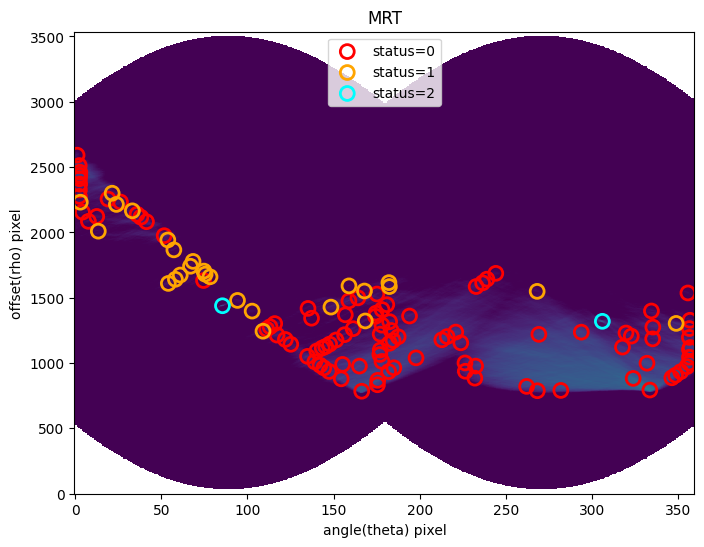

In [43]:
s4.plot_mrt(show_sources=True)

That seems to have worked! Let's make the map to confirm

<Axes: title={'center': 'Segmentation Mask'}>

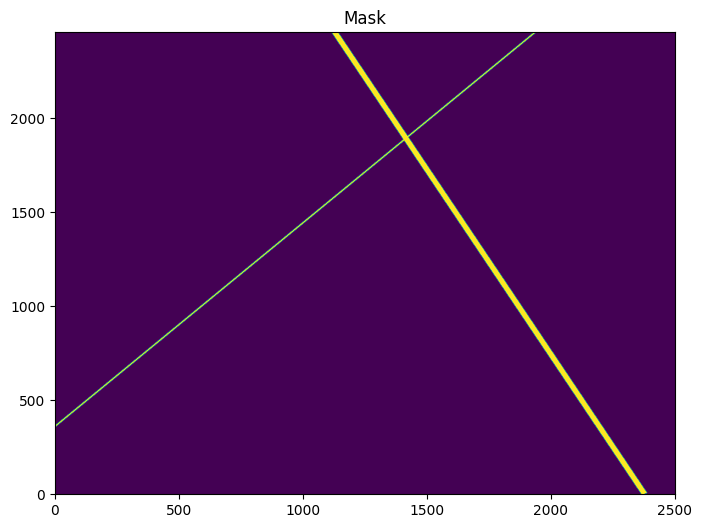

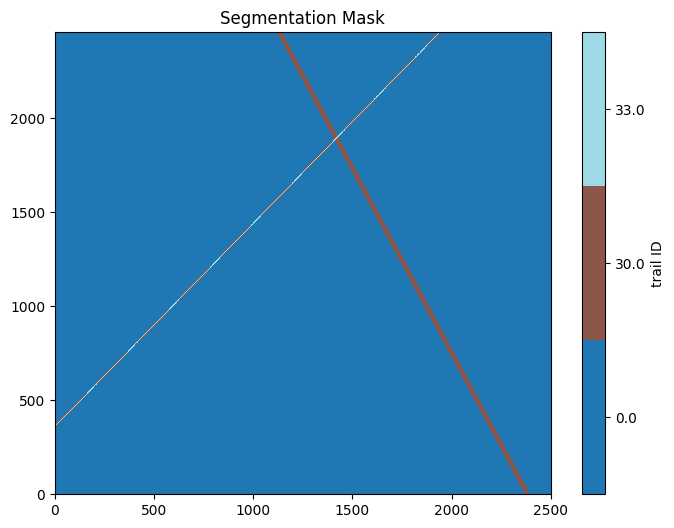

In [44]:
s4.make_mask()
s4.plot_mask()
s4.plot_segment()

Let's make a version plotting the mask on top of the original image

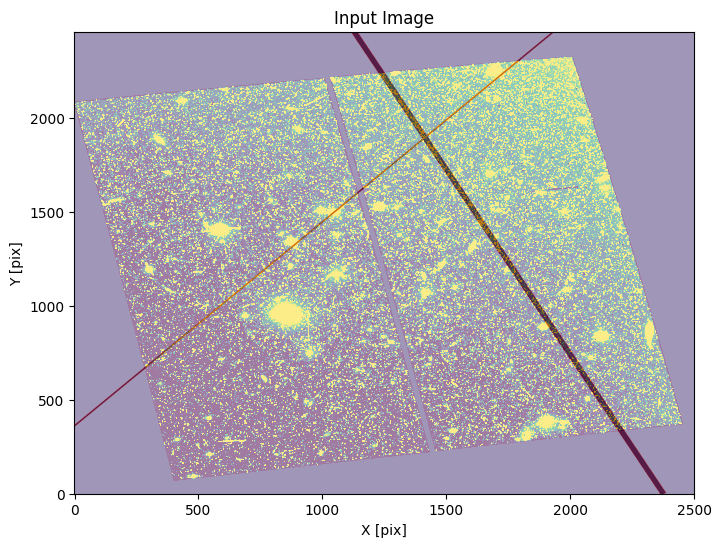

In [45]:
s4.plot_image(overlay_mask=True)

<a id="example5"></a>
## Example 5:  Finding trails in a DRC image using the WFC Wrapper

All of the setup from the last example can be streamlined using the `WfcWrapper` class.

In [46]:
w2 = WfcWrapper('hst_13498_32_acs_wfc_f606w_jc8m32j5_drc.fits', binsize=2, extension=1, processes=8,
                output_root='example5')

INFO:findsat_mrt:image type is drc


INFO:findsat_mrt:masking bad pixels


INFO:findsat_mrt:Subtracting median background


INFO:findsat_mrt:Rebinning the data by 2


Extra rows/columns will be trimmed first.


Run full pipeline now

In [47]:
w2.run_all()

INFO:utils_findsat_mrt:Calculating median Radon Transform with 4 processes


INFO:findsat_mrt:Detection threshold: 5


INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/data/rt_line_kernel_width15.fits


INFO:findsat_mrt:{no} sources found using kernel: 7


INFO:findsat_mrt:7 sources found using kernel


INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/data/rt_line_kernel_width7.fits


INFO:findsat_mrt:{no} sources found using kernel: 11


INFO:findsat_mrt:11 sources found using kernel


INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/data/rt_line_kernel_width3.fits


INFO:findsat_mrt:{no} sources found using kernel: 21


INFO:findsat_mrt:21 sources found using kernel


INFO:findsat_mrt:Removing duplicate sources


INFO:findsat_mrt:24 final sources found


INFO:findsat_mrt:Filtering sources...
Min SNR : 5
Max Width: 75
Min Length: 25
Check persistence: True


INFO:findsat_mrt:Min persistence: 0.5


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.001013967557810247
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 14.348570778181909


INFO:utils_findsat_mrt:breaking into 23.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 23


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 14.348570778181909


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 14.348570778181909, 253.9842456473169


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 23


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 14.348570778181909


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 14.348570778181909, 253.9842456473169


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.011939864124608585
baseline noise: 0.0005514661847140551
snr of feature = 20.651126497991196


INFO:utils_findsat_mrt:width of feature = 2.6584797818309767


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 20.651126497991196, 2.6584797818309767, 253.9842456473169


INFO:utils_findsat_mrt:Checking persistence, step 4 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.007576772336600048
baseline noise: 0.0007045984195137526
snr of feature = 9.753320085260512


INFO:utils_findsat_mrt:width of feature = 3.513197765513695


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 9.753320085260512, 3.513197765513695, 255.21625346203973


INFO:utils_findsat_mrt:Checking persistence, step 5 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.021687138762840258
baseline noise: 0.0005560561194033712
snr of feature = 38.001708651475326


INFO:utils_findsat_mrt:width of feature = 137.22282276408026


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 38.001708651475326, 137.22282276408026, 251.70305569652604


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.014475261215393753
baseline noise: 0.0011382242784097351
snr of feature = 11.717406832700668


INFO:utils_findsat_mrt:width of feature = 224.69792936291816


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 11.717406832700668, 224.69792936291816, 251.70305569652604


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.0027889241637748512
baseline noise: 0.0010081328753595823
snr of feature = 1.766425172654045


INFO:utils_findsat_mrt:width of feature = 3.512765165773004


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.766425172654045, 3.512765165773004, 255.21621913283008


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.02028741790617842
baseline noise: 0.0005173171117026484
snr of feature = 38.21659934929726


INFO:utils_findsat_mrt:width of feature = 86.73540779947632


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 38.21659934929726, 86.73540779947632, 258.72945122755345


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.08544570604326732
baseline noise: 0.0005701987213825511
snr of feature = 148.85250376586006


INFO:utils_findsat_mrt:width of feature = 91.21788016286433


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 148.85250376586006, 91.21788016286433, 251.70305569652604


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.04737052015801455
baseline noise: 0.0006495359617858466
snr of feature = 71.92978825648565


INFO:utils_findsat_mrt:width of feature = 97.00610255630613


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 71.92978825648565, 97.00610255630613, 258.72945122755345


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.016249237356545605
baseline noise: 0.00040872650134795777
snr of feature = 38.755771409381346


INFO:utils_findsat_mrt:width of feature = 60.85458366271976


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 38.755771409381346, 60.85458366271976, 258.0603935388543


INFO:utils_findsat_mrt:Checking persistence, step 12 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.009920500385864502
baseline noise: 0.0011367956031794117
snr of feature = 7.726723043367389


INFO:utils_findsat_mrt:width of feature = 228.9600193347918


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.726723043367389, 228.9600193347918, 263.75104715088975


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.009236508881614997
baseline noise: 0.0013792833321900177
snr of feature = 5.6966000864734045


INFO:utils_findsat_mrt:width of feature = 213.07279249503688


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.6966000864734045, 213.07279249503688, 260.8095255542611


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.008234413780858131
baseline noise: 0.0013769882061472928
snr of feature = 4.980017653090427


INFO:utils_findsat_mrt:width of feature = 213.30301790645274


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.980017653090427, 213.30301790645274, 263.73877294917224


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.01334911065168295
baseline noise: 0.001092859708001638
snr of feature = 11.214843821164044


INFO:utils_findsat_mrt:width of feature = 39.22340981110273


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 11.214843821164044, 39.22340981110273, 252.1449383016745


INFO:utils_findsat_mrt:Checking persistence, step 16 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.01213040729906473
baseline noise: 0.0013650494761328104
snr of feature = 7.886423174513948


INFO:utils_findsat_mrt:width of feature = 74.87756438452894


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.886423174513948, 74.87756438452894, 255.97485009165456


INFO:utils_findsat_mrt:Checking persistence, step 17 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.27897671639217025
baseline noise: 0.0026544003233219485
snr of feature = 104.0997145912921


INFO:utils_findsat_mrt:width of feature = 65.72917143042366


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 104.0997145912921, 65.72917143042366, 242.46605860125777


INFO:utils_findsat_mrt:Checking persistence, step 18 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.01466911848490398
baseline noise: 0.0010605528761990094
snr of feature = 12.831576731447539


INFO:utils_findsat_mrt:width of feature = 50.36862230928767


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 12.831576731447539, 50.36862230928767, 225.23829351358003


INFO:utils_findsat_mrt:Checking persistence, step 19 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.018521259031533278
baseline noise: 0.0016770232088257784
snr of feature = 10.044128032373225


INFO:utils_findsat_mrt:width of feature = 27.114576902599993


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 10.044128032373225, 27.114576902599993, 202.317892491898


INFO:utils_findsat_mrt:Checking persistence, step 20 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.006758564171362467
baseline noise: 0.0019523483691116117
snr of feature = 2.461761373272668


INFO:utils_findsat_mrt:width of feature = 11.433309208441585


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.461761373272668, 11.433309208441585, 196.32406085232174


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.022409476182500027
baseline noise: 0.0026307809255399716
snr of feature = 7.518184074145379


INFO:utils_findsat_mrt:width of feature = 41.524037135289404


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.518184074145379, 41.524037135289404, 196.29254650668005


INFO:utils_findsat_mrt:Checking persistence, step 22 of 23


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 41.524037135289404


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 41.524037135289404, 196.29254650668005


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 23


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise


INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 41.524037135289404


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 41.524037135289404, 196.29254650668005


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 23
Number of sections that passed: 9
persistance score: 0.391304347826087


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.013679247349500656
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 15.943821741164442


INFO:utils_findsat_mrt:breaking into 27.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 15.943821741164442


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 15.943821741164442, 250.04541319836895


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 15.943821741164442


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 15.943821741164442, 250.04541319836895


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.00022744759917259216
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 1.4821296407286582


INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 1.4821296407286582, 250.96442150619427


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.02683461826424128
baseline noise: 0.0026674012159915586
snr of feature = 9.06021070372272


INFO:utils_findsat_mrt:width of feature = 21.652600275965654


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 9.06021070372272, 21.652600275965654, 250.3986937410318


INFO:utils_findsat_mrt:Checking persistence, step 5 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.02832738990440675
baseline noise: 0.0033529325134271557
snr of feature = 7.448541624672393


INFO:utils_findsat_mrt:width of feature = 24.797079540773723


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.448541624672393, 24.797079540773723, 250.22306902932817


INFO:utils_findsat_mrt:Checking persistence, step 6 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.026177428687631208
baseline noise: 0.0035622787178302816
snr of feature = 6.348506605225825


INFO:utils_findsat_mrt:width of feature = 26.890145302908593


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.348506605225825, 26.890145302908593, 249.90596454656426


INFO:utils_findsat_mrt:Checking persistence, step 7 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.030969778272652824
baseline noise: 0.0033301476326016064
snr of feature = 8.299821416162967


INFO:utils_findsat_mrt:width of feature = 22.863899741659566


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 8.299821416162967, 22.863899741659566, 249.9279393938632


INFO:utils_findsat_mrt:Checking persistence, step 8 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0273390386723039
baseline noise: 0.003650670852191594
snr of feature = 6.488771181847729


INFO:utils_findsat_mrt:width of feature = 28.34767184414187


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.488771181847729, 28.34767184414187, 249.03070511533687


INFO:utils_findsat_mrt:Checking persistence, step 9 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.024858484616818104
baseline noise: 0.003530991990880179
snr of feature = 6.040085245455787


INFO:utils_findsat_mrt:width of feature = 18.382918207595083


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.040085245455787, 18.382918207595083, 250.10111679126405


INFO:utils_findsat_mrt:Checking persistence, step 10 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.022402933358085755
baseline noise: 0.005671672704686738
snr of feature = 2.9499693519996817


INFO:utils_findsat_mrt:width of feature = 16.657046551156384


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.9499693519996817, 16.657046551156384, 249.1252785780869


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.028815017052150657
baseline noise: 0.006070904815151351
snr of feature = 3.7464122613545343


INFO:utils_findsat_mrt:width of feature = 19.29373777933708


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.7464122613545343, 19.29373777933708, 250.6614893513851


INFO:utils_findsat_mrt:Checking persistence, step 12 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.045739092743218926
baseline noise: 0.004374151957489479
snr of feature = 9.456676674184552


INFO:utils_findsat_mrt:width of feature = 31.234064370999846


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 9.456676674184552, 31.234064370999846, 248.66099442322516


INFO:utils_findsat_mrt:Checking persistence, step 13 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.030377418758594815
baseline noise: 0.006184290137896655
snr of feature = 3.912030011730095


INFO:utils_findsat_mrt:width of feature = 34.71152049111234


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.912030011730095, 34.71152049111234, 251.94824609021575


INFO:utils_findsat_mrt:Checking persistence, step 14 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.02819875578620314
baseline noise: 0.0032219701956071765
snr of feature = 7.752022543426761


INFO:utils_findsat_mrt:width of feature = 25.16067194620993


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.752022543426761, 25.16067194620993, 249.75882036160124


INFO:utils_findsat_mrt:Checking persistence, step 15 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.029212480087585327
baseline noise: 0.0033775241672724422
snr of feature = 7.64908099567388


INFO:utils_findsat_mrt:width of feature = 101.83480464150728


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.64908099567388, 101.83480464150728, 233.01358062156385


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.024903725476097077
baseline noise: 0.0034849083740100995
snr of feature = 6.146163629960879


INFO:utils_findsat_mrt:width of feature = 21.283522532829835


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.146163629960879, 21.283522532829835, 250.45534915088925


INFO:utils_findsat_mrt:Checking persistence, step 17 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.03022463512742625
baseline noise: 0.003719205099932112
snr of feature = 7.126638438944374


INFO:utils_findsat_mrt:width of feature = 21.045666240087883


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.126638438944374, 21.045666240087883, 250.2191627939288


INFO:utils_findsat_mrt:Checking persistence, step 18 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.04154064759972678
baseline noise: 0.0035812182776634458
snr of feature = 10.599585498270674


INFO:utils_findsat_mrt:width of feature = 117.08505791268266


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 10.599585498270674, 117.08505791268266, 229.17349655384092


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.021212847084968033
baseline noise: 0.00520302444704074
snr of feature = 3.0770223743678553


INFO:utils_findsat_mrt:width of feature = 19.857901708757964


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.0770223743678553, 19.857901708757964, 249.73250490791546


INFO:utils_findsat_mrt:Checking persistence, step 20 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.024496579355938762
baseline noise: 0.005142485719060431
snr of feature = 3.76356779468402


INFO:utils_findsat_mrt:width of feature = 17.693234393427957


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.76356779468402, 17.693234393427957, 250.32550358109256


INFO:utils_findsat_mrt:Checking persistence, step 21 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.026420503554026822
baseline noise: 0.0035229246884990067
snr of feature = 6.4995936303377695


INFO:utils_findsat_mrt:width of feature = 25.752110822729094


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.4995936303377695, 25.752110822729094, 250.17943652843311


INFO:utils_findsat_mrt:Checking persistence, step 22 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.024963285828337407
baseline noise: 0.0050292740970453685
snr of feature = 3.9635962062602643


INFO:utils_findsat_mrt:width of feature = 23.879861571659717


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.9635962062602643, 23.879861571659717, 250.38708011421153


INFO:utils_findsat_mrt:Checking persistence, step 23 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.028494452031735402
baseline noise: 0.005433221546395993
snr of feature = 4.244485576082677


INFO:utils_findsat_mrt:width of feature = 31.247766191620855


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.244485576082677, 31.247766191620855, 249.09995956968754


INFO:utils_findsat_mrt:Checking persistence, step 24 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.016443733256535607
baseline noise: 0.0009209048035033835
snr of feature = 16.85606198814359


INFO:utils_findsat_mrt:width of feature = 18.339973698283785


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 16.85606198814359, 18.339973698283785, 250.01030333114343


INFO:utils_findsat_mrt:Checking persistence, step 25 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise


INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 18.339973698283785


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 18.339973698283785, 250.01030333114343


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise


INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 18.339973698283785


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 18.339973698283785, 250.01030333114343


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 27 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 18.339973698283785


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 18.339973698283785, 250.01030333114343


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 27
Number of sections that passed: 18
persistance score: 0.6666666666666666


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.157922625541687
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 4.1280867065201505


INFO:utils_findsat_mrt:breaking into 28.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 28


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 4.1280867065201505


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 4.1280867065201505, 250.5210861617078


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 28


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 4.1280867065201505


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 4.1280867065201505, 250.5210861617078


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 28


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 4.1280867065201505


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 4.1280867065201505, 250.5210861617078


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 28


INFO:utils_findsat_mrt:amplitude of feature: -0.0008503699078147697
baseline noise: 0.00078367769872328
snr of feature = -2.0851015783658773


INFO:utils_findsat_mrt:width of feature = 4.127723935118809


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.0851015783658773, 4.127723935118809, 250.5210861617078


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.1803554960565963
baseline noise: 0.0015424995172551637
snr of feature = 115.92418314498667


INFO:utils_findsat_mrt:width of feature = 4.550909463291077


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 115.92418314498667, 4.550909463291077, 250.5210861617078


INFO:utils_findsat_mrt:Checking persistence, step 6 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.22269073846523424
baseline noise: 0.0019047072144132468
snr of feature = 115.91599463691593


INFO:utils_findsat_mrt:width of feature = 4.153478812574747


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 115.91599463691593, 4.153478812574747, 250.3355846043916


INFO:utils_findsat_mrt:Checking persistence, step 7 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.27386972938135296
baseline noise: 0.0032737340277917797
snr of feature = 82.65668287539087


INFO:utils_findsat_mrt:width of feature = 4.201352845347003


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 82.65668287539087, 4.201352845347003, 250.38061502137353


INFO:utils_findsat_mrt:Checking persistence, step 8 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.3484386307920071
baseline noise: 0.0031015014763412824
snr of feature = 111.34514426317354


INFO:utils_findsat_mrt:width of feature = 4.1762385268540925


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 111.34514426317354, 4.1762385268540925, 250.39232705539345


INFO:utils_findsat_mrt:Checking persistence, step 9 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.39647496071724614
baseline noise: 0.003925408625914598
snr of feature = 100.00221365485731


INFO:utils_findsat_mrt:width of feature = 4.151006575112206


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 100.00221365485731, 4.151006575112206, 250.39935820811814


INFO:utils_findsat_mrt:Checking persistence, step 10 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.39660364322321257
baseline noise: 0.005096042659462347
snr of feature = 76.82580910832796


INFO:utils_findsat_mrt:width of feature = 4.364581605849025


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 76.82580910832796, 4.364581605849025, 250.41010744985326


INFO:utils_findsat_mrt:Checking persistence, step 11 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.35682217972267627
baseline noise: 0.02151565021414004
snr of feature = 15.58430845321019


INFO:utils_findsat_mrt:width of feature = 5.109584089414398


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 15.58430845321019, 5.109584089414398, 250.4283987718963


INFO:utils_findsat_mrt:Checking persistence, step 12 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.2548358123027749
baseline noise: 0.004209786649511032
snr of feature = 59.5341394990585


INFO:utils_findsat_mrt:width of feature = 4.237790981609862


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 59.5341394990585, 4.237790981609862, 250.43246722900176


INFO:utils_findsat_mrt:Checking persistence, step 13 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.19998281767167383
baseline noise: 0.005645848862612495
snr of feature = 34.42121345046706


INFO:utils_findsat_mrt:width of feature = 4.287423787176181


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 34.42121345046706, 4.287423787176181, 250.4357779008508


INFO:utils_findsat_mrt:Checking persistence, step 14 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.18846480821216077
baseline noise: 0.006988554395939907
snr of feature = 25.967638446321875


INFO:utils_findsat_mrt:width of feature = 109.86356442260063


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 25.967638446321875, 109.86356442260063, 254.723201688027


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.1355322269878711
baseline noise: 0.004547374142545954
snr of feature = 28.804503157065977


INFO:utils_findsat_mrt:width of feature = 4.166444018267441


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 28.804503157065977, 4.166444018267441, 250.46753485947517


INFO:utils_findsat_mrt:Checking persistence, step 16 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.24272880678194514
baseline noise: 0.00390561635935069
snr of feature = 61.14865579431844


INFO:utils_findsat_mrt:width of feature = 164.26211034008887


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 61.14865579431844, 164.26211034008887, 254.6339788777426


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.14771886010699894
baseline noise: 0.003243641203988023
snr of feature = 44.54106043707306


INFO:utils_findsat_mrt:width of feature = 4.243389317151241


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 44.54106043707306, 4.243389317151241, 250.52659557563743


INFO:utils_findsat_mrt:Checking persistence, step 18 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.12377631967053854
baseline noise: 0.004917015662353911
snr of feature = 24.17305784039


INFO:utils_findsat_mrt:width of feature = 3.718209277474614


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 24.17305784039, 3.718209277474614, 250.52386839799863


INFO:utils_findsat_mrt:Checking persistence, step 19 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.1259072490981938
baseline noise: 0.002564008211371498
snr of feature = 48.10563411606453


INFO:utils_findsat_mrt:width of feature = 4.535252997765269


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 48.10563411606453, 4.535252997765269, 250.54764915288328


INFO:utils_findsat_mrt:Checking persistence, step 20 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.11659173697375115
baseline noise: 0.0037367359537588264
snr of feature = 30.20149200172149


INFO:utils_findsat_mrt:width of feature = 4.266842940254946


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 30.20149200172149, 4.266842940254946, 250.53269234479677


INFO:utils_findsat_mrt:Checking persistence, step 21 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.12754152993110895
baseline noise: 0.004403624726893805
snr of feature = 27.96285170536619


INFO:utils_findsat_mrt:width of feature = 4.324831882125011


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 27.96285170536619, 4.324831882125011, 250.57531202540312


INFO:utils_findsat_mrt:Checking persistence, step 22 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.14831796552256832
baseline noise: 0.003765268308931289
snr of feature = 38.391074779652556


INFO:utils_findsat_mrt:width of feature = 4.135356731405295


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 38.391074779652556, 4.135356731405295, 250.61723830675442


INFO:utils_findsat_mrt:Checking persistence, step 23 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.17968979141784985
baseline noise: 0.0030804416503753406
snr of feature = 57.33247690179598


INFO:utils_findsat_mrt:width of feature = 4.313807628345842


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 57.33247690179598, 4.313807628345842, 250.62865555651172


INFO:utils_findsat_mrt:Checking persistence, step 24 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.2073854105560656
baseline noise: 0.0033540048249855576
snr of feature = 60.832174185068034


INFO:utils_findsat_mrt:width of feature = 4.071870475951187


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 60.832174185068034, 4.071870475951187, 250.65407796357445


INFO:utils_findsat_mrt:Checking persistence, step 25 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.24609793043354927
baseline noise: 0.00279026487728031
snr of feature = 87.19877010150469


INFO:utils_findsat_mrt:width of feature = 4.026941380076153


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 87.19877010150469, 4.026941380076153, 250.70224679268117


INFO:utils_findsat_mrt:Checking persistence, step 26 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.32677915675691893
baseline noise: 0.00171999759844353
snr of feature = 188.98814710708305


INFO:utils_findsat_mrt:width of feature = 4.325885400298716


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 188.98814710708305, 4.325885400298716, 250.76924574289643


INFO:utils_findsat_mrt:Checking persistence, step 27 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.0037112799133310697
baseline noise: 0.00021230634057039572
snr of feature = 16.48077755643147


INFO:utils_findsat_mrt:width of feature = 121.9452198801753


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 16.48077755643147, 121.9452198801753, 250.46717216133572


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 28 of 28


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 4.325885400298716


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 4.325885400298716, 250.76924574289643


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 28
Number of sections that passed: 20
persistance score: 0.7142857142857143


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.00273595517501235
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 70.34670817008447


INFO:utils_findsat_mrt:breaking into 27.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 70.34670817008447


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 70.34670817008447, 252.82178991613998


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.013410670579861067
baseline noise: 0.0019454297015809197
snr of feature = 5.893423375289848


INFO:utils_findsat_mrt:width of feature = 88.85352802971127


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.893423375289848, 88.85352802971127, 269.8379731453008


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.02390279529720725
baseline noise: 0.0035842518772580437
snr of feature = 5.668838049264806


INFO:utils_findsat_mrt:width of feature = 96.53258400770414


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.668838049264806, 96.53258400770414, 258.59090143059456


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.02118157159723548
baseline noise: 0.00379292699981151
snr of feature = 4.584492292703788


INFO:utils_findsat_mrt:width of feature = 97.72669933200714


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.584492292703788, 97.72669933200714, 252.82178991613998


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.007227569598381198
baseline noise: 0.0032255775445403185
snr of feature = 1.2407055786380758


INFO:utils_findsat_mrt:width of feature = 70.34665052273289


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.2407055786380758, 70.34665052273289, 252.82178991613998


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.016164872040993882
baseline noise: 0.003336273683651376
snr of feature = 3.8451876475859983


INFO:utils_findsat_mrt:width of feature = 104.15594159475009


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.8451876475859983, 104.15594159475009, 254.73419164691705


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0237189843205727
baseline noise: 0.004163280839240705
snr of feature = 4.697185762010363


INFO:utils_findsat_mrt:width of feature = 125.72592599938989


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.697185762010363, 125.72592599938989, 252.82178991613998


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.014656812992096722
baseline noise: 0.0036153155497311348
snr of feature = 3.0540895505474555


INFO:utils_findsat_mrt:width of feature = 55.72121643090571


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.0540895505474555, 55.72121643090571, 255.05012651376128


INFO:utils_findsat_mrt:Checking persistence, step 9 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.004676800825618997
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 253.91496366512044


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.01189595778772791
baseline noise: 0.008029975932759378
snr of feature = 0.4814437661259646


INFO:utils_findsat_mrt:width of feature = 55.72117744957251


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.4814437661259646, 55.72117744957251, 255.050128732778


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.4413009348533563
baseline noise: 0.009761011381000238
snr of feature = 44.21057476813791


INFO:utils_findsat_mrt:width of feature = 148.4566840295347


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 44.21057476813791, 148.4566840295347, 310.771342944667


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.004408499300258901
baseline noise: 0.004395198633993076
snr of feature = 0.0030261809245560314


INFO:utils_findsat_mrt:width of feature = 55.72118498641606


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.0030261809245560314, 55.72118498641606, 255.0501266344119


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.019899091270237562
baseline noise: 0.0053019314221217605
snr of feature = 2.7531777923815954


INFO:utils_findsat_mrt:width of feature = 168.74881228289365


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.7531777923815954, 168.74881228289365, 247.82250329824657


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.08680910960084273
baseline noise: 0.004344756619712668
snr of feature = 18.980200779712185


INFO:utils_findsat_mrt:width of feature = 148.98249057741035


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 18.980200779712185, 148.98249057741035, 229.61840891579672


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.00775605674189694
baseline noise: 0.003906710797897812
snr of feature = 0.9853163295502825


INFO:utils_findsat_mrt:width of feature = 55.72118744730352


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.9853163295502825, 55.72118744730352, 255.05012685062164


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.003875124361308039
baseline noise: 0.005082284320608722
snr of feature = -0.2375231063727851


INFO:utils_findsat_mrt:width of feature = 55.72116917367515


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.2375231063727851, 55.72116917367515, 255.05012552799994


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 27


INFO:utils_findsat_mrt:amplitude of feature: -0.005068743324118812
baseline noise: 0.0072728988997280315
snr of feature = -1.6969357602796262


INFO:utils_findsat_mrt:width of feature = 55.721173524168364


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.6969357602796262, 55.721173524168364, 255.05012618653123


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.24507018451752136
baseline noise: 0.00398214848318426
snr of feature = 60.54220154080115


INFO:utils_findsat_mrt:width of feature = 61.55637261289121


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 60.54220154080115, 61.55637261289121, 244.99476156714132


INFO:utils_findsat_mrt:Checking persistence, step 19 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.018968143674036934
baseline noise: 0.0031564851750679732
snr of feature = 5.009261131292487


INFO:utils_findsat_mrt:width of feature = 61.55523085596849


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.009261131292487, 61.55523085596849, 244.99477645328204


INFO:utils_findsat_mrt:Checking persistence, step 20 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.010054678444893635
baseline noise: 0.0034947814481921117
snr of feature = 1.87705500156384


INFO:utils_findsat_mrt:width of feature = 19.413242924382274


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.87705500156384, 19.413242924382274, 246.43409544079796


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.008425853701342741
baseline noise: 0.004391261043142437
snr of feature = 0.9187776856265195


INFO:utils_findsat_mrt:width of feature = 61.55523085596849


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.9187776856265195, 61.55523085596849, 244.99477645328204


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.009386664084273966
baseline noise: 0.00330391765365773
snr of feature = 1.8410708341601962


INFO:utils_findsat_mrt:width of feature = 81.27694637581476


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.8410708341601962, 81.27694637581476, 245.31691835926887


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0062293419304305046
baseline noise: 0.0036054293984666705
snr of feature = 0.727766998593771


INFO:utils_findsat_mrt:width of feature = 61.55523085596849


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.727766998593771, 61.55523085596849, 244.99477645328204


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.012855963857521815
baseline noise: 0.0030088508859922487
snr of feature = 3.2727155132123533


INFO:utils_findsat_mrt:width of feature = 151.71919052300478


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.2727155132123533, 151.71919052300478, 218.45800154639616


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.00880785324172755
baseline noise: 0.002126368173458239
snr of feature = 3.1422051701436136


INFO:utils_findsat_mrt:width of feature = 61.55523085596849


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.1422051701436136, 61.55523085596849, 244.99477645328204


INFO:utils_findsat_mrt:Checking persistence, step 26 of 27


INFO:utils_findsat_mrt:amplitude of feature: -0.0009942066657169474
baseline noise: 0.0012207667374255896
snr of feature = -1.8144116605057385


INFO:utils_findsat_mrt:width of feature = 61.55523085596849


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.8144116605057385, 61.55523085596849, 244.99477645328204


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 27 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 61.55523085596849


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 61.55523085596849, 244.99477645328204


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 27
Number of sections that passed: 4
persistance score: 0.14814814814814814


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.002991673070937395
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 97.3684912595076


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0027963067404925823
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 104.08838569978514


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.00260268896818161
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 58.6316502295208


INFO:utils_findsat_mrt:breaking into 25.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 58.6316502295208


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 58.6316502295208, 256.77406012728795


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 58.6316502295208


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 58.6316502295208, 256.77406012728795


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.0006223228351859278
baseline noise: 0.0013209058403038227
snr of feature = -0.5288666184996299


INFO:utils_findsat_mrt:width of feature = 58.631598511264684


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.5288666184996299, 58.631598511264684, 256.77406012728795


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.021744364435576053
baseline noise: 0.003523138611636309
snr of feature = 5.171873103078666


INFO:utils_findsat_mrt:width of feature = 50.43974416514618


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.171873103078666, 50.43974416514618, 256.77406012728795


INFO:utils_findsat_mrt:Checking persistence, step 5 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.011237517807780916
baseline noise: 0.002873520835839728
snr of feature = 2.9107138767264167


INFO:utils_findsat_mrt:width of feature = 53.05441808813376


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.9107138767264167, 53.05441808813376, 240.87107964054158


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.007594887581514162
baseline noise: 0.0031884335385554247
snr of feature = 1.3820121980510713


INFO:utils_findsat_mrt:width of feature = 50.84150419972411


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.3820121980510713, 50.84150419972411, 264.53771863377403


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.018166858241077034
baseline noise: 0.0029929752829411624
snr of feature = 5.0698323653460555


INFO:utils_findsat_mrt:width of feature = 181.08395373882115


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.0698323653460555, 181.08395373882115, 256.75325292347543


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.002851937105198217
baseline noise: 0.005684739297740703
snr of feature = -0.4983169929478265


INFO:utils_findsat_mrt:width of feature = 50.43967044496114


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.4983169929478265, 50.43967044496114, 256.7740604801862


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.4999282798194494
baseline noise: 0.010158127326452025
snr of feature = 48.214610503810405


INFO:utils_findsat_mrt:width of feature = 216.53707901919245


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 48.214610503810405, 216.53707901919245, 206.33431596214177


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 25


INFO:utils_findsat_mrt:amplitude of feature: -0.00045520410125050176
baseline noise: 0.012665156381508622
snr of feature = -1.0359414512966543


INFO:utils_findsat_mrt:width of feature = 50.43965282836484


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0359414512966543, 50.43965282836484, 256.77405876961313


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.006349274715897697
baseline noise: 0.008933472600439333
snr of feature = -0.2892713729725381


INFO:utils_findsat_mrt:width of feature = 50.43967900966024


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.2892713729725381, 50.43967900966024, 256.7740617907974


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.010700556641950361
baseline noise: 0.003596120567264352
snr of feature = 1.9755833937710574


INFO:utils_findsat_mrt:width of feature = 52.34486601796084


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.9755833937710574, 52.34486601796084, 266.74480137327885


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 25


INFO:utils_findsat_mrt:amplitude of feature: -0.0015135763926304273
baseline noise: 0.0024208163596858667
snr of feature = -1.625233874752414


INFO:utils_findsat_mrt:width of feature = 50.43966847213676


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.625233874752414, 50.43966847213676, 256.77406091137897


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.0033626752339899584
baseline noise: 0.002911936328678076
snr of feature = 0.1547900964979214


INFO:utils_findsat_mrt:width of feature = 50.43967436451851


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.1547900964979214, 50.43967436451851, 256.7740604797795


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.02311940523342819
baseline noise: 0.004969583862603506
snr of feature = 3.652181323954197


INFO:utils_findsat_mrt:width of feature = 18.34810794293537


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.652181323954197, 18.34810794293537, 267.9021366062812


INFO:utils_findsat_mrt:Checking persistence, step 16 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.02577546234530438
baseline noise: 0.003874945454070383
snr of feature = 5.6518258516978355


INFO:utils_findsat_mrt:width of feature = 26.635464214897297


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.6518258516978355, 26.635464214897297, 260.3557347076935


INFO:utils_findsat_mrt:Checking persistence, step 17 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.012779050047166894
baseline noise: 0.002872389679151998
snr of feature = 3.4489263207976686


INFO:utils_findsat_mrt:width of feature = 5.646579381189781


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.4489263207976686, 5.646579381189781, 261.6690290365158


INFO:utils_findsat_mrt:Checking persistence, step 18 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.003469753298817371
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 261.557823278344


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.022596056393805103
baseline noise: 0.003125297239922235
snr of feature = 6.2300503469447115


INFO:utils_findsat_mrt:width of feature = 70.39001720348867


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.2300503469447115, 70.39001720348867, 256.022449655326


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.03128311024852757
baseline noise: 0.004217049004818572
snr of feature = 6.418246791247199


INFO:utils_findsat_mrt:width of feature = 109.64449077292863


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.418246791247199, 109.64449077292863, 256.0413430528353


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.004712009953126724
baseline noise: 0.0028948497911648447
snr of feature = 0.6277217448407507


INFO:utils_findsat_mrt:width of feature = 5.6460710762678445


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.6277217448407507, 5.6460710762678445, 261.6690666440371


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.26674109443243005
baseline noise: 0.0037397201941942034
snr of feature = 70.32648449114912


INFO:utils_findsat_mrt:width of feature = 178.01705623181658


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 70.32648449114912, 178.01705623181658, 256.022449655326


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.006539703524521739
baseline noise: 0.0032111006562820024
snr of feature = 1.0365925034856383


INFO:utils_findsat_mrt:width of feature = 47.6471126044064


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.0365925034856383, 47.6471126044064, 256.81519050434264


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.03172405056174754
baseline noise: 0.0009601501289994933
snr of feature = 32.04071894965531


INFO:utils_findsat_mrt:width of feature = 168.73360527761622


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 32.04071894965531, 168.73360527761622, 267.31560841770556


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 5.646579381189781


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 5.646579381189781, 261.6690290365158


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 25
Number of sections that passed: 4
persistance score: 0.16


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0006844737799838185
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 1.86568320290678


INFO:utils_findsat_mrt:breaking into 25.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.86568320290678


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.86568320290678, 248.50641241776333


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.86568320290678


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.86568320290678, 248.50641241776333


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.0039245662268190965
baseline noise: 0.0039413707550508765
snr of feature = -0.004263625341575625


INFO:utils_findsat_mrt:width of feature = 1.8889841042228568


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.004263625341575625, 1.8889841042228568, 248.50641241776333


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.008572064959876946
baseline noise: 0.0038444361909993675
snr of feature = 1.2297326666380757


INFO:utils_findsat_mrt:width of feature = 10.251613836736453


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.2297326666380757, 10.251613836736453, 248.50641241776333


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.038432902465125596
baseline noise: 0.003475947709597784
snr of feature = 10.056812609408565


INFO:utils_findsat_mrt:width of feature = 4.913541514593817


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 10.056812609408565, 4.913541514593817, 248.50641241776333


INFO:utils_findsat_mrt:Checking persistence, step 6 of 25


INFO:utils_findsat_mrt:amplitude of feature: 34.97731335832706
baseline noise: 0.007561254398840974
snr of feature = 4624.86120150759


INFO:utils_findsat_mrt:width of feature = 4.362581183875136


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4624.86120150759, 4.362581183875136, 250.1285335071382


INFO:utils_findsat_mrt:Checking persistence, step 7 of 25


INFO:utils_findsat_mrt:amplitude of feature: 106.59518218476866
baseline noise: 0.004532842468004223
snr of feature = 23515.189441214297


INFO:utils_findsat_mrt:width of feature = 7.355490903141003


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 23515.189441214297, 7.355490903141003, 247.07200676654193


INFO:utils_findsat_mrt:Checking persistence, step 8 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.03935666938303571
baseline noise: 0.0029991175391917385
snr of feature = 12.122749898505921


INFO:utils_findsat_mrt:width of feature = 60.3509594483923


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 12.122749898505921, 60.3509594483923, 244.8807821691506


INFO:utils_findsat_mrt:Checking persistence, step 9 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.0003642379831026582
baseline noise: 0.007905383051818673
snr of feature = -0.9539253214278006


INFO:utils_findsat_mrt:width of feature = 60.350921706392654


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.9539253214278006, 60.350921706392654, 244.88078200694636


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.014901014100541819
baseline noise: 0.004799786754374725
snr of feature = 2.104515859368213


INFO:utils_findsat_mrt:width of feature = 107.18148462957177


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.104515859368213, 107.18148462957177, 277.30626511273965


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.19187952441874884
baseline noise: 0.00489882645314254
snr of feature = 38.16846743890271


INFO:utils_findsat_mrt:width of feature = 83.85148963617803


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 38.16846743890271, 83.85148963617803, 269.74829321156585


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.025131395159772647
baseline noise: 0.0005132608254044823
snr of feature = 47.964179450024275


INFO:utils_findsat_mrt:width of feature = 60.098483571334896


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 47.964179450024275, 60.098483571334896, 242.98004452773768


INFO:utils_findsat_mrt:Checking persistence, step 13 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.13047983342737957
baseline noise: 0.0015389509526013538
snr of feature = 83.7849200176419


INFO:utils_findsat_mrt:width of feature = 66.31703646585811


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 83.7849200176419, 66.31703646585811, 259.89501395263784


INFO:utils_findsat_mrt:Checking persistence, step 14 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.027556225098535607
baseline noise: 0.0037277341489294308
snr of feature = 6.392218435547365


INFO:utils_findsat_mrt:width of feature = 64.05359944426579


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.392218435547365, 64.05359944426579, 249.31881733220447


INFO:utils_findsat_mrt:Checking persistence, step 15 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.006234446995125565
baseline noise: 0.004203291532883104
snr of feature = 0.48322973706495675


INFO:utils_findsat_mrt:width of feature = 64.0535162662778


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.48322973706495675, 64.0535162662778, 249.3188171364291


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.016437188249552735
baseline noise: 0.0037939054330957114
snr of feature = 3.3325245026311814


INFO:utils_findsat_mrt:width of feature = 63.89307245959799


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.3325245026311814, 63.89307245959799, 278.96970007930133


INFO:utils_findsat_mrt:Checking persistence, step 17 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.013638362491330117
baseline noise: 0.0042805437916136726
snr of feature = 2.186128481631244


INFO:utils_findsat_mrt:width of feature = 63.89305384120533


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.186128481631244, 63.89305384120533, 278.96970070574037


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 25


INFO:utils_findsat_mrt:amplitude of feature: -0.004792739855227844
baseline noise: 0.007012038772254817
snr of feature = -1.6835016192710914


INFO:utils_findsat_mrt:width of feature = 63.89304265417866


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.6835016192710914, 63.89304265417866, 278.9697006679571


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.013545364359833788
baseline noise: 0.004449310334843074
snr of feature = 2.044373923247934


INFO:utils_findsat_mrt:width of feature = 48.4068295953183


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.044373923247934, 48.4068295953183, 291.3240458456556


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.008514618346167376
baseline noise: 0.0048328232184733705
snr of feature = 0.7618311204971076


INFO:utils_findsat_mrt:width of feature = 63.893050612061415


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.7618311204971076, 63.893050612061415, 278.9696995893624


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.009030007488115454
baseline noise: 0.003213555047678179
snr of feature = 1.8099744221402747


INFO:utils_findsat_mrt:width of feature = 46.40727362300751


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.8099744221402747, 46.40727362300751, 277.56371549861575


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.03610712779284204
baseline noise: 0.003356013631743393
snr of feature = 9.758933590530438


INFO:utils_findsat_mrt:width of feature = 59.785981267335956


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 9.758933590530438, 59.785981267335956, 254.86914667090684


INFO:utils_findsat_mrt:Checking persistence, step 23 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise


INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 59.785981267335956


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 59.785981267335956, 254.86914667090684


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 59.785981267335956


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 59.785981267335956, 254.86914667090684


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 59.785981267335956


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 59.785981267335956, 254.86914667090684


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 25
Number of sections that passed: 9
persistance score: 0.36


INFO:utils_findsat_mrt:amplitude of feature: 0.00045310669482854593
baseline noise: 1.708318752000072e-06
snr of feature = 264.2354511112495


INFO:utils_findsat_mrt:width of feature = 31.023041460222004


INFO:utils_findsat_mrt:breaking into 27.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 27


INFO:utils_findsat_mrt:amplitude of feature: 1.1235862272491739e-05
baseline noise: 7.765414116130304e-05
snr of feature = -0.8553089107102141


INFO:utils_findsat_mrt:width of feature = 31.02293963261954


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.8553089107102141, 31.02293963261954, 250.07240899448828


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.003887783984733737
baseline noise: 0.0014885661858339227
snr of feature = 1.6117642747310745


INFO:utils_findsat_mrt:width of feature = 31.022991569516563


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.6117642747310745, 31.022991569516563, 250.07241118182947


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.02146252018866032
baseline noise: 0.0023603045238701457
snr of feature = 8.09311488056153


INFO:utils_findsat_mrt:width of feature = 45.02161121304846


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 8.09311488056153, 45.02161121304846, 260.46646821481386


INFO:utils_findsat_mrt:Checking persistence, step 4 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0065441036307241655
baseline noise: 0.003861926074913161
snr of feature = 0.6945180989440135


INFO:utils_findsat_mrt:width of feature = 45.02146375066988


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.6945180989440135, 45.02146375066988, 260.46646815473457


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0033791641378375804
baseline noise: 0.004013187048521325
snr of feature = -0.15798488907148064


INFO:utils_findsat_mrt:width of feature = 45.02147875693231


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.15798488907148064, 45.02147875693231, 260.4664674711912


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.016068523099480748
baseline noise: 0.0035400746774037596
snr of feature = 3.539035066702371


INFO:utils_findsat_mrt:width of feature = 129.55757274628547


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.539035066702371, 129.55757274628547, 255.05993039362738


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.5878981020826677
baseline noise: 0.004159598850145535
snr of feature = 140.33528815214922


INFO:utils_findsat_mrt:width of feature = 95.55926306638654


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 140.33528815214922, 95.55926306638654, 221.84913547313622


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.011406422448345811
baseline noise: 0.004057536486046688
snr of feature = 1.8111694097073276


INFO:utils_findsat_mrt:width of feature = 170.39796127033372


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.8111694097073276, 170.39796127033372, 219.84352326222105


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.004849123941273905
baseline noise: 0.0039047114417700255
snr of feature = 0.24186486340608365


INFO:utils_findsat_mrt:width of feature = 45.021485164590445


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.24186486340608365, 45.021485164590445, 260.4664692781821


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.14487876963895968
baseline noise: 0.0052585625131499475
snr of feature = 26.5510216483431


INFO:utils_findsat_mrt:width of feature = 96.54933069767401


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 26.5510216483431, 96.54933069767401, 282.3783787030704


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.005304724518416713
baseline noise: 0.005880099507926733
snr of feature = -0.0978512334246011


INFO:utils_findsat_mrt:width of feature = 15.351477201419158


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.0978512334246011, 15.351477201419158, 255.5822683661199


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.014560931964547259
baseline noise: 0.007248006153024121
snr of feature = 1.0089568989220479


INFO:utils_findsat_mrt:width of feature = 45.02148952326675


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.0089568989220479, 45.02148952326675, 260.46646024547584


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.04929925609883658
baseline noise: 0.001061728530578553
snr of feature = 45.433014352522505


INFO:utils_findsat_mrt:width of feature = 198.68339645644073


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 45.433014352522505, 198.68339645644073, 215.4448570017654


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.008863890518739141
baseline noise: 0.00456976130006796
snr of feature = 0.9396834838194545


INFO:utils_findsat_mrt:width of feature = 209.6100695067313


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.9396834838194545, 209.6100695067313, 295.6547663111221


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.005523324057778514
baseline noise: 0.0018488174604869042
snr of feature = 1.9874902070234086


INFO:utils_findsat_mrt:width of feature = 45.021505679952355


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.9874902070234086, 45.021505679952355, 260.4664693321231


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0709167891454188
baseline noise: 0.0037606996147078455
snr of feature = 17.857339434414797


INFO:utils_findsat_mrt:width of feature = 86.5582733117783


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 17.857339434414797, 86.5582733117783, 250.70894168157332


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.005566126474205341
baseline noise: 0.004992989827211304
snr of feature = 0.11478826651528472


INFO:utils_findsat_mrt:width of feature = 45.02146875357036


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.11478826651528472, 45.02146875357036, 260.4664659508704


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.005063131545819225
baseline noise: 0.0035134753333249716
snr of feature = 0.44106079180232605


INFO:utils_findsat_mrt:width of feature = 45.021508341367934


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.44106079180232605, 45.021508341367934, 260.4664659167855


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.013206311161536059
baseline noise: 0.0033582166726600724
snr of feature = 2.93253695303562


INFO:utils_findsat_mrt:width of feature = 274.0661994365065


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.93253695303562, 274.0661994365065, 257.81791159869056


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.020846445923824314
baseline noise: 0.003803136488387862
snr of feature = 4.481382534514573


INFO:utils_findsat_mrt:width of feature = 28.42148991082803


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.481382534514573, 28.42148991082803, 246.12381728386865


INFO:utils_findsat_mrt:Checking persistence, step 21 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0482134754703179
baseline noise: 0.0047609949682885086
snr of feature = 9.126764634588508


INFO:utils_findsat_mrt:width of feature = 84.36824329708804


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 9.126764634588508, 84.36824329708804, 274.54530719469665


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.010172473026636257
baseline noise: 0.0032086466185263425
snr of feature = 2.170331368964601


INFO:utils_findsat_mrt:width of feature = 182.50165719182027


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.170331368964601, 182.50165719182027, 239.22900762299827


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 27


INFO:utils_findsat_mrt:amplitude of feature: -0.006292586726800022
baseline noise: 0.006214286526704771
snr of feature = -2.012600030551982


INFO:utils_findsat_mrt:width of feature = 28.421122567139605


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.012600030551982, 28.421122567139605, 246.12381718117024


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.004427830733935915
baseline noise: 0.00379724584323601
snr of feature = 0.16606375165915552


INFO:utils_findsat_mrt:width of feature = 28.42119790772651


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.16606375165915552, 28.42119790772651, 246.1238077016698


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0017269010330529318
baseline noise: 0.0048180820279417145
snr of feature = -0.6415791547262918


INFO:utils_findsat_mrt:width of feature = 28.42120101271027


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.6415791547262918, 28.42120101271027, 246.12381336834278


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.01898399804620548
baseline noise: 0.0005447683164803254
snr of feature = 33.847838010952124


INFO:utils_findsat_mrt:width of feature = 45.74961939635807


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 33.847838010952124, 45.74961939635807, 225.78426678105205


INFO:utils_findsat_mrt:Checking persistence, step 27 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.00017296940282268865
baseline noise: 0.0005971008007976448
snr of feature = -0.7103179185296264


INFO:utils_findsat_mrt:width of feature = 206.2247574831107


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.7103179185296264, 206.2247574831107, 270.97061970925


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 27
Number of sections that passed: 3
persistance score: 0.1111111111111111


INFO:utils_findsat_mrt:amplitude of feature: 0.0011886687511692981
baseline noise: 2.229288997766714e-05
snr of feature = 52.32053189873982


INFO:utils_findsat_mrt:width of feature = 2.5150079023167677


INFO:utils_findsat_mrt:breaking into 27.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 27


INFO:utils_findsat_mrt:amplitude of feature: -0.00022553697641309158
baseline noise: 0.00021842501933323083
snr of feature = -2.0325601760346452


INFO:utils_findsat_mrt:width of feature = 2.5147685811405154


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.0325601760346452, 2.5147685811405154, 251.98111393606587


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.028361186738844506
baseline noise: 0.001057657198614112
snr of feature = 25.815103018262665


INFO:utils_findsat_mrt:width of feature = 56.32319950643796


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 25.815103018262665, 56.32319950643796, 256.9525274207753


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.008299664109109638
baseline noise: 0.0025804550754612264
snr of feature = 2.2163567535180473


INFO:utils_findsat_mrt:width of feature = 20.906645644122506


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.2163567535180473, 20.906645644122506, 255.66370650175213


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 27


INFO:utils_findsat_mrt:amplitude of feature: -0.002078660951129588
baseline noise: 0.0037545605883223523
snr of feature = -1.5536362783956017


INFO:utils_findsat_mrt:width of feature = 2.5136001350556967


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.5536362783956017, 2.5136001350556967, 251.98111393606587


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.013387038287818957
baseline noise: 0.003486839962733887
snr of feature = 2.8393039057986287


INFO:utils_findsat_mrt:width of feature = 60.07603691153372


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.8393039057986287, 60.07603691153372, 251.98111393606587


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.005146450581343488
baseline noise: 0.0051268560524413845
snr of feature = 0.0038219385724263177


INFO:utils_findsat_mrt:width of feature = 2.5154663354107925


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.0038219385724263177, 2.5154663354107925, 251.98111393606587


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.6733140049684322
baseline noise: 0.004289495319232802
snr of feature = 155.96811742619127


INFO:utils_findsat_mrt:width of feature = 93.29229883727785


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 155.96811742619127, 93.29229883727785, 274.5201466803336


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0016562478368198005
baseline noise: 0.0036090383245185945
snr of feature = -0.5410833335939358


INFO:utils_findsat_mrt:width of feature = 0.9030973927172568


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.5410833335939358, 0.9030973927172568, 251.98111393606587


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0028288856296629483
baseline noise: 0.005017381304014993
snr of feature = -0.43618284952765574


INFO:utils_findsat_mrt:width of feature = 2.5151122518750526


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.43618284952765574, 2.5151122518750526, 251.98111393606587


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0042433856229564006
baseline noise: 0.007101765746566471
snr of feature = -0.40248865220484453


INFO:utils_findsat_mrt:width of feature = 1.6204938762092524


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.40248865220484453, 1.6204938762092524, 252.33018365715535


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.019310690825463897
baseline noise: 0.009682371310725723
snr of feature = 0.994417504322761


INFO:utils_findsat_mrt:width of feature = 252.75295999037667


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.994417504322761, 252.75295999037667, 251.98111393606587


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.13645141625493948
baseline noise: 0.005524199020953905
snr of feature = 23.7006698595333


INFO:utils_findsat_mrt:width of feature = 183.36177231933857


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 23.7006698595333, 183.36177231933857, 251.98111393606587


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.027037524399732456
baseline noise: 0.0008188390632460564
snr of feature = 32.0193387361734


INFO:utils_findsat_mrt:width of feature = 187.26058041449164


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 32.0193387361734, 187.26058041449164, 261.70028593217967


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.010348169979690108
baseline noise: 0.00432202961868306
snr of feature = 1.3942848366789389


INFO:utils_findsat_mrt:width of feature = 234.96006465019684


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.3942848366789389, 234.96006465019684, 276.98111393606587


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.017339322582589255
baseline noise: 0.002708812296251474
snr of feature = 5.401079398001799


INFO:utils_findsat_mrt:width of feature = 73.94832543855765


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.401079398001799, 73.94832543855765, 251.98111393606587


INFO:utils_findsat_mrt:Checking persistence, step 16 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.07205245048125786
baseline noise: 0.0040622145892554255
snr of feature = 16.73723393929924


INFO:utils_findsat_mrt:width of feature = 84.56674216816086


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 16.73723393929924, 84.56674216816086, 290.11458962490735


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.006269409644600491
baseline noise: 0.00488978804953635
snr of feature = 0.28214343466174513


INFO:utils_findsat_mrt:width of feature = 14.540707290917766


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.28214343466174513, 14.540707290917766, 251.7898313100914


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.007874306920784838
baseline noise: 0.003131788566978095
snr of feature = 1.5143162612611691


INFO:utils_findsat_mrt:width of feature = 89.08510898140048


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.5143162612611691, 89.08510898140048, 260.91119222155794


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.005742579985159573
baseline noise: 0.0030527329656599997
snr of feature = 0.8811275174597623


INFO:utils_findsat_mrt:width of feature = 20.977629616136824


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.8811275174597623, 20.977629616136824, 263.48845667864936


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.019888462942890484
baseline noise: 0.003951454080912993
snr of feature = 4.033201078802668


INFO:utils_findsat_mrt:width of feature = 73.94831506110529


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.033201078802668, 73.94831506110529, 251.98111628995207


INFO:utils_findsat_mrt:Checking persistence, step 21 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.02173755394792813
baseline noise: 0.00479249850031186
snr of feature = 3.535745592098488


INFO:utils_findsat_mrt:width of feature = 73.94831506110529


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.535745592098488, 73.94831506110529, 251.98111628995207


INFO:utils_findsat_mrt:Checking persistence, step 22 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.012984192226250149
baseline noise: 0.003229431272169653
snr of feature = 3.0205816851234246


INFO:utils_findsat_mrt:width of feature = 179.46129960005717


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.0205816851234246, 179.46129960005717, 253.8197928112828


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.03666540905427268
baseline noise: 0.005517827053039788
snr of feature = 5.644900012600719


INFO:utils_findsat_mrt:width of feature = 73.94831506110529


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.644900012600719, 73.94831506110529, 251.98111628995207


INFO:utils_findsat_mrt:Checking persistence, step 24 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.00568689477161952
baseline noise: 0.003508389073165844
snr of feature = 0.620941877603065


INFO:utils_findsat_mrt:width of feature = 48.08295840171655


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.620941877603065, 48.08295840171655, 210.54500189052803


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.006029736505364263
baseline noise: 0.005266849709761584
snr of feature = 0.14484688905945883


INFO:utils_findsat_mrt:width of feature = 73.94831506110529


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.14484688905945883, 73.94831506110529, 251.98111628995207


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.013259384734097372
baseline noise: 0.0002507538896119511
snr of feature = 51.87808198954223


INFO:utils_findsat_mrt:width of feature = 65.5881679195137


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 51.87808198954223, 65.5881679195137, 249.3535932289035


INFO:utils_findsat_mrt:Checking persistence, step 27 of 27


INFO:utils_findsat_mrt:amplitude of feature: -4.176965579455417e-05
baseline noise: 0.0004227046939169835
snr of feature = -1.0988152163807234


INFO:utils_findsat_mrt:width of feature = 65.58815063929032


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0988152163807234, 65.58815063929032, 249.35359327763916


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 27
Number of sections that passed: 5
persistance score: 0.18518518518518517


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0019288320327177644
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 11.74557275697913


INFO:utils_findsat_mrt:breaking into 25.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 11.74557275697913


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 11.74557275697913, 248.83893781913363


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 25


INFO:utils_findsat_mrt:amplitude of feature: -0.00022772981225695332
baseline noise: 0.00021349858928273695
snr of feature = -2.066657222523236


INFO:utils_findsat_mrt:width of feature = 11.745552376040052


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.066657222523236, 11.745552376040052, 248.83893781913363


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.008621561446540912
baseline noise: 0.0015683933080794237
snr of feature = 4.497065947761819


INFO:utils_findsat_mrt:width of feature = 94.10808621196281


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.497065947761819, 94.10808621196281, 267.9891053609238


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.014308413595474533
baseline noise: 0.003548835825382853
snr of feature = 3.0318612354886616


INFO:utils_findsat_mrt:width of feature = 84.12962901361766


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.0318612354886616, 84.12962901361766, 263.26105477423454


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.003591806409254099
baseline noise: 0.0032691819040512023
snr of feature = 0.09868661783643702


INFO:utils_findsat_mrt:width of feature = 11.744520840869484


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.09868661783643702, 11.744520840869484, 248.83893781913363


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.009596035753364398
baseline noise: 0.003992529984389138
snr of feature = 1.4034974792637915


INFO:utils_findsat_mrt:width of feature = 3.471864095266824


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.4034974792637915, 3.471864095266824, 249.55939500081192


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 25


INFO:utils_findsat_mrt:amplitude of feature: -0.0003469208542458413
baseline noise: 0.003443023123702287
snr of feature = -1.1007605356634367


INFO:utils_findsat_mrt:width of feature = 11.745163490116624


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.1007605356634367, 11.745163490116624, 248.83894330583644


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.01287324689940487
baseline noise: 0.004558066259202511
snr of feature = 1.824278140629136


INFO:utils_findsat_mrt:width of feature = 10.99079597534515


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.824278140629136, 10.99079597534515, 257.47844651194873


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 25


INFO:utils_findsat_mrt:amplitude of feature: -0.03809493460104467
baseline noise: 0.025904831111891274
snr of feature = -2.470572590745735


INFO:utils_findsat_mrt:width of feature = 11.695942266561872


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.470572590745735, 11.695942266561872, 248.83893781913363


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 25


INFO:utils_findsat_mrt:amplitude of feature: -0.03773345344553458
baseline noise: 0.022514130596058654
snr of feature = -2.6759898093573393


INFO:utils_findsat_mrt:width of feature = 11.715663876144845


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.6759898093573393, 11.715663876144845, 248.83897219661242


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 25


INFO:utils_findsat_mrt:amplitude of feature: -0.010975824758766201
baseline noise: 0.009199068040260038
snr of feature = -2.193145295885423


INFO:utils_findsat_mrt:width of feature = 11.73054240718784


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.193145295885423, 11.73054240718784, 248.83896230295858


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.011654480868222957
baseline noise: 0.0036541718767287732
snr of feature = 2.1893630790722645


INFO:utils_findsat_mrt:width of feature = 105.33768446047549


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.1893630790722645, 105.33768446047549, 248.83893781913363


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.0007549873962606644
baseline noise: 0.001934608514421428
snr of feature = -0.6097466796860169


INFO:utils_findsat_mrt:width of feature = 11.744972205809916


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.6097466796860169, 11.744972205809916, 248.83893781913363


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 25


INFO:utils_findsat_mrt:amplitude of feature: -0.0001403172070199533
baseline noise: 0.0022334226177809792
snr of feature = -1.062826088489856


INFO:utils_findsat_mrt:width of feature = 11.743583612986413


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.062826088489856, 11.743583612986413, 248.83893781913363


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.008158473180542218
baseline noise: 0.005207714215294877
snr of feature = 0.5666130749995965


INFO:utils_findsat_mrt:width of feature = 12.373982390363153


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.5666130749995965, 12.373982390363153, 250.85772017922926


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.03111232565606935
baseline noise: 0.003967006136309492
snr of feature = 6.842772253690832


INFO:utils_findsat_mrt:width of feature = 30.170144211091895


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.842772253690832, 30.170144211091895, 248.83893781913363


INFO:utils_findsat_mrt:Checking persistence, step 17 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.008411477225522318
baseline noise: 0.002566866940980552
snr of feature = 2.2769432225844577


INFO:utils_findsat_mrt:width of feature = 1.7757749678282266


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.2769432225844577, 1.7757749678282266, 252.48295260497372


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.006693819223614433
baseline noise: 0.003035444301488068
snr of feature = 1.2052189263802062


INFO:utils_findsat_mrt:width of feature = 30.169750669658413


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.2052189263802062, 30.169750669658413, 248.83894013386126


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.017112486842445457
baseline noise: 0.003205808195775072
snr of feature = 4.337963408103444


INFO:utils_findsat_mrt:width of feature = 55.5290474179547


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.337963408103444, 55.5290474179547, 249.59222678051404


INFO:utils_findsat_mrt:Checking persistence, step 20 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.060272882251791046
baseline noise: 0.004556787282613427
snr of feature = 12.227056369684894


INFO:utils_findsat_mrt:width of feature = 85.02895525630527


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 12.227056369684894, 85.02895525630527, 257.76176353623487


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.00797060581321787
baseline noise: 0.0028016832977372993
snr of feature = 1.844934621859332


INFO:utils_findsat_mrt:width of feature = 41.72741477905856


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.844934621859332, 41.72741477905856, 234.02220750939202


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.27406307275130093
baseline noise: 0.0038658941932133246
snr of feature = 69.89254362740336


INFO:utils_findsat_mrt:width of feature = 90.4674341669566


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 69.89254362740336, 90.4674341669566, 250.38722023730944


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.010792902617432851
baseline noise: 0.0028545786635038235
snr of feature = 2.7809091602279454


INFO:utils_findsat_mrt:width of feature = 144.25467435965103


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.7809091602279454, 144.25467435965103, 243.59443461680522


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.03820764686666726
baseline noise: 0.0011851008095669943
snr of feature = 31.239997271310077


INFO:utils_findsat_mrt:width of feature = 184.97109576471837


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 31.239997271310077, 184.97109576471837, 301.35505074182214


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise


INFO:utils_findsat_mrt:amplitude of feature: 0.00799419952111215
baseline noise: 0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 287904.04517247074


INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 287904.04517247074, 194.06317936255934


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 25
Number of sections that passed: 2
persistance score: 0.08


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0013655555667355657
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 79.32971151263337


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0011465586721897125
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 4.46116373086096


INFO:utils_findsat_mrt:breaking into 25.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 4.46116373086096


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 4.46116373086096, 251.27800197762008


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 25


INFO:utils_findsat_mrt:amplitude of feature: -0.0020022205388076832
baseline noise: 0.0024149365419162384
snr of feature = -1.8290986135887999


INFO:utils_findsat_mrt:width of feature = 4.45977766084269


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.8290986135887999, 4.45977766084269, 251.27800197762008


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.001207097986062766
baseline noise: 0.003423610959100178
snr of feature = -0.6474196395316991


INFO:utils_findsat_mrt:width of feature = 0.6879770943927497


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.6474196395316991, 0.6879770943927497, 251.27800197762008


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.005799683941208332
baseline noise: 0.0037103482182560803
snr of feature = 0.5631104144543799


INFO:utils_findsat_mrt:width of feature = 30.132602148053707


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.5631104144543799, 30.132602148053707, 251.27800197762008


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.007656901432565995
baseline noise: 0.0030163970328473317
snr of feature = 1.538426257944649


INFO:utils_findsat_mrt:width of feature = 33.479271787965814


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.538426257944649, 33.479271787965814, 251.88771501168438


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.01564858747734648
baseline noise: 0.004195238392129878
snr of feature = 2.7300830166654393


INFO:utils_findsat_mrt:width of feature = 119.50983239067966


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.7300830166654393, 119.50983239067966, 266.40331115805395


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.025339061661679575
baseline noise: 0.003480949109588771
snr of feature = 6.279354240451121


INFO:utils_findsat_mrt:width of feature = 70.89198016601881


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.279354240451121, 70.89198016601881, 251.27800197762008


INFO:utils_findsat_mrt:Checking persistence, step 8 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.010043987797560211
baseline noise: 0.0033158295050836994
snr of feature = 2.029102606802058


INFO:utils_findsat_mrt:width of feature = 26.633419161950144


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.029102606802058, 26.633419161950144, 244.0072529957856


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.0006509156902246467
baseline noise: 0.006253668718954621
snr of feature = -0.8959145871843599


INFO:utils_findsat_mrt:width of feature = 70.89189170427304


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.8959145871843599, 70.89189170427304, 251.27800226651286


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.12261604995563852
baseline noise: 0.007869863006672162
snr of feature = 14.580455447786472


INFO:utils_findsat_mrt:width of feature = 201.07209909851406


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 14.580455447786472, 201.07209909851406, 259.85551822793246


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.2147060799737084
baseline noise: 0.006488249966381639
snr of feature = 32.09152407601298


INFO:utils_findsat_mrt:width of feature = 216.55309472910986


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 32.09152407601298, 216.55309472910986, 276.2078179406689


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.01285235772834862
baseline noise: 0.003865212728632763
snr of feature = 2.3251359318830733


INFO:utils_findsat_mrt:width of feature = 198.50146428050212


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.3251359318830733, 198.50146428050212, 236.17560641446568


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 25


INFO:utils_findsat_mrt:amplitude of feature: -0.013075425224880522
baseline noise: 0.011393052609320808
snr of feature = -2.147666536199731


INFO:utils_findsat_mrt:width of feature = 70.89186126156261


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.147666536199731, 70.89186126156261, 251.27800264086372


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 25


INFO:utils_findsat_mrt:amplitude of feature: -0.005716108081242099
baseline noise: 0.006061416385262351
snr of feature = -1.9430317466954046


INFO:utils_findsat_mrt:width of feature = 70.89186874334783


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.9430317466954046, 70.89186874334783, 251.2780015299875


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.03618287482919046
baseline noise: 0.0037588070454925085
snr of feature = 8.62615914870658


INFO:utils_findsat_mrt:width of feature = 87.7746480004356


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 8.62615914870658, 87.7746480004356, 212.3816816540853


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.06624805269964314
baseline noise: 0.002568265311655053
snr of feature = 24.794863326231383


INFO:utils_findsat_mrt:width of feature = 233.88909038144948


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 24.794863326231383, 233.88909038144948, 274.7995921891213


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.023198116442573975
baseline noise: 0.005623777660979114
snr of feature = 3.1250059730375477


INFO:utils_findsat_mrt:width of feature = 64.2012721717168


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.1250059730375477, 64.2012721717168, 240.71883548516539


INFO:utils_findsat_mrt:Checking persistence, step 18 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.03612690255590741
baseline noise: 0.003634400597233712
snr of feature = 8.940264313021808


INFO:utils_findsat_mrt:width of feature = 45.31621307397552


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 8.940264313021808, 45.31621307397552, 264.21507028082385


INFO:utils_findsat_mrt:Checking persistence, step 19 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.005869436380936011
baseline noise: 0.0036742016357402935
snr of feature = 0.5974725839327574


INFO:utils_findsat_mrt:width of feature = 123.26237370346053


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.5974725839327574, 123.26237370346053, 276.62904071547484


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.031134580699655547
baseline noise: 0.003612964468921724
snr of feature = 7.617461081466862


INFO:utils_findsat_mrt:width of feature = 60.3468275620547


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.617461081466862, 60.3468275620547, 243.01100919683566


INFO:utils_findsat_mrt:Checking persistence, step 21 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.01363474802943787
baseline noise: 0.00431069592805435
snr of feature = 2.16300389937083


INFO:utils_findsat_mrt:width of feature = 40.09088482411357


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.16300389937083, 40.09088482411357, 260.4941212711481


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.005221934491475839
baseline noise: 0.0029465816012344244
snr of feature = 0.7722008748334651


INFO:utils_findsat_mrt:width of feature = 60.34667312891031


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.7722008748334651, 60.34667312891031, 243.01100873140172


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.007878504380173613
baseline noise: 0.002224571233438763
snr of feature = 2.541583322551082


INFO:utils_findsat_mrt:width of feature = 149.3184796970134


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.541583322551082, 149.3184796970134, 212.45947392297668


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.008437842545102991
baseline noise: 0.0008476794920737731
snr of feature = 8.954048226954924


INFO:utils_findsat_mrt:width of feature = 190.93619777997145


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 8.954048226954924, 190.93619777997145, 242.18357821828695


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 60.34682756205467


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 60.34682756205467, 243.01100919683566


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 25
Number of sections that passed: 4
persistance score: 0.16


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0006505217170342803
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 17.12174588952675


INFO:utils_findsat_mrt:breaking into 27.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 17.12174588952675


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 17.12174588952675, 247.7405715784381


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.01380198748565417
baseline noise: 0.001980015091981986
snr of feature = 5.970647618568625


INFO:utils_findsat_mrt:width of feature = 75.34296604706242


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.970647618568625, 75.34296604706242, 271.0681891059873


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.024680671040536444
baseline noise: 0.003087135143635192
snr of feature = 6.9946843569258945


INFO:utils_findsat_mrt:width of feature = 96.20159734253048


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.9946843569258945, 96.20159734253048, 252.87824463257112


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0028590115105683305
baseline noise: 0.0035697777605176325
snr of feature = -0.19910658243504714


INFO:utils_findsat_mrt:width of feature = 17.1211476846795


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.19910658243504714, 17.1211476846795, 247.7405715784381


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.005567061753380583
baseline noise: 0.0031548218326422745
snr of feature = 0.7646200161858181


INFO:utils_findsat_mrt:width of feature = 8.555390174462843


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.7646200161858181, 8.555390174462843, 247.7405715784381


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.013695510968742431
baseline noise: 0.0034380126769719406
snr of feature = 2.9835545286019336


INFO:utils_findsat_mrt:width of feature = 136.48319943207568


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.9835545286019336, 136.48319943207568, 247.7405715784381


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.00583383448542658
baseline noise: 0.004165156111260412
snr of feature = 0.40062805080821134


INFO:utils_findsat_mrt:width of feature = 17.12127618288426


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.40062805080821134, 17.12127618288426, 247.74058021127505


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.00573925699786879
baseline noise: 0.00393985947266919
snr of feature = 0.4567161691126354


INFO:utils_findsat_mrt:width of feature = 17.121388862640856


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.4567161691126354, 17.121388862640856, 247.7405715784381


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 27


INFO:utils_findsat_mrt:amplitude of feature: -0.001533916446589718
baseline noise: 0.005021548228797526
snr of feature = -1.305466835465809


INFO:utils_findsat_mrt:width of feature = 17.12104108724577


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.305466835465809, 17.12104108724577, 247.74058691575772


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.02387149409680151
baseline noise: 0.006338072950920618
snr of feature = 2.7663646792412084


INFO:utils_findsat_mrt:width of feature = 166.46543880060904


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.7663646792412084, 166.46543880060904, 272.7405715784381


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.4451926447255947
baseline noise: 0.007669242516801677
snr of feature = 57.04910247006435


INFO:utils_findsat_mrt:width of feature = 159.266335403267


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 57.04910247006435, 159.266335403267, 272.7405715784381


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.022250972802889492
baseline noise: 0.0052581913224572785
snr of feature = 3.2316780501800153


INFO:utils_findsat_mrt:width of feature = 218.03320616242195


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.2316780501800153, 218.03320616242195, 272.7405715784381


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0012193714161448412
baseline noise: 0.00699288139242598
snr of feature = -0.8256267555938318


INFO:utils_findsat_mrt:width of feature = 17.12106558958294


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.8256267555938318, 17.12106558958294, 247.7405715784381


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 27


INFO:utils_findsat_mrt:amplitude of feature: -0.010857640654573626
baseline noise: 0.012909802733022136
snr of feature = -1.8410384634926091


INFO:utils_findsat_mrt:width of feature = 17.11733978102393


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.8410384634926091, 17.11733978102393, 247.7405852851732


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.021671327297968553
baseline noise: 0.004040789264884142
snr of feature = 4.363142167868018


INFO:utils_findsat_mrt:width of feature = 133.62831669994


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.363142167868018, 133.62831669994, 247.7405715784381


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.00764296909969496
baseline noise: 0.004126811495740479
snr of feature = 0.8520276750182824


INFO:utils_findsat_mrt:width of feature = 17.121193050522436


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.8520276750182824, 17.121193050522436, 247.7405859321146


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.010797745697990767
baseline noise: 0.006569118907712511
snr of feature = 0.6437129316252158


INFO:utils_findsat_mrt:width of feature = 25.000295547623836


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.6437129316252158, 25.000295547623836, 247.7405715784381


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 27


INFO:utils_findsat_mrt:amplitude of feature: -0.00745271651583548
baseline noise: 0.006979365949096045
snr of feature = -2.0678214282202445


INFO:utils_findsat_mrt:width of feature = 17.05789219677223


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.0678214282202445, 17.05789219677223, 247.7405950404689


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.009834422844294616
baseline noise: 0.0033832730244255033
snr of feature = 1.906777777996368


INFO:utils_findsat_mrt:width of feature = 25.069511582465225


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.906777777996368, 25.069511582465225, 247.7405715784381


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.010058511418586762
baseline noise: 0.0028387123324201294
snr of feature = 2.543335935702731


INFO:utils_findsat_mrt:width of feature = 21.928531972026235


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.543335935702731, 21.928531972026235, 269.21147413472335


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.012460847806022671
baseline noise: 0.0033716476434741097
snr of feature = 2.695774032064379


INFO:utils_findsat_mrt:width of feature = 36.701835109616724


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.695774032064379, 36.701835109616724, 251.26554919952616


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.009767759879599628
baseline noise: 0.003636328487259919
snr of feature = 1.6861599313212552


INFO:utils_findsat_mrt:width of feature = 100.94462511547474


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.6861599313212552, 100.94462511547474, 247.7405715784381


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0028479965322103598
baseline noise: 0.0038121999813862492
snr of feature = -0.25292572632175275


INFO:utils_findsat_mrt:width of feature = 17.121402024222704


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.25292572632175275, 17.121402024222704, 247.74057441567535


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.001951998099049711
baseline noise: 0.0029763573180032186
snr of feature = -0.34416540405193374


INFO:utils_findsat_mrt:width of feature = 17.121081024356926


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.34416540405193374, 17.121081024356926, 247.7405715784381


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.002048725304047243
baseline noise: 0.0010711310092634647
snr of feature = 0.9126748141256741


INFO:utils_findsat_mrt:width of feature = 17.121521818528294


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.9126748141256741, 17.121521818528294, 247.74057298496737


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise


INFO:utils_findsat_mrt:amplitude of feature: 0.08966888610531981
baseline noise: 0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 1903117.2270501037


INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 1903117.2270501037, 247.7405715784381


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 27 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 17.12174588952675


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 17.12174588952675, 247.7405715784381


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 27
Number of sections that passed: 0
persistance score: 0.0


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.00034134089946746826
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 1.6770156129011866


INFO:utils_findsat_mrt:breaking into 24.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 24


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.6770156129011866


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.6770156129011866, 249.43328872646993


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.0009228635159957298
baseline noise: 0.0008177828591900702
snr of feature = 0.12849456995189548


INFO:utils_findsat_mrt:width of feature = 1.816096955321541


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.12849456995189548, 1.816096955321541, 249.43328872646993


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 24


INFO:utils_findsat_mrt:amplitude of feature: -4.932617650227865e-05
baseline noise: 0.003733256710549291
snr of feature = -1.01321263988166


INFO:utils_findsat_mrt:width of feature = 1.661568814736711


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.01321263988166, 1.661568814736711, 249.43449690497548


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.003675079197869533
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 249.56635330082375


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.04044650416954368
baseline noise: 0.003719016169197341
snr of feature = 9.875592449567938


INFO:utils_findsat_mrt:width of feature = 120.42978538261664


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 9.875592449567938, 120.42978538261664, 249.43328872646993


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.0006409472132272104
baseline noise: 0.004325032958165334
snr of feature = -0.8518052418497412


INFO:utils_findsat_mrt:width of feature = 1.6615157837825905


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.8518052418497412, 1.6615157837825905, 249.43363629704683


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 24


INFO:utils_findsat_mrt:amplitude of feature: 9.15439416489007e-05
baseline noise: 0.0036953091814281506
snr of feature = -0.9752269872006972


INFO:utils_findsat_mrt:width of feature = 1.6705865907711654


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.9752269872006972, 1.6705865907711654, 249.43375771011375


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.07025759935284426
baseline noise: 0.004127347728125928
snr of feature = 16.02245703071536


INFO:utils_findsat_mrt:width of feature = 100.91156773118894


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 16.02245703071536, 100.91156773118894, 266.0119286700861


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.006124939084729964
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 249.56567410981418


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.02875604079221725
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 249.54542686042376


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.005690211111281175
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 249.5655853269753


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.06818317349858623
baseline noise: 0.0038666294469785105
snr of feature = 16.633749091697013


INFO:utils_findsat_mrt:width of feature = 256.96029293347726


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 16.633749091697013, 256.96029293347726, 249.43328872646993


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.006523530272383683
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 249.56610218003289


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.03589309719529077
baseline noise: 0.006782080496614543
snr of feature = 4.292343140605271


INFO:utils_findsat_mrt:width of feature = 95.2824181710372


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.292343140605271, 95.2824181710372, 249.43328872646993


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.02999749810681812
baseline noise: 0.004743755518337806
snr of feature = 5.323575907497259


INFO:utils_findsat_mrt:width of feature = 91.53891923622146


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.323575907497259, 91.53891923622146, 257.09863323462497


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.030409099994709317
baseline noise: 0.009475950414114719
snr of feature = 2.2090817982135103


INFO:utils_findsat_mrt:width of feature = 158.58756030392297


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.2090817982135103, 158.58756030392297, 274.4332887264699


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.02594310535278639
baseline noise: 0.00394054826123469
snr of feature = 5.583628376792841


INFO:utils_findsat_mrt:width of feature = 41.80577058109901


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.583628376792841, 41.80577058109901, 251.72538568642514


INFO:utils_findsat_mrt:Checking persistence, step 18 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.01184151097607043
baseline noise: 0.003494180449679991
snr of feature = 2.388923710896189


INFO:utils_findsat_mrt:width of feature = 108.33184906550827


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.388923710896189, 108.33184906550827, 237.29958895165376


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.004578962338653218
baseline noise: 0.00391049874412215
snr of feature = 0.17094075162045042


INFO:utils_findsat_mrt:width of feature = 91.44270301030824


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.17094075162045042, 91.44270301030824, 273.5902439799618


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.005229637910890411
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 256.56188100356553


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.007356084362400082
baseline noise: 0.004046785213039622
snr of feature = 0.8177600181737291


INFO:utils_findsat_mrt:width of feature = 41.80557874818513


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.8177600181737291, 41.80557874818513, 251.72538492890052


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.004670720607664677
baseline noise: 0.0033368226268057346
snr of feature = 0.39975093975428144


INFO:utils_findsat_mrt:width of feature = 41.80554463127669


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.39975093975428144, 41.80554463127669, 251.72538801846747


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 24


INFO:utils_findsat_mrt:amplitude of feature: -0.0002221596765802662
baseline noise: 0.0002164523132448695
snr of feature = -2.026367763179967


INFO:utils_findsat_mrt:width of feature = 41.80558206470627


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.026367763179967, 41.80558206470627, 251.7253856894178


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 24


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 41.80577058109901


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 41.80577058109901, 251.72538568642514


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 24
Number of sections that passed: 1
persistance score: 0.041666666666666664


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0016255053924396634
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 53.805541343575754


INFO:utils_findsat_mrt:breaking into 27.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 53.805541343575754


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 53.805541343575754, 238.8187327305424


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.006518122974073822
baseline noise: 0.001991922554289794
snr of feature = 2.272277308189732


INFO:utils_findsat_mrt:width of feature = 53.80551015664955


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.272277308189732, 53.80551015664955, 238.81873280685156


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.026470483861292544
baseline noise: 0.003134595983625158
snr of feature = 7.44462380465359


INFO:utils_findsat_mrt:width of feature = 97.57924217938489


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.44462380465359, 97.57924217938489, 263.81873273054237


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.021528956346106555
baseline noise: 0.0036943439735282937
snr of feature = 4.827545161027673


INFO:utils_findsat_mrt:width of feature = 53.58705845830008


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.827545161027673, 53.58705845830008, 238.8187327305424


INFO:utils_findsat_mrt:Checking persistence, step 5 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.007781907855658269
baseline noise: 0.0033738418230192077
snr of feature = 1.3065419968901626


INFO:utils_findsat_mrt:width of feature = 53.586988674773124


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.3065419968901626, 53.586988674773124, 238.81873204388654


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.020634248225474366
baseline noise: 0.003600530702299475
snr of feature = 4.730890785710097


INFO:utils_findsat_mrt:width of feature = 101.97545706428551


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.730890785710097, 101.97545706428551, 249.2384689136878


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.030473521328338936
baseline noise: 0.004217940676897053
snr of feature = 6.22473919447272


INFO:utils_findsat_mrt:width of feature = 82.69454933585973


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.22473919447272, 82.69454933585973, 234.47742672559616


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.01580048964707115
baseline noise: 0.003770257772850063
snr of feature = 3.1908247655775104


INFO:utils_findsat_mrt:width of feature = 47.632385126809396


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.1908247655775104, 47.632385126809396, 248.26269521338853


INFO:utils_findsat_mrt:Checking persistence, step 9 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.002326726931839449
baseline noise: 0.005672187263188214
snr of feature = -0.5898007551796437


INFO:utils_findsat_mrt:width of feature = 47.632361960560274


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.5898007551796437, 47.632361960560274, 248.2626946012611


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.03209741403890528
baseline noise: 0.006861990365910185
snr of feature = 3.67756617647886


INFO:utils_findsat_mrt:width of feature = 164.04672234608427


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.67756617647886, 164.04672234608427, 292.3444211223836


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.4331951509994595
baseline noise: 0.006165202333814599
snr of feature = 69.26454730017407


INFO:utils_findsat_mrt:width of feature = 156.24913927477814


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 69.26454730017407, 156.24913927477814, 295.8950803401979


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.007475569878295511
baseline noise: 0.0042629042843755505
snr of feature = 0.753633058498419


INFO:utils_findsat_mrt:width of feature = 4.210075588739244


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.753633058498419, 4.210075588739244, 252.90033098721196


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.027703594159587272
baseline noise: 0.005659564173211329
snr of feature = 3.8950048646356814


INFO:utils_findsat_mrt:width of feature = 156.8726386163014


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.8950048646356814, 156.8726386163014, 218.24873602461963


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.06734643448269938
baseline noise: 0.006391194508471963
snr of feature = 9.537378324728985


INFO:utils_findsat_mrt:width of feature = 130.8436606762257


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 9.537378324728985, 130.8436606762257, 200.7231356808272


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.01791626791163445
baseline noise: 0.003597585150504526
snr of feature = 3.980081683159569


INFO:utils_findsat_mrt:width of feature = 128.8624715971051


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.980081683159569, 128.8624715971051, 278.6015701609667


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.001020564410872872
baseline noise: 0.005153984247079186
snr of feature = -0.8019853453275034


INFO:utils_findsat_mrt:width of feature = 47.63236273701693


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.8019853453275034, 47.63236273701693, 248.2626947785289


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.004011232972497473
baseline noise: 0.006085393820587097
snr of feature = -0.34084250078814393


INFO:utils_findsat_mrt:width of feature = 47.63236509036162


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.34084250078814393, 47.63236509036162, 248.26269511385283


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.011802342976614342
baseline noise: 0.005217682381428325
snr of feature = 1.2619895412996538


INFO:utils_findsat_mrt:width of feature = 47.632374825945845


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.2619895412996538, 47.632374825945845, 248.2626929124196


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.01377161946309653
baseline noise: 0.003129762598291007
snr of feature = 3.400212166448811


INFO:utils_findsat_mrt:width of feature = 52.10517381838332


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.400212166448811, 52.10517381838332, 230.9062263340131


INFO:utils_findsat_mrt:Checking persistence, step 20 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.037521214361475236
baseline noise: 0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 704.5593513650115


INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 704.5593513650115, 283.0114001523964


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.006003271407447094
baseline noise: 0.004291841286567117
snr of feature = 0.3987636090450322


INFO:utils_findsat_mrt:width of feature = 52.105132235436685


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.3987636090450322, 52.105132235436685, 230.90622389206519


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.011976269126044901
baseline noise: 0.0037106551258458665
snr of feature = 2.2275349553846877


INFO:utils_findsat_mrt:width of feature = 228.7064934047433


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.2275349553846877, 228.7064934047433, 240.43726075389813


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.003746901608568512
baseline noise: 0.003401950298690161
snr of feature = 0.1013981039085627


INFO:utils_findsat_mrt:width of feature = 52.10512015869864


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.1013981039085627, 52.10512015869864, 230.9062270585836


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.00416879774133008
baseline noise: 0.003259608889199532
snr of feature = 0.27892574938762643


INFO:utils_findsat_mrt:width of feature = 52.1051278840184


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.27892574938762643, 52.1051278840184, 230.9062260536829


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.013124881410000254
baseline noise: 0.001252817277361423
snr of feature = 9.476293428553891


INFO:utils_findsat_mrt:width of feature = 52.105149171600914


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 9.476293428553891, 52.105149171600914, 230.90622599113158


INFO:utils_findsat_mrt:Checking persistence, step 26 of 27


INFO:utils_findsat_mrt:amplitude of feature: -4.4436235256096795e-05
baseline noise: 5.157480705833465e-05
snr of feature = -1.8615880076068216


INFO:utils_findsat_mrt:width of feature = 52.105149171600914


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.8615880076068216, 52.105149171600914, 230.90622599113158


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 27 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 52.105149171600914


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 52.105149171600914, 230.90622599113158


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 27
Number of sections that passed: 4
persistance score: 0.14814814814814814


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 30.008310472116477


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0007631060434505343
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 1.6968794692257916


INFO:utils_findsat_mrt:breaking into 26.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 26


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.6968794692257916


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.6968794692257916, 254.5940474854518


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.0030900509601668367
baseline noise: 0.00046670532977860615
snr of feature = 5.620989225969805


INFO:utils_findsat_mrt:width of feature = 162.31683043772344


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.620989225969805, 162.31683043772344, 257.39823245156924


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.0027580698309810025
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 254.5940474854518


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.00423595044754076
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 254.5940474854518


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.0014493049381204158
baseline noise: 0.0039027862402475555
snr of feature = -0.6286486502451937


INFO:utils_findsat_mrt:width of feature = 0.5999955178024834


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.6286486502451937, 0.5999955178024834, 254.71576835524658


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.007275390525191753
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 254.5940474854518


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 26


INFO:utils_findsat_mrt:amplitude of feature: -0.0018206683710999018
baseline noise: 0.004754100469697551
snr of feature = -1.382968004716091


INFO:utils_findsat_mrt:width of feature = 1.6803051093037311


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.382968004716091, 1.6803051093037311, 254.5940474854518


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.0031646251370180227
baseline noise: 0.0035824919024740665
snr of feature = -0.11664137054084207


INFO:utils_findsat_mrt:width of feature = 1.5324941083528643


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.11664137054084207, 1.5324941083528643, 254.7456971864582


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.005763398222212889
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.5523181810114011


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.5523181810114011, 254.70421267232814


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.031007275064725948
baseline noise: 0.018241772125981725
snr of feature = 0.6997951103973248


INFO:utils_findsat_mrt:width of feature = 262.78378795420736


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.6997951103973248, 262.78378795420736, 254.5940474854518


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.04455476214288989
baseline noise: 0.006898892632366657
snr of feature = 5.458248376537705


INFO:utils_findsat_mrt:width of feature = 182.33059055225553


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.458248376537705, 182.33059055225553, 263.02725085593937


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.06596556067877285
baseline noise: 0.004094832008992494
snr of feature = 15.109466892392305


INFO:utils_findsat_mrt:width of feature = 187.66131706157705


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 15.109466892392305, 187.66131706157705, 279.5940474854518


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.0012678767688763077
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 254.5940474854518


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.011468722718453898
baseline noise: 0.003061651654749977
snr of feature = 2.7459267126816442


INFO:utils_findsat_mrt:width of feature = 239.34705000589764


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.7459267126816442, 239.34705000589764, 254.5940474854518


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.06864425451020972
baseline noise: 0.0027762549063038958
snr of feature = 23.725486969637704


INFO:utils_findsat_mrt:width of feature = 78.6183354871728


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 23.725486969637704, 78.6183354871728, 279.5940474854518


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.001342599303936539
baseline noise: 0.004978938599059347
snr of feature = -0.7303442737393485


INFO:utils_findsat_mrt:width of feature = 1.644165635313584


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.7303442737393485, 1.644165635313584, 254.5940474854518


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.0136326413660946
baseline noise: 0.0033451785419660227
snr of feature = 3.075310538756011


INFO:utils_findsat_mrt:width of feature = 19.507780688469694


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.075310538756011, 19.507780688469694, 255.46458046533994


INFO:utils_findsat_mrt:Checking persistence, step 18 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.010944019449654415
baseline noise: 0.003790377658607381
snr of feature = 1.8873163666955937


INFO:utils_findsat_mrt:width of feature = 247.48409267277307


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.8873163666955937, 247.48409267277307, 245.88218513597693


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.002530439098922411
baseline noise: 0.003750735710898263
snr of feature = -0.3253485998573873


INFO:utils_findsat_mrt:width of feature = 8.987570896232342


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.3253485998573873, 8.987570896232342, 256.4925975261059


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.07452926007657878
baseline noise: 0.0037652237934768457
snr of feature = 18.794111629087976


INFO:utils_findsat_mrt:width of feature = 97.7205288150248


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 18.794111629087976, 97.7205288150248, 238.7586822403185


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.0034237780363315746
baseline noise: 0.0037066181344604892
snr of feature = -0.0763067809708655


INFO:utils_findsat_mrt:width of feature = 19.507681511348295


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.0763067809708655, 19.507681511348295, 255.46457965671257


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.0155475371746302
baseline noise: 0.003431185599831959
snr of feature = 3.5312434207556813


INFO:utils_findsat_mrt:width of feature = 137.50977868724908


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.5312434207556813, 137.50977868724908, 256.15357952391616


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.1344148969601072
baseline noise: 0.0032465147385832577
snr of feature = 40.402829736964115


INFO:utils_findsat_mrt:width of feature = 116.35381111963434


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 40.402829736964115, 116.35381111963434, 256.0346266817638


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.0011798837144897127
baseline noise: 0.004064675057514109
snr of feature = -0.7097224998813778


INFO:utils_findsat_mrt:width of feature = 19.507670919088213


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.7097224998813778, 19.507670919088213, 255.46457846674286


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 26


INFO:utils_findsat_mrt:amplitude of feature: -5.6365330429593904e-05
baseline noise: 0.00013727722300584604
snr of feature = -1.4105949202308203


INFO:utils_findsat_mrt:width of feature = 19.507695244265562


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.4105949202308203, 19.507695244265562, 255.4645804751011


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 26


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 19.507780688469694


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 19.507780688469694, 255.46458046533994


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 26
Number of sections that passed: 1
persistance score: 0.038461538461538464


INFO:utils_findsat_mrt:amplitude of feature: 0.0005910738743569137
baseline noise: 4.6077402546417983e-07
snr of feature = 1281.7847094060282


INFO:utils_findsat_mrt:width of feature = 63.37557102443125


INFO:utils_findsat_mrt:breaking into 27.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 27


INFO:utils_findsat_mrt:amplitude of feature: -0.00011654661409584127
baseline noise: 0.0002915660794974659
snr of feature = -1.3997262448934984


INFO:utils_findsat_mrt:width of feature = 63.37551465204183


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.3997262448934984, 63.37551465204183, 252.24643152151276


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.02230127673535983
baseline noise: 0.0010332778937701655
snr of feature = 20.583038667350372


INFO:utils_findsat_mrt:width of feature = 63.6025275665007


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 20.583038667350372, 63.6025275665007, 255.9867200642373


INFO:utils_findsat_mrt:Checking persistence, step 3 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.009364643031338993
baseline noise: 0.0024736908077351238
snr of feature = 2.7856966610605336


INFO:utils_findsat_mrt:width of feature = 25.6972127287236


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.7856966610605336, 25.6972127287236, 260.4845497001936


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0062463293945922895
baseline noise: 0.003883659711227938
snr of feature = 0.6083616637507413


INFO:utils_findsat_mrt:width of feature = 63.60249387258605


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.6083616637507413, 63.60249387258605, 255.9867197255565


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.010210175488489568
baseline noise: 0.0034880173823541995
snr of feature = 1.9272146234541758


INFO:utils_findsat_mrt:width of feature = 47.52586373705341


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.9272146234541758, 47.52586373705341, 255.5297031419001


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.02031554662448019
baseline noise: 0.005263310858320627
snr of feature = 2.8598416797601627


INFO:utils_findsat_mrt:width of feature = 63.6024989382837


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.8598416797601627, 63.6024989382837, 255.98672175004452


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.6566419248281651
baseline noise: 0.004065676635364928
snr of feature = 160.50864510876823


INFO:utils_findsat_mrt:width of feature = 93.68587731131208


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 160.50864510876823, 93.68587731131208, 293.6484333371303


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.005077247655423591
baseline noise: 0.0033782576326005366
snr of feature = 0.5029190214587617


INFO:utils_findsat_mrt:width of feature = 25.820947188305297


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.5029190214587617, 25.820947188305297, 254.7493247218874


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.004454650301666368
baseline noise: 0.004574347030821875
snr of feature = -0.02616695417925052


INFO:utils_findsat_mrt:width of feature = 63.60248454528994


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.02616695417925052, 63.60248454528994, 255.98671997271987


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.023167388315574446
baseline noise: 0.005484878657397259
snr of feature = 3.2238652416365525


INFO:utils_findsat_mrt:width of feature = 68.71983962935573


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.2238652416365525, 68.71983962935573, 239.56113660830562


INFO:utils_findsat_mrt:Checking persistence, step 11 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.02638667784060031
baseline noise: 0.013446083173427914
snr of feature = 0.962406263613298


INFO:utils_findsat_mrt:width of feature = 260.7453609376778


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.962406263613298, 260.7453609376778, 232.971638025135


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.1359794000334415
baseline noise: 0.005263261892674942
snr of feature = 24.835575505503268


INFO:utils_findsat_mrt:width of feature = 150.14756261482353


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 24.835575505503268, 150.14756261482353, 277.6887335384933


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.008996710842001479
baseline noise: 0.003369433973681098
snr of feature = 1.670095604269282


INFO:utils_findsat_mrt:width of feature = 68.71975709989283


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.670095604269282, 68.71975709989283, 239.56113919876367


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0057199940034330194
baseline noise: 0.002104348467852826
snr of feature = 1.7181781396069922


INFO:utils_findsat_mrt:width of feature = 68.71975293274846


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.7181781396069922, 68.71975293274846, 239.5611338315446


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 27


INFO:utils_findsat_mrt:amplitude of feature: -0.0018062019312652736
baseline noise: 0.0035679601622846243
snr of feature = -1.5062281665467734


INFO:utils_findsat_mrt:width of feature = 68.71974563275634


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.5062281665467734, 68.71974563275634, 239.56113608842495


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.013899252384188567
baseline noise: 0.0049169729670974285
snr of feature = 1.8267904821110963


INFO:utils_findsat_mrt:width of feature = 68.71977692587569


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.8267904821110963, 68.71977692587569, 239.56114285182954


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.02808196988751018
baseline noise: 0.004101802313490185
snr of feature = 5.846251413714644


INFO:utils_findsat_mrt:width of feature = 68.71978407477556


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.846251413714644, 68.71978407477556, 239.56114252092038


INFO:utils_findsat_mrt:Checking persistence, step 18 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.005254206074059511
baseline noise: 0.0027613481593276846
snr of feature = 0.9027684199513515


INFO:utils_findsat_mrt:width of feature = 68.71978407477556


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.9027684199513515, 68.71978407477556, 239.56114252092038


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.00878388684333248
baseline noise: 0.0030454023953736245
snr of feature = 1.8843107422114018


INFO:utils_findsat_mrt:width of feature = 80.71376857659666


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.8843107422114018, 80.71376857659666, 254.3637297686899


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.013861644599076446
baseline noise: 0.003588681521225483
snr of feature = 2.862600934936933


INFO:utils_findsat_mrt:width of feature = 63.051946980618595


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.862600934936933, 63.051946980618595, 255.24106881179313


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.017159012571254295
baseline noise: 0.004932473883599526
snr of feature = 2.478784272595544


INFO:utils_findsat_mrt:width of feature = 36.16298808785234


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.478784272595544, 36.16298808785234, 227.1194818781406


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.007737705517796942
baseline noise: 0.002960435823250115
snr of feature = 1.6137048663673108


INFO:utils_findsat_mrt:width of feature = 68.71978407477556


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.6137048663673108, 68.71978407477556, 239.56114252092038


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise


INFO:utils_findsat_mrt:amplitude of feature: 0.24524445960960733
baseline noise: 0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 1318.6348561108073


INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 1318.6348561108073, 308.280926595696


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.004793012396913364
baseline noise: 0.003611636474148142
snr of feature = 0.3271026669548373


INFO:utils_findsat_mrt:width of feature = 68.71978407477556


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.3271026669548373, 68.71978407477556, 239.56114252092038


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.01187936601683415
baseline noise: 0.0034870425781419277
snr of feature = 2.406716651898204


INFO:utils_findsat_mrt:width of feature = 52.079251011659835


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.406716651898204, 52.079251011659835, 238.6682642882049


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.006617875000583556
baseline noise: 0.0014949774707945886
snr of feature = 3.426738950832563


INFO:utils_findsat_mrt:width of feature = 68.71978407477556


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.426738950832563, 68.71978407477556, 239.56114252092038


INFO:utils_findsat_mrt:Checking persistence, step 27 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.01543402489403516
baseline noise: 2.0602339903771786e-05
snr of feature = 748.1394164994612


INFO:utils_findsat_mrt:width of feature = 207.4756925471263


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 748.1394164994612, 207.4756925471263, 187.9216899667935


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 27
Number of sections that passed: 4
persistance score: 0.14814814814814814


INFO:utils_findsat_mrt:amplitude of feature: 0.000378509451409484
baseline noise: 2.4020507875598057e-05
snr of feature = 14.757762215927333


INFO:utils_findsat_mrt:width of feature = 1.1467217739686362


INFO:utils_findsat_mrt:breaking into 24.0 sections for persistence check
Section size for persistence check: 117.0


INFO:utils_findsat_mrt:Checking persistence, step 1 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.0001908866344664111
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 249.28370201044427


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.013707934663264594
baseline noise: 0.0011921511422168711
snr of feature = 10.498487211759015


INFO:utils_findsat_mrt:width of feature = 1.1501629215046592


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 10.498487211759015, 1.1501629215046592, 249.00950383384782


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.009447837780762601
baseline noise: 0.0029000845215088737
snr of feature = 2.257780147678945


INFO:utils_findsat_mrt:width of feature = 7.106495788584823


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.257780147678945, 7.106495788584823, 249.00950383384782


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.0033078462641488535
baseline noise: 0.0031885660076500233
snr of feature = 0.037408746192693666


INFO:utils_findsat_mrt:width of feature = 1.424245931941357


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.037408746192693666, 1.424245931941357, 249.73008508820013


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 24


INFO:utils_findsat_mrt:amplitude of feature: -0.0025274891593105894
baseline noise: 0.003769427055874809
snr of feature = -1.670523430177908


INFO:utils_findsat_mrt:width of feature = 1.146694304557343


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.670523430177908, 1.146694304557343, 249.00959552913656


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.398848212132994
baseline noise: 0.00303352206832454
snr of feature = 130.48024083875674


INFO:utils_findsat_mrt:width of feature = 196.6221492631371


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 130.48024083875674, 196.6221492631371, 274.0095038338478


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.003143697555371992
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 250.60038529269545


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.005451306110145217
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 249.3010862826073


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.018096660644427748
baseline noise: 0.0058545289103181805
snr of feature = 2.091053254948268


INFO:utils_findsat_mrt:width of feature = 1.1491084168540624


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.091053254948268, 1.1491084168540624, 249.00950383384782


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.047259069095478
baseline noise: 0.029389158500685058
snr of feature = 0.6080443097537617


INFO:utils_findsat_mrt:width of feature = 275.7413964332894


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.6080443097537617, 275.7413964332894, 253.02967655554517


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 24


INFO:utils_findsat_mrt:amplitude of feature: -0.006270958661019538
baseline noise: 0.0073096683646686565
snr of feature = -1.857899202558938


INFO:utils_findsat_mrt:width of feature = 1.1465221415078872


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.857899202558938, 1.1465221415078872, 249.01017011676322


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.005930539330480751
baseline noise: 0.0020878446992814797
snr of feature = 1.8405078847683036


INFO:utils_findsat_mrt:width of feature = 1.9561216258948662


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.8405078847683036, 1.9561216258948662, 251.63309676205952


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.0035383907647132517
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 249.23819598287946


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 24


INFO:utils_findsat_mrt:amplitude of feature: -0.0028873462245513574
baseline noise: 0.0042409347370593944
snr of feature = -1.680827789996458


INFO:utils_findsat_mrt:width of feature = 1.1467002037630891


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.680827789996458, 1.1467002037630891, 249.00957563904245


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.003031457133079422
baseline noise: 0.0033424761962102304
snr of feature = -0.09305049456551054


INFO:utils_findsat_mrt:width of feature = 1.1467323326063479


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.09305049456551054, 1.1467323326063479, 249.00950383384782


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.00020177129066483758
baseline noise: 0.0029983846370394644
snr of feature = -0.9327066687267775


INFO:utils_findsat_mrt:width of feature = 1.1467090246877092


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.9327066687267775, 1.1467090246877092, 249.00950383384782


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.003423650001411649
baseline noise: 0.0030107491994813902
snr of feature = 0.13714221098236343


INFO:utils_findsat_mrt:width of feature = 1.1468708478349185


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.13714221098236343, 1.1468708478349185, 249.00950383384782


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.004270520936415604
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 249.39567043647264


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.0018853398549068135
baseline noise: 0.002905972321288666
snr of feature = -0.35121892211597133


INFO:utils_findsat_mrt:width of feature = 1.146686020703612


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.35121892211597133, 1.146686020703612, 249.00950383384782


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.022145093742200903
baseline noise: 0.017718193446741283
snr of feature = 0.2498505453598494


INFO:utils_findsat_mrt:width of feature = 339.6729618405582


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.2498505453598494, 339.6729618405582, 249.00950383384782


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.0032165389372018666
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 250.4274255188528


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.008561197296044657
baseline noise: 0.0021822867165323247
snr of feature = 2.923039640569542


INFO:utils_findsat_mrt:width of feature = 1.146737075322676


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.923039640569542, 1.146737075322676, 249.00950383384782


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.011678081861770028
baseline noise: 2.8852516722539893e-06
snr of feature = 4046.508913718777


INFO:utils_findsat_mrt:width of feature = 198.85747841096702


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4046.508913718777, 198.85747841096702, 274.0095038338478


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 24


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.1467217739686362


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.1467217739686362, 249.00950383384782


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 24
Number of sections that passed: 0
persistance score: 0.0


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0019036398734897375
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 37.99182430066239


INFO:utils_findsat_mrt:breaking into 25.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 37.99182430066239


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 37.99182430066239, 249.2243377130228


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 37.99182430066239


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 37.99182430066239, 249.2243377130228


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 25


INFO:utils_findsat_mrt:amplitude of feature: -0.000373282020627278
baseline noise: 0.001212593918045346
snr of feature = -1.307837615769172


INFO:utils_findsat_mrt:width of feature = 37.99175425461283


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.307837615769172, 37.99175425461283, 249.2243377130228


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.031004424411273563
baseline noise: 0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 838.8098758754211


INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 838.8098758754211, 274.2243377130228


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.012594062196534327
baseline noise: 0.0031594764125730656
snr of feature = 2.9861231900376084


INFO:utils_findsat_mrt:width of feature = 37.99172207597576


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.9861231900376084, 37.99172207597576, 249.2243377130228


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.008335875611942966
baseline noise: 0.002808054452039283
snr of feature = 1.9685591053582432


INFO:utils_findsat_mrt:width of feature = 58.776289902491015


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.9685591053582432, 58.776289902491015, 249.2243377130228


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.019961631102208863
baseline noise: 0.0034992984978209443
snr of feature = 4.704466513685303


INFO:utils_findsat_mrt:width of feature = 45.754529710410225


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.704466513685303, 45.754529710410225, 253.3043138941551


INFO:utils_findsat_mrt:Checking persistence, step 8 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.0005715977737651631
baseline noise: 0.005587741175359473
snr of feature = -0.8977050375407929


INFO:utils_findsat_mrt:width of feature = 45.75442085481956


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.8977050375407929, 45.75442085481956, 253.30431429176977


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.003668610566020733
baseline noise: 0.030463830332422077
snr of feature = -0.879574875319723


INFO:utils_findsat_mrt:width of feature = 45.75440660459196


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.879574875319723, 45.75440660459196, 253.304307402091


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 25


INFO:utils_findsat_mrt:amplitude of feature: -0.017034643954703547
baseline noise: 0.012532110045850422
snr of feature = -2.359279793456967


INFO:utils_findsat_mrt:width of feature = 45.754399703639365


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.359279793456967, 45.754399703639365, 253.3043139642088


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.009117245365369116
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 252.16779117400432


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.01074156594775039
baseline noise: 0.003699336933829839
snr of feature = 1.903646285776379


INFO:utils_findsat_mrt:width of feature = 60.82087145511986


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.903646285776379, 60.82087145511986, 254.9358782811498


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.00022355795128252767
baseline noise: 0.0024693972204797325
snr of feature = -0.9094686146771086


INFO:utils_findsat_mrt:width of feature = 45.75443015860185


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.9094686146771086, 45.75443015860185, 253.30431444490597


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.004529795287078178
baseline noise: 0.0023888610735875917
snr of feature = 0.8962154547879718


INFO:utils_findsat_mrt:width of feature = 45.75444380714842


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.8962154547879718, 45.75444380714842, 253.30431517902525


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.017946744154973764
baseline noise: 0.005106294262944543
snr of feature = 2.51463179182799


INFO:utils_findsat_mrt:width of feature = 16.91523946103277


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.51463179182799, 16.91523946103277, 256.934306870778


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.033437471489414665
baseline noise: 0.004000482737850304
snr of feature = 7.358359148271839


INFO:utils_findsat_mrt:width of feature = 27.268099212724223


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.358359148271839, 27.268099212724223, 249.61396893322194


INFO:utils_findsat_mrt:Checking persistence, step 17 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.012125890465210606
baseline noise: 0.002869194986493613
snr of feature = 3.2262343696722473


INFO:utils_findsat_mrt:width of feature = 6.018631143106461


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.2262343696722473, 6.018631143106461, 251.75253770103964


INFO:utils_findsat_mrt:Checking persistence, step 18 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.0024456132888214417
baseline noise: 0.0036258550007579704
snr of feature = -0.32550714567731026


INFO:utils_findsat_mrt:width of feature = 6.018172111940544


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.32550714567731026, 6.018172111940544, 251.75254363137432


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.021262598741839327
baseline noise: 0.0031249268598538995
snr of feature = 5.804190848432665


INFO:utils_findsat_mrt:width of feature = 63.68301233571691


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.804190848432665, 63.68301233571691, 245.73390655793318


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.03963706189502238
baseline noise: 0.0037620743773237393
snr of feature = 9.535959133061944


INFO:utils_findsat_mrt:width of feature = 99.41938271759278


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 9.535959133061944, 99.41938271759278, 247.04477796220047


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.003145555257118011
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 251.65108705579402


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.3277074703952008
baseline noise: 0.003968799967234446
snr of feature = 81.57092146257882


INFO:utils_findsat_mrt:width of feature = 157.46967942241062


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 81.57092146257882, 157.46967942241062, 245.73390655793318


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.007384051345923628
baseline noise: 0.003253428711710706
snr of feature = 1.2696213749343146


INFO:utils_findsat_mrt:width of feature = 204.55777016033193


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.2696213749343146, 204.55777016033193, 245.73390655793318


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.03427297384654737
baseline noise: 0.0004280739962226218
snr of feature = 79.06319970139826


INFO:utils_findsat_mrt:width of feature = 196.60135848492448


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 79.06319970139826, 196.60135848492448, 257.77116884414613


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 6.018631143106461


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 6.018631143106461, 251.75253770103964


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 25
Number of sections that passed: 3
persistance score: 0.12


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0005775364115834236
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 1.6023588680755552


INFO:utils_findsat_mrt:breaking into 24.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 24


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.6023588680755552


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.6023588680755552, 248.01045441987873


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 24


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.6023588680755552


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.6023588680755552, 248.01045441987873


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 24


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.6023588680755552


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.6023588680755552, 248.01045441987873


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.0038408951883813244
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 248.1760436182314


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 24


INFO:utils_findsat_mrt:amplitude of feature: -0.0014280100529016496
baseline noise: 0.004342446745694062
snr of feature = -1.3288491803192874


INFO:utils_findsat_mrt:width of feature = 1.6023662141063255


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.3288491803192874, 1.6023662141063255, 248.01047280481842


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.03505955849344588
baseline noise: 0.004650483583342291
snr of feature = 6.538905979375302


INFO:utils_findsat_mrt:width of feature = 90.01948077743637


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.538905979375302, 90.01948077743637, 248.01045441987873


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 24


INFO:utils_findsat_mrt:amplitude of feature: -0.0028844448400073023
baseline noise: 0.0034604950872746754
snr of feature = -1.8335353084633206


INFO:utils_findsat_mrt:width of feature = 1.602348388264204


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.8335353084633206, 1.602348388264204, 248.0104687539777


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.01653413811695653
baseline noise: 0.003867785312618944
snr of feature = 3.2748334720163106


INFO:utils_findsat_mrt:width of feature = 256.63448812300896


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.2748334720163106, 256.63448812300896, 248.01045441987873


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.0035977654976382385
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 248.17292182407763


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.011991358869368278
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 248.19292088382417


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 24


INFO:utils_findsat_mrt:amplitude of feature: -0.0005046718319334153
baseline noise: 0.005957708834164076
snr of feature = -1.0847090460412245


INFO:utils_findsat_mrt:width of feature = 1.602330359965947


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0847090460412245, 1.602330359965947, 248.01056596298216


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.1811626865392826
baseline noise: 0.002966662834265018
snr of feature = 60.06615300089035


INFO:utils_findsat_mrt:width of feature = 407.3909085249219


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 60.06615300089035, 407.3909085249219, 248.01045441987873


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 24


INFO:utils_findsat_mrt:amplitude of feature: -0.0178183640043341
baseline noise: 0.008323166284038685
snr of feature = -3.140815573816461


INFO:utils_findsat_mrt:width of feature = 1.602059055402492


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -3.140815573816461, 1.602059055402492, 248.0107603603887


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 24


INFO:utils_findsat_mrt:amplitude of feature: -0.003043901022133432
baseline noise: 0.005556012009469125
snr of feature = -1.5478571711050488


INFO:utils_findsat_mrt:width of feature = 1.6022711251982287


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.5478571711050488, 1.6022711251982287, 248.01057487981478


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.027397853002548003
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 248.1986529848697


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.13315964668703992
baseline noise: 0.025019157781941716
snr of feature = 4.32230732335649


INFO:utils_findsat_mrt:width of feature = 3.508075610386072


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.32230732335649, 3.508075610386072, 250.06546909115912


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.16231239307059306
baseline noise: 0.004058324933226182
snr of feature = 38.99492296482089


INFO:utils_findsat_mrt:width of feature = 106.8937575023167


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 38.99492296482089, 106.8937575023167, 250.6468065800019


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.056182758568240274
baseline noise: 0.0036396986607325627
snr of feature = 14.4361016680794


INFO:utils_findsat_mrt:width of feature = 114.85095898149788


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 14.4361016680794, 114.85095898149788, 252.94084950500005


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.020182482262570606
baseline noise: 0.004432540570067132
snr of feature = 3.5532538153993563


INFO:utils_findsat_mrt:width of feature = 4.030666391688214


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.5532538153993563, 4.030666391688214, 248.9546406377091


INFO:utils_findsat_mrt:Checking persistence, step 20 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.042707164829954555
baseline noise: 0.003767404707940225
snr of feature = 10.335964182436905


INFO:utils_findsat_mrt:width of feature = 107.65481444819002


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 10.335964182436905, 107.65481444819002, 244.9239742460209


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.008439880843851959
baseline noise: 0.0038198504501685917
snr of feature = 1.209479390346148


INFO:utils_findsat_mrt:width of feature = 1.5582599707801137


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.209479390346148, 1.5582599707801137, 247.529398379377


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.005112999222761741
baseline noise: 0.0037832235021692615
snr of feature = 0.3514927732474701


INFO:utils_findsat_mrt:width of feature = 4.029462794519361


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.3514927732474701, 4.029462794519361, 247.41283247139066


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.003552455044744299
baseline noise: 0.003064071524213053
snr of feature = 0.15939037867488348


INFO:utils_findsat_mrt:width of feature = 1.2975392267101142


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.15939037867488348, 1.2975392267101142, 248.4786133577589


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 24


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 4.030666391688214


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 4.030666391688214, 248.9546406377091


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 24
Number of sections that passed: 1
persistance score: 0.041666666666666664


INFO:utils_findsat_mrt:amplitude of feature: 0.00016028873356977686
baseline noise: 1.3117284312887616e-06
snr of feature = 121.19658409957204


INFO:utils_findsat_mrt:width of feature = 50.38194363449708


INFO:utils_findsat_mrt:breaking into 27.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 50.38194363449708


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 50.38194363449708, 252.89901563856486


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0033477486417123085
baseline noise: 0.0005714596326962414
snr of feature = 4.858241685273682


INFO:utils_findsat_mrt:width of feature = 213.28536364045297


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.858241685273682, 213.28536364045297, 277.89901563856483


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.0018345249962457304
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 256.71428173624156


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.004059371712859092
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 269.2691090899154


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.04228564329212742
baseline noise: 0.003351222000482565
snr of feature = 11.617977348572676


INFO:utils_findsat_mrt:width of feature = 49.34827856828508


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 11.617977348572676, 49.34827856828508, 277.89901563856483


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.025541793932037045
baseline noise: 0.006908876237095291
snr of feature = 2.696953463270551


INFO:utils_findsat_mrt:width of feature = 232.4833665561755


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.696953463270551, 232.4833665561755, 262.3161126280438


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.005456698560936801
baseline noise: 0.0035708256270808513
snr of feature = 0.5281335833241596


INFO:utils_findsat_mrt:width of feature = 50.38190742582876


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.5281335833241596, 50.38190742582876, 252.89901563856486


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.013093513087168525
baseline noise: 0.003255797105683979
snr of feature = 3.0215998301337135


INFO:utils_findsat_mrt:width of feature = 50.06194251787247


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.0215998301337135, 50.06194251787247, 260.4898736847106


INFO:utils_findsat_mrt:Checking persistence, step 9 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.011413469925897403
baseline noise: 0.0077312576182848505
snr of feature = 0.47627598114230696


INFO:utils_findsat_mrt:width of feature = 50.061912593949046


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.47627598114230696, 50.061912593949046, 260.48987190103645


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.014320814707368859
baseline noise: 0.02411513402626443
snr of feature = -0.4061482431832359


INFO:utils_findsat_mrt:width of feature = 50.061903665261525


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.4061482431832359, 50.061903665261525, 260.48987076243094


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.012529693727857961
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 255.42665322346784


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0160880331858542
baseline noise: 0.006217083530291087
snr of feature = 1.5877138544897356


INFO:utils_findsat_mrt:width of feature = 190.78226594017693


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.5877138544897356, 190.78226594017693, 221.09713495312934


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.010965236408011711
baseline noise: 0.003292488814003313
snr of feature = 2.330379244228672


INFO:utils_findsat_mrt:width of feature = 50.06192584566733


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.330379244228672, 50.06192584566733, 260.48987226579004


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.027384943913494806
baseline noise: 0.0019872286362320785
snr of feature = 12.780469652157658


INFO:utils_findsat_mrt:width of feature = 95.16608032814548


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 12.780469652157658, 95.16608032814548, 215.8697175152209


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.04542176917370141
baseline noise: 0.004060705002424674
snr of feature = 10.185685526670804


INFO:utils_findsat_mrt:width of feature = 57.92995167524907


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 10.185685526670804, 57.92995167524907, 210.4279311668381


INFO:utils_findsat_mrt:Checking persistence, step 16 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.00861215454768473
baseline noise: 0.0023189998322953004
snr of feature = 2.7137365978852133


INFO:utils_findsat_mrt:width of feature = 57.92985050666283


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.7137365978852133, 57.92985050666283, 210.42793099889113


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.014027966708217234
baseline noise: 0.0030358344264367378
snr of feature = 3.6207943971049623


INFO:utils_findsat_mrt:width of feature = 228.68988616180374


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.6207943971049623, 228.68988616180374, 259.08499009649427


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.002502160456273034
baseline noise: 0.0033772005614598473
snr of feature = -0.25910220292293323


INFO:utils_findsat_mrt:width of feature = 57.92986735692796


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.25910220292293323, 57.92986735692796, 210.42793138902442


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.00857077771531984
baseline noise: 0.003828736868964739
snr of feature = 1.2385392385654626


INFO:utils_findsat_mrt:width of feature = 57.92987545610754


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.2385392385654626, 57.92987545610754, 210.4279330628027


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.008385735581921334
baseline noise: 0.003568891663807892
snr of feature = 1.3496750173060803


INFO:utils_findsat_mrt:width of feature = 110.72028060078338


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.3496750173060803, 110.72028060078338, 240.99468434272106


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.005894946858271185
baseline noise: 0.0031009732111479562
snr of feature = 0.9009989628671836


INFO:utils_findsat_mrt:width of feature = 57.929860669773404


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.9009989628671836, 57.929860669773404, 210.42793109256283


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.11370853223572132
baseline noise: 0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 771.2242603017992


INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 771.2242603017992, 152.49797949158904


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.015301131109875497
baseline noise: 0.004031277292076599
snr of feature = 2.795603725883503


INFO:utils_findsat_mrt:width of feature = 70.74852515294756


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.795603725883503, 70.74852515294756, 223.61027037059947


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.006457393016243107
baseline noise: 0.0024425934296954978
snr of feature = 1.643662648780689


INFO:utils_findsat_mrt:width of feature = 57.92986948642357


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.643662648780689, 57.92986948642357, 210.4279295324791


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.006635147361061947
baseline noise: 0.00171006230185338
snr of feature = 2.8800617696037847


INFO:utils_findsat_mrt:width of feature = 57.929867790995445


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.8800617696037847, 57.929867790995445, 210.42792935306485


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.014939065223639799
baseline noise: 1.380281813594697e-05
snr of feature = 1081.3199347047598


INFO:utils_findsat_mrt:width of feature = 195.3440919360846


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1081.3199347047598, 195.3440919360846, 268.3578828420872


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 27 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 57.92995167524907


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 57.92995167524907, 210.4279311668381


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 27
Number of sections that passed: 2
persistance score: 0.07407407407407407


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:297: RuntimeWarning: invalid value encountered in scalar divide
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 30.0


INFO:findsat_mrt:Wrote diagnostic plot to ./example5_diagnostic.png


INFO:findsat_mrt:wrote catalog ./example5_catalog.fits


Let's plot the final mask to ensure it looks the same as the earlier examples.

<Axes: title={'center': 'Mask'}>

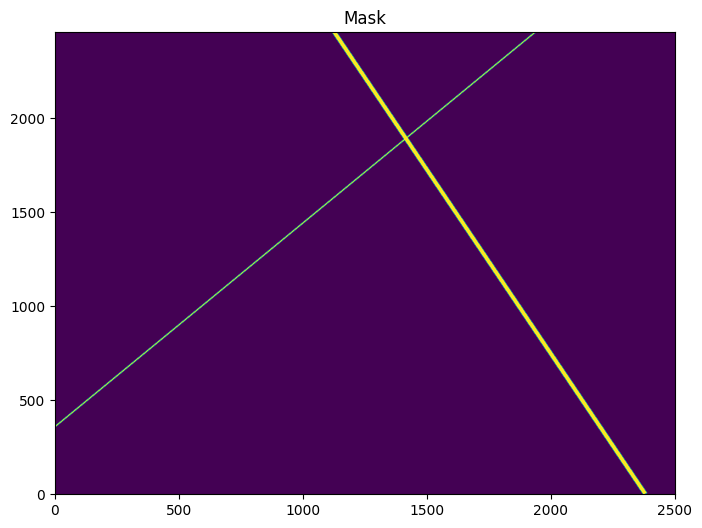

In [48]:
w2.plot_mask()

And there you go!

<a id="example6"></a>
## Example 6:  Create a new kernel for trail detection

We include a function called create_mrt_line_kernel that can be used to generate kernels for detecting trails of s specified size in the MRT. Note that kernels with widths of 1, 3, 7, and 15 pixels (convolved with a simple Gaussian HST/ACS psf model) are included already, but perhaps you want to generate a kernel with a new width, or convolved with a different PSF.

Let's generate a kernel for a trail that has an inherent width of 5 pixels and is convolved with a Gaussian PSF with `sigma=3`. 

INFO:utils_findsat_mrt:calculated endpoints: [(0, 511.5), (2047, 511.5)]


INFO:utils_findsat_mrt:Calculating median Radon Transform with 8 processes


INFO:utils_findsat_mrt:Inteprolating onto new grid to center kernel


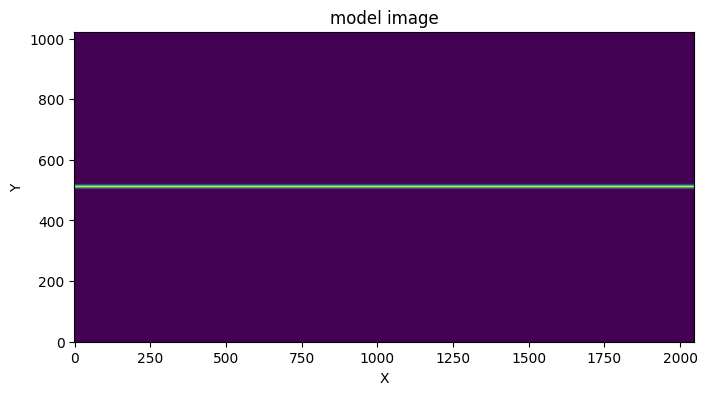

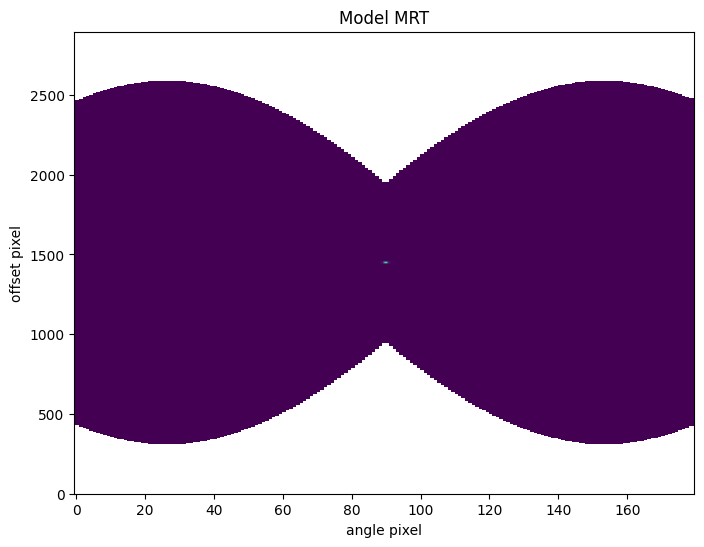

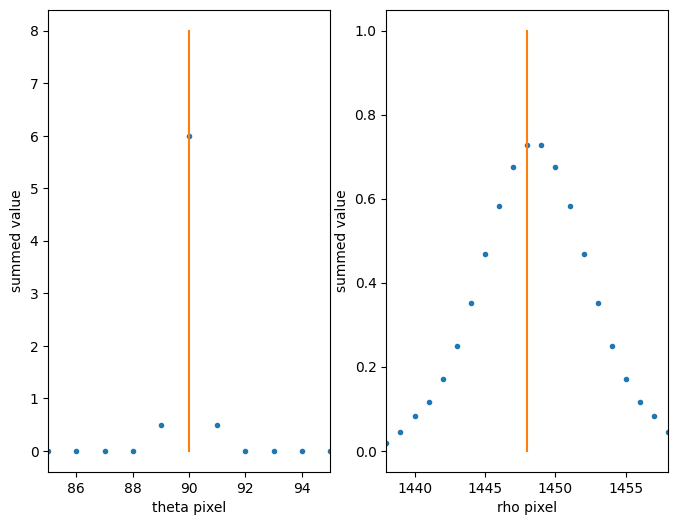

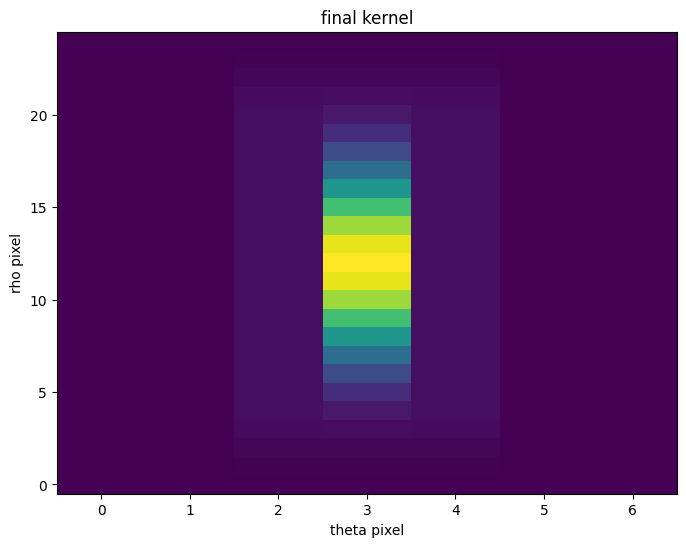

In [49]:
out = create_mrt_line_kernel(5, 3, processes=8, plot=True)

The first plot show the model streak. The second plot shows the resulting MRT. The kernsl is created by taking a cutout around the signal in the MRT. The third double-plot shows 1D slices of the signal in the MRT, with orange lines showing the location of the maximum values. These serve as first guesses of the center, after which the center is redetermined using a Guassian fit and the cutout extracted with the kernel perfectly centered. The 4th plot above shows the final kernel.

The kernel can be saved by defining the `outfile` keyword in `create_mrt_line_kernel`. By adding this file path into the `kernels` keyword in `TrailFinder` or `WfcWrapper`, it will be used for source detection when running `find_mrt_sources`.

### For more help:

More details may be found on the [ACS website](http://www.stsci.edu/hst/instrumentation/acs) and in the [ACS Instrument](https://hst-docs.stsci.edu/display/ACSIHB) and [Data Handbooks](http://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/other-documents/_documents/acs_dhb.pdf).

Please visit the [HST Help Desk](http://hsthelp.stsci.edu). Through the help desk portal, you can explore the *HST* Knowledge Base and request additional help from experts.

---
[Top of Page](#titleFindsat)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 
<br></br>
<br></br>